In [1]:
import numpy as np
import pandas as pd
import torch
from torch import nn
import pickle
from tqdm import tqdm
import re
import json
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim
import torch.nn.functional as F
from collections import Counter
from pensmodule.Generator.train import *
import json
import matplotlib.pyplot as plt

In [2]:
import os
#os.environ["CUDA_VISIBLE_DEVICES"] = "1"
device = torch.device('cuda:0') 

## Prepare

- **Config & Data**

In [3]:
from data import *
with open('config.json') as f:
    config = json.load(f)

In [4]:
sources = np.load('../../data2/sources.npy')
target_inputs = np.load('../../data2/target_inputs.npy')
target_outputs = np.load('../../data2/target_outputs.npy')
embedding_matrix = np.load('../../data2/embedding_matrix2.npy')
with open('../../data2/dict.pkl', 'rb') as f:
    news_index,category_dict,word_dict = pickle.load(f)
index2word = {}
for k,v in word_dict.items():
    index2word[v] = k
print(len(word_dict),embedding_matrix.shape)

141910 (141910, 300)


- **Model**

In [5]:
from pensmodule.Generator import HeadlineGen
model = HeadlineGen(config['model'], embedding_matrix, index2word, device, pointer_gen=True).to(device)

C:\Users\Guanz\.conda\envs\torchnlp\lib\site-packages\torch\nn\modules\rnn.py:63: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


In [6]:
from pensmodule.UserEncoder import NRMS

usermodel = NRMS(embedding_matrix)
usermodel.load_state_dict(torch.load('../../runs/userencoder/NAML-3.pkl'))
usermodel = usermodel.to(device)
usermodel.eval()

NRMS(
  (embed): Embedding(141910, 300, padding_idx=0)
  (attn_word): MultiHeadAttention(
    (W_Q): Linear(in_features=300, out_features=400, bias=True)
    (W_K): Linear(in_features=300, out_features=400, bias=True)
    (W_V): Linear(in_features=300, out_features=400, bias=True)
  )
  (attn_pool_word): AttentionPooling(
    (att_fc1): Linear(in_features=400, out_features=200, bias=True)
    (att_fc2): Linear(in_features=200, out_features=1, bias=True)
    (drop_layer): Dropout(p=0.2, inplace=False)
  )
  (attn_pool_news): AttentionPooling(
    (att_fc1): Linear(in_features=64, out_features=32, bias=True)
    (att_fc2): Linear(in_features=32, out_features=1, bias=True)
    (drop_layer): Dropout(p=0.2, inplace=False)
  )
  (drop_layer): Dropout(p=0.2, inplace=False)
  (fc): Linear(in_features=400, out_features=64, bias=True)
  (criterion): CrossEntropyLoss()
)

- **Load Trainer**

In [7]:
# here you can set different modes for computing coverage scores
trainer = Trainer(config, model, usermodel, device, mode=4, experiment_name='exp')

## Pretrain Seq2seq model

**Noted:**\
**For a fair comparison, here we advise using other source and targets (from your own collected news datasets) for pretraining.**

In [8]:
global_user_embed = np.load('../../data2/global_user_embed2.npy')
global_user_embed = torch.as_tensor(global_user_embed, device=device).float()

In [9]:
trainer._init_optimizer()

In [10]:
for epoch in range(1,4):
    print('epoch:', epoch)
    s_dset = Seq2SeqDataset(sources, target_inputs, target_outputs)
    train_iter = DataLoader(s_dset, batch_size=64, shuffle=True)
    
    trainer.pretrain(train_iter, global_user_embed)
    trainer.save_checkpoint(tag='pretrain_epoch_'+str(epoch))

epoch: 1


  0%|                                                                                                                                                                 | 0/1778 [00:00<?, ?it/s]C:\Users\Guanz\.conda\envs\torchnlp\lib\site-packages\torch\nn\functional.py:1698: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
pretrain loss: 55.492:  28%|███████████████████████████████████▉                                                                                            | 500/1778 [03:21<08:33,  2.49it/s]

step= 500, pretrain loss: 62.676


pretrain loss: 50.515:  56%|███████████████████████████████████████████████████████████████████████▍                                                       | 1000/1778 [06:41<05:10,  2.51it/s]

step=1000, pretrain loss: 57.153


pretrain loss: 47.922:  84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 1500/1778 [10:03<01:52,  2.47it/s]

step=1500, pretrain loss: 54.311


pretrain loss: 46.926: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1778/1778 [11:56<00:00,  2.48it/s]


Saved ../../runs/seq2seq\exp\checkpoint_pretrain_epoch_1.pth
epoch: 2


pretrain loss: 44.296:  28%|███████████████████████████████████▉                                                                                            | 500/1778 [03:31<08:31,  2.50it/s]

step= 500, pretrain loss: 44.297


pretrain loss: 43.626:  56%|███████████████████████████████████████████████████████████████████████▍                                                       | 1000/1778 [06:58<05:35,  2.32it/s]

step=1000, pretrain loss: 43.974


pretrain loss: 42.682:  84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 1500/1778 [10:16<01:49,  2.53it/s]

step=1500, pretrain loss: 43.630


pretrain loss: 42.112: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1778/1778 [12:05<00:00,  2.45it/s]


Saved ../../runs/seq2seq\exp\checkpoint_pretrain_epoch_2.pth
epoch: 3


pretrain loss: 40.002:  28%|███████████████████████████████████▉                                                                                            | 500/1778 [03:16<08:25,  2.53it/s]

step= 500, pretrain loss: 39.962


pretrain loss: 39.932:  56%|███████████████████████████████████████████████████████████████████████▍                                                       | 1000/1778 [06:33<05:07,  2.53it/s]

step=1000, pretrain loss: 39.899


pretrain loss: 39.329:  84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 1500/1778 [09:50<01:49,  2.53it/s]

step=1500, pretrain loss: 39.757


pretrain loss: 39.345: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1778/1778 [11:39<00:00,  2.54it/s]


Saved ../../runs/seq2seq\exp\checkpoint_pretrain_epoch_3.pth


## Train Personalized Generator

- **data loader**

In [11]:
with open('../../data2/TrainUsers.pkl', 'rb') as f:
    TrainUsers = pickle.load(f)
with open('../../data2/TrainSamples.pkl', 'rb') as f:
    TrainSamples = pickle.load(f)

In [12]:
news_scoring = np.load('../../data2/news_scoring2.npy')

In [13]:
i_dset = ImpressionDataset(news_scoring, sources, target_inputs, target_outputs, TrainUsers, TrainSamples)
data_loader = DataLoader(i_dset, batch_size=64, shuffle=True)

- **train**

In [14]:
trainer.load_checkpoint(tag='pretrain_epoch_3')

Loaded ../../runs/seq2seq\exp\checkpoint_pretrain_epoch_3.pth


In [15]:
trainer._init_evaluator_()

In [16]:
trainer._init_context_()

loading news body


In [17]:
optimizer_params={'lr': 0.000001}
scheduler_params={'step_size': 200, 'gamma': 0.98}
trainer._init_optimizer(optimizer_params=optimizer_params,scheduler_params=scheduler_params)

In [18]:
rewards = trainer.train(data_loader,train_option='a2c', tag='mod4')

train actor loss: -0.472, train critic loss: 0.423, train reward: 2.902:   4%|███                                                                       | 500/11925 [19:17<10:33:28,  3.33s/it]

Saved ../../runs/seq2seq\exp\checkpoint_train_mod4_step_500.pth
step= 500, train actor loss: -0.177, train critic loss: 0.423, train reward: 2.945


train actor loss: 0.075, train critic loss: 0.375, train reward: 3.047:   8%|██████▏                                                                   | 1000/11925 [39:00<10:04:04,  3.32s/it]

Saved ../../runs/seq2seq\exp\checkpoint_train_mod4_step_1000.pth
step=1000, train actor loss: -0.007, train critic loss: 0.375, train reward: 3.019


train actor loss: 0.270, train critic loss: 0.380, train reward: 3.193:  13%|█████████▍                                                                 | 1500/11925 [59:02<9:51:35,  3.40s/it]

Saved ../../runs/seq2seq\exp\checkpoint_train_mod4_step_1500.pth
step=1500, train actor loss: -0.031, train critic loss: 0.380, train reward: 3.127


train actor loss: -0.315, train critic loss: 0.378, train reward: 3.246:  17%|████████████                                                            | 2000/11925 [1:19:00<8:59:27,  3.26s/it]

Saved ../../runs/seq2seq\exp\checkpoint_train_mod4_step_2000.pth
step=2000, train actor loss: -0.101, train critic loss: 0.378, train reward: 3.183


train actor loss: 0.267, train critic loss: 0.356, train reward: 3.304:  21%|███████████████▎                                                         | 2500/11925 [1:41:02<9:58:24,  3.81s/it]

Saved ../../runs/seq2seq\exp\checkpoint_train_mod4_step_2500.pth
step=2500, train actor loss: -0.028, train critic loss: 0.356, train reward: 3.234


train actor loss: -0.059, train critic loss: 0.327, train reward: 3.318:  25%|██████████████████                                                      | 3000/11925 [2:05:23<9:56:33,  4.01s/it]

Saved ../../runs/seq2seq\exp\checkpoint_train_mod4_step_3000.pth
step=3000, train actor loss: -0.086, train critic loss: 0.327, train reward: 3.291


train actor loss: -0.106, train critic loss: 0.333, train reward: 3.303:  25%|██████████████████                                                      | 3000/11925 [2:05:26<6:13:11,  2.51s/it]


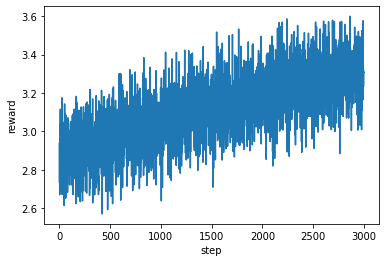

In [19]:
x = np.arange(len(rewards))
fig = plt.gcf()
plt.plot(x[:3000],rewards[:3000])

plt.xlabel("step")
plt.ylabel("reward")
plt.show()

## Test

In [20]:
with open('../../data2/TestUsers.pkl', 'rb') as f:
    TestUsers = pickle.load(f)
with open('../../data2/TestSamples.pkl', 'rb') as f:
    TestSamples = pickle.load(f)

In [21]:
from pensmodule.Generator import *
model_path = '../../runs/seq2seq/exp/checkpoint_train_mod4_step_2000.pth'
model = load_model_from_ckpt(model_path).to(device)
model.eval()

HeadlineGen(
  (embeddings): Embedding(141910, 300)
  (encoder): LSTMEncoder(
    (embeddings): Embedding(141910, 300)
    (rnn): LSTM(300, 64, batch_first=True, dropout=0.2, bidirectional=True)
    (bridge): ModuleList(
      (0): Linear(in_features=64, out_features=64, bias=True)
      (1): Linear(in_features=64, out_features=64, bias=True)
    )
  )
  (decoder): Decoder_P(
    (embeddings): Embedding(141910, 300)
    (dropout): Dropout(p=0.2, inplace=False)
    (rnn): LSTM(300, 128, batch_first=True)
    (attention): Attention(
      (linear_out): Linear(in_features=256, out_features=128, bias=True)
    )
    (transform): ModuleList(
      (0): Linear(in_features=64, out_features=128, bias=True)
      (1): Linear(in_features=64, out_features=128, bias=True)
    )
    (out): Linear(in_features=128, out_features=141910, bias=True)
    (p_gen_linear): Linear(in_features=128, out_features=1, bias=True)
  )
  (loss_fn): NLLLoss()
  (dropout): Dropout(p=0.2, inplace=False)
)

In [22]:
from pensmodule.UserEncoder import NRMS

usermodel = NRMS(embedding_matrix)
usermodel.load_state_dict(torch.load('../../runs/userencoder/NAML-1.pkl'))
usermodel = usermodel.to(device)
usermodel.eval()

NRMS(
  (embed): Embedding(141910, 300, padding_idx=0)
  (attn_word): MultiHeadAttention(
    (W_Q): Linear(in_features=300, out_features=400, bias=True)
    (W_K): Linear(in_features=300, out_features=400, bias=True)
    (W_V): Linear(in_features=300, out_features=400, bias=True)
  )
  (attn_pool_word): AttentionPooling(
    (att_fc1): Linear(in_features=400, out_features=200, bias=True)
    (att_fc2): Linear(in_features=200, out_features=1, bias=True)
    (drop_layer): Dropout(p=0.2, inplace=False)
  )
  (attn_pool_news): AttentionPooling(
    (att_fc1): Linear(in_features=64, out_features=32, bias=True)
    (att_fc2): Linear(in_features=32, out_features=1, bias=True)
    (drop_layer): Dropout(p=0.2, inplace=False)
  )
  (drop_layer): Dropout(p=0.2, inplace=False)
  (fc): Linear(in_features=400, out_features=64, bias=True)
  (criterion): CrossEntropyLoss()
)

In [23]:
i_dset = TestImpressionDataset(news_scoring, sources, TestUsers, TestSamples)
test_iter = DataLoader(i_dset, batch_size=16, shuffle=False)

In [24]:
from pensmodule.Generator.eval import predict
refs, hyps, scores1, scores2, scoresf = predict(usermodel, model, test_iter, device, index2word, beam=False, beam_size=3, eos_id=2)
# refs, hyps, scores1, scores2, scoresf = predict(usermodel, model, test_iter, device, index2word, beam=True, beam_size=3, eos_id=2)

  0%|                                                                                                                                                                 | 0/1288 [00:00<?, ?it/s]C:\Users\Guanz\.conda\envs\torchnlp\lib\site-packages\torch\nn\functional.py:1698: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
  0%|▏                                                                                                                                                        | 2/1288 [00:00<01:32, 13.94it/s]

src: tensor([[  320,   317,  4361,  ...,    49,     2,     0],
        [   14,  2818,  1775,  ...,     0,     0,     0],
        [ 3969, 47199,  1155,  ...,     0,     0,     0],
        ...,
        [   30,    59,   181,  ...,  2506, 16767,     2],
        [  322,   141,   705,  ...,    43,   490,     2],
        [19751,   236,  1812,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[ 2157,  8309,  2725,  ...,     2,     0,     0],
        [   35,   149, 26323,  ...,     0,     0,     0],
        [  323,   965,   318,  ...,     0,     0,     0],
        ...,
        [ 4105,  7902, 20697,  ...,     0,     0,     0],
        [ 1188,  4260,   748,  ...,     0,     0,     0],
        [   41,  2013,    79,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[ 1018,    35,  3951,  ...,    41,   646,     2],
        [  429,   473,   860,  ..., 10426,    35,     2],
        [  319,  1333, 15826,  ...,   107,     2,     0],
        ...,
        [   35,  1068,  1877,  ..., 

  0%|▍                                                                                                                                                        | 4/1288 [00:00<01:35, 13.45it/s]

src: tensor([[  639, 10223,  2100,  ...,     0,     0,     0],
        [13994, 66375,   314,  ...,    67, 47342,     2],
        [ 9651,     7, 11199,  ...,     0,     0,     0],
        ...,
        [  141,   383,   455,  ...,  6303,     2,     0],
        [ 7620,    59,  2799,  ...,  2604,   338,     2],
        [  613,   338,  3004,  ...,     7,  1307,     2]], dtype=torch.int32)
src: tensor([[   41,  1963,  7317,  ...,     0,     0,     0],
        [  318,  3154,  2058,  ...,     0,     0,     0],
        [ 6872, 35450,    57,  ...,  2616,     2,     0],
        ...,
        [16641, 16642,     7,  ...,     0,     0,     0],
        [46740,  2761,  1630,  ...,     0,     0,     0],
        [   35,  1876,  2403,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[   107,     59,     35,  ...,      0,      0,      0],
        [  4081,  23235,   2735,  ...,   5519,    168,      2],
        [   613,   2220,    338,  ...,   7995,     28,      2],
        ...,
        [    24,  

  1%|▉                                                                                                                                                        | 8/1288 [00:00<01:31, 13.92it/s]

src: tensor([[   41,  4241,  3346,  ...,     0,     0,     0],
        [   41, 14211,  3593,  ...,    28,     2,     0],
        [29343,  2392,  5294,  ...,    35,     2,     0],
        ...,
        [   57,    35,    12,  ...,     0,     0,     0],
        [   35, 10542,  2252,  ...,  1969,   103,     2],
        [ 6248,    59,  7043,  ...,     7,  1307,     2]], dtype=torch.int32)
src: tensor([[ 4104,  4105, 10152,  ...,     7,  3907,     2],
        [   49,   647,    59,  ...,     0,     0,     0],
        [  243,  1378,    40,  ...,  3080,    96,     2],
        ...,
        [  815,  7620,    59,  ...,     0,     0,     0],
        [29718,     7,  4908,  ...,     0,     0,     0],
        [   35,  3860,  7063,  ...,   805,     2,     0]], dtype=torch.int32)
src: tensor([[ 9388,    28, 31536,  ...,     0,     0,     0],
        [  172,    35,   506,  ...,    95,   265,     2],
        [ 1378,  5764,    49,  ...,     0,     0,     0],
        ...,
        [   41, 17492,    79,  ..., 

  1%|█▏                                                                                                                                                      | 10/1288 [00:00<01:31, 13.92it/s]

src: tensor([[   41,  3304,   627,  ...,   627,    88,     2],
        [ 7531,  1253,    74,  ...,    56,    41,     2],
        [   92,   141,   701,  ...,     0,     0,     0],
        ...,
        [   57, 65835,     7,  ...,    28,     2,     0],
        [   41,  2065,  6086,  ...,     0,     0,     0],
        [ 2078,    35,    35,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[   35,  3929, 21401,  ...,   163,    43,     2],
        [   35,  1035,    34,  ...,     0,     0,     0],
        [   57, 14089,  7367,  ...,  1141,     2,     0],
        ...,
        [   35,   202,   332,  ...,  1772,     2,     0],
        [  491,    35,   393,  ...,   145,  2785,     2],
        [  184,    41,    84,  ...,  1081,    51,     2]], dtype=torch.int32)
src: tensor([[   41,  2065,  1906,  ...,    26,  8598,     2],
        [  613,   338,   116,  ...,     2,     0,     0],
        [  767,   205,    35,  ...,     0,     0,     0],
        ...,
        [   35,  5741,    53,  ..., 

  1%|█▋                                                                                                                                                      | 14/1288 [00:01<01:31, 13.96it/s]

src: tensor([[  590, 24763,   665,  ...,  1776,     2,     0],
        [   14,   169,  2049,  ...,  3978,  1258,     2],
        [   30,    59,   746,  ...,     0,     0,     0],
        ...,
        [ 2584,   148,   132,  ..., 12224,     2,     0],
        [   57,    35,    90,  ...,   946,     2,     0],
        [ 7066,     7,  9151,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[10876,  6916,  7279,  ...,  1691,    61,     2],
        [ 2332,   747,  4651,  ...,     0,     0,     0],
        [ 2466,   114,  1115,  ...,     0,     0,     0],
        ...,
        [  954,  5149,    53,  ...,     0,     0,     0],
        [ 1465,    43,  3082,  ...,     0,     0,     0],
        [ 7049,   627,    88,  ...,    28,     2,     0]], dtype=torch.int32)
src: tensor([[1586, 3857,  103,  ...,    0,    0,    0],
        [ 225,   59,   61,  ...,   59, 3995,    2],
        [ 424,   35, 1428,  ...,   41, 1261,    2],
        ...,
        [ 184, 5091,  409,  ...,    0,    0,    0],
  

  1%|█▉                                                                                                                                                      | 16/1288 [00:01<01:31, 13.91it/s]

tensor([[17256,  6341,     7,  ...,     0,     0,     0],
        [ 8172,  2832,   650,  ...,     0,     0,     0],
        [14308,  6875, 25492,  ...,  4840,     2,     0],
        ...,
        [   18,  9864,  1429,  ...,     0,     0,     0],
        [15990,  1577,  1416,  ...,  3741,   111,     2],
        [  225,  5034,  1465,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[ 2949,   163,    35,  ...,     0,     0,     0],
        [58390,  5033,  1307,  ...,     0,     0,     0],
        [ 6572,   144,    94,  ...,     2,     0,     0],
        ...,
        [40138,     7, 13346,  ...,     0,     0,     0],
        [ 1925,   243,   954,  ...,     2,     0,     0],
        [   41,  1306,    43,  ..., 15448,   132,     2]], dtype=torch.int32)
src: tensor([[   41,  9221,  4742,  ...,    53,     2,     0],
        [ 2040,     7,  8918,  ...,     0,     0,     0],
        [   41,  6706,    43,  ...,     0,     0,     0],
        ...,
        [  288,  2320,   620,  ...,     0

  2%|██▎                                                                                                                                                     | 20/1288 [00:01<01:31, 13.84it/s]

src: tensor([[   30,    59,   190,  ...,     0,     0,     0],
        [ 2018,  2019, 10223,  ...,     0,     0,     0],
        [ 1903, 10223, 13715,  ...,   691,     7,     2],
        ...,
        [   41,   102,    49,  ...,     2,     0,     0],
        [   35,  3100,   322,  ...,     0,     0,     0],
        [   30,    59,   225,  ...,    37,  6872,     2]], dtype=torch.int32)
src: tensor([[   35,  1955,    28,  ...,  1621,     2,     0],
        [  613,   338,  1406,  ...,     0,     0,     0],
        [ 1839, 23533,     7,  ...,   700,    28,     2],
        ...,
        [  951,   144, 30660,  ...,   252,   330,     2],
        [   41,  2065,  1906,  ...,    26,  8598,     2],
        [ 8249,  7586,     7,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[ 2370,   116,  3789,  ...,   413,    61,     2],
        [23716,  3033,  3116,  ...,     0,     0,     0],
        [ 1709,   108,     7,  ...,     0,     0,     0],
        ...,
        [ 3274,  5905,    35,  ..., 

  2%|██▌                                                                                                                                                     | 22/1288 [00:01<01:30, 13.94it/s]

tensor([[  294,    96,    35,  ...,    35,     2,     0],
        [ 3274, 10223,   318,  ...,     0,     0,     0],
        [38595,   241,    43,  ...,     0,     0,     0],
        ...,
        [ 2956,   702,    53,  ...,     0,     0,     0],
        [   96,    41,  6511,  ...,    49,    35,     2],
        [ 2355,   122, 14553,  ...,    28,     2,     0]], dtype=torch.int32)
src: tensor([[ 1835,  5616,  1305,  ...,     0,     0,     0],
        [  243,   141,  2078,  ...,     0,     0,     0],
        [   35,  3382,   667,  ...,  5368,  5287,     2],
        ...,
        [ 7049,   627,    88,  ...,    28,     2,     0],
        [59344,  1837,     7,  ...,     0,     0,     0],
        [  720,  1292,    41,  ...,    35,     2,     0]], dtype=torch.int32)
src: tensor([[ 1912,  1222, 10223,  ...,    41,  6841,     2],
        [   35, 13263, 13262,  ...,     0,     0,     0],
        [  319,  1333, 31998,  ...,     0,     0,     0],
        ...,
        [   35,   288,   474,  ...,     2

  2%|███                                                                                                                                                     | 26/1288 [00:01<01:30, 14.00it/s]

src: tensor([[  107,    59,   409,  ...,     0,     0,     0],
        [  107,    59,   225,  ...,     0,     0,     0],
        [   97,  4300, 26314,  ...,     2,     0,     0],
        ...,
        [ 1646,  2693,   383,  ...,   118, 11859,     2],
        [   96,   141,   455,  ...,   122,    41,     2],
        [28776,     7,    35,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[   14,    64,    83,  ...,     0,     0,     0],
        [   30,  6222,    41,  ...,     0,     0,     0],
        [  972, 11768,     7,  ...,     0,     0,     0],
        ...,
        [ 1007,   241,  2850,  ...,    79,     2,     0],
        [   24,   399,     7,  ...,     0,     0,     0],
        [  141,   133,   289,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[ 5091,  3358,   122,  ...,   193,    28,     2],
        [ 3929,  6804, 21559,  ..., 30869,  3929,     2],
        [   35,  5602, 13098,  ...,     0,     0,     0],
        ...,
        [   61, 88748,   543,  ..., 

  2%|███▎                                                                                                                                                    | 28/1288 [00:02<01:31, 13.74it/s]

src: tensor([[  353,  1256,  1716,  ...,     0,     0,     0],
        [  972, 11752,  6118,  ...,     0,     0,     0],
        [13792,  3893,   122,  ...,     0,     0,     0],
        ...,
        [ 2110,  4321,    53,  ...,    57, 15040,     2],
        [  318,   351,  2187,  ...,    53,     2,     0],
        [21426,     7,  2985,  ...,  7321,    28,     2]], dtype=torch.int32)
src: tensor([[29125,  4647,  7095,  ...,     0,     0,     0],
        [  103,  7887,     7,  ...,    11,    18,     2],
        [  376,    84,  1982,  ...,  1454, 63410,     2],
        ...,
        [   35,   330,  5589,  ...,  7636,   132,     2],
        [ 2704,  9080,    35,  ...,     0,     0,     0],
        [ 4709,  4710,    59,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[   15,   141,  3617,  ...,     0,     0,     0],
        [   14,   860,  3284,  ...,    28,     2,     0],
        [32172, 11962,  1307,  ...,     2,     0,     0],
        ...,
        [  319,  1333, 40570,  ..., 

  2%|███▊                                                                                                                                                    | 32/1288 [00:02<01:29, 13.97it/s]

src: tensor([[11944,  1603,  2784,  ...,    59,   111,     2],
        [   35, 13263, 13262,  ...,     0,     0,     0],
        [   41,  1299,   236,  ...,   132,  3742,     2],
        ...,
        [24831, 70551,    25,  ...,     0,     0,     0],
        [   24,    91,    49,  ...,     2,     0,     0],
        [11365, 11366,  3157,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[ 2040,     7,  8918,  ...,     0,     0,     0],
        [ 7852,     7,  8918,  ...,     0,     0,     0],
        [   35,  2402,  2575,  ...,   122, 16541,     2],
        ...,
        [ 2435,   356,  6532,  ...,     0,     0,     0],
        [ 2898,   582,  5206,  ...,    49,     2,     0],
        [ 2331, 10081,  2933,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[  243,   141,    64,  ...,     0,     0,     0],
        [   35,   136, 10211,  ..., 14086,    74,     2],
        [   24,  1107,    43,  ...,    35,  1638,     2],
        ...,
        [ 7096,  3754,    25,  ..., 

  3%|████                                                                                                                                                    | 34/1288 [00:02<01:30, 13.85it/s]

src: tensor([[  243,    30,    59,  ...,     0,     0,     0],
        [17670,     7,  4737,  ...,    35, 17670,     2],
        [   30,    59,   746,  ...,   852,    35,     2],
        ...,
        [   92,  2071, 28287,  ...,  7572,    74,     2],
        [30829,   612,  2000,  ...,     0,     0,     0],
        [   35,   438, 20104,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[14722,   382,   740,  ...,  1620,   558,     2],
        [25921, 25922,     7,  ..., 25921, 25922,     2],
        [  383,    39,   951,  ...,    79,     2,     0],
        ...,
        [20560,   516,   620,  ...,     0,     0,     0],
        [  243,   141,   118,  ..., 23661,   265,     2],
        [   61,    13,  6821,  ..., 12660,   132,     2]], dtype=torch.int32)
src: tensor([[ 2065,  5152,  9402,  ...,     0,     0,     0],
        [   41,   319,  3501,  ...,    28,   191,     2],
        [ 1907,   355,    40,  ...,    59,   166,     2],
        ...,
        [24661,     7,  8369,  ..., 

  3%|████▍                                                                                                                                                   | 38/1288 [00:02<01:30, 13.84it/s]

src: tensor([[  319,  1333,  2672,  ...,     0,     0,     0],
        [   41,   252,   809,  ...,     0,     0,     0],
        [   35,  2040, 17718,  ...,     0,     0,     0],
        ...,
        [   35,  1226, 15313,  ...,  2409,     2,     0],
        [  919,  1078,  1907,  ...,   114,     7,     2],
        [21971,  7801,    59,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[17804,  1104,  6236,  ...,     0,     0,     0],
        [  184,  1581,    35,  ...,   132,   747,     2],
        [ 1121, 11470, 11471,  ...,     0,     0,     0],
        ...,
        [15867,  3347,   134,  ...,     0,     0,     0],
        [31599,  1910,     7,  ...,     7, 31599,     2],
        [   35,  2240,  2575,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[   35, 17811,    59,  ...,     2,     0,     0],
        [29529,  2574,  1415,  ...,     2,     0,     0],
        [   41,  2065,  1906,  ...,    26,  8598,     2],
        ...,
        [ 2370,   116,    41,  ..., 

  3%|████▋                                                                                                                                                   | 40/1288 [00:02<01:29, 13.87it/s]

src: tensor([[ 3092,   955,   467,  ...,  7238,  1227,     2],
        [   30,   197,  1167,  ...,  1169,   484,     2],
        [  613,   338,   116,  ...,     2,     0,     0],
        ...,
        [   41, 10223, 53109,  ...,    50,   141,     2],
        [ 1658,    59,  3874,  ...,    28,     2,     0],
        [  376,  8670,     7,  ...,     2,     0,     0]], dtype=torch.int32)
src: tensor([[ 2949,   163,    35,  ...,   756,  1162,     2],
        [  319,  1333, 15826,  ...,     0,     0,     0],
        [16608, 29825,     7,  ...,     0,     0,     0],
        ...,
        [ 3591,   132,  4784,  ...,     0,     0,     0],
        [   34,  7673,    11,  ...,     0,     0,     0],
        [  954,    59,    41,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[  434,  1318,  5026,  ...,     0,     0,     0],
        [  107,   860,    41,  ...,    53,  3108,     2],
        [  184,  2047,   241,  ...,    53,  1025,     2],
        ...,
        [19818,   122,   450,  ..., 

  3%|█████▏                                                                                                                                                  | 44/1288 [00:03<01:30, 13.73it/s]

src: tensor([[ 6240,  6786,  6031,  ...,  2464,  2563,     2],
        [   96,   141,   455,  ...,   122,    41,     2],
        [ 2049,    41,   705,  ...,    24,   780,     2],
        ...,
        [  111,   156,    43,  ...,     2,     0,     0],
        [ 5219,    59, 79246,  ...,     0,     0,     0],
        [  954,    59,    41,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[ 7338,    59,  3162,  ...,     0,     0,     0],
        [   35, 13263, 13262,  ...,     0,     0,     0],
        [62325,   860,   114,  ...,     0,     0,     0],
        ...,
        [18603,  1415,    28,  ..., 22200,  1478,     2],
        [   35,  2040,  2041,  ...,     0,     0,     0],
        [  319,  1333, 40570,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[ 2050,   965,    41,  ...,     0,     0,     0],
        [  318,   131,  7004,  ..., 32027,     2,     0],
        [   41,  9954,    43,  ...,  3631,    28,     2],
        ...,
        [   92,   141,  1925,  ..., 

  4%|█████▍                                                                                                                                                  | 46/1288 [00:03<01:31, 13.59it/s]

src: tensor([[  30, 6834, 1480,  ...,    0,    0,    0],
        [ 647,  176,   43,  ...,   32,    7,    2],
        [  35, 6841,  236,  ...,    7,    2,    0],
        ...,
        [2928, 1389,  236,  ...,    0,    0,    0],
        [ 265,   55, 3957,  ..., 2207,    2,    0],
        [ 815, 7620,   59,  ...,    0,    0,    0]], dtype=torch.int32)
src: tensor([[15496,   613,  4385,  ...,     7,   852,     2],
        [11846,   236,  4547,  ..., 11832, 16367,     2],
        [   35,   434,  2900,  ...,   954,    59,     2],
        ...,
        [ 1115,   309,    30,  ...,     0,     0,     0],
        [  954,    40,  1328,  ...,   530,     2,     0],
        [ 5636,  6066,   140,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[    38,     39,   3062,  ...,  70446,    251,      2],
        [  2402,   5795,    620,  ...,      0,      0,      0],
        [   691,   1302,   3159,  ...,      2,      0,      0],
        ...,
        [ 10039, 127741,  59494,  ...,      0,      0,

  4%|█████▉                                                                                                                                                  | 50/1288 [00:03<01:33, 13.30it/s]

src: tensor([[   84,    43,    35,  ...,     0,     0,     0],
        [   24,  2667,   122,  ...,     2,     0,     0],
        [   41, 24913, 16013,  ...,     0,     0,     0],
        ...,
        [   35,  4355,   474,  ...,    93,   439,     2],
        [  424,    35,  7388,  ...,  1728,   244,     2],
        [ 6270,    73,  2749,  ...,     7,   117,     2]], dtype=torch.int32)
src: tensor([[  955,  8842,    41,  ...,  1335,     2,     0],
        [   35,  1876,  1945,  ...,     0,     0,     0],
        [  639,  6749,  3957,  ...,     0,     0,     0],
        ...,
        [   35,    21,   442,  ...,    35, 15859,     2],
        [  144, 11643,   122,  ...,     2,     0,     0],
        [ 4714, 12562,    49,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[  181,  1349,   244,  ...,     0,     0,     0],
        [  632,  5333,  1304,  ...,   163,    43,     2],
        [   18,  1394,   705,  ...,     0,     0,     0],
        ...,
        [  356,    59,   190,  ..., 

  4%|██████▏                                                                                                                                                 | 52/1288 [00:03<01:31, 13.53it/s]

src: tensor([[   30,    59,   123,  ...,  8774,  5307,     2],
        [  613,   338,  3361,  ...,     0,     0,     0],
        [ 1912,  1913,   318,  ...,     0,     0,     0],
        ...,
        [ 3907,  3908,  3969,  ...,  2047, 93477,     2],
        [ 3114,   338,  4383,  ...,   383,     2,     0],
        [  101,    40,  6282,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[  338,  2047,    41,  ...,    61, 18833,     2],
        [ 9651,     7, 11199,  ...,     0,     0,     0],
        [ 5188, 31355,     7,  ...,     0,     0,     0],
        ...,
        [ 3274,    86,    28,  ...,     2,     0,     0],
        [13280,  3502,    35,  ...,     0,     0,     0],
        [ 1479, 69310,    28,  ...,     2,     0,     0]], dtype=torch.int32)
src: tensor([[ 1007,   243,   141,  ...,     0,     0,     0],
        [   35,  1423,  1426,  ...,  1526,     2,     0],
        [  265,  4930, 33329,  ...,   125,    28,     2],
        ...,
        [ 2049,    41,   705,  ..., 

  4%|██████▌                                                                                                                                                 | 56/1288 [00:04<01:30, 13.67it/s]

src: tensor([[  593,    59,    83,  ...,     0,     0,     0],
        [ 3907,  3908,  3969,  ...,     7,    35,     2],
        [  107,    59,   225,  ...,     0,     0,     0],
        ...,
        [11787,   558,   103,  ...,     0,     0,     0],
        [   35,  5741,    53,  ..., 12572, 23552,     2],
        [13199,     7, 12615,  ...,    34,    41,     2]], dtype=torch.int32)
src: tensor([[   35,  1835,  6285,  ...,     0,     0,     0],
        [  243,    41, 12032,  ...,     0,     0,     0],
        [   92,    51,    79,  ...,    59,  2660,     2],
        ...,
        [   40,    41,  4351,  ...,     0,     0,     0],
        [   92,    30,  2782,  ..., 22054,     2,     0],
        [13792,  3893,   122,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[   35,  1285, 15097,  ...,    28,   141,     2],
        [ 3249,    53,   318,  ...,   695,  4070,     2],
        [15630,  1829,   236,  ...,   190,   280,     2],
        ...,
        [21426,     7,  2985,  ..., 

  5%|██████▊                                                                                                                                                 | 58/1288 [00:04<01:30, 13.66it/s]

src: tensor([[   35,   116,   643,  ...,     0,     0,     0],
        [   56,    43,  1481,  ...,     0,     0,     0],
        [16797,   132, 16823,  ..., 16823,    83,     2],
        ...,
        [ 1406, 12631,   423,  ...,     0,     0,     0],
        [  319,  1333, 15826,  ...,     2,     0,     0],
        [   49,    41,   454,  ...,    35,  1282,     2]], dtype=torch.int32)
src: tensor([[   35, 17199, 18718,  ...,     0,     0,     0],
        [ 2107,   122,   202,  ...,     0,     0,     0],
        [  376, 22834,    59,  ...,     0,     0,     0],
        ...,
        [  265,    35,  2166,  ...,  2243,     2,     0],
        [ 2370,   116,  6031,  ...,     0,     0,     0],
        [ 1987,  8611,    28,  ...,     7,    35,     2]], dtype=torch.int32)
src: tensor([[   41,  2065,  6086,  ...,     0,     0,     0],
        [   15,   141,  3617,  ...,     0,     0,     0],
        [   35,  1672, 16951,  ...,     0,     0,     0],
        ...,
        [ 2295,   549, 10542,  ..., 

  5%|███████▎                                                                                                                                                | 62/1288 [00:04<01:30, 13.61it/s]

src: tensor([[  319,  1333,  3976,  ...,    30,   409,     2],
        [11162, 34630,   132,  ...,     0,     0,     0],
        [  954,    59,    41,  ...,   241,     7,     2],
        ...,
        [  294,  3209,    28,  ...,    28,     2,     0],
        [   41,  7858,    74,  ...,     0,     0,     0],
        [  323,   965,  4601,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[  547,   823,    59,  ...,  5456, 16246,     2],
        [   30,    59,   225,  ...,    37,  6872,     2],
        [38600,     7, 11199,  ...,     0,     0,     0],
        ...,
        [  308,   309,  5007,  ...,     0,     0,     0],
        [68585,   122,  1224,  ...,     0,     0,     0],
        [   30,    59,  1328,  ...,  1757, 28754,     2]], dtype=torch.int32)
src: tensor([[ 1533, 24264,   455,  ...,     2,     0,     0],
        [  459,   596, 12069,  ...,     0,     0,     0],
        [14709,     7, 77955,  ...,  1179,   143,     2],
        ...,
        [ 2704,  9080,    35,  ..., 

  5%|███████▊                                                                                                                                                | 66/1288 [00:04<01:28, 13.74it/s]

tensor([[11329, 11330,  1448,  ...,     0,     0,     0],
        [  243,    30,  9701,  ...,     0,     0,     0],
        [   35,  3970, 11310,  ...,     0,     0,     0],
        ...,
        [  639,  6749,  8199,  ...,     0,     0,     0],
        [  251,    28,  4100,  ...,     0,     0,     0],
        [18561,   712,  5794,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[ 3263,    28,    57,  ...,     0,     0,     0],
        [   35,   700,  2460,  ...,     0,     0,     0],
        [  319,  4737,  3894,  ...,    41,   520,     2],
        ...,
        [  459,  1667, 20697,  ...,     0,     0,     0],
        [  376,    35,  3805,  ...,     0,     0,     0],
        [  265,  2034,  1974,  ...,    51,    79,     2]], dtype=torch.int32)
src: tensor([[   30,    59,  5518,  ...,     0,     0,     0],
        [ 5372,   258,   986,  ...,     0,     0,     0],
        [   50,  1488,   122,  ...,  1758,   265,     2],
        ...,
        [ 1200,     7,   382,  ...,    55

  5%|████████                                                                                                                                                | 68/1288 [00:04<01:28, 13.75it/s]

src: tensor([[  41, 2065, 6086,  ...,    0,    0,    0],
        [   3,  111,   41,  ...,    2,    0,    0],
        [  35,  320, 5262,  ...,  103,  356,    2],
        ...,
        [ 455,   41, 4350,  ..., 2248,   53,    2],
        [ 954,   59,   61,  ...,    0,    0,    0],
        [ 371,   53,  108,  ...,   43,  707,    2]], dtype=torch.int32)
src: tensor([[   61,   484,    35,  ...,     0,     0,     0],
        [ 7620,    59,  2799,  ...,     0,     0,     0],
        [14722,   720,    50,  ...,    39,  6073,     2],
        ...,
        [14308,  6875, 25492,  ...,  4840,     2,     0],
        [   41,  2013,   122,  ...,     0,     0,     0],
        [   15,   141,  3617,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[   96,    35,  8169,  ...,     0,     0,     0],
        [   61, 21793,  2613,  ...,    41,  3306,     2],
        [   41,  5883, 12532,  ...,     0,     0,     0],
        ...,
        [ 2402,  5795,   620,  ...,     0,     0,     0],
        [   35

  5%|████████▎                                                                                                                                               | 70/1288 [00:05<01:28, 13.78it/s]

tensor([[ 1408,  8475, 35542,  ...,   702,   376,     2],
        [ 5183,    53, 31346,  ...,   484,     2,     0],
        [ 1877,  1878,   122,  ...,  3015,   914,     2],
        ...,
        [  702,    53,  2494,  ...,    35,   520,     2],
        [18626,  7800,  1042,  ...,   520,  4504,     2],
        [  265,    35,   212,  ...,    90,  1286,     2]], dtype=torch.int32)
src: tensor([[ 2065,   731,   328,  ...,     0,     0,     0],
        [ 8062,  2171, 55777,  ...,     0,     0,     0],
        [  383,    35, 10088,  ...,   132,   318,     2],
        ...,
        [56151, 43793,   236,  ...,     2,     0,     0],
        [   35, 11756,  1894,  ...,     0,     0,     0],
        [  319,  1333, 10223,  ...,     7,    41,     2]], dtype=torch.int32)
src: tensor([[  954,    59,  1015,  ...,     0,     0,     0],
        [   39,    51, 18599,  ...,     0,     0,     0],
        [  651,   652,   653,  ...,     0,     0,     0],
        ...,
        [ 6420,   860,  1829,  ...,     2

  6%|████████▋                                                                                                                                               | 74/1288 [00:05<01:26, 13.96it/s]

src: tensor([[  613,   338, 41642,  ...,     0,     0,     0],
        [19751,   236,  1812,  ...,     0,     0,     0],
        [31914,  1483,  1454,  ..., 18833,     2,     0],
        ...,
        [  319,  1333, 15826,  ...,     0,     0,     0],
        [  107,    59,    41,  ..., 41476,     2,     0],
        [ 6590,    28, 10522,  ...,  1165,   103,     2]], dtype=torch.int32)
src: tensor([[   35,  3957,    43,  ...,    49,    35,     2],
        [  319,  1333,  5905,  ...,     0,     0,     0],
        [43597,     7, 20866,  ...,     0,     0,     0],
        ...,
        [10646, 10223, 14321,  ...,     0,     0,     0],
        [  225,    41,  2687,  ...,  2431,  2882,     2],
        [   57,    41,   238,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[21382,   319,  4249,  ...,  5012,     7,     2],
        [44959, 44960,  3893,  ...,     0,     0,     0],
        [  716, 10611,  1347,  ...,     0,     0,     0],
        ...,
        [ 9815,  7122,    49,  ..., 

  6%|████████▉                                                                                                                                               | 76/1288 [00:05<01:26, 13.97it/s]

src: tensor([[ 3985, 48900,     7,  ...,     0,     0,     0],
        [ 4012,  9375, 13879,  ...,     0,     0,     0],
        [ 3221,    28,  2804,  ...,     0,     0,     0],
        ...,
        [   30,    79,    61,  ...,  7886,   406,     2],
        [   35,  4742,  2469,  ...,     0,     0,     0],
        [ 5927,  3081,    49,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[   35,  3409,    49,  ...,  1299,   338,     2],
        [  243,   141,    64,  ...,     0,     0,     0],
        [ 5285,  6057, 14321,  ...,     0,     0,     0],
        ...,
        [   49,    35,  1646,  ..., 20345,     2,     0],
        [   35,  2532,    59,  ...,     0,     0,     0],
        [ 2153, 13730,   236,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[  3187,  65041,     30,  ...,      2,      0,      0],
        [    30,     59,   5518,  ...,      0,      0,      0],
        [  6018,   3940,   5052,  ...,      0,      0,      0],
        ...,
        [   613,  

  6%|█████████▍                                                                                                                                              | 80/1288 [00:05<01:26, 13.92it/s]

src: tensor([[10969,  7841,     7,  ...,     0,     0,     0],
        [17482,  3753,  1881,  ...,     0,     0,     0],
        [62325,   860,   114,  ...,     0,     0,     0],
        ...,
        [ 3042,     7,  7243,  ...,     0,     0,     0],
        [ 7818,   306,    28,  ...,     0,     0,     0],
        [12026, 14504, 14810,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[   35,   682,    49,  ..., 13240,     2,     0],
        [ 2331, 28475,  1331,  ...,     3,   410,     2],
        [ 7757,  1015,    16,  ...,     2,     0,     0],
        ...,
        [  547,  4013,   823,  ...,    41,  7388,     2],
        [ 9388,    28,  8134,  ...,     0,     0,     0],
        [   84,    43,    35,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[ 8897, 11371,   236,  ...,    41,   392,     2],
        [  319,  1333, 10223,  ...,    53,    12,     2],
        [   57,    35,  9197,  ..., 10453,   103,     2],
        ...,
        [   35,  3753,  1044,  ..., 

  6%|█████████▋                                                                                                                                              | 82/1288 [00:05<01:26, 13.92it/s]

tensor([[   96,    84,    43,  ...,     2,     0,     0],
        [   41,  1141,   236,  ...,    24,     2,     0],
        [ 9452,    35, 11333,  ...,     0,     0,     0],
        ...,
        [  117,  2113,    39,  ...,     0,     0,     0],
        [15012,    67, 36349,  ...,     0,     0,     0],
        [ 4244,   860,  3143,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[   35,   355,  4647,  ...,    35,    95,     2],
        [21914,  7035,  2258,  ...,     0,     0,     0],
        [18359,  2207,   860,  ...,     0,     0,     0],
        ...,
        [   35,  2540,    43,  ..., 84993,  7071,     2],
        [  172,  2425, 22939,  ...,     0,     0,     0],
        [  118,   111,    35,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[  122,   486,   487,  ...,    39,   381,     2],
        [ 1907, 33741,   383,  ...,     0,     0,     0],
        [   41,   319,  3501,  ...,    28,   191,     2],
        ...,
        [  970,   607,   167,  ...,     0

  7%|██████████▏                                                                                                                                             | 86/1288 [00:06<01:27, 13.79it/s]

src: tensor([[56150,   860,    87,  ...,     0,     0,     0],
        [ 5906,   111,    35,  ...,     0,     0,     0],
        [ 5192,  5038,   461,  ...,     0,     0,     0],
        ...,
        [ 2082,    41,  1141,  ...,     0,     0,     0],
        [ 6590,   885,    41,  ...,    57,     2,     0],
        [   92,   627, 10069,  ...,   376, 17349,     2]], dtype=torch.int32)
src: tensor([[ 2956,   702,    53,  ...,     0,     0,     0],
        [  318,  6420,    40,  ...,  3082,    43,     2],
        [  141,   383,  1208,  ...,   314,    30,     2],
        ...,
        [   35,  1285, 15097,  ...,  4646,    28,     2],
        [37333, 37334,   132,  ...,    74,     7,     2],
        [13098,   846,    49,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[ 8066,  8066,  4361,  ...,     0,     0,     0],
        [   30,   383,    26,  ...,    35,   136,     2],
        [   90,   914,     7,  ...,  1756,    49,     2],
        ...,
        [  720,    41,   796,  ..., 

  7%|██████████▌                                                                                                                                             | 90/1288 [00:06<01:27, 13.75it/s]

tensor([[  265,    35,  4988,  ...,     0,     0,     0],
        [ 2704,  9080,    35,  ...,     0,     0,     0],
        [ 3333,   236,  6578,  ...,  2687,    49,     2],
        ...,
        [   35,  2680,    57,  ...,     2,     0,     0],
        [57577,    30,     7,  ...,     0,     0,     0],
        [   30,    59,  5518,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[25383,  9595,    82,  ...,     0,     0,     0],
        [20297,     7,    35,  ..., 10645,   122,     2],
        [22803,    49,    41,  ...,     0,     0,     0],
        ...,
        [   84, 45948,  5033,  ...,     0,     0,     0],
        [ 6898,  1837,     7,  ...,  1328,     2,     0],
        [  103,  4114,   682,  ...,     7, 10882,     2]], dtype=torch.int32)
src: tensor([[  319,  1333, 40570,  ...,     0,     0,     0],
        [ 4747,  5646,   620,  ...,     0,     0,     0],
        [  141,   880,    39,  ...,     0,     0,     0],
        ...,
        [  243,   141,  2261,  ...,    41

  7%|██████████▊                                                                                                                                             | 92/1288 [00:06<01:26, 13.81it/s]

src: tensor([[23141,     7,  3995,  ...,     0,     0,     0],
        [84194,  2377,  9036,  ...,     0,     0,     0],
        [20048,  2407, 18658,  ...,     0,     0,     0],
        ...,
        [ 2956,    49,    24,  ...,  3214,  5053,     2],
        [ 2594,   236,  4888,  ..., 41527, 10481,     2],
        [59130,    40,  4406,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[  41, 5185, 1307,  ...,    0,    0,    0],
        [ 319, 1333,   61,  ...,    0,    0,    0],
        [ 243,   35, 7602,  ...,    0,    0,    0],
        ...,
        [  11,  225,   15,  ...,   26,  702,    2],
        [2704, 9080,   35,  ...,    0,    0,    0],
        [ 954,   59,   41,  ...,    0,    0,    0]], dtype=torch.int32)
src: tensor([[  354, 13573,  4573,  ...,     0,     0,     0],
        [   84,    43,    35,  ...,     0,     0,     0],
        [ 1718,    79,  4667,  ...,   114,    35,     2],
        ...,
        [44860,  5602,   122,  ...,   117,  1776,     2],
        [ 1171

  7%|███████████                                                                                                                                             | 94/1288 [00:06<01:26, 13.78it/s]

src: tensor([[10969,  5783,     7,  ...,  5338,   205,     2],
        [ 2049,    41,   705,  ...,  1718,     2,     0],
        [ 5467,  3908, 21587,  ...,  3372,     2,     0],
        ...,
        [   84,    43,    35,  ...,    53,     2,     0],
        [ 2956,     7,  8369,  ...,     0,     0,     0],
        [   35,  2333,  6650,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[  846,    34,    35,  ...,     0,     0,     0],
        [   41,  1904,  1990,  ...,     0,     0,     0],
        [17130, 17131, 17132,  ...,   703,  1713,     2],
        ...,
        [ 7852,     7,  8918,  ...,     0,     0,     0],
        [   84,    91,   184,  ...,     2,     0,     0],
        [  972, 11768,     7,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[  243,   141,   860,  ...,   630,   122,     2],
        [46544,   860,    12,  ...,     2,     0,     0],
        [ 2078,    35,    35,  ...,     0,     0,     0],
        ...,
        [  901,    35, 19279,  ..., 

  8%|███████████▌                                                                                                                                            | 98/1288 [00:07<01:24, 14.01it/s]

src: tensor([[ 1636,   628,  9484,  ...,     0,     0,     0],
        [ 1059,    43,   317,  ...,   132,     2,     0],
        [  114,   145,  7757,  ...,     0,     0,     0],
        ...,
        [   49,   707, 12590,  ...,     0,     0,     0],
        [  319,  1333,  1406,  ...,   116,   309,     2],
        [  107,   860,    35,  ...,  4160, 30184,     2]], dtype=torch.int32)
src: tensor([[  8286,  13269,    278,  ...,      0,      0,      0],
        [    35,   1068,   6412,  ...,      0,      0,      0],
        [   466,    461,  10374,  ...,      0,      0,      0],
        ...,
        [    35,   5020,    510,  ...,      0,      0,      0],
        [109892,   1454, 109893,  ...,      2,      0,      0],
        [   852,    141,    197,  ...,     43,     94,      2]],
       dtype=torch.int32)
src: tensor([[   41,  4742,  3813,  ...,     0,     0,     0],
        [  702,    57,   241,  ...,     0,     0,     0],
        [  919,    12, 12774,  ...,     0,     0,     0],
      

  8%|███████████▋                                                                                                                                           | 100/1288 [00:07<01:25, 13.83it/s]

src: tensor([[   30,    59,    74,  ...,     0,     0,     0],
        [  632, 18643,     7,  ...,     0,     0,     0],
        [ 2240,   747,   322,  ...,  1478,    28,     2],
        ...,
        [ 3233,  1391,   122,  ...,   383,    26,     2],
        [   35,   145, 10211,  ...,  1505,  1480,     2],
        [   41, 15630, 16781,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[   35,  1394,   767,  ...,     0,     0,     0],
        [  166,  4716, 53038,  ...,     2,     0,     0],
        [ 4044,  4045,  1448,  ...,     0,     0,     0],
        ...,
        [ 1081,  1465,    43,  ...,   392,  8425,     2],
        [59135, 17574,    40,  ...,     0,     0,     0],
        [  908,   392,   141,  ...,     2,     0,     0]], dtype=torch.int32)
src: tensor([[  993, 82032,    25,  ...,     0,     0,     0],
        [   30,   236, 13643,  ...,   122,     2,     0],
        [   24,  2667,    79,  ...,     0,     0,     0],
        ...,
        [ 2370,   116,    41,  ..., 

  8%|████████████▏                                                                                                                                          | 104/1288 [00:07<01:26, 13.76it/s]

src: tensor([[ 2846,  3535,  1304,  ...,  2899, 17419,     2],
        [10303,    59,  1881,  ...,     0,     0,     0],
        [  295,   296,   297,  ...,     0,     0,     0],
        ...,
        [ 1134,     7,  1980,  ...,  1245,     2,     0],
        [   49,  3758,   197,  ...,     0,     0,     0],
        [ 2065,  3087,  5122,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[  35, 1423, 1426,  ..., 1526,    2,    0],
        [  35, 1904,  720,  ...,    0,    0,    0],
        [ 265, 3894, 6468,  ...,    0,    0,    0],
        ...,
        [4012, 5503,  236,  ...,    0,    0,    0],
        [3263,   28,   57,  ...,    0,    0,    0],
        [2183,    7, 9748,  ...,    0,    0,    0]], dtype=torch.int32)
src: tensor([[ 4017,  4347,   122,  ...,  1167,   114,     2],
        [   41,   682,   184,  ...,  5276,     2,     0],
        [  436, 10468,    79,  ...,     2,     0,     0],
        ...,
        [47623, 47624,  3857,  ...,     0,     0,     0],
        [   97

  8%|████████████▍                                                                                                                                          | 106/1288 [00:07<01:26, 13.66it/s]

src: tensor([[   41, 14211,  3593,  ...,    28,     2,     0],
        [ 7620,    59,  2799,  ...,    28,  2967,     2],
        [  318,  4156,  3010,  ...,     0,     0,     0],
        ...,
        [   40,   141,  1328,  ...,   173,   135,     2],
        [10060,   168,   144,  ...,     0,     0,     0],
        [   35,  8523, 18575,  ..., 13373,  4235,     2]], dtype=torch.int32)
src: tensor([[16527, 15084,    79,  ...,     0,     0,     0],
        [  319,  2190,  2444,  ...,     0,     0,     0],
        [   35,  8714,  7842,  ...,     0,     0,     0],
        ...,
        [ 5285,  6057, 14321,  ...,     0,     0,     0],
        [ 2704,    59,  4081,  ...,     2,     0,     0],
        [ 1256,  1716,   236,  ...,   834,   475,     2]], dtype=torch.int32)
src: tensor([[   35,  1633,   914,  ...,     0,     0,     0],
        [ 2990,  2991,   122,  ...,     0,     0,     0],
        [  581, 12699,  1307,  ...,     0,     0,     0],
        ...,
        [ 1734,    53,    35,  ..., 

  9%|████████████▉                                                                                                                                          | 110/1288 [00:07<01:26, 13.60it/s]

src: tensor([[    41,    319,    127,  ...,     34,   6291,      2],
        [    35,   2240,   2575,  ...,      0,      0,      0],
        [  4017, 103319,   1448,  ...,      7,   1007,      2],
        ...,
        [ 13280,   3502,     35,  ...,      0,      0,      0],
        [    35,   2018,   2019,  ...,      0,      0,      0],
        [ 13141,     49,     41,  ...,      0,      0,      0]],
       dtype=torch.int32)
src: tensor([[   35, 48526,   103,  ...,    28,  4522,     2],
        [  243,   141,    64,  ...,     0,     0,     0],
        [ 6381, 89970,     7,  ...,     0,     0,     0],
        ...,
        [ 8066,  8066,  4361,  ...,     0,     0,     0],
        [14199,    25,    26,  ...,     0,     0,     0],
        [ 2956, 36433,   125,  ...,    35,  9526,     2]], dtype=torch.int32)
src: tensor([[   35, 10516,  1083,  ...,    49,     2,     0],
        [  316,     7,    59,  ...,     2,     0,     0],
        [ 1200,     7,   382,  ...,    55,  1197,     2],
      

  9%|█████████████▎                                                                                                                                         | 114/1288 [00:08<01:24, 13.83it/s]

src: tensor([[33741,   376,    35,  ...,     0,     0,     0],
        [  243,   141,   118,  ...,     0,     0,     0],
        [  447, 11392,  2087,  ...,     0,     0,     0],
        ...,
        [  424,   615,  1885,  ...,   650,    28,     2],
        [  318,   131,  7004,  ..., 32027,     2,     0],
        [   35,  4132,   531,  ...,  1221,    28,     2]], dtype=torch.int32)
src: tensor([[ 2100, 39021,  9422,  ...,     0,     0,     0],
        [ 9064,   547, 19832,  ...,     0,     0,     0],
        [  409,  6931, 13658,  ...,  5941,     2,     0],
        ...,
        [ 1912,  1222,   116,  ...,     0,     0,     0],
        [ 1912,  1913,  9421,  ...,     0,     0,     0],
        [ 2316,   114, 11392,  ...,  1718,  6612,     2]], dtype=torch.int32)
src: tensor([[   49,   647,    59,  ...,     0,     0,     0],
        [  720,    96,   520,  ...,    35,     2,     0],
        [ 1408,  8475, 35542,  ...,   702,   376,     2],
        ...,
        [   35,  5807,    25,  ..., 

  9%|█████████████▌                                                                                                                                         | 116/1288 [00:08<01:24, 13.86it/s]

src: tensor([[  35, 9656, 3676,  ...,    0,    0,    0],
        [  30,   59, 1328,  ...,    0,    0,    0],
        [  35,  296,   43,  ..., 3272,  500,    2],
        ...,
        [2065, 1059,   43,  ..., 3195,   74,    2],
        [  35, 4787, 2507,  ...,    0,    0,    0],
        [3591,  132, 4784,  ...,    0,    0,    0]], dtype=torch.int32)
src: tensor([[23767, 10067,  8308,  ...,     0,     0,     0],
        [ 3907,  3908,     7,  ...,  1307,    28,     2],
        [   24,   122,    84,  ...,  2684,  8125,     2],
        ...,
        [   35,   731,   328,  ..., 13802,     2,     0],
        [  107,   860,  1622,  ...,    59, 52059,     2],
        [37333, 37334,   132,  ...,    74,     7,     2]], dtype=torch.int32)
src: tensor([[19664, 65067,   132,  ...,     7,   265,     2],
        [ 5501,  5502, 10223,  ...,     0,     0,     0],
        [28997,   134,    39,  ...,    40,   939,     2],
        ...,
        [   35,  8286, 19503,  ...,     0,     0,     0],
        [ 3902

  9%|█████████████▊                                                                                                                                         | 118/1288 [00:08<01:24, 13.90it/s]

src: tensor([[ 8151,  4081,   122,  ...,     0,     0,     0],
        [   35,  1740,    43,  ...,   122,   133,     2],
        [ 1978,  1979,   122,  ...,     0,     0,     0],
        ...,
        [ 2018,  2019, 10223,  ...,     0,     0,     0],
        [  331,    43,    35,  ...,     0,     0,     0],
        [  319,  1333, 10223,  ...,  1812, 11345,     2]], dtype=torch.int32)
src: tensor([[ 1585,  5025,   122,  ...,  1391,     2,     0],
        [  145,    32, 34568,  ...,    43,     2,     0],
        [ 3300,  3301,  5033,  ...,     0,     0,     0],
        ...,
        [ 1907, 33741,   383,  ...,     0,     0,     0],
        [  141,   133,   289,  ...,     0,     0,     0],
        [ 5219,    59, 25982,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[29343,  2392,  1416,  ...,    53,   881,     2],
        [   86,    28,    59,  ...,     0,     0,     0],
        [   35,  3693,  1837,  ...,     7,     2,     0],
        ...,
        [   41,  1837,    49,  ..., 

  9%|██████████████▎                                                                                                                                        | 122/1288 [00:08<01:24, 13.76it/s]

src: tensor([[  6106, 106820,   1115,  ...,     28,     30,      2],
        [   466,     59,   7524,  ...,    466,      7,      2],
        [   376,   8670,      7,  ...,      2,      0,      0],
        ...,
        [ 14845,    620,   4068,  ...,      0,      0,      0],
        [  2661,     35,    313,  ...,  16638,     28,      2],
        [  2661,    409,    747,  ...,  44390,   5188,      2]],
       dtype=torch.int32)
src: tensor([[  166,   141,   479,  ...,   243,   141,     2],
        [  251,    28,  4280,  ...,     0,     0,     0],
        [ 5215,    57,    41,  ...,     0,     0,     0],
        ...,
        [ 3907,  3908,     7,  ..., 23102,    13,     2],
        [ 1829,  1347,    35,  ...,     0,     0,     0],
        [   35,   527,    57,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[   41,  2013,     7,  ...,     0,     0,     0],
        [31719,  9388,    28,  ...,     0,     0,     0],
        [ 2017, 13269,    41,  ...,     0,     0,     0],
      

 10%|██████████████▌                                                                                                                                        | 124/1288 [00:08<01:24, 13.72it/s]

src: tensor([[ 2504, 10223,  9187,  ...,     0,     0,     0],
        [20392,  1876, 18938,  ...,  1911,     2,     0],
        [  319,  1333, 10223,  ...,     0,     0,     0],
        ...,
        [14130,   338,    41,  ...,  3308, 16644,     2],
        [   35,  7612,  2779,  ...,   172,   193,     2],
        [   90,    91,     7,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[ 3221,    28,  2804,  ...,     0,     0,     0],
        [  107,    59,   225,  ...,     0,     0,     0],
        [  107,   860,    35,  ...,     0,     0,     0],
        ...,
        [   30,    59,   190,  ..., 37720,     2,     0],
        [  809,   558,     7,  ...,    59,  1029,     2],
        [  341,  3627,    16,  ..., 11702,     2,     0]], dtype=torch.int32)
src: tensor([[74294,     7,  5259,  ...,     0,     0,     0],
        [15003,    40, 13112,  ...,     0,     0,     0],
        [  954,    59,    41,  ...,     0,     0,     0],
        ...,
        [   35,    91,   184,  ..., 

 10%|███████████████                                                                                                                                        | 128/1288 [00:09<01:25, 13.62it/s]

src: tensor([[    35,    283,   2667,  ...,      0,      0,      0],
        [  1233,    122,     84,  ...,      0,      0,      0],
        [ 10708,     25,    314,  ...,      2,      0,      0],
        ...,
        [132425,      7,   1415,  ...,      0,      0,      0],
        [  1287,   4186,     24,  ...,      0,      0,      0],
        [  1360,    144,    632,  ...,     49,    144,      2]],
       dtype=torch.int32)
src: tensor([[2107, 3829, 5831,  ...,   53,   26,    2],
        [2110,  116, 2656,  ...,    0,    0,    0],
        [ 409, 5768,  167,  ...,    0,    0,    0],
        ...,
        [ 338, 1018,    7,  ...,    0,    0,    0],
        [4982, 7757,   25,  ...,    0,    0,    0],
        [  35,  466, 2272,  ...,    0,    0,    0]], dtype=torch.int32)
src: tensor([[   35,  1227,   122,  ...,     0,     0,     0],
        [   35,  1285,   319,  ...,    41,     2,     0],
        [   41,  1904,  1990,  ...,     0,     0,     0],
        ...,
        [  424,   330,  3847,

 10%|███████████████▏                                                                                                                                       | 130/1288 [00:09<01:24, 13.76it/s]

src: tensor([[   61,   581,   238,  ...,     2,     0,     0],
        [   41, 17492,    79,  ...,     0,     0,     0],
        [   41, 32285,  2981,  ...,     0,     0,     0],
        ...,
        [   35, 25251,   502,  ...,  4814,     2,     0],
        [  107,   860,    35,  ...,  4160, 30184,     2],
        [   41, 39691,  1104,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[113751,   8439,    241,  ...,      0,      0,      0],
        [  1007,   1638,    201,  ...,    123,   1369,      2],
        [ 32773,  25083,   1079,  ...,      0,      0,      0],
        ...,
        [   376,  22834,     59,  ...,      0,      0,      0],
        [  1907,    355,     40,  ...,     59,    166,      2],
        [  2370,    116,    184,  ...,      0,      0,      0]],
       dtype=torch.int32)
src: tensor([[22803,    49,    41,  ...,     0,     0,     0],
        [ 1925,    61, 14813,  ...,    24,   781,     2],
        [  243,    35,  7602,  ...,     0,     0,     0],
      

 10%|███████████████▋                                                                                                                                       | 134/1288 [00:09<01:24, 13.64it/s]

src: tensor([[ 8068, 77327,   383,  ...,  3377,    74,     2],
        [ 3259,  5163,  1421,  ...,     0,     0,     0],
        [ 1912, 11974,  1104,  ...,     0,     0,     0],
        ...,
        [11424, 11425,   132,  ...,   173,  8908,     2],
        [ 4008,   132, 28016,  ...,     0,     0,     0],
        [ 2504, 10223,  9187,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[  8118,  90033,     49,  ...,      0,      0,      0],
        [101321,   1597,   1483,  ...,      0,      0,      0],
        [  2402,      7,  22909,  ...,      0,      0,      0],
        ...,
        [    35,  10250,  22590,  ...,      0,      0,      0],
        [  6559,  18716,   1829,  ...,   3409,      2,      0],
        [  1082,    914,      7,  ...,     79,   2356,      2]],
       dtype=torch.int32)
src: tensor([[ 2100, 39021, 24425,  ...,     0,     0,     0],
        [ 1018,    35,  3951,  ...,    41,   646,     2],
        [ 8571,     7,  8369,  ...,     0,     0,     0],
      

 11%|███████████████▉                                                                                                                                       | 136/1288 [00:09<01:23, 13.78it/s]

src: tensor([[ 9654,    49,   615,  ...,     0,     0,     0],
        [   50,   287,  3906,  ...,     7,     2,     0],
        [ 1705,   114,  5582,  ..., 58244,  4120,     2],
        ...,
        [ 2331,  5812,  5813,  ..., 53339,    28,     2],
        [   41,   319, 31719,  ...,     0,     0,     0],
        [   35,  2407,    25,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[   35,  7587,    74,  ...,     0,     0,     0],
        [  319,  1333, 15826,  ...,     0,     0,     0],
        [   56,    43,  1481,  ...,     0,     0,     0],
        ...,
        [  294,   954,   860,  ...,    28,   117,     2],
        [   35,  3753,  4954,  ...,  3012,    43,     2],
        [   35,  7612,  2779,  ...,   172,   193,     2]], dtype=torch.int32)
src: tensor([[21859,     7,  6992,  ...,  3247,   103,     2],
        [  338,   353,   364,  ...,   317,     2,     0],
        [43597,     7, 20866,  ...,     0,     0,     0],
        ...,
        [  581,  8776,  2777,  ..., 

 11%|████████████████▍                                                                                                                                      | 140/1288 [00:10<01:22, 13.86it/s]

src: tensor([[21382,   319,  4249,  ...,  5012,     7,     2],
        [ 4737, 11237, 23145,  ...,     0,     0,     0],
        [   14,  1859,   201,  ...,     0,     0,     0],
        ...,
        [   41, 14051,    43,  ...,     0,     0,     0],
        [  376, 14501,    28,  ...,     0,     0,     0],
        [ 5639,     7,  7338,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[   35,  2223,  6101,  ...,     0,     0,     0],
        [26578,  2119, 73905,  ...,     0,     0,     0],
        [   41,  3753,  9036,  ..., 34093,  1436,     2],
        ...,
        [  613,   338,    57,  ...,     0,     0,     0],
        [  970,   607,   167,  ...,     0,     0,     0],
        [  294, 10223,   184,  ...,    28,  3753,     2]], dtype=torch.int32)
src: tensor([[   30,    59,   133,  ...,     0,     0,     0],
        [68535,  1454, 34971,  ...,     0,     0,     0],
        [   35,  3302,    59,  ...,     7,  3929,     2],
        ...,
        [ 4709,  4710,    59,  ..., 

 11%|████████████████▋                                                                                                                                      | 142/1288 [00:10<01:22, 13.91it/s]

src: tensor([[45992,     7,  1769,  ...,     0,     0,     0],
        [  353,   139,    34,  ...,     0,     0,     0],
        [ 1112,  1108,  1649,  ...,   439,     2,     0],
        ...,
        [ 1059,    43,   317,  ...,   132,     2,     0],
        [   49,  6782,  5371,  ...,   558,    43,     2],
        [   41,   606,   914,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[  919,  5157,     7,  ...,     0,     0,     0],
        [  265,    35,  4988,  ...,     0,     0,     0],
        [ 5183,    50,    53,  ...,  2182,   141,     2],
        ...,
        [  319,  1333,  5905,  ...,     0,     0,     0],
        [83980,   614,  1412,  ...,     0,     0,     0],
        [   30,   122,   181,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[   35, 10067,   236,  ...,     0,     0,     0],
        [   41, 10529, 44408,  ...,     0,     0,     0],
        [32773, 25083,  1079,  ...,     0,     0,     0],
        ...,
        [  954,    59,    41,  ..., 

 11%|█████████████████                                                                                                                                      | 146/1288 [00:10<01:22, 13.79it/s]

src: tensor([[   35,  5540,  2732,  ...,     0,     0,     0],
        [61488, 85626, 43097,  ..., 15059,  5718,     2],
        [   35,  2982,   466,  ...,   132,    49,     2],
        ...,
        [  141,    64,    83,  ...,     0,     0,     0],
        [  330,   166, 30046,  ...,     0,     0,     0],
        [ 1912,  1222, 36433,  ...,  2049,   491,     2]], dtype=torch.int32)
src: tensor([[  35, 6402, 7580,  ...,    0,    0,    0],
        [  35, 1987, 2131,  ...,    0,    0,    0],
        [  57,   35,   12,  ...,    0,    0,    0],
        ...,
        [ 225,   59,   61,  ...,   59, 3995,    2],
        [  35, 2223, 7479,  ...,    0,    0,    0],
        [  96, 1367,  140,  ...,   59,    2,    0]], dtype=torch.int32)
src: tensor([[  57,  351, 1018,  ..., 3180,   28,    2],
        [ 184,   41, 3364,  ...,   84,    2,    0],
        [  30,   59, 1328,  ...,    0,    0,    0],
        ...,
        [4886, 1712, 2921,  ...,    2,    0,    0],
        [  41, 3089,  874,  ..., 1019,

 11%|█████████████████▎                                                                                                                                     | 148/1288 [00:10<01:23, 13.59it/s]

src: tensor([[ 2504,  2365,  9036,  ...,    51,    25,     2],
        [   14,    40,    41,  ...,     0,     0,     0],
        [ 2162, 98567,   236,  ...,   143,   101,     2],
        ...,
        [   35,  1381,  1448,  ...,  1465,    43,     2],
        [  193, 21831,  1809,  ...,     7,     2,     0],
        [   35, 18638,  2779,  ...,   122,  2047,     2]], dtype=torch.int32)
src: tensor([[15811, 10314,  5796,  ...,  6033, 12756,     2],
        [  620, 11259,   875,  ..., 74631,  3004,     2],
        [   35,  8713,   502,  ...,  6774,     2,     0],
        ...,
        [   14,    64,  6282,  ...,     0,     0,     0],
        [   35,  3100,   322,  ...,     0,     0,     0],
        [   35,    28,    74,  ...,     2,     0,     0]], dtype=torch.int32)
src: tensor([[   97,  1854,  7902,  ...,     0,     0,     0],
        [ 4701,  4797,   122,  ...,     2,     0,     0],
        [ 4695,  3054,    35,  ...,     0,     0,     0],
        ...,
        [  319,  1333, 10223,  ..., 

 12%|█████████████████▊                                                                                                                                     | 152/1288 [00:11<01:22, 13.77it/s]

src: tensor([[  466,   461,   328,  ...,     0,     0,     0],
        [   35,  7867,    43,  ...,     0,     0,     0],
        [ 1935,  1936,   122,  ...,     0,     0,     0],
        ...,
        [   35,  1068,   103,  ...,  2034,  1974,     2],
        [17092,     7,   838,  ...,   132,  1718,     2],
        [  436, 10468,    79,  ...,     2,     0,     0]], dtype=torch.int32)
src: tensor([[   35,  2855,  7867,  ...,    28,     2,     0],
        [ 2065,  2974,   127,  ...,     0,     0,     0],
        [  145,  3910,  1907,  ...,     0,     0,     0],
        ...,
        [  650,    28,  1412,  ..., 14140,  2435,     2],
        [  338,  1018,     7,  ...,     0,     0,     0],
        [ 3766,  2832,   650,  ..., 43195,     2,     0]], dtype=torch.int32)
src: tensor([[17092,    21, 10439,  ...,    87,     2,     0],
        [ 7219,    59,    12,  ...,     0,     0,     0],
        [   35,  1910,    43,  ...,     0,     0,     0],
        ...,
        [ 2370, 10876,  8076,  ..., 

 12%|██████████████████                                                                                                                                     | 154/1288 [00:11<01:23, 13.60it/s]

src: tensor([[13016, 14751,  5012,  ...,   627,    57,     2],
        [40138,     7, 13346,  ...,     0,     0,     0],
        [29553,    25,   951,  ...,     0,     0,     0],
        ...,
        [ 1901,  1902,   134,  ...,     0,     0,     0],
        [   30,    59,    35,  ...,   225,   117,     2],
        [  370,   188,  5948,  ...,   642,     2,     0]], dtype=torch.int32)
src: tensor([[13585, 30599,  1933,  ...,   914,   841,     2],
        [ 2656,  1355,    35,  ...,     0,     0,     0],
        [10766,  7270,   986,  ...,     0,     0,     0],
        ...,
        [   35,  3929, 21401,  ...,   163,    43,     2],
        [   35,  8570,    43,  ...,     0,     0,     0],
        [   92,   141,   455,  ...,     3,    35,     2]], dtype=torch.int32)
src: tensor([[15316,     7,   596,  ...,     7,    35,     2],
        [   41,   434,  3595,  ...,     0,     0,     0],
        [  954,    59,    41,  ...,   241,     7,     2],
        ...,
        [ 1907, 33741,   383,  ..., 

 12%|██████████████████▌                                                                                                                                    | 158/1288 [00:11<01:23, 13.57it/s]

src: tensor([[  613,  2220,   338,  ...,     0,     0,     0],
        [21382,   319,  4249,  ...,  5012,     7,     2],
        [ 6226,   168,  6947,  ...,    74,     2,     0],
        ...,
        [   41,  1963,  7317,  ...,     0,     0,     0],
        [  459,  1667, 20697,  ...,     0,     0,     0],
        [   41, 10529, 44408,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[   35,   688, 16800,  ...,  1478,  2045,     2],
        [ 3969, 40241, 27735,  ...,    28,    49,     2],
        [  294,  8826,  2975,  ...,     0,     0,     0],
        ...,
        [   14,    64,     3,  ...,   955,     2,     0],
        [ 7855,  8425,  2590,  ...,     0,     0,     0],
        [   35,  1068,   103,  ...,  2348,    28,     2]], dtype=torch.int32)
src: tensor([[ 2200,  2201,     7,  ...,     0,     0,     0],
        [   35,  7317,    57,  ...,     0,     0,     0],
        [ 3983,  1452,    28,  ...,     2,     0,     0],
        ...,
        [   35, 15848,   338,  ..., 

 12%|██████████████████▊                                                                                                                                    | 160/1288 [00:11<01:22, 13.66it/s]

src: tensor([[ 4008,   132, 28016,  ...,     0,     0,     0],
        [   14,   479,    35,  ...,   376,  1226,     2],
        [21601, 25791, 27417,  ...,     0,     0,     0],
        ...,
        [   18,  4798,  5221,  ...,     0,     0,     0],
        [30921,  4058, 20487,  ...,     0,     0,     0],
        [   35, 20192,  2667,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[24831, 70551,    25,  ...,     0,     0,     0],
        [   31,   491,    35,  ...,     2,     0,     0],
        [ 2200,  2201,   748,  ...,     0,     0,     0],
        ...,
        [27017,    41,  2503,  ...,     0,     0,     0],
        [ 5033,    49, 10574,  ...,     0,     0,     0],
        [14722,   720,    50,  ...,    39,  6073,     2]], dtype=torch.int32)
src: tensor([[ 107,   59,  225,  ...,    0,    0,    0],
        [1935, 1936,  132,  ...,    0,    0,    0],
        [ 371,   53, 7349,  ...,    0,    0,    0],
        ...,
        [  92,  117,   79,  ...,    0,    0,    0],
  

 13%|███████████████████▏                                                                                                                                   | 164/1288 [00:11<01:20, 13.88it/s]

src: tensor([[  852,    35, 21308,  ...,  3627,    14,     2],
        [ 2370,   116,  3789,  ...,   413,    61,     2],
        [  319,  3792,   860,  ...,     0,     0,     0],
        ...,
        [13280,  3502,    35,  ...,     0,     0,     0],
        [ 4117, 44117,   122,  ...,     0,     0,     0],
        [ 3221,    28, 11551,  ...,    53,  6781,     2]], dtype=torch.int32)
src: tensor([[   35, 74781,  1104,  ...,     0,     0,     0],
        [15232,   582,  7518,  ...,   382,  4602,     2],
        [   30,  6834,  1480,  ...,     0,     0,     0],
        ...,
        [   24,   377,   122,  ...,     0,     0,     0],
        [ 3378,  1888,     7,  ...,   188,    53,     2],
        [ 6287,  4408,    35,  ..., 13544,     2,     0]], dtype=torch.int32)
src: tensor([[   30,    59,  1328,  ...,     0,     0,     0],
        [  954,   860,   241,  ...,    59,     2,     0],
        [10576, 12326,   265,  ...,     0,     0,     0],
        ...,
        [ 6022,  5294,  8860,  ..., 

 13%|███████████████████▍                                                                                                                                   | 166/1288 [00:12<01:20, 14.00it/s]

tensor([[   35, 10066,  2252,  ...,     0,     0,     0],
        [   29, 11324,     7,  ..., 26795,   376,     2],
        [15596,  6201,     7,  ...,  3715,    53,     2],
        ...,
        [   92,   141,   118,  ..., 18912,   740,     2],
        [11846,   236,  4547,  ..., 11832, 16367,     2],
        [ 2389,  7218,  2030,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[   49,    55,    12,  ...,     2,     0,     0],
        [ 5711,    35,   790,  ...,    28,   156,     2],
        [  265,  7749,    63,  ...,  4172,    77,     2],
        ...,
        [  720, 17387,    41,  ...,     2,     0,     0],
        [  210,   236,  4793,  ...,     2,     0,     0],
        [ 5194,   122,  2965,  ...,  2177,     2,     0]], dtype=torch.int32)
src: tensor([[ 3274,  5905,  3154,  ...,     0,     0,     0],
        [ 2017, 13269,   318,  ...,     0,     0,     0],
        [10088,   222,  1254,  ...,   312,  2452,     2],
        ...,
        [   35,  3100,   322,  ...,     0

 13%|███████████████████▉                                                                                                                                   | 170/1288 [00:12<01:19, 14.12it/s]

src: tensor([[ 3999,   192,    28,  ...,     0,     0,     0],
        [  318,  5088, 17216,  ...,     0,     0,     0],
        [  319,  3792,   860,  ...,     0,     0,     0],
        ...,
        [57011,  4494, 85713,  ...,  7646,    59,     2],
        [   41,  3304,   627,  ...,   627,    88,     2],
        [   53,   278,  9618,  ...,   542, 20201,     2]], dtype=torch.int32)
src: tensor([[   53,   206,   103,  ...,     2,     0,     0],
        [   41,  2065,  1906,  ...,    26,  8598,     2],
        [   92, 29334,  6782,  ...,    43,  5164,     2],
        ...,
        [ 2949,   163,    35,  ...,     0,     0,     0],
        [ 1408,   101,   135,  ...,     7,    74,     2],
        [  702,    57,    41,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[  459,  5152,   243,  ...,     0,     0,     0],
        [  514,   177,    59,  ...,     0,     0,     0],
        [   53,  1166,    61,  ...,   408,     2,     0],
        ...,
        [   34,   144,   465,  ..., 

 13%|████████████████████▏                                                                                                                                  | 172/1288 [00:12<01:19, 13.96it/s]

tensor([[ 5188, 31355,     7,  ...,     0,     0,     0],
        [ 3311,   168,   103,  ...,     0,     0,     0],
        [78132,  1416, 78132,  ...,   506,  1569,     2],
        ...,
        [  409,    35, 13199,  ...,     0,     0,     0],
        [ 3221,    28,  2804,  ...,     0,     0,     0],
        [  243,   141,   860,  ...,    59,  1776,     2]], dtype=torch.int32)
src: tensor([[44959, 44960,  3893,  ...,     0,     0,     0],
        [59244,     7,  5259,  ...,  1304,    34,     2],
        [ 1901,  1902,    59,  ...,     0,     0,     0],
        ...,
        [  852,  7580,  1415,  ...,     0,     0,     0],
        [  243,   141,  2078,  ...,     0,     0,     0],
        [   35,  4355,   474,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[   30,    59,   746,  ...,     0,     0,     0],
        [ 1912,  1222, 36433,  ...,    59,   241,     2],
        [  172,    35,   506,  ...,    95,   265,     2],
        ...,
        [ 1955, 89290,     7,  ...,     0

 14%|████████████████████▋                                                                                                                                  | 176/1288 [00:12<01:20, 13.79it/s]

src: tensor([[ 3897, 49147,   122,  ...,  7832,   132,     2],
        [   35,   438,   474,  ...,     0,     0,     0],
        [   30,    59,    74,  ...,     0,     0,     0],
        ...,
        [   41,   434,  3595,  ...,     0,     0,     0],
        [  319,  1333, 15826,  ...,     2,     0,     0],
        [   14,   701,   409,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[15003,    40, 13112,  ...,     0,     0,     0],
        [  314,   144,  4321,  ...,     0,     0,     0],
        [  817,  1415,    28,  ..., 38615,   172,     2],
        ...,
        [   35,   682,    49,  ...,     0,     0,     0],
        [   35,  5807,   860,  ...,   376,    35,     2],
        [ 2088,    35,  2013,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[   35,  1638, 13321,  ..., 18993,     2,     0],
        [   96,   746,    96,  ...,    41,  7904,     2],
        [33173, 33174,    59,  ...,    93,   318,     2],
        ...,
        [ 7108,     7, 10714,  ..., 

 14%|████████████████████▊                                                                                                                                  | 178/1288 [00:12<01:20, 13.86it/s]

src: tensor([[ 6963,    41,   760,  ...,  1223,  2213,     2],
        [   41,  6798, 12796,  ...,     0,     0,     0],
        [18302,  2345,     7,  ..., 83501,     2,     0],
        ...,
        [ 2898,   582,  5206,  ...,    49,     2,     0],
        [  103,    35,  6453,  ...,  1206,     2,     0],
        [   35,  2040,  2041,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[   29,  7406,   243,  ...,   323,     2,     0],
        [20560,   516,   620,  ...,     0,     0,     0],
        [   92,   141,   701,  ...,     0,     0,     0],
        ...,
        [   35, 13263, 13262,  ...,     0,     0,     0],
        [ 2803,  2804,  1487,  ...,    59,  1382,     2],
        [   35, 67161, 11415,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[   35,    86,    28,  ...,     0,     0,     0],
        [ 2093,    53,  1180,  ...,    34,     2,     0],
        [ 3766,   236,  4378,  ...,     2,     0,     0],
        ...,
        [  547,  4013,   823,  ..., 

 14%|█████████████████████▎                                                                                                                                 | 182/1288 [00:13<01:21, 13.64it/s]

src: tensor([[  103,  3150,  9638,  ..., 18338,   330,     2],
        [  107,    59,   225,  ...,     0,     0,     0],
        [ 3753,  3754,   860,  ...,   126,     2,     0],
        ...,
        [  954,   601,   955,  ...,     0,     0,     0],
        [  103,    35, 17043,  ...,  4980, 11923,     2],
        [   41,  3089,   874,  ...,  1019,    53,     2]], dtype=torch.int32)
src: tensor([[ 1360,   312,   701,  ...,     0,     0,     0],
        [ 2956,    49,    24,  ...,  3214,  5053,     2],
        [   35,   319,  2190,  ...,     0,     0,     0],
        ...,
        [ 1500,     7,   141,  ...,  1955,  3644,     2],
        [   49,  1760,    59,  ...,     0,     0,     0],
        [   35, 20765,   122,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[ 8151,  4081,   122,  ...,     0,     0,     0],
        [   15,   141,  3617,  ...,     0,     0,     0],
        [26879,     7,  3415,  ...,    50,   117,     2],
        ...,
        [ 7706,   122,  2552,  ..., 

 14%|█████████████████████▌                                                                                                                                 | 184/1288 [00:13<01:20, 13.78it/s]

src: tensor([[ 1734,    53,    35,  ...,     0,     0,     0],
        [ 2110,   116,  2656,  ...,     0,     0,     0],
        [ 1912,  1913, 10597,  ...,  6226,     2,     0],
        ...,
        [ 1378,   356,    38,  ...,  3051,   939,     2],
        [   35, 48526,   103,  ...,    28,  4522,     2],
        [  294,   826,   236,  ...,   827,  3347,     2]], dtype=torch.int32)
src: tensor([[ 1082,   914,     7,  ...,    79,  2356,     2],
        [  319,  3792,   860,  ...,     0,     0,     0],
        [ 7620,    59,  2799,  ...,     0,     0,     0],
        ...,
        [11787,   318,   355,  ...,     0,     0,     0],
        [ 1709,     7,  6005,  ...,     0,     0,     0],
        [34102, 28733,   122,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[  459,   596, 12069,  ...,     0,     0,     0],
        [   35,    12,  1025,  ...,  2269,  3854,     2],
        [  319,  1333, 15826,  ...,     0,     0,     0],
        ...,
        [ 6287,    49,   710,  ..., 

 15%|██████████████████████                                                                                                                                 | 188/1288 [00:13<01:19, 13.83it/s]

src: tensor([[   35,  3755,   986,  ..., 34337,     2,     0],
        [   35,   632,  2594,  ...,     2,     0,     0],
        [  826,    59, 10842,  ...,     0,     0,     0],
        ...,
        [   30,    59,  1328,  ...,     0,     0,     0],
        [  954,    59,    41,  ...,     0,     0,     0],
        [   49,  6782,  5371,  ...,   558,    43,     2]], dtype=torch.int32)
src: tensor([[ 7847,     7, 19722,  ...,   338, 19741,     2],
        [10855,    53,  1073,  ...,     0,     0,     0],
        [ 1464, 88705, 61792,  ...,     0,     0,     0],
        ...,
        [  103,    35,    12,  ...,   111,   225,     2],
        [   41,  2065,  6032,  ...,    28,  1339,     2],
        [  760, 11341,  3442,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[ 2113,    39,    30,  ...,   241,  1581,     2],
        [  141,   133,   289,  ...,     0,     0,     0],
        [  547,  4013,   823,  ...,   625,     2,     0],
        ...,
        [ 4246,     7,  7338,  ..., 

 15%|██████████████████████▎                                                                                                                                | 190/1288 [00:13<01:19, 13.83it/s]

src: tensor([[ 5731,     7,   186,  ...,     0,     0,     0],
        [ 8062,  2171, 55777,  ...,     0,     0,     0],
        [  919, 23010,  2223,  ...,     2,     0,     0],
        ...,
        [10640,  6887,    59,  ..., 10869,     2,     0],
        [  184,    35,  1903,  ...,     0,     0,     0],
        [  110,   111,    41,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[ 1082,   914,     7,  ...,    79,  2356,     2],
        [  995,    43,  5350,  ...,     0,     0,     0],
        [ 1465,    43,  2780,  ...,  1488,   756,     2],
        ...,
        [   57,   318,   328,  ..., 10839,    28,     2],
        [   49,    35,   527,  ...,  4184,     2,     0],
        [   41, 10037,  3368,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[ 3999,   192,    28,  ...,     0,     0,     0],
        [ 3221,    28,  2211,  ...,     0,     0,     0],
        [   35,  1939,    83,  ...,  6275,    71,     2],
        ...,
        [ 1479, 69310,    28,  ..., 

 15%|██████████████████████▋                                                                                                                                | 194/1288 [00:14<01:20, 13.54it/s]

src: tensor([[   96,  3627,   356,  ...,     0,     0,     0],
        [   30,    59,   439,  ...,  1042,    12,     2],
        [ 1408,   860,    35,  ...,  3358,    92,     2],
        ...,
        [  613,  2220,   338,  ...,     0,     0,     0],
        [   35,  1910,    43,  ...,     0,     0,     0],
        [   35,  3365, 10925,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[ 9815,  7122,    49,  ...,     0,     0,     0],
        [  319,  1333,  5807,  ...,     0,     0,     0],
        [   35,  2131,   313,  ...,     0,     0,     0],
        ...,
        [  547,  4013,   823,  ...,     0,     0,     0],
        [   35, 29706,  4014,  ...,     0,     0,     0],
        [  184,   333, 10542,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[ 2472, 13580,     7,  ...,     0,     0,     0],
        [ 2252,  7868, 17525,  ...,    35,  2295,     2],
        [  103,   399,  1191,  ...,     7,  5977,     2],
        ...,
        [48236,   103,    35,  ..., 

 15%|██████████████████████▉                                                                                                                                | 196/1288 [00:14<01:19, 13.68it/s]

src: tensor([[   41,  1904,  1990,  ...,     0,     0,     0],
        [81233,   122,   955,  ...,     0,     0,     0],
        [ 7706,   122,  2552,  ...,     0,     0,     0],
        ...,
        [  294,     7,   407,  ...,     0,     0,     0],
        [   49,    35,  1068,  ...,     0,     0,     0],
        [  294, 10223,   328,  ..., 26989,     7,     2]], dtype=torch.int32)
src: tensor([[   34,  4905,  1317,  ...,  1972,     2,     0],
        [21914,  2932,   376,  ...,     0,     0,     0],
        [  491,    35,  1355,  ...,     2,     0,     0],
        ...,
        [ 1912,  1913,  9421,  ...,     0,     0,     0],
        [  908,  3792,    28,  ...,     0,     0,     0],
        [ 2704,    59,  4081,  ...,     2,     0,     0]], dtype=torch.int32)
src: tensor([[18359,  2207,   860,  ...,     0,     0,     0],
        [  243,    30,  9701,  ...,     0,     0,     0],
        [73273,     7, 17559,  ...,  1307,     2,     0],
        ...,
        [ 6590,   117,   683,  ..., 

 16%|███████████████████████▍                                                                                                                               | 200/1288 [00:14<01:18, 13.77it/s]

src: tensor([[ 1585,    59,  7631,  ...,     7,  2027,     2],
        [ 2403, 26184,    96,  ...,     0,     0,     0],
        [   35,  5807,  5031,  ...,     0,     0,     0],
        ...,
        [   35, 13263, 13262,  ...,     0,     0,     0],
        [   14,   142,    53,  ...,     0,     0,     0],
        [  817,    59, 10596,  ...,   399,     2,     0]], dtype=torch.int32)
src: tensor([[  265,     3,    41,  ...,     7,    35,     2],
        [ 2093,    53,  1180,  ...,    34,     2,     0],
        [ 6336,  6853,    59,  ...,   756,  4004,     2],
        ...,
        [ 5121,  8892,  1681,  ...,     0,     0,     0],
        [  137,    49, 14501,  ...,     0,     0,     0],
        [ 1216,  6604, 14375,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[18626,  7800,  1042,  ...,   520,  4504,     2],
        [10431,  2062,  2932,  ...,     0,     0,     0],
        [72372,  1452,    28,  ...,     0,     0,     0],
        ...,
        [  265,    35,   212,  ..., 

 16%|███████████████████████▉                                                                                                                               | 204/1288 [00:14<01:19, 13.71it/s]

src: tensor([[ 1974,  2087,   236,  ...,  4252,     2,     0],
        [   35,  8541,   837,  ...,     0,     0,     0],
        [12493,     7,  7103,  ...,     0,     0,     0],
        ...,
        [26213,    53, 14407,  ...,     0,     0,     0],
        [ 8442,  6999,  3221,  ...,  9491,    53,     2],
        [  103,  3853,     7,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[ 1887,     7,    35,  ...,    28,  6264,     2],
        [  141,   383,   455,  ...,  6303,     2,     0],
        [   57,    41,  1067,  ...,     0,     0,     0],
        ...,
        [ 5266,  2683, 73171,  ...,    35,     2,     0],
        [   35,  7548,   886,  ...,   190,    41,     2],
        [   92,  2992, 16038,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[10946,   139,     7,  ...,   141,   192,     2],
        [  294, 10223,   184,  ...,    28,  3753,     2],
        [ 5368,  3593, 17357,  ...,     2,     0,     0],
        ...,
        [   49,    35,  1068,  ..., 

 16%|████████████████████████▏                                                                                                                              | 206/1288 [00:14<01:18, 13.71it/s]

src: tensor([[  241,  6268,  3361,  ...,    30,   122,     2],
        [   35,   359,  4249,  ...,   996,    43,     2],
        [  443,    18,    56,  ...,     0,     0,     0],
        ...,
        [   41,  1907,  2013,  ...,     7,    50,     2],
        [ 5731,     7,   186,  ...,     0,     0,     0],
        [22834,  2678, 37333,  ...,    28,    35,     2]], dtype=torch.int32)
src: tensor([[ 1060, 57600,   986,  ...,   601,     2,     0],
        [  184,  1178,   272,  ...,     0,     0,     0],
        [42081,  1408,   166,  ...,    28,  1863,     2],
        ...,
        [  117,  1822,    24,  ...,     0,     0,     0],
        [ 3693,    57,    35,  ...,   891,    74,     2],
        [42090,     7,  1709,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[12796,  6459, 11239,  ...,     0,     0,     0],
        [  466,   461,   439,  ...,     0,     0,     0],
        [   61, 19266,   319,  ...,  5093,    35,     2],
        ...,
        [ 1912, 13751, 13662,  ..., 

 16%|████████████████████████▌                                                                                                                              | 210/1288 [00:15<01:18, 13.82it/s]

src: tensor([[  225,   122, 14376,  ...,   141,     2,     0],
        [ 4104,  4105, 10152,  ...,     7,  3907,     2],
        [ 7681,    59,   534,  ...,     2,     0,     0],
        ...,
        [13694, 13589,  1220,  ...,    35,    90,     2],
        [   35,   319,  1333,  ...,     0,     0,     0],
        [   35,  1939,    40,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[   57,    35,    12,  ...,     0,     0,     0],
        [  312,   880,    39,  ...,  3516,     2,     0],
        [   35, 13263, 13262,  ...,     0,     0,     0],
        ...,
        [14722,   720,    50,  ...,     0,     0,     0],
        [ 2040,     7,  8918,  ...,     0,     0,     0],
        [ 9673,     7,  3415,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[  319,  1333,     7,  ...,     0,     0,     0],
        [   92,   241, 11580,  ..., 54354,   736,     2],
        [ 3274, 10223,   251,  ...,     2,     0,     0],
        ...,
        [  455,    35,  1184,  ..., 

 16%|████████████████████████▊                                                                                                                              | 212/1288 [00:15<01:17, 13.95it/s]

src: tensor([[ 7108,  2229,   132,  ...,     0,     0,     0],
        [ 2472, 13580,     7,  ...,     0,     0,     0],
        [   61,  6033,  6039,  ...,     0,     0,     0],
        ...,
        [  323,    43,    35,  ...,     0,     0,     0],
        [37167,   122,    41,  ...,     0,     0,     0],
        [29553,    25,   951,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[ 2049, 17624, 36187,  ...,     0,     0,     0],
        [ 6065,   383,    26,  ...,     0,     0,     0],
        [ 3803,    43,   607,  ...,     0,     0,     0],
        ...,
        [   57,  7858,  7867,  ...,     0,     0,     0],
        [72745,     7,  1415,  ...,     0,     0,     0],
        [70106,   122,  7012,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[  376,    61,  3147,  ...,   914,     2,     0],
        [   14, 14288,   347,  ...,     0,     0,     0],
        [   35,    86,    28,  ...,     0,     0,     0],
        ...,
        [   41, 13641,  3957,  ..., 

 17%|█████████████████████████                                                                                                                              | 214/1288 [00:15<01:17, 13.94it/s]

src: tensor([[  141,   289,    30,  ...,     0,     0,     0],
        [ 4132,     7, 13346,  ...,     0,     0,     0],
        [ 8172,  2832,   650,  ...,     0,     0,     0],
        ...,
        [  547,  4013,   823,  ...,     0,     0,     0],
        [21705,    79, 15986,  ...,     7,     2,     0],
        [ 1200,   323,    53,  ...,   197,   691,     2]], dtype=torch.int32)
src: tensor([[   14,  1018,   289,  ...,   491,    35,     2],
        [ 1903,  2409,  4506,  ...,   455,  1919,     2],
        [11787,   318,   355,  ...,     0,     0,     0],
        ...,
        [  815,  7620,    59,  ...,     0,     0,     0],
        [14495,  3738,  5371,  ...,  1155,  1919,     2],
        [ 5540,  2851,   114,  ...,   756,   392,     2]], dtype=torch.int32)
src: tensor([[    35,    581,   3154,  ...,      7,      2,      0],
        [   310,    311,   3157,  ...,      0,      0,      0],
        [  7588,  24364, 126465,  ...,      0,      0,      0],
        ...,
        [   702,  

 17%|█████████████████████████▌                                                                                                                             | 218/1288 [00:15<01:17, 13.86it/s]

src: tensor([[   41, 29334,  6782,  ...,     0,     0,     0],
        [ 1837,   846,  3857,  ...,     0,     0,     0],
        [20205, 20206,  2782,  ...,     0,     0,     0],
        ...,
        [  107,   860,  1622,  ...,    59, 52059,     2],
        [10055,   338,  1406,  ...,  6999,     2,     0],
        [  101,    40,  6282,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[  620, 11259,  3316,  ...,   568,    28,     2],
        [  243,   141,   701,  ...,    28,   243,     2],
        [16608, 44663,  2236,  ...,  8842, 12536,     2],
        ...,
        [   34,    35,  4842,  ...,  8007,  4887,     2],
        [ 2146,  6241,    79,  ...,    71,     2,     0],
        [  319,  1333, 10223,  ...,  1939,     7,     2]], dtype=torch.int32)
src: tensor([[  3274,  10223,    318,  ...,      0,      0,      0],
        [    92,   2531,     35,  ...,   1426,   1560,      2],
        [ 10039, 127741,  59494,  ...,      0,      0,      0],
        ...,
        [   852,  

 17%|█████████████████████████▊                                                                                                                             | 220/1288 [00:15<01:16, 13.87it/s]

src: tensor([[   35,  3256,   383,  ...,    61, 46039,     2],
        [ 4249,  3082,  3484,  ...,     0,     0,     0],
        [  304,   305,   197,  ...,    77,  1082,     2],
        ...,
        [  107,    59,    35,  ...,     0,     0,     0],
        [ 7620,    59,  2799,  ...,  1292,    41,     2],
        [   61,   484,    35,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[   35,  5639,  5628,  ...,     0,     0,     0],
        [ 9512,  1985,    37,  ...,     0,     0,     0],
        [   35,  8286, 10066,  ...,   934,  2878,     2],
        ...,
        [ 2107,     7,   872,  ...,    57,    35,     2],
        [   35,   659,    43,  ...,  1333,     2,     0],
        [ 7066,     7,  9151,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[  954,    79,    41,  ...,     0,     0,     0],
        [  318,   441,    43,  ...,   191,   148,     2],
        [28791, 28021,   323,  ...,     0,     0,     0],
        ...,
        [  193, 50902, 50903,  ..., 

 17%|██████████████████████████▎                                                                                                                            | 224/1288 [00:16<01:17, 13.67it/s]

src: tensor([[ 2692, 46727,   860,  ...,   132,   145,     2],
        [  319,  1333, 15826,  ...,  1837,     2,     0],
        [ 2088, 10223,   253,  ...,    53,   630,     2],
        ...,
        [   35,  2109,  2073,  ...,     0,     0,     0],
        [ 1912,  1222, 10223,  ...,    41,  6841,     2],
        [  193,   382,  4697,  ..., 10530,    28,     2]], dtype=torch.int32)
src: tensor([[ 7620,    59,  2799,  ...,     0,     0,     0],
        [  101,   335,    39,  ...,     0,     0,     0],
        [   92,    30,   388,  ...,     2,     0,     0],
        ...,
        [ 3985, 48900,     7,  ...,     0,     0,     0],
        [  954,   860, 27059,  ...,   382,     2,     0],
        [ 5764,    49,   509,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[ 6590,    28, 10522,  ...,  1165,   103,     2],
        [   24,    91,    59,  ...,   479,    35,     2],
        [ 3590,    10,    35,  ...,     0,     0,     0],
        ...,
        [   35,  3755,   122,  ..., 

 18%|██████████████████████████▋                                                                                                                            | 228/1288 [00:16<01:16, 13.78it/s]

src: tensor([[15589, 12314, 12987,  ...,     0,     0,     0],
        [  384,    10,   454,  ...,     2,     0,     0],
        [52383,     7, 42912,  ...,     0,     0,     0],
        ...,
        [   84,   122,    35,  ...,  2355,  1869,     2],
        [   35, 16134,    43,  ...,  1436,   941,     2],
        [20283,     7, 11199,  ...,    57,    35,     2]], dtype=torch.int32)
src: tensor([[ 5910,  5905,  5974,  ...,     0,     0,     0],
        [  547,  4013,   823,  ...,     0,     0,     0],
        [  547,  4013,   823,  ...,    35,   377,     2],
        ...,
        [   35, 10088,  2252,  ...,    57,     2,     0],
        [  613,   338, 46358,  ...,   582,  5621,     2],
        [ 9651,     7, 11199,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[18813, 18814,   197,  ...,     0,     0,     0],
        [   14,   701,   409,  ...,     0,     0,     0],
        [   35, 14920,    25,  ...,     0,     0,     0],
        ...,
        [17670,     7,  4737,  ..., 

 18%|██████████████████████████▉                                                                                                                            | 230/1288 [00:16<01:16, 13.86it/s]

src: tensor([[   49,    35,   328,  ...,     7,  1155,     2],
        [49493, 16038,  1487,  ...,   650,    28,     2],
        [ 4172,   197,   190,  ...,    49,     2,     0],
        ...,
        [ 1342,    35,    21,  ...,     2,     0,     0],
        [   35,  8076,   236,  ...,  5669,  3126,     2],
        [   35,  2018,  2019,  ...,  5947,     2,     0]], dtype=torch.int32)
src: tensor([[  319,  1333,    61,  ...,     0,     0,     0],
        [   41, 39691,  1104,  ...,     0,     0,     0],
        [  107,    59,   241,  ...,     0,     0,     0],
        ...,
        [   35,  1148,    43,  ...,   376,    35,     2],
        [ 3902,   614,    59,  ...,  6283,  5999,     2],
        [ 4058, 30863,   653,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[   86,    28,    59,  ...,     0,     0,     0],
        [   35, 11388, 17031,  ...,     2,     0,     0],
        [ 8062,  2171, 55777,  ...,     0,     0,     0],
        ...,
        [  285,   283,    10,  ..., 

 18%|███████████████████████████▏                                                                                                                           | 232/1288 [00:16<01:16, 13.83it/s]

src: tensor([[   84,  3383,   122,  ...,     0,     0,     0],
        [  954,    40,  1328,  ...,     0,     0,     0],
        [ 1082,   682,     7,  ...,  2880,   376,     2],
        ...,
        [13098,   846,    49,  ...,     0,     0,     0],
        [18302,     7,    35,  ...,    26,   103,     2],
        [14709,     7, 77955,  ...,  1179,   143,     2]], dtype=torch.int32)
src: tensor([[  752,    49,    41,  ...,     0,     0,     0],
        [   40,    41,   667,  ...,     0,     0,     0],
        [  294,  2864,   409,  ...,     0,     0,     0],
        ...,
        [   30,   197,    26,  ...,     0,     0,     0],
        [   35,  1176,    43,  ...,     0,     0,     0],
        [12796, 22019,   122,  ...,     7,   117,     2]], dtype=torch.int32)
src: tensor([[ 3693,  7675, 21594,  ...,   701,   333,     2],
        [  243,   141,    64,  ...,     0,     0,     0],
        [ 4081,   623,  1220,  ...,     0,     0,     0],
        ...,
        [   49, 12768,     7,  ..., 

 18%|███████████████████████████▋                                                                                                                           | 236/1288 [00:17<01:15, 13.86it/s]

src: tensor([[   35, 16134,    43,  ...,  1436,   941,     2],
        [   35, 12566,  2463,  ...,     0,     0,     0],
        [24128,   143, 82576,  ...,     0,     0,     0],
        ...,
        [17670,     7,  4737,  ...,    35, 17670,     2],
        [ 2928,  1389,   236,  ...,   243,   141,     2],
        [ 2040, 28159,  4081,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[  243,    35,    12,  ...,     2,     0,     0],
        [   92,  3693,  5033,  ...,     2,     0,     0],
        [   35, 28422,   860,  ...,  2121,  7184,     2],
        ...,
        [   35,   319,  1333,  ...,     0,     0,     0],
        [ 2370,   116,   995,  ...,   860,  1829,     2],
        [57577,    30,     7,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[ 356, 2113,   39,  ...,    0,    0,    0],
        [  35,  202,  332,  ..., 1772,    2,    0],
        [7681,   59,  534,  ...,    2,    0,    0],
        ...,
        [ 308,  309, 5007,  ...,    0,    0,    0],
  

 18%|███████████████████████████▉                                                                                                                           | 238/1288 [00:17<01:16, 13.82it/s]

src: tensor([[ 9651,     7, 11199,  ...,    51,   122,     2],
        [ 7588,     7,  1769,  ...,     0,     0,     0],
        [   35, 11756,  1894,  ...,     0,     0,     0],
        ...,
        [  875, 10821,    35,  ...,    71, 10538,     2],
        [   41,  1274,  3436,  ...,     0,     0,     0],
        [11422, 11423,    68,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[28350,  2713,    28,  ...,    28,     2,     0],
        [  323,    43,    35,  ...,     0,     0,     0],
        [ 1188,  4260,   748,  ...,     0,     0,     0],
        ...,
        [   30,   113,   123,  ...,     0,     0,     0],
        [  951,   144,  3699,  ...,    35,     2,     0],
        [20205, 20206,  2782,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[  184,  1854,  2207,  ...,  9241,    43,     2],
        [29577,  1971,  4718,  ...,   273,     7,     2],
        [17670,     7,  4737,  ...,  1505,     2,     0],
        ...,
        [  491,    35,   393,  ..., 

 19%|████████████████████████████▎                                                                                                                          | 242/1288 [00:17<01:16, 13.68it/s]

src: tensor([[   35,   466,  2272,  ...,     0,     0,     0],
        [ 4132,     7, 13346,  ...,     0,     0,     0],
        [   35, 20192,  2667,  ...,     0,     0,     0],
        ...,
        [  613,  2220,   338,  ...,  7995,    28,     2],
        [   41,  4526,   236,  ...,     0,     0,     0],
        [  466,    59, 13804,  ...,    92,   312,     2]], dtype=torch.int32)
src: tensor([[  312,   880,    39,  ...,  3516,     2,     0],
        [  103,    35,  6453,  ...,  1206,     2,     0],
        [11639,     7,  7191,  ...,     0,     0,     0],
        ...,
        [ 2157,  8309,  2725,  ...,     2,     0,     0],
        [ 1925,    61, 14813,  ...,    24,   781,     2],
        [  141,   880,    39,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[   41, 20572,  1466,  ...,   122, 13242,     2],
        [   35, 20765,   122,  ...,     0,     0,     0],
        [ 1667,  1668,  1437,  ...,     0,     0,     0],
        ...,
        [  184,    41,  3364,  ..., 

 19%|████████████████████████████▌                                                                                                                          | 244/1288 [00:17<01:16, 13.66it/s]

src: tensor([[ 3274, 10223,   251,  ...,     2,     0,     0],
        [ 2107,     7,   872,  ...,     0,     0,     0],
        [ 3791,   860,   746,  ...,     0,     0,     0],
        ...,
        [  817, 60845, 12334,  ...,    92,     2,     0],
        [   58,  1408,  6902,  ...,   322, 11558,     2],
        [  251,    28,  4280,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[ 1120,   225,  5923,  ...,     7, 27913,     2],
        [ 2370,   116,  9654,  ...,     0,     0,     0],
        [17010,   632, 26888,  ...,    35,     2,     0],
        ...,
        [   35,  3346,    43,  ...,     0,     0,     0],
        [  623,   623,    59,  ...,     2,     0,     0],
        [   35,  1876,  2974,  ...,     2,     0,     0]], dtype=torch.int32)
src: tensor([[   35, 49491,  1449,  ...,     0,     0,     0],
        [   35,  5807,  5031,  ...,     0,     0,     0],
        [  613,   338,   116,  ...,     2,     0,     0],
        ...,
        [ 4199,    43,  7340,  ..., 

 19%|█████████████████████████████                                                                                                                          | 248/1288 [00:18<01:15, 13.76it/s]

src: tensor([[ 8442,  4406,   613,  ...,     0,     0,     0],
        [ 5467,  3908, 10630,  ...,     0,     0,     0],
        [ 1955, 89290,     7,  ...,     0,     0,     0],
        ...,
        [  319,  1333,     7,  ...,     2,     0,     0],
        [  319,  1333, 10223,  ...,   143,  2824,     2],
        [ 5501,  5502, 10223,  ...,  5157,    53,     2]], dtype=torch.int32)
src: tensor([[   30,    79,    41,  ...,     0,     0,     0],
        [15028,     7,   954,  ...,    50, 13726,     2],
        [17482,  3753,  1881,  ...,     0,     0,     0],
        ...,
        [  122,   486,   487,  ...,    39,   381,     2],
        [ 2678,  2410,   258,  ..., 29714,     2,     0],
        [ 6590,    28, 10522,  ...,  1165,   103,     2]], dtype=torch.int32)
src: tensor([[13196,  1675,   122,  ...,    28,     2,     0],
        [  107,    59,   409,  ...,     0,     0,     0],
        [  455,    35,  1184,  ...,  4709,  4710,     2],
        ...,
        [   96,    41,  6459,  ..., 

 19%|█████████████████████████████▎                                                                                                                         | 250/1288 [00:18<01:15, 13.73it/s]

src: tensor([[19664, 65067,   132,  ...,     7,   265,     2],
        [   35,  1285,  7101,  ...,   195, 15246,     2],
        [17804,  1104,  6236,  ...,     0,     0,     0],
        ...,
        [ 2065,  2223,   903,  ...,     2,     0,     0],
        [   35,   534,  3957,  ...,   191,  3770,     2],
        [  294, 10223,  1076,  ...,    49,     2,     0]], dtype=torch.int32)
src: tensor([[  620, 11259,   188,  ...,  2188, 21261,     2],
        [58043,     7, 22909,  ...,     0,     0,     0],
        [ 5325,  2786, 51205,  ...,     0,     0,     0],
        ...,
        [89125,  4448,   163,  ...,     0,     0,     0],
        [   35,  2023,  2333,  ...,  2333, 12426,     2],
        [ 2091, 13712,    59,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[ 3591,   132,  4784,  ...,     0,     0,     0],
        [   35, 27606,  1104,  ...,  1718,     2,     0],
        [  852,  6765,  1639,  ...,    43,     2,     0],
        ...,
        [18274,     7,  8645,  ..., 

 20%|█████████████████████████████▊                                                                                                                         | 254/1288 [00:18<01:14, 13.80it/s]

src: tensor([[ 3161,  5196,  1454,  ...,  2507,  2533,     2],
        [ 7332,    74,  8301,  ...,     0,     0,     0],
        [  184,  5544,    35,  ...,     0,     0,     0],
        ...,
        [   35,  1825,    43,  ...,     0,     0,     0],
        [ 1082,    91,     7,  ...,     0,     0,     0],
        [13098,   846,    49,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[ 3852, 46420,  1448,  ...,  1919,   584,     2],
        [   35,    12,  1302,  ...,  2864,  2995,     2],
        [  341,  3627,    16,  ..., 11702,     2,     0],
        ...,
        [  954,    59,    41,  ...,     0,     0,     0],
        [ 1775,  6692,   666,  ...,     0,     0,     0],
        [  954,   860,  5958,  ...,     2,     0,     0]], dtype=torch.int32)
src: tensor([[19487, 24283,   122,  ...,     0,     0,     0],
        [ 3274,  5905,  3154,  ...,     0,     0,     0],
        [ 2475,   122,  2631,  ...,     0,     0,     0],
        ...,
        [ 2023,  4361,  2632,  ..., 

 20%|██████████████████████████████                                                                                                                         | 256/1288 [00:18<01:15, 13.70it/s]

src: tensor([[   35,  5807,  5031,  ...,     0,     0,     0],
        [ 2370,   116,    41,  ...,     0,     0,     0],
        [31719,     7,   838,  ...,     0,     0,     0],
        ...,
        [   35,   700,  2460,  ...,     0,     0,     0],
        [48757,     7,   838,  ...,     0,     0,     0],
        [   35,  9222,   632,  ..., 55263,  8208,     2]], dtype=torch.int32)
src: tensor([[  547,  4013,   823,  ...,    41,     2,     0],
        [  852,   278, 83265,  ...,     0,     0,     0],
        [   35, 17199, 18718,  ...,     0,     0,     0],
        ...,
        [  547,   823,   122,  ...,   236,   173,     2],
        [10876,  6916,  7279,  ...,  1691,    61,     2],
        [  225,  5034,  4497,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[ 2370,    59,  3881,  ...,     0,     0,     0],
        [  338,   210,   221,  ...,    59,  1922,     2],
        [   35,   627,   616,  ...,  1471,    28,     2],
        ...,
        [  184,   333, 10542,  ..., 

 20%|██████████████████████████████▍                                                                                                                        | 260/1288 [00:18<01:14, 13.80it/s]

src: tensor([[    41,   2831,     79,  ...,      0,      0,      0],
        [  1912,   1222,    116,  ...,      0,      0,      0],
        [ 11787,    558,    103,  ...,      0,      0,      0],
        ...,
        [119888,   4506,    122,  ...,      0,      0,      0],
        [    35,   2561,   2667,  ...,      0,      0,      0],
        [  7588,      7,   1769,  ...,      0,      0,      0]],
       dtype=torch.int32)
src: tensor([[   34,  1812, 12263,  ...,   658,    53,     2],
        [   35,  2040,  2041,  ...,     0,     0,     0],
        [ 5219,    59, 79246,  ...,     0,     0,     0],
        ...,
        [ 9388,    28,  8134,  ...,     0,     0,     0],
        [ 3786, 37822,   236,  ...,     0,     0,     0],
        [ 2049,   273,   163,  ..., 17387,     2,     0]], dtype=torch.int32)
src: tensor([[   35,   319,  2190,  ...,     0,     0,     0],
        [  319,  7499,    49,  ...,     0,     0,     0],
        [29553,    25,   951,  ...,     0,     0,     0],
      

 20%|██████████████████████████████▋                                                                                                                        | 262/1288 [00:19<01:13, 13.91it/s]

src: tensor([[ 3699, 10258,   383,  ..., 15425,    28,     2],
        [ 8067,     7,  7191,  ...,     0,     0,     0],
        [  107,   860,  1471,  ...,   682,  1096,     2],
        ...,
        [ 7725,   838,   317,  ...,     0,     0,     0],
        [  225,    41,  2687,  ...,  2431,  2882,     2],
        [ 5033,  1681,    41,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[   35,    91,   886,  ...,    96, 12440,     2],
        [32829,  3231,   114,  ...,     2,     0,     0],
        [ 1071,   919,   117,  ...,  6229,   132,     2],
        ...,
        [10883,  9326,   132,  ...,    28,     2,     0],
        [17130, 17131, 17132,  ...,   703,  1713,     2],
        [  144,  1068, 10088,  ...,  1758,   201,     2]], dtype=torch.int32)
src: tensor([[ 12026,   3074,  13800,  ...,   2306,    122,      2],
        [  2018,   2019,  10223,  ...,    857,    272,      2],
        [  3852, 133975,   3880,  ...,     28,      2,      0],
        ...,
        [   613,  

 21%|███████████████████████████████▏                                                                                                                       | 266/1288 [00:19<01:13, 14.00it/s]

src: tensor([[  620, 11259,   875,  ..., 74631,  3004,     2],
        [42129, 29833,  1681,  ...,     0,     0,     0],
        [   30,    59,  1328,  ...,   941,     7,     2],
        ...,
        [  318,  3154,  2058,  ...,     0,     0,     0],
        [   35,  1912,  5811,  ...,     2,     0,     0],
        [ 1465,    43,  2780,  ...,  1488,   756,     2]], dtype=torch.int32)
src: tensor([[26879,     7,  3415,  ...,    50,   117,     2],
        [24851, 10082,   236,  ...,     0,     0,     0],
        [  547,   823,    59,  ...,  5456, 16246,     2],
        ...,
        [18813, 18814,   197,  ...,     0,     0,     0],
        [  145,  7858,  7867,  ...,     0,     0,     0],
        [   35, 40138,  5033,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[  627,  2660,    84,  ...,     0,     0,     0],
        [  110,   111,    41,  ...,  1638,     2,     0],
        [ 4249,  3082,  3484,  ...,     0,     0,     0],
        ...,
        [ 2018,  2019, 10223,  ..., 

 21%|███████████████████████████████▋                                                                                                                       | 270/1288 [00:19<01:13, 13.88it/s]

src: tensor([[ 5795,  2933,  4081,  ...,     0,     0,     0],
        [ 6086, 67070,   265,  ...,     0,     0,     0],
        [  954,    59,    41,  ...,     0,     0,     0],
        ...,
        [   35, 27037,    49,  ..., 12064,    35,     2],
        [ 1978,  1979,   122,  ...,     0,     0,     0],
        [17461,   748,  2753,  ...,     2,     0,     0]], dtype=torch.int32)
src: tensor([[ 1581,   392,    49,  ...,    53,     2,     0],
        [   92,   141,   455,  ...,     3,    35,     2],
        [  338,  8588, 32612,  ...,     0,     0,     0],
        ...,
        [  101,   335,    39,  ...,     0,     0,     0],
        [  598, 56547,    25,  ...,  1330,  2869,     2],
        [   35,   691,  3108,  ...,  2410,    79,     2]], dtype=torch.int32)
src: tensor([[   613,    338,   3004,  ...,      2,      0,      0],
        [  1912,   1222,  10223,  ...,     41,   6841,      2],
        [  2409,   4058,    236,  ...,      0,      0,      0],
        ...,
        [  3311,  

 21%|███████████████████████████████▉                                                                                                                       | 272/1288 [00:19<01:12, 13.96it/s]

src: tensor([[ 1256,  1716,   236,  ...,   834,   475,     2],
        [ 1175,  2777,    92,  ...,   234,   141,     2],
        [   92,   490,  1245,  ...,     0,     0,     0],
        ...,
        [   35,  8286, 10066,  ...,   934,  2878,     2],
        [ 4255,  6213,  2880,  ...,  2593,  2858,     2],
        [48776,     7,  2121,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[   41, 13641,  3957,  ...,    57,   857,     2],
        [   41,   102,    49,  ...,     2,     0,     0],
        [  815,   236,  5313,  ...,   283,   351,     2],
        ...,
        [   41, 15159,   122,  ...,     0,     0,     0],
        [ 1351,   860,   900,  ...,     0,     0,     0],
        [ 6083,  1841,  5730,  ..., 16796,  1906,     2]], dtype=torch.int32)
src: tensor([[ 9003,    34,    35,  ...,     2,     0,     0],
        [87514, 64006,     7,  ...,     0,     0,     0],
        [  107,    59,   241,  ...,  2965,     2,     0],
        ...,
        [  225,   341,    14,  ..., 

 21%|████████████████████████████████▎                                                                                                                      | 276/1288 [00:20<01:13, 13.79it/s]

src: tensor([[ 1082,  7049,    43,  ...,     0,     0,     0],
        [   34,  4905,  1317,  ...,  1972,     2,     0],
        [ 7540,   212,    41,  ...,     2,     0,     0],
        ...,
        [11787,   318,   355,  ...,     0,     0,     0],
        [  639,  6749,    41,  ...,     0,     0,     0],
        [   57,   393,     7,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[   35,  1381,  1448,  ...,  1465,    43,     2],
        [  581, 30519, 15237,  ...,     2,     0,     0],
        [   24,  1107,    43,  ...,    35,  1638,     2],
        ...,
        [  288,  2320,   620,  ...,     0,     0,     0],
        [   35,  2593,    43,  ...,     0,     0,     0],
        [   35,   328,   602,  ...,   547,     2,     0]], dtype=torch.int32)
src: tensor([[ 2018,  2019,   341,  ...,     0,     0,     0],
        [  459,   596, 12069,  ...,     0,     0,     0],
        [  817,  3857,  4321,  ...,     0,     0,     0],
        ...,
        [   84,    43,    35,  ..., 

 22%|████████████████████████████████▌                                                                                                                      | 278/1288 [00:20<01:14, 13.64it/s]

src: tensor([[ 2093,    53,  1180,  ...,    34,     2,     0],
        [   35,   688,   317,  ...,     0,     0,     0],
        [ 2078,    35,    35,  ...,     0,     0,     0],
        ...,
        [   41,  8835,    79,  ...,     0,     0,     0],
        [ 7916,  3916,     7,  ...,     0,     0,     0],
        [30030,     7,  7338,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[ 2661,    30,    41,  ...,     0,     0,     0],
        [10883,  9326,   132,  ...,    28,     2,     0],
        [  647,     7,   117,  ...,     2,     0,     0],
        ...,
        [  243,   141,   701,  ..., 11582, 30056,     2],
        [   34, 10572, 22326,  ...,    30,    28,     2],
        [29609, 29610,  1319,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[   30,    59,  1328,  ...,     0,     0,     0],
        [  466,   461, 10374,  ...,     0,     0,     0],
        [  320,   317,  4361,  ...,    49,     2,     0],
        ...,
        [15404,   236,  1448,  ..., 

 22%|█████████████████████████████████                                                                                                                      | 282/1288 [00:20<01:12, 13.79it/s]

src: tensor([[  294,  2864,   409,  ...,     0,     0,     0],
        [ 2661,   409,   747,  ..., 44390,  5188,     2],
        [ 2040,     7,  8918,  ...,     0,     0,     0],
        ...,
        [11156, 37620,  7586,  ...,     0,     0,     0],
        [   41,  1907, 42228,  ...,  5793,  1691,     2],
        [10708,  5604,    79,  ...,    83,  8181,     2]], dtype=torch.int32)
src: tensor([[  613,  2220,   338,  ...,    53,     2,     0],
        [  110,   111,    41,  ...,  1638,     2,     0],
        [  283,  4309,  2187,  ...,   168,    35,     2],
        ...,
        [ 1115,  1370,     7,  ...,    35,     2,     0],
        [ 8365,  2355,   116,  ...,     0,     0,     0],
        [  466,   461,  1907,  ..., 38400,  1412,     2]], dtype=torch.int32)
src: tensor([[   41,   796,   351,  ...,     2,     0,     0],
        [ 1378,    40,  1448,  ...,    28,   225,     2],
        [   35,  9656,  3676,  ...,     0,     0,     0],
        ...,
        [  702,    53,  1759,  ..., 

 22%|█████████████████████████████████▎                                                                                                                     | 284/1288 [00:20<01:12, 13.84it/s]

src: tensor([[   49,   707, 12590,  ...,     0,     0,     0],
        [ 7620,    59,  2799,  ..., 17186,   132,     2],
        [   41,  2817, 30303,  ...,     0,     0,     0],
        ...,
        [ 2110,    59,  2166,  ...,    79,   954,     2],
        [ 1115,   309,     7,  ...,  7136,  2102,     2],
        [ 6268, 10236, 11754,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[   49,  3758,  3019,  ...,     2,     0,     0],
        [ 4783,   542,   122,  ...,    49,  6015,     2],
        [10911,  4536, 53998,  ...,  4536,  2872,     2],
        ...,
        [   35,  5557,    40,  ...,     0,     0,     0],
        [   41, 31509,    79,  ...,     0,     0,     0],
        [   35, 15848,   338,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[   57,  2223, 14436,  ...,    59,    74,     2],
        [ 2016,  2017,   122,  ...,    49, 34940,     2],
        [   35,  6929,  6377,  ...,     0,     0,     0],
        ...,
        [   35,  5333,    79,  ..., 

 22%|█████████████████████████████████▌                                                                                                                     | 286/1288 [00:20<01:12, 13.88it/s]

src: tensor([[ 2435,   860,  2457,  ...,     0,     0,     0],
        [ 1082,    91,     7,  ...,     0,     0,     0],
        [  225,    41,  2687,  ...,  2431,  2882,     2],
        ...,
        [14722,   720,    50,  ...,     0,     0,     0],
        [  283,   558,  2187,  ...,     0,     0,     0],
        [  875,    79,    41,  ...,     2,     0,     0]], dtype=torch.int32)
src: tensor([[  425, 27755,   122,  ...,     0,     0,     0],
        [  547,   823,   103,  ...,     0,     0,     0],
        [  312,   701,  1082,  ...,     0,     0,     0],
        ...,
        [14457,   134,    39,  ...,    43,    24,     2],
        [   35,   861,  5888,  ...,     0,     0,     0],
        [ 8614,    43,    35,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[ 1119,    53,  3100,  ...,   323,   965,     2],
        [   41,  1299,   236,  ...,    35,     2,     0],
        [50477,  7902, 20697,  ...,     0,     0,     0],
        ...,
        [14457,   134,    39,  ..., 

 23%|█████████████████████████████████▉                                                                                                                     | 290/1288 [00:21<01:11, 13.92it/s]

src: tensor([[   35,  5280, 15245,  ...,     0,     0,     0],
        [  318, 14121,  2006,  ...,  9612,  9356,     2],
        [   35,  4742,  2469,  ...,     0,     0,     0],
        ...,
        [ 9654,    49,   615,  ...,     0,     0,     0],
        [   41,  7852,  4742,  ...,     0,     0,     0],
        [ 1884,   163,   144,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[  436, 10468,    79,  ...,     2,     0,     0],
        [77596, 17054,     7,  ...,     0,     0,     0],
        [   35,  3302,    59,  ...,     7,  3929,     2],
        ...,
        [ 8571,     7,  8369,  ...,     0,     0,     0],
        [ 8442,  4406,   613,  ...,     0,     0,     0],
        [  491,    55,  1870,  ...,    51,  6407,     2]], dtype=torch.int32)
src: tensor([[   35, 19968,   510,  ...,  3372,    28,     2],
        [  356,  2113,    39,  ...,     0,     0,     0],
        [  424,    35,  7388,  ...,  1728,   244,     2],
        ...,
        [   35,  8811,  8186,  ..., 

 23%|██████████████████████████████████▏                                                                                                                    | 292/1288 [00:21<01:11, 13.90it/s]

src: tensor([[   24,    79,    41,  ...,     7,     2,     0],
        [ 1839, 11296, 13456,  ...,  3054,   168,     2],
        [  318,   441,    43,  ...,   191,   148,     2],
        ...,
        [ 2370,   116,    41,  ...,     0,     0,     0],
        [ 2435,   860,  2457,  ...,     0,     0,     0],
        [12847, 23533,     7,  ...,    28,    35,     2]], dtype=torch.int32)
src: tensor([[   24,   399,     7,  ...,     0,     0,     0],
        [   41,  1542,   914,  ...,     0,     0,     0],
        [48137, 48138,   450,  ...,    41,  2106,     2],
        ...,
        [ 7620,    59,  2799,  ...,   236,  1155,     2],
        [  309,    43,    41,  ...,  2458,     2,     0],
        [   41,  8945, 20896,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[ 3284,  8658,   413,  ...,     0,     0,     0],
        [ 3766,   236,  4378,  ...,     2,     0,     0],
        [11156,  4403,   132,  ...,    49,    35,     2],
        ...,
        [ 9673,     7,  3415,  ..., 

 23%|██████████████████████████████████▋                                                                                                                    | 296/1288 [00:21<01:10, 13.98it/s]

src: tensor([[    57,     35,     90,  ...,    333,     53,      2],
        [   318,    607,   2132,  ...,      0,      0,      0],
        [   338,    210,    221,  ...,     59,   1922,      2],
        ...,
        [  2833,   2834,   2835,  ...,     61,   3382,      2],
        [    35,     21,    442,  ...,     57, 100815,      2],
        [ 29609,  29610,   1319,  ...,      0,      0,      0]],
       dtype=torch.int32)
src: tensor([[ 4199,    49,  7338,  ...,    57,   607,     2],
        [15589, 12314, 12987,  ...,     0,     0,     0],
        [   35, 20557,  1286,  ...,     0,     0,     0],
        ...,
        [  954,    40,  1328,  ...,     0,     0,     0],
        [37333, 37334,   132,  ...,    74,     7,     2],
        [56151, 43793,   236,  ...,     2,     0,     0]], dtype=torch.int32)
src: tensor([[ 2065,   731,   328,  ...,     0,     0,     0],
        [   92, 23509, 28868,  ...,   691,  1042,     2],
        [   41, 10942,    49,  ...,     0,     0,     0],
      

 23%|██████████████████████████████████▉                                                                                                                    | 298/1288 [00:21<01:11, 13.92it/s]

src: tensor([[  371,    53, 16070,  ...,    35,  8204,     2],
        [   92,   486,  4678,  ...,     0,     0,     0],
        [12274,     7,   838,  ...,     0,     0,     0],
        ...,
        [ 1935,  1936,   122,  ...,     0,     0,     0],
        [   35,   581,  4293,  ...,   364,  1577,     2],
        [ 7332,    74,  8301,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[  225,  5034,  1465,  ...,   720,  4378,     2],
        [  331,    43,    35,  ...,     0,     0,     0],
        [12679,  1104,  5905,  ...,     0,     0,     0],
        ...,
        [   57, 14089,  7367,  ...,  1141,     2,     0],
        [   35,  3906,  1671,  ...,    12,   285,     2],
        [ 9157,   880,    41,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[  2065,   4351,   4352,  ...,     37,    103,      2],
        [    35,    145,  10211,  ...,   1505,   1480,      2],
        [    35,   1068,    103,  ...,   2034,   1974,      2],
        ...,
        [   613,  

 23%|███████████████████████████████████▍                                                                                                                   | 302/1288 [00:21<01:12, 13.67it/s]

src: tensor([[  690,    35,  1305,  ...,     0,     0,     0],
        [ 1465,    43,  2780,  ...,  1488,   756,     2],
        [   92,  3116, 31616,  ...,   131,  4243,     2],
        ...,
        [   49,    35,  1068,  ...,     7,   382,     2],
        [ 1216,   304, 25103,  ...,     0,     0,     0],
        [ 2504,  2365,  9036,  ...,    51,    25,     2]], dtype=torch.int32)
src: tensor([[ 2049,   273,   163,  ..., 17387,     2,     0],
        [ 1888,   787, 10821,  ...,    57,   191,     2],
        [   30,    79,    41,  ...,     0,     0,     0],
        ...,
        [   86,    28,    59,  ...,     0,     0,     0],
        [13280,  3502,    35,  ...,     0,     0,     0],
        [ 2435, 18475,  3623,  ...,     2,     0,     0]], dtype=torch.int32)
src: tensor([[83980,   614,  1412,  ...,     0,     0,     0],
        [   41,  9036,   103,  ...,     0,     0,     0],
        [   24,   122, 90168,  ...,     0,     0,     0],
        ...,
        [ 7002,  3752,   103,  ..., 

 24%|███████████████████████████████████▊                                                                                                                   | 306/1288 [00:22<01:11, 13.75it/s]

src: tensor([[   107,     59,    225,  ...,      0,      0,      0],
        [    35,   1939,     40,  ...,      0,      0,      0],
        [   919,    833,      7,  ...,      0,      0,      0],
        ...,
        [   817,   3857,   4321,  ...,      0,      0,      0],
        [115875,    122,     41,  ...,      0,      0,      0],
        [  6872,  35450,     57,  ...,   2616,      2,      0]],
       dtype=torch.int32)
src: tensor([[  1646,   2693,    383,  ...,    118,  11859,      2],
        [  1360,    141,    701,  ...,    914,      7,      2],
        [  1200,    323,     53,  ...,    197,    691,      2],
        ...,
        [   265, 109960,  45430,  ...,    122,      2,      0],
        [   424,     35,   7388,  ...,   1728,    244,      2],
        [ 42834,    122,     35,  ...,      0,      0,      0]],
       dtype=torch.int32)
src: tensor([[   30,   122,   181,  ...,     0,     0,     0],
        [ 6692,   122,   163,  ...,     0,     0,     0],
        [  852, 21299

 24%|████████████████████████████████████                                                                                                                   | 308/1288 [00:22<01:12, 13.50it/s]

src: tensor([[  210,   236,  4793,  ...,     2,     0,     0],
        [  409,  6931, 13658,  ...,  5941,     2,     0],
        [14722,   720,    50,  ...,     0,     0,     0],
        ...,
        [  593,    59,    83,  ...,     0,     0,     0],
        [   35,  6830,    43,  ...,     2,     0,     0],
        [  568,   126, 56153,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[   24,   122,    35,  ...,     0,     0,     0],
        [15589, 12314, 12987,  ...,     0,     0,     0],
        [  409,   491,    35,  ...,     0,     0,     0],
        ...,
        [   35,  2371,   440,  ...,  1286,  2740,     2],
        [ 2402,     7, 22909,  ...,     0,     0,     0],
        [19331,  7704,  1426,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[11767,   167,   123,  ...,     0,     0,     0],
        [12026,    41,  2965,  ...,     0,     0,     0],
        [  107,   860,    35,  ...,     0,     0,     0],
        ...,
        [  320,  3221,    28,  ..., 

 24%|████████████████████████████████████▎                                                                                                                  | 310/1288 [00:22<01:12, 13.56it/s]

src: tensor([[   35,   434,  2900,  ...,   954,    59,     2],
        [ 7620,    59,  2799,  ...,     0,     0,     0],
        [   35,   885,  2059,  ...,     0,     0,     0],
        ...,
        [18561,   712,  5794,  ...,     0,     0,     0],
        [ 3902,   614,    59,  ...,  6283,  5999,     2],
        [ 6838,  9901, 21840,  ...,    28,   117,     2]], dtype=torch.int32)
src: tensor([[   35,  7149,   317,  ...,  9606,  1081,     2],
        [   35,   581,  3154,  ...,     7,     2,     0],
        [  491,    35,   393,  ...,   145,  2785,     2],
        ...,
        [ 1367, 14034,    41,  ...,  2864,  1245,     2],
        [ 8068, 77327,   383,  ...,  3377,    74,     2],
        [ 3969, 40241, 27735,  ...,    28,    49,     2]], dtype=torch.int32)
src: tensor([[ 9251,  1837,   278,  ...,     0,     0,     0],
        [14722,   720,    50,  ...,     0,     0,     0],
        [   35,  4698,  4670,  ..., 10481,    28,     2],
        ...,
        [  141,    64,    83,  ..., 

 24%|████████████████████████████████████▊                                                                                                                  | 314/1288 [00:22<01:11, 13.60it/s]

src: tensor([[  243,   141,   118,  ...,     0,     0,     0],
        [   35, 67161, 11415,  ...,     0,     0,     0],
        [   41,  1299,   236,  ...,   103,    35,     2],
        ...,
        [  172,    35,   506,  ...,    95,   265,     2],
        [   41,  6510,   383,  ...,   161,  4440,     2],
        [ 1465,    43,  5017,  ...,  1378,  7498,     2]], dtype=torch.int32)
src: tensor([[ 2435, 18475,  3623,  ...,     2,     0,     0],
        [ 6287,    49,   710,  ...,    95,    49,     2],
        [   41,   199,    43,  ...,  6276, 17449,     2],
        ...,
        [15354, 10868, 15355,  ...,    35,   900,     2],
        [  283,   607,   167,  ...,     0,     0,     0],
        [12026,  4013,   823,  ...,    49,  7975,     2]], dtype=torch.int32)
src: tensor([[   265,  17670,   2758,  ...,      0,      0,      0],
        [   294,  10223,     35,  ...,      0,      0,      0],
        [    35,  13263,  13262,  ...,      0,      0,      0],
        ...,
        [ 13199,  

 25%|█████████████████████████████████████                                                                                                                  | 316/1288 [00:22<01:10, 13.74it/s]

src: tensor([[ 5091,  3358,   122,  ...,   193,    28,     2],
        [ 2497,  3263,    28,  ...,     0,     0,     0],
        [   41,  4755,  2013,  ...,    35,     2,     0],
        ...,
        [  702,    57,    35,  ..., 20238,     2,     0],
        [  376,    61,  3147,  ...,   914,     2,     0],
        [14825, 39332,  5796,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[27738,   860,  2356,  ...,     0,     0,     0],
        [   41,   319,   127,  ...,    34,  6291,     2],
        [45992,     7,  1769,  ...,     0,     0,     0],
        ...,
        [   30,    59,    35,  ...,   287,     2,     0],
        [49787,     7,   838,  ...,   184,     2,     0],
        [ 1378,    40,  1448,  ...,    28,   225,     2]], dtype=torch.int32)
src: tensor([[    35,  11802,   1533,  ...,  41600,    409,      2],
        [  1839,  11296,  13456,  ...,   3054,    168,      2],
        [   184,   1178,    272,  ...,      0,      0,      0],
        ...,
        [  7620,  

 25%|█████████████████████████████████████▌                                                                                                                 | 320/1288 [00:23<01:11, 13.61it/s]

src: tensor([[  319,  1333, 10889,  ...,     0,     0,     0],
        [ 2188, 24131,   986,  ...,     2,     0,     0],
        [   49,    35,   392,  ...,     0,     0,     0],
        ...,
        [21971,  7801,    59,  ...,     0,     0,     0],
        [   35,  1876,  1959,  ...,  1911,    49,     2],
        [ 1134,     7,  1980,  ...,  1245,     2,     0]], dtype=torch.int32)
src: tensor([[ 1200,   323,    53,  ...,   197,   691,     2],
        [   35,   659,    43,  ...,  1333,     2,     0],
        [ 4573, 27317,   122,  ...,    72,  3484,     2],
        ...,
        [ 6022,  6031,   612,  ...,     0,     0,     0],
        [ 2661,    30,    41,  ...,     0,     0,     0],
        [  103,  4114,   682,  ...,     7, 10882,     2]], dtype=torch.int32)
src: tensor([[ 1912,  1222,   116,  ...,     0,     0,     0],
        [ 2752, 14195, 15584,  ...,     7,     2,     0],
        [   41, 15159,   122,  ...,     0,     0,     0],
        ...,
        [   35,   318,  9679,  ..., 

 25%|█████████████████████████████████████▉                                                                                                                 | 324/1288 [00:23<01:09, 13.80it/s]

tensor([[  319,  1796,   190,  ...,     0,     0,     0],
        [   35,   735,  1658,  ...,     0,     0,     0],
        [  225,  5034,  1465,  ...,    39,     2,     0],
        ...,
        [  376, 22834,    59,  ...,     0,     0,     0],
        [ 2040,     7,  8918,  ...,     0,     0,     0],
        [ 2240,    30,    59,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[  604,  4309,   184,  ...,     0,     0,     0],
        [ 2157,  8309,    59,  ...,    53,     2,     0],
        [ 1406, 12631,   423,  ...,     0,     0,     0],
        ...,
        [ 4982,  7757,    25,  ...,     0,     0,     0],
        [ 7588,     7,  1769,  ...,     0,     0,     0],
        [   41,   818, 30555,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[  107,   860,  1622,  ...,    59, 52059,     2],
        [   24,   399,     7,  ...,     0,     0,     0],
        [   35,  2020,   860,  ...,   107,    28,     2],
        ...,
        [   84,    43,    35,  ...,     0

 25%|██████████████████████████████████████▏                                                                                                                | 326/1288 [00:23<01:09, 13.76it/s]

src: tensor([[   92,  3116, 31616,  ...,   131,  4243,     2],
        [11426,   258,   197,  ..., 36848,    59,     2],
        [   18, 25765,    43,  ...,     2,     0,     0],
        ...,
        [ 1754,   885,     7,  ...,    28,    35,     2],
        [  319,  7499,    49,  ...,     0,     0,     0],
        [ 8048, 13594, 68092,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[ 1835,   122,    94,  ...,     0,     0,     0],
        [  309,    43,    41,  ...,  2458,     2,     0],
        [  852,   117,   221,  ...,     0,     0,     0],
        ...,
        [24135, 24249,   236,  ...,     0,     0,     0],
        [   61,  2861,  6803,  ...,     0,     0,     0],
        [25184,     7,  4940,  ...,    28,    14,     2]], dtype=torch.int32)
src: tensor([[  639,  6749,    41,  ...,     0,     0,     0],
        [   35,   319,  3720,  ...,    41,   914,     2],
        [ 5910,  5905,  5974,  ...,     0,     0,     0],
        ...,
        [   35,  1740,    43,  ..., 

 25%|██████████████████████████████████████▍                                                                                                                | 328/1288 [00:23<01:09, 13.89it/s]

src: tensor([[   34,   937,    53,  ...,     0,     0,     0],
        [ 5639,     7,  7338,  ...,     0,     0,     0],
        [60255,  6714,   860,  ...,     2,     0,     0],
        ...,
        [  243, 21395,   397,  ...,  2596,  9915,     2],
        [  702,    53,  1759,  ...,     0,     0,     0],
        [  190,   409, 11564,  ...,    74,    30,     2]], dtype=torch.int32)
src: tensor([[  107,   860, 11922,  ...,  3627,    34,     2],
        [56420, 28739, 20636,  ..., 56420,    53,     2],
        [19818,   122,   450,  ...,     0,     0,     0],
        ...,
        [58043,     7, 22909,  ...,     0,     0,     0],
        [  287,   141,  1345,  ...,   986,    28,     2],
        [33173, 33174,    59,  ...,    93,   318,     2]], dtype=torch.int32)
src: tensor([[ 2306, 27740,   340,  ...,   134,    39,     2],
        [ 7532,     7,   838,  ...,     0,     0,     0],
        [   86,    28,    59,  ...,     0,     0,     0],
        ...,
        [ 1835,  5616,  1305,  ..., 

 26%|██████████████████████████████████████▉                                                                                                                | 332/1288 [00:24<01:09, 13.68it/s]

src: tensor([[ 4132,    92,  7111,  ...,    41,  1141,     2],
        [  852,   141,   197,  ...,    43,    94,     2],
        [   35, 11756, 11998,  ...,     0,     0,     0],
        ...,
        [   34,  1812, 12263,  ...,   658,    53,     2],
        [  265,   632,   202,  ...,    13,     7,     2],
        [  210,   236,  4793,  ...,     2,     0,     0]], dtype=torch.int32)
src: tensor([[  309,    43,    41,  ...,     0,     0,     0],
        [ 2049,    41,   705,  ...,    24,   780,     2],
        [ 4104, 13758,   653,  ...,     2,     0,     0],
        ...,
        [   35,  3304,    43,  ...,     0,     0,     0],
        [   57,   351,  1018,  ...,  3180,    28,     2],
        [ 1916, 10927,   116,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[  319,  1796,   190,  ...,     0,     0,     0],
        [  424,  1292,  3825,  ..., 12766,    43,     2],
        [   84,   122,    35,  ...,  2355,  1869,     2],
        ...,
        [23716,  3033,  3116,  ..., 

 26%|███████████████████████████████████████▏                                                                                                               | 334/1288 [00:24<01:08, 13.83it/s]

src: tensor([[   35, 13263, 13262,  ...,     0,     0,     0],
        [11767,   167,   123,  ...,     0,     0,     0],
        [  817, 22837,  3857,  ...,    53,  4665,     2],
        ...,
        [29577,  1971,  4718,  ...,   273,     7,     2],
        [ 1378,  2510,   103,  ...,     0,     0,     0],
        [  265,  1082,  2609,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[ 2956,   702,    53,  ...,     0,     0,     0],
        [27657, 20767,   236,  ...,     0,     0,     0],
        [   35,  3755,   122,  ...,     0,     0,     0],
        ...,
        [   35,   106,   236,  ...,     0,     0,     0],
        [   35,   145,  2899,  ...,     0,     0,     0],
        [   35, 10897,  2049,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[   35,  2407,    25,  ...,     0,     0,     0],
        [   41,  8945, 20896,  ...,     0,     0,     0],
        [   41,  3185,    43,  ...,   221,    28,     2],
        ...,
        [  376,    24,  1982,  ..., 

 26%|███████████████████████████████████████▋                                                                                                               | 338/1288 [00:24<01:08, 13.84it/s]

src: tensor([[58522,     7, 15912,  ...,   117,  2915,     2],
        [20392,  1876, 18938,  ...,  1911,     2,     0],
        [ 1200,     7,  4880,  ...,     2,     0,     0],
        ...,
        [  294, 10223,   328,  ..., 26989,     7,     2],
        [  265,    35,  1959,  ...,     7,     2,     0],
        [20864,     7, 20866,  ...,    41,   125,     2]], dtype=torch.int32)
src: tensor([[ 2435,   860,  2457,  ...,     0,     0,     0],
        [  384,   103,    57,  ...,     0,     0,     0],
        [  294,  8826,  2975,  ...,     0,     0,     0],
        ...,
        [  225,    59,    61,  ...,    59,  3995,     2],
        [ 1351,   860,   900,  ...,     0,     0,     0],
        [ 2693,   122,    41,  ..., 15518,    11,     2]], dtype=torch.int32)
src: tensor([[ 7620,    59,  2799,  ..., 67670,   111,     2],
        [ 4117, 38172,   132,  ...,     0,     0,     0],
        [   35,  1285,   319,  ...,    41,     2,     0],
        ...,
        [  875,     7,  2797,  ..., 

 26%|███████████████████████████████████████▊                                                                                                               | 340/1288 [00:24<01:08, 13.77it/s]

src: tensor([[  107,    59,  1323,  ...,     0,     0,     0],
        [   61,  9654,  6317,  ...,     0,     0,     0],
        [31574,  7190,   122,  ...,     0,     0,     0],
        ...,
        [   49,    35,   527,  ...,  4184,     2,     0],
        [ 2062, 12069,    28,  ...,     0,     0,     0],
        [ 3221,    28,  3969,  ...,  1360,    35,     2]], dtype=torch.int32)
src: tensor([[ 1082,   682,     7,  ...,    28,     2,     0],
        [ 2316,   114, 11392,  ...,  1718,  6612,     2],
        [   41,  3648,   122,  ...,     0,     0,     0],
        ...,
        [   14,    64,  2381,  ...,     0,     0,     0],
        [ 1912,  1222, 10223,  ...,    41,  6841,     2],
        [   57,    35,    90,  ...,   333,    53,     2]], dtype=torch.int32)
src: tensor([[ 1233,   122,    84,  ...,     0,     0,     0],
        [   35,  1904,   860,  ...,     7,     2,     0],
        [  613,   338,  1406,  ...,     0,     0,     0],
        ...,
        [21426,     7,  2985,  ..., 

 27%|████████████████████████████████████████▎                                                                                                              | 344/1288 [00:24<01:08, 13.69it/s]

src: tensor([[  399,  7049,     7,  ...,  2604,     2,     0],
        [  243,   141,    64,  ...,     0,     0,     0],
        [  455,  1832,    53,  ...,  2828,     2,     0],
        ...,
        [   41,  2631,  7961,  ...,  1306,   132,     2],
        [  954,   860,  5958,  ...,     2,     0,     0],
        [34133,  8052, 19666,  ...,   122,  1178,     2]], dtype=torch.int32)
src: tensor([[  376,    35,   790,  ...,  3425,  1081,     2],
        [  479,   144,  7205,  ...,     2,     0,     0],
        [ 2693,   122,    35,  ...,   141,     2,     0],
        ...,
        [29577,  1971,  4718,  ...,   273,     7,     2],
        [ 1718,    79,  4667,  ...,   114,    35,     2],
        [   35,  6995, 29002,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[ 3249,    53,    41,  ...,     0,     0,     0],
        [   35,  1035,    34,  ...,     0,     0,     0],
        [   41, 34448,  3346,  ...,     0,     0,     0],
        ...,
        [   49,    35,   328,  ..., 

 27%|████████████████████████████████████████▌                                                                                                              | 346/1288 [00:25<01:09, 13.52it/s]

src: tensor([[ 1139,  1807,    43,  ...,  1716,   219,     2],
        [   18,  1394,   705,  ...,     0,     0,     0],
        [   35,  8541,   837,  ...,     0,     0,     0],
        ...,
        [  177,  4360,    59,  ...,  9771,   312,     2],
        [58522,     7, 15912,  ...,   117,  2915,     2],
        [  318,  8741,  3505,  ...,     2,     0,     0]], dtype=torch.int32)
src: tensor([[ 2329, 48149,   244,  ...,     0,     0,     0],
        [  815,  7620,    59,  ...,     0,     0,     0],
        [  409,  5768,    25,  ...,   455, 11935,     2],
        ...,
        [  613,   338,  7526,  ...,    28,   355,     2],
        [21859,     7,  6992,  ...,  3247,   103,     2],
        [  107,    59,   225,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[  294,    96,    41,  ...,   595,  3306,     2],
        [ 1175,  2777,    92,  ...,   234,   141,     2],
        [15589, 12314, 12987,  ...,     0,     0,     0],
        ...,
        [   61,  5939,    53,  ..., 

 27%|█████████████████████████████████████████                                                                                                              | 350/1288 [00:25<01:09, 13.59it/s]

src: tensor([[  319,  1333, 15826,  ...,     2,     0,     0],
        [ 7069,   132, 16603,  ...,     0,     0,     0],
        [  265,    35,  1104,  ...,     2,     0,     0],
        ...,
        [ 6948, 10911,  4536,  ...,  1310,  3245,     2],
        [10876, 64968,   338,  ...,   860,   241,     2],
        [55273,  7383, 12436,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[12026,   459,  9700,  ...,   909,     2,     0],
        [ 3728,    57,    35,  ...,  2411,     7,     2],
        [   35,  1333,  1394,  ...,     7,     2,     0],
        ...,
        [56150,   860,    87,  ...,     0,     0,     0],
        [ 1488,  1489, 10846,  ...,     0,     0,     0],
        [ 2752, 14195, 15584,  ...,     7,     2,     0]], dtype=torch.int32)
src: tensor([[   53,  2737, 22834,  ...,  5515,     2,     0],
        [ 1667,     7, 13346,  ...,     0,     0,     0],
        [ 1408,   101,   135,  ...,     7,    74,     2],
        ...,
        [ 6931, 31630,   244,  ..., 

 27%|█████████████████████████████████████████▎                                                                                                             | 352/1288 [00:25<01:08, 13.68it/s]

src: tensor([[7449,  883,  122,  ...,    0,    0,    0],
        [ 860,  141,  702,  ...,    0,    0,    0],
        [ 225,  141,  135,  ...,   41, 2346,    2],
        ...,
        [4501,    7,  838,  ...,   49, 1115,    2],
        [ 225, 5034, 1465,  ...,    0,    0,    0],
        [2049,   41,  705,  ...,   35,  647,    2]], dtype=torch.int32)
src: tensor([[   84,  3383,   122,  ...,     0,     0,     0],
        [ 1335,  1217,   809,  ...,     0,     0,     0],
        [  356,   860,    35,  ...,     0,     0,     0],
        ...,
        [   41,  1931,  1796,  ...,     0,     0,     0],
        [ 7843,    49,  1134,  ...,     2,     0,     0],
        [   61, 21793,  2613,  ...,    41,  3306,     2]], dtype=torch.int32)
src: tensor([[ 2065, 16778, 31015,  ...,     2,     0,     0],
        [18926,    41,  6328,  ...,     0,     0,     0],
        [ 2532, 17043,    87,  ...,     0,     0,     0],
        ...,
        [ 7332,    74,  8301,  ...,     0,     0,     0],
        [  319

 28%|█████████████████████████████████████████▋                                                                                                             | 356/1288 [00:25<01:07, 13.79it/s]

src: tensor([[  319,  1333,     7,  ...,     2,     0,     0],
        [ 1408,   860, 31831,  ..., 43219,    59,     2],
        [55273,  7383, 12436,  ...,     0,     0,     0],
        ...,
        [   50,   287,   141,  ...,    67,   409,     2],
        [ 3350,  2881,    68,  ...,  5688,    34,     2],
        [14107,     7,  3649,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[   35,  2321,   335,  ...,     2,     0,     0],
        [   35,   632,  2594,  ...,     2,     0,     0],
        [   30,    79,    41,  ...,    28,  2317,     2],
        ...,
        [   92,   141,   118,  ...,     7,     2,     0],
        [   14,    64,    83,  ...,     2,     0,     0],
        [11278,  8956,    35,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[115875,    122,     41,  ...,      0,      0,      0],
        [  4688,  25877,    132,  ...,      0,      0,      0],
        [   954,     59,     41,  ...,    741,   5629,      2],
        ...,
        [  6420,  

 28%|█████████████████████████████████████████▉                                                                                                             | 358/1288 [00:25<01:07, 13.78it/s]

tensor([[  613,  1335,   288,  ...,    28, 32686,     2],
        [31599,  1910,     7,  ...,     7, 31599,     2],
        [   35,  1638, 13321,  ..., 18993,     2,     0],
        ...,
        [56150,   860,    87,  ...,     0,     0,     0],
        [   96,   899,    96,  ...,     0,     0,     0],
        [ 1586,  3857,   103,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[  141,    64,    83,  ...,     0,     0,     0],
        [24633,  1416,    78,  ...,  3737,   324,     2],
        [   41,  1569,    43,  ..., 23851,   122,     2],
        ...,
        [58518, 15779,    49,  ...,     0,     0,     0],
        [   24,    91,     7,  ...,  7612,     2,     0],
        [  319,  1333, 15826,  ...,    35,   973,     2]], dtype=torch.int32)
src: tensor([[  436, 10468,    79,  ...,     2,     0,     0],
        [   30,    59,   190,  ...,     0,     0,     0],
        [   35,   500, 11870,  ...,    28,     2,     0],
        ...,
        [   35,  6929,  6377,  ...,     0

 28%|██████████████████████████████████████████▍                                                                                                            | 362/1288 [00:26<01:08, 13.53it/s]

src: tensor([[ 1139,  1807,    43,  ...,  1716,   219,     2],
        [ 2497,  3263,    28,  ...,     0,     0,     0],
        [ 2088, 10223,   253,  ...,    53,   630,     2],
        ...,
        [ 2370,   116,  2370,  ...,     0,     0,     0],
        [   57,    35,    12,  ...,     0,     0,     0],
        [ 5910,     7, 13346,  ...,    59,   333,     2]], dtype=torch.int32)
src: tensor([[   35,  2402,  1847,  ...,     0,     0,     0],
        [   35,  5266,  2563,  ...,     0,     0,     0],
        [  319,  1333, 10223,  ...,  2201,    53,     2],
        ...,
        [   96,  7673,  7029,  ...,  3952,  1082,     2],
        [ 9673,     7,  3415,  ...,     0,     0,     0],
        [ 1081,  1465,    43,  ...,   392,  8425,     2]], dtype=torch.int32)
src: tensor([[11944,  1603,  2784,  ...,    59,   111,     2],
        [ 4974,  4975,   132,  ...,   133,  2899,     2],
        [ 7180,  1837,     7,  ...,     0,     0,     0],
        ...,
        [15811, 10314,  5796,  ..., 

 28%|██████████████████████████████████████████▋                                                                                                            | 364/1288 [00:26<01:07, 13.62it/s]

src: tensor([[    41,   1299,    236,  ...,     35,      2,      0],
        [    92,     30,   2782,  ...,  22054,      2,      0],
        [138591,    197,    190,  ...,  13126,      2,      0],
        ...,
        [   919,     35,   2798,  ...,    392,      2,      0],
        [  1500,      7,    141,  ...,   1955,   3644,      2],
        [ 20560,    516,    620,  ...,      0,      0,      0]],
       dtype=torch.int32)
src: tensor([[   41,  1599,   914,  ...,    43, 26546,     2],
        [  462,  8570,  4048,  ...,     0,     0,     0],
        [   35,   145, 23308,  ...,     2,     0,     0],
        ...,
        [   35,   707,  4525,  ...,     2,     0,     0],
        [48236,   103,    35,  ...,     0,     0,     0],
        [ 3690,  1688,   132,  ...,  2040,    73,     2]], dtype=torch.int32)
src: tensor([[  875,    79,    41,  ...,     2,     0,     0],
        [   35,  1912,  5811,  ...,     2,     0,     0],
        [   92, 29334,  6782,  ...,    43,  5164,     2],
      

 29%|███████████████████████████████████████████▏                                                                                                           | 368/1288 [00:26<01:07, 13.56it/s]

src: tensor([[  319,  1333, 15826,  ...,     0,     0,     0],
        [  338,    35,  2463,  ...,    28,   372,     2],
        [   35, 29172,    40,  ...,   506,  3959,     2],
        ...,
        [   84,    43,   108,  ...,   322,  5028,     2],
        [   30,    79,    35,  ...,    28,  1718,     2],
        [   30,    59,   746,  ..., 15799,     7,     2]], dtype=torch.int32)
src: tensor([[  319,  1333,  5807,  ...,     0,     0,     0],
        [  620, 11259,  1467,  ...,  7096,  4852,     2],
        [   41, 15159,   122,  ...,     0,     0,     0],
        ...,
        [ 2107,   122,   202,  ...,     0,     0,     0],
        [   96,    41,  6511,  ...,    49,    35,     2],
        [  970,   607,   167,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[ 4132,   531, 17592,  ...,     0,     0,     0],
        [  319,  1333, 15826,  ...,     2,     0,     0],
        [  225,   287,   141,  ..., 31308, 11663,     2],
        ...,
        [ 3221,    28, 11551,  ..., 

 29%|███████████████████████████████████████████▍                                                                                                           | 370/1288 [00:26<01:07, 13.53it/s]

src: tensor([[   41, 15831, 16317,  ...,     2,     0,     0],
        [   41,  4156,  4744,  ...,     0,     0,     0],
        [   35,  1285,  4184,  ...,    57,   141,     2],
        ...,
        [   35,  9351,   132,  ...,     0,     0,     0],
        [  852,   241,   607,  ...,  2452,     2,     0],
        [  613,   338,  7526,  ...,    28,   355,     2]], dtype=torch.int32)
src: tensor([[ 7706,   122,  2552,  ...,     0,     0,     0],
        [15630,  1829,   236,  ...,   190,   280,     2],
        [ 2107, 28467,    25,  ...,     0,     0,     0],
        ...,
        [ 3350,  2881,    68,  ...,  5688,    34,     2],
        [  951,   144,  3699,  ...,    35,     2,     0],
        [10708,    25,   314,  ...,     2,     0,     0]], dtype=torch.int32)
src: tensor([[   35,   294,  5556,  ...,    49,    35,     2],
        [   41,  2065,  1906,  ...,    26,  8598,     2],
        [   92,  2531,    35,  ...,  1426,  1560,     2],
        ...,
        [ 2263,    28,  5593,  ..., 

 29%|███████████████████████████████████████████▊                                                                                                           | 374/1288 [00:27<01:07, 13.51it/s]

src: tensor([[  424,   330,  3847,  ...,     7,     2,     0],
        [14709,     7, 77955,  ...,  1179,   143,     2],
        [  376,    24,  1982,  ...,     0,     0,     0],
        ...,
        [  243,   141,    40,  ...,     0,     0,     0],
        [  319,  1333,     7,  ...,     0,     0,     0],
        [21615,     7,  1980,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[ 1059,    43,   317,  ...,   132,     2,     0],
        [   24,  1107,    43,  ...,  1649,     2,     0],
        [  184,  4252,   353,  ...,     0,     0,     0],
        ...,
        [ 8309, 29654,   752,  ...,     0,     0,     0],
        [ 3591,   132,  4784,  ...,     0,     0,     0],
        [  251,    28,  4280,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[  312,   947,    30,  ...,     0,     0,     0],
        [ 7932, 14835,  3281,  ...,     0,     0,     0],
        [14722,   720,    50,  ...,     2,     0,     0],
        ...,
        [  184,   351,    43,  ..., 

 29%|████████████████████████████████████████████                                                                                                           | 376/1288 [00:27<01:06, 13.67it/s]

src: tensor([[15930,  9069,   236,  ...,  1307,    28,     2],
        [ 1907,   122,  2777,  ...,   202,     2,     0],
        [ 3803,    43,   607,  ...,     0,     0,     0],
        ...,
        [   57,  2223, 14436,  ...,    59,    74,     2],
        [   35,  2291,  4826,  ...,     2,     0,     0],
        [12092, 44741,   122,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[ 1115,  1370,     7,  ...,     0,     0,     0],
        [   29, 11324,     7,  ..., 26795,   376,     2],
        [ 4132, 32196, 32197,  ...,  4146,   103,     2],
        ...,
        [  122,   486,   487,  ...,    39,   381,     2],
        [  193,   382,  4697,  ..., 10530,    28,     2],
        [   14,   701,   190,  ...,    26,  1924,     2]], dtype=torch.int32)
src: tensor([[  852, 13339, 22922,  ...,     0,     0,     0],
        [ 5639, 10223,  9555,  ...,  2918, 16023,     2],
        [   57,    35,    12,  ...,     2,     0,     0],
        ...,
        [  141,   701,   190,  ..., 

 30%|████████████████████████████████████████████▌                                                                                                          | 380/1288 [00:27<01:05, 13.88it/s]

src: tensor([[ 1059,    43,   317,  ...,     0,     0,     0],
        [   35,  2593,    43,  ...,     0,     0,     0],
        [ 1979,     7,   596,  ...,     0,     0,     0],
        ...,
        [ 2028, 30500,  2383,  ...,     0,     0,     0],
        [34967, 17985,  2832,  ...,    10,    14,     2],
        [   30,    59,   746,  ..., 15799,     7,     2]], dtype=torch.int32)
src: tensor([[  455,    41,  4350,  ...,  2248,    53,     2],
        [ 2584,   148,   132,  ..., 12224,     2,     0],
        [31719,  9388,    28,  ...,     0,     0,     0],
        ...,
        [   41,   596,  5033,  ...,     2,     0,     0],
        [   84,    43,    35,  ...,     0,     0,     0],
        [18561,    68,    39,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[ 1374,  4631, 26093,  ...,    74, 50015,     2],
        [57011,  4494, 85713,  ...,  7646,    59,     2],
        [45957,   116,  1598,  ...,     0,     0,     0],
        ...,
        [ 1581,   392,    49,  ..., 

 30%|████████████████████████████████████████████▊                                                                                                          | 382/1288 [00:27<01:06, 13.72it/s]

src: tensor([[ 2059,  1987,   707,  ...,    43,     2,     0],
        [   96,  7485,  2731,  ...,    30,  1681,     2],
        [  323,   965,   650,  ...,     0,     0,     0],
        ...,
        [12026,    35,  1568,  ...,     0,     0,     0],
        [ 2370,   116,  7577,  ...,     2,     0,     0],
        [  613,  1335, 43070,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[  319,  1333, 15826,  ...,     0,     0,     0],
        [ 4501,     7,   838,  ...,    49,  1115,     2],
        [ 3043,  1538,    30,  ...,     0,     0,     0],
        ...,
        [ 9651,     7, 11199,  ...,     0,     0,     0],
        [ 2018,  2019,     7,  ...,    35,  2018,     2],
        [   35,  2018,  2019,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[   35, 14676,    49,  ...,    59,   409,     2],
        [   35,   688, 16800,  ...,  1478,  2045,     2],
        [   14,  1859,   201,  ...,     0,     0,     0],
        ...,
        [   96,   141,   455,  ..., 

 30%|█████████████████████████████████████████████▎                                                                                                         | 386/1288 [00:28<01:05, 13.72it/s]

src: tensor([[  210,   236,  4793,  ...,     2,     0,     0],
        [   35,  1156,     7,  ...,     0,     0,     0],
        [ 5639, 10083,  6468,  ...,  2609,  6900,     2],
        ...,
        [52601, 97108,  7800,  ..., 55932, 20403,     2],
        [  547,   823,    59,  ...,  5456, 16246,     2],
        [   35,  1638, 13321,  ..., 18993,     2,     0]], dtype=torch.int32)
src: tensor([[  251,    28,  4280,  ...,     0,     0,     0],
        [   97,  4300, 26314,  ...,     2,     0,     0],
        [  141,    64,  1015,  ...,     0,     0,     0],
        ...,
        [  604,  4309,   184,  ...,     0,     0,     0],
        [   35,   545, 10673,  ...,  1305,  2119,     2],
        [ 1837,   846,  3857,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[   35,  2855,  7867,  ...,    28,     2,     0],
        [24890, 11108,  8594,  ..., 10554,     7,     2],
        [   30,    59,  1328,  ...,     0,     0,     0],
        ...,
        [   35,  6670, 11174,  ..., 

 30%|█████████████████████████████████████████████▍                                                                                                         | 388/1288 [00:28<01:05, 13.82it/s]

src: tensor([[   35, 59695, 15681,  ...,     0,     0,     0],
        [   35,  2013,  7870,  ...,  9239,  7431,     2],
        [ 5121,   846,   885,  ...,     0,     0,     0],
        ...,
        [  243, 21395,   397,  ...,  2596,  9915,     2],
        [ 3274,   510,   547,  ...,   122,   510,     2],
        [ 5302, 13381,  1187,  ...,   530,     2,     0]], dtype=torch.int32)
src: tensor([[   35, 10542,  2252,  ...,  1969,   103,     2],
        [   35,  1277,   236,  ...,     0,     0,     0],
        [  409,   914,     7,  ...,  2473,  2824,     2],
        ...,
        [ 3907,  3908,     7,  ...,  1307,    28,     2],
        [10855,    53,  1073,  ...,     0,     0,     0],
        [ 5367,     7, 10174,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[   83,    41, 32816,  ...,   382,     2,     0],
        [   41,  7852,  4742,  ...,     0,     0,     0],
        [   35,   318, 17496,  ...,    28,   108,     2],
        ...,
        [   97,  4300, 26314,  ..., 

 30%|█████████████████████████████████████████████▉                                                                                                         | 392/1288 [00:28<01:04, 13.79it/s]

src: tensor([[2466,  114, 1115,  ...,    0,    0,    0],
        [  35, 1285, 5646,  ..., 8286, 8287,    2],
        [3591,  132, 4784,  ...,    0,    0,    0],
        ...,
        [  41, 9221, 4742,  ...,   53,    2,    0],
        [ 954,   59,   41,  ...,    0,    0,    0],
        [ 320, 3221,   28,  ...,    0,    0,    0]], dtype=torch.int32)
src: tensor([[ 6018, 11123,  5033,  ...,     0,     0,     0],
        [  107,    59,   225,  ...,     0,     0,     0],
        [   30,    59,  5518,  ...,     0,     0,     0],
        ...,
        [   35,  7548,  5647,  ..., 15188, 28459,     2],
        [  241,    43,   288,  ...,   132, 44037,     2],
        [15496,   613,  4385,  ...,     7,   852,     2]], dtype=torch.int32)
src: tensor([[   41, 23232, 13974,  ...,     0,     0,     0],
        [   56,   236,  3092,  ...,     0,     0,     0],
        [  817,    59, 28776,  ...,     2,     0,     0],
        ...,
        [40656, 21260,   236,  ...,     0,     0,     0],
        [   90

 31%|██████████████████████████████████████████████▏                                                                                                        | 394/1288 [00:28<01:05, 13.72it/s]

src: tensor([[ 6992, 14985,  5361,  ...,    28,    35,     2],
        [17670,     7,  4737,  ...,  1505,     2,     0],
        [  466,  1907, 11201,  ...,     0,     0,     0],
        ...,
        [  702,    53,  2494,  ...,    35,   520,     2],
        [   57,    41,   238,  ...,     0,     0,     0],
        [ 4905, 21859,     7,  ...,   168,    53,     2]], dtype=torch.int32)
src: tensor([[2018, 2019,    7,  ...,    0,    0,    0],
        [ 141,   64, 1015,  ...,    0,    0,    0],
        [  35, 2333, 6650,  ...,    0,    0,    0],
        ...,
        [ 141,   38,   39,  ...,   28,    2,    0],
        [7002, 3752,  103,  ...,    2,    0,    0],
        [9729,  423, 1489,  ...,    0,    0,    0]], dtype=torch.int32)
src: tensor([[  177,  2278,    79,  ...,     0,     0,     0],
        [ 4300, 41156,  2030,  ...,     7,     2,     0],
        [ 2370,  2672, 18813,  ...,     0,     0,     0],
        ...,
        [   35,  4506,    43,  ...,   202,  1018,     2],
        [ 3754

 31%|██████████████████████████████████████████████▋                                                                                                        | 398/1288 [00:28<01:03, 13.91it/s]

src: tensor([[  875, 10821,    35,  ...,    71, 10538,     2],
        [ 7838, 52339,     7,  ...,     0,     0,     0],
        [ 1465,    43,  3082,  ...,     0,     0,     0],
        ...,
        [  328,   355,  1985,  ...,     0,     0,     0],
        [ 1112,  1108,  1649,  ...,   439,     2,     0],
        [ 6590,   117,   683,  ...,     2,     0,     0]], dtype=torch.int32)
src: tensor([[7108, 1837,  361,  ...,   28,    2,    0],
        [3728,   57,   35,  ..., 2411,    7,    2],
        [ 860,  141,  702,  ...,    0,    0,    0],
        ...,
        [  35, 2065,  425,  ...,   49, 3019,    2],
        [1188, 4260,  748,  ...,    0,    0,    0],
        [1586, 3857,  103,  ...,    0,    0,    0]], dtype=torch.int32)
src: tensor([[  455,    41,  4350,  ...,  2248,    53,     2],
        [ 1928,   141,     7,  ..., 10404, 13806,     2],
        [ 2018,  2019, 20697,  ...,     0,     0,     0],
        ...,
        [   35,    21,   442,  ...,  3206,   860,     2],
        [   35

 31%|██████████████████████████████████████████████▉                                                                                                        | 400/1288 [00:29<01:04, 13.76it/s]

src: tensor([[  568,   126, 56153,  ...,     0,     0,     0],
        [ 3284,  8658,   413,  ...,     0,     0,     0],
        [ 2040,     7,  8918,  ...,     0,     0,     0],
        ...,
        [  107,   860,   241,  ...,    74,     2,     0],
        [17256,  6341,     7,  ...,     0,     0,     0],
        [  720, 17387,    41,  ...,     2,     0,     0]], dtype=torch.int32)
src: tensor([[   41, 32285,  2981,  ...,     0,     0,     0],
        [   24,   377,   122,  ...,     0,     0,     0],
        [   41, 15159,   122,  ...,     0,     0,     0],
        ...,
        [ 4105,  7902, 20697,  ...,     0,     0,     0],
        [15316,     7,   596,  ...,     7,    35,     2],
        [   49,    35,   527,  ...,  4184,     2,     0]], dtype=torch.int32)
src: tensor([[   243,    141,     64,  ...,   1120,     35,      2],
        [    35,  14676,     49,  ...,     59,    409,      2],
        [110883,    470,  13016,  ...,      0,      0,      0],
        ...,
        [   547,  

 31%|███████████████████████████████████████████████▎                                                                                                       | 404/1288 [00:29<01:04, 13.72it/s]

src: tensor([[ 2571,  1829,    53,  ...,  6084,     2,     0],
        [ 5285,  6057, 14321,  ...,     0,     0,     0],
        [11156, 27490,     7,  ...,     0,     0,     0],
        ...,
        [  486,  4678,   236,  ..., 24433,    28,     2],
        [   41,   125,   914,  ...,     0,     0,     0],
        [87514, 64006,     7,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[   41,   613,  4953,  ...,     0,     0,     0],
        [  190,    35, 15726,  ...,     0,     0,     0],
        [  103,   188,     7,  ...,     0,     0,     0],
        ...,
        [   24,    91,    59,  ...,   479,    35,     2],
        [   35,  2040,  2041,  ...,   228,    28,     2],
        [  294,     7,   192,  ...,  1569,    43,     2]], dtype=torch.int32)
src: tensor([[   41,  1506,   914,  ...,  1988,    49,     2],
        [  424,   330,  3847,  ...,     7,     2,     0],
        [ 7332,    74,  8301,  ...,     0,     0,     0],
        ...,
        [24515,  1806,   383,  ..., 

 32%|███████████████████████████████████████████████▌                                                                                                       | 406/1288 [00:29<01:04, 13.61it/s]

src: tensor([[  117,   287,   190,  ...,  2196,   117,     2],
        [19818,   122,   450,  ...,     0,     0,     0],
        [  406,    57,  2080,  ...,    35,  8795,     2],
        ...,
        [  376, 22834,    59,  ...,     0,     0,     0],
        [  506,    43,   283,  ...,     0,     0,     0],
        [  376,  1704,  3569,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[ 2370, 10876,  8076,  ...,     0,     0,     0],
        [   53,    54,    67,  ...,   122,    41,     2],
        [11754,   122,  1603,  ...,     0,     0,     0],
        ...,
        [  225,   322,   141,  ...,     0,     0,     0],
        [   35,   283,  2667,  ...,     0,     0,     0],
        [54682,   502,    28,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[ 2240,   747,   322,  ...,  1478,    28,     2],
        [  954,   122,    41,  ...,   132,     2,     0],
        [ 4012,  5503,   236,  ...,     0,     0,     0],
        ...,
        [  506,    49,    41,  ..., 

 32%|████████████████████████████████████████████████                                                                                                       | 410/1288 [00:29<01:03, 13.76it/s]

src: tensor([[   35,  2593,    43,  ...,     0,     0,     0],
        [   35,   688,   317,  ...,     0,     0,     0],
        [ 2040,     7,  8918,  ...,     0,     0,     0],
        ...,
        [  117,   335,    39,  ...,   103,    35,     2],
        [  613,   338, 41642,  ...,     0,     0,     0],
        [ 2410,   132,  3969,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[ 1360,   141,   701,  ...,  3358,    28,     2],
        [   39,    28,  3777,  ...,     0,     0,     0],
        [  117,   322,  2053,  ...,     7,     2,     0],
        ...,
        [19331,  7704,  1426,  ...,     0,     0,     0],
        [   95, 11258,   650,  ...,     0,     0,     0],
        [ 4184,   122,  7367,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[  740,   860,  2769,  ...,     0,     0,     0],
        [   35,    12,  1302,  ...,  1415,    28,     2],
        [ 3330, 54864,  1487,  ...,  1436,    28,     2],
        ...,
        [  955,  8842,    41,  ..., 

 32%|████████████████████████████████████████████████▎                                                                                                      | 412/1288 [00:29<01:03, 13.81it/s]

src: tensor([[ 1901,  1902,    59,  ...,     0,     0,     0],
        [  647,     7,   132,  ...,     0,     0,     0],
        [   49,    41,  2481,  ...,    24,     2,     0],
        ...,
        [  184,  5544,    35,  ...,     0,     0,     0],
        [  172,  2425, 22939,  ...,     0,     0,     0],
        [10427,    35,  3304,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[  35, 2040, 7173,  ...,    0,    0,    0],
        [  90,  632,    7,  ...,    0,    0,    0],
        [3907, 3908,    7,  ..., 1307,   28,    2],
        ...,
        [ 243,  141,   64,  ...,    0,    0,    0],
        [1935, 1936,   59,  ..., 6229,   50,    2],
        [3186, 7137,   34,  ..., 3108,  132,    2]], dtype=torch.int32)
src: tensor([[  607,   356,   167,  ...,    79,   702,     2],
        [ 1585,  5025,   122,  ...,  1391,     2,     0],
        [ 1465,    43, 15354,  ...,   188,     7,     2],
        ...,
        [   35,   319,  1333,  ...,     0,     0,     0],
        [   41

 32%|████████████████████████████████████████████████▊                                                                                                      | 416/1288 [00:30<01:03, 13.80it/s]

src: tensor([[ 7855,  8425,  2590,  ...,     0,     0,     0],
        [ 2832,   650,  3129,  ...,  1483,    28,     2],
        [  172,    35,   908,  ...,     2,     0,     0],
        ...,
        [   35, 14915,  4403,  ...,     0,     0,     0],
        [18151, 18152,     7,  ...,     0,     0,     0],
        [  466,     7,  8369,  ...,  6730,  5741,     2]], dtype=torch.int32)
src: tensor([[ 4573, 27317,   122,  ...,    72,  3484,     2],
        [ 9651,     7, 11199,  ...,    51,   122,     2],
        [  210,   236,  4793,  ...,     2,     0,     0],
        ...,
        [13280,  3502,    35,  ...,     0,     0,     0],
        [   61,    13,  6821,  ..., 12660,   132,     2],
        [ 2705,   144,  7558,  ...,     2,     0,     0]], dtype=torch.int32)
src: tensor([[ 1869,    28,    53,  ...,    50, 13173,     2],
        [  781,  4497,  5026,  ...,     0,     0,     0],
        [11698,   132,  9881,  ...,     2,     0,     0],
        ...,
        [17670,     7,  4737,  ..., 

 32%|█████████████████████████████████████████████████                                                                                                      | 418/1288 [00:30<01:03, 13.67it/s]

src: tensor([[2370,  116, 9388,  ...,    0,    0,    0],
        [  35, 3128,  352,  ...,    7,  355,    2],
        [  61, 6086, 4742,  ...,    0,    0,    0],
        ...,
        [2220,  338,  647,  ...,    0,    0,    0],
        [  24,   91,   59,  ...,  479,   35,    2],
        [1200,    7,  382,  ...,   55, 1197,    2]], dtype=torch.int32)
src: tensor([[ 5215,    57,    41,  ...,     0,     0,     0],
        [  341,  3627,    16,  ..., 11702,     2,     0],
        [  954,    59,   439,  ...,     0,     0,     0],
        ...,
        [ 2032, 16799,  5338,  ...,  6692,    49,     2],
        [   41,  4744,    49,  ...,     0,     0,     0],
        [    4,   558,  2187,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[   30,   122,   181,  ...,     0,     0,     0],
        [16797,   132, 16823,  ..., 16823,    83,     2],
        [26979,   946,     7,  ...,     7,     2,     0],
        ...,
        [77596, 17054,     7,  ...,     0,     0,     0],
        [15354

 33%|█████████████████████████████████████████████████▍                                                                                                     | 422/1288 [00:30<01:03, 13.69it/s]

src: tensor([[  888,  3162,  1146,  ..., 49155,  1480,     2],
        [  613,   338, 41642,  ...,    28,  4853,     2],
        [ 2920,  1986,    49,  ..., 30032,     2,     0],
        ...,
        [ 1912,  1222,    59,  ...,  1041,     2,     0],
        [   35,  2223,  6101,  ...,     0,     0,     0],
        [  184,   333, 10542,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[   35, 10542,  2252,  ...,  1969,   103,     2],
        [  111,     4,   558,  ...,     0,     0,     0],
        [ 7620,    59,  2799,  ...,     2,     0,     0],
        ...,
        [ 1256,  1716,   236,  ...,   834,   475,     2],
        [ 3907,  3908,  3969,  ...,  2047, 93477,     2],
        [  702,    53,  2494,  ...,    35,   520,     2]], dtype=torch.int32)
src: tensor([[   49,   647,    59,  ...,     0,     0,     0],
        [   41,  2152,  2831,  ...,     0,     0,     0],
        [28775,   122, 12962,  ...,     0,     0,     0],
        ...,
        [68535,  1454, 34971,  ..., 

 33%|█████████████████████████████████████████████████▋                                                                                                     | 424/1288 [00:30<01:03, 13.61it/s]

src: tensor([[25887, 36795,    28,  ...,     2,     0,     0],
        [   35,  1285, 11802,  ...,    18,  1284,     2],
        [   41,  2831,    79,  ...,     0,     0,     0],
        ...,
        [ 1252,  3754,   860,  ...,     0,     0,     0],
        [   50,    35,  3040,  ...,     0,     0,     0],
        [ 2949,   163,    35,  ...,  8814,     2,     0]], dtype=torch.int32)
src: tensor([[   41,  1837,    49,  ...,     0,     0,     0],
        [   35,   320,  5262,  ...,   103,   356,     2],
        [26213,    53, 14407,  ...,     0,     0,     0],
        ...,
        [ 3274, 10223,   318,  ...,     0,     0,     0],
        [   41,   787,   914,  ...,     0,     0,     0],
        [ 4070, 14490,   236,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[ 2157,  8309,    59,  ...,    53,     2,     0],
        [ 2252,  7868, 17525,  ...,    35,  2295,     2],
        [   49,   647,    59,  ...,     0,     0,     0],
        ...,
        [   35,  2018,  2019,  ..., 

 33%|██████████████████████████████████████████████████▏                                                                                                    | 428/1288 [00:31<01:02, 13.75it/s]

src: tensor([[ 1829,  1347,    35,  ...,     0,     0,     0],
        [ 9388,    28,  8134,  ...,     0,     0,     0],
        [21914,  6040,   409,  ...,   593,  1612,     2],
        ...,
        [ 2648,  7438,    28,  ...,     0,     0,     0],
        [  613,   338,  1406,  ...,     0,     0,     0],
        [   92,   141,   701,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[ 2949,   163,   409,  ...,    35,  1285,     2],
        [  107,    59,  1323,  ...,  6582,     2,     0],
        [  954,    59,    41,  ...,     0,     0,     0],
        ...,
        [   41,   796,   351,  ...,     2,     0,     0],
        [29641,  7282,   122,  ...,     0,     0,     0],
        [   92,  2071, 28287,  ...,  7572,    74,     2]], dtype=torch.int32)
src: tensor([[  225,  5034,  1465,  ...,   720,  4378,     2],
        [ 6236,   860,   702,  ...,     0,     0,     0],
        [   35,  1285, 10615,  ..., 61826,     2,     0],
        ...,
        [   57,   558,  1018,  ..., 

 33%|██████████████████████████████████████████████████▍                                                                                                    | 430/1288 [00:31<01:02, 13.64it/s]

src: tensor([[   521,     59,  29379,  ...,      0,      0,      0],
        [117815,   4329,    122,  ...,      0,      0,      0],
        [   356,    860,     35,  ...,      0,      0,      0],
        ...,
        [    30,     59,   1328,  ...,      0,      0,      0],
        [ 21914,   7035,    442,  ...,  14140,   2912,      2],
        [    61,   5350,   2013,  ...,      0,      0,      0]],
       dtype=torch.int32)
src: tensor([[  319,  1333,    61,  ...,     0,     0,     0],
        [ 2468,    59,  1109,  ...,     0,     0,     0],
        [  318,  2402, 45661,  ...,     0,     0,     0],
        ...,
        [14744,  7632,    43,  ...,     0,     0,     0],
        [   35,   896,  2763,  ...,     0,     0,     0],
        [25383,  9595,    82,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[ 7843,  3863,    38,  ...,     0,     0,     0],
        [  632,  5333,  1304,  ...,   163,    43,     2],
        [  919,   490, 10303,  ...,   132,     2,     0],
      

 34%|██████████████████████████████████████████████████▉                                                                                                    | 434/1288 [00:31<01:01, 13.93it/s]

src: tensor([[ 1465,    43,  2780,  ...,  1488,   756,     2],
        [ 3690,  1688,   236,  ...,     0,     0,     0],
        [ 1292,  4802,    61,  ...,    79,    61,     2],
        ...,
        [10088,   222,  1254,  ...,   312,  2452,     2],
        [25191,   939,  1972,  ...,  2792,     2,     0],
        [  455,  1832,    53,  ...,  2828,     2,     0]], dtype=torch.int32)
src: tensor([[  954,    79,    41,  ...,     0,     0,     0],
        [ 1018,   954,   860,  ..., 17557,     7,     2],
        [63196,  6887, 27017,  ...,     0,     0,     0],
        ...,
        [ 5774,    49,    35,  ...,     2,     0,     0],
        [   35, 12715,    40,  ...,     0,     0,     0],
        [   41,  6798, 12796,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[ 1912,  1222,    35,  ...,     0,     0,     0],
        [11422, 11423,    68,  ...,     0,     0,     0],
        [29805,   338,  1882,  ...,     0,     0,     0],
        ...,
        [  294,   547,   823,  ..., 

 34%|███████████████████████████████████████████████████                                                                                                    | 436/1288 [00:31<01:01, 13.91it/s]

src: tensor([[  702,    53, 21709,  ...,     0,     0,     0],
        [   35, 67161, 11415,  ...,     0,     0,     0],
        [  817,    59, 28776,  ...,     2,     0,     0],
        ...,
        [   24,    91,    49,  ...,     2,     0,     0],
        [  103,    35,  6453,  ...,  1206,     2,     0],
        [ 8508,  8556,  9224,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[12162,     7,  1888,  ...,     7,  7642,     2],
        [   35,  1876,    59,  ...,     0,     0,     0],
        [ 1718,    79,  4667,  ...,   114,    35,     2],
        ...,
        [  995,    43,  5350,  ...,     0,     0,     0],
        [   49,    35,  1068,  ...,     7,   382,     2],
        [   57,  1620,   558,  ...,   811,     2,     0]], dtype=torch.int32)
src: tensor([[12026,   243,  3753,  ...,     2,     0,     0],
        [  817, 60845, 12334,  ...,    92,     2,     0],
        [  593,    59,   330,  ...,  2603,   338,     2],
        ...,
        [ 3284,  8658,   413,  ..., 

 34%|███████████████████████████████████████████████████▌                                                                                                   | 440/1288 [00:31<01:01, 13.75it/s]

src: tensor([[  225,  5034,  1465,  ...,     0,     0,     0],
        [14992,  9660,   122,  ...,     0,     0,     0],
        [  265,  2729,    43,  ...,   356,     2,     0],
        ...,
        [  318,   558,   184,  ...,    35, 10387,     2],
        [   24,   399,     7,  ...,     0,     0,     0],
        [ 1585,  5025,   122,  ...,  1391,     2,     0]], dtype=torch.int32)
src: tensor([[   35,  1306,    43,  ...,     2,     0,     0],
        [ 8365,  2355,   116,  ...,     0,     0,     0],
        [ 1078,    61,  4361,  ...,    35,   641,     2],
        ...,
        [  434,  1318,  5026,  ...,     0,     0,     0],
        [  184, 15910,  2556,  ...,     0,     0,     0],
        [   49,    41,   454,  ...,    35,  1282,     2]], dtype=torch.int32)
src: tensor([[ 2693,   122,    41,  ..., 15518,    11,     2],
        [ 2729,    43,    94,  ...,     0,     0,     0],
        [ 4547,    49,  3019,  ...,  1430,     2,     0],
        ...,
        [ 1059,    43,   317,  ..., 

 34%|███████████████████████████████████████████████████▊                                                                                                   | 442/1288 [00:32<01:01, 13.71it/s]

src: tensor([[59494,   140,  6426,  ...,     0,     0,     0],
        [   18,  9864,  1429,  ...,     0,     0,     0],
        [27832,   132, 38511,  ...,     0,     0,     0],
        ...,
        [  319,  1333, 10223,  ...,    30,    79,     2],
        [  593,    59,  1226,  ...,     2,     0,     0],
        [ 1082,    91,     7,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[  201,    41, 39902,  ..., 10832,   205,     2],
        [ 2409,  4058,   236,  ...,     0,     0,     0],
        [ 3693,    35,    90,  ...,    55,   616,     2],
        ...,
        [ 6669, 10602,    74,  ...,     0,     0,     0],
        [ 1835, 10223,    35,  ...,     0,     0,     0],
        [   41,   319,  2506,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[25914,   516,   383,  ...,     0,     0,     0],
        [  459,   596, 12069,  ...,     0,     0,     0],
        [   50,   136,   322,  ...,     0,     0,     0],
        ...,
        [  141,   172,  3108,  ..., 

 35%|████████████████████████████████████████████████████▎                                                                                                  | 446/1288 [00:32<01:01, 13.64it/s]

src: tensor([[13098,   846,    49,  ...,     0,     0,     0],
        [ 9137,  9138,  1044,  ...,    40, 28292,     2],
        [   35,  2223,  5061,  ...,     0,     0,     0],
        ...,
        [  447, 11392,  2087,  ...,     0,     0,     0],
        [  103,    35,  1025,  ...,    35,     2,     0],
        [   41,   317, 11151,  ..., 17454,     2,     0]], dtype=torch.int32)
src: tensor([[   35,   319,  3720,  ...,    41,   914,     2],
        [   41,  2013,     7,  ...,     0,     0,     0],
        [ 3267,  1389,   103,  ...,     2,     0,     0],
        ...,
        [  172,    35,   908,  ...,     2,     0,     0],
        [ 8571,     7,  8369,  ...,     0,     0,     0],
        [ 1071,   919, 51350,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[ 4714, 12562,    49,  ...,     0,     0,     0],
        [12609, 12609,  1487,  ...,    28,    35,     2],
        [   41,   903,  1983,  ...,     0,     0,     0],
        ...,
        [  166,   939,  3716,  ..., 

 35%|████████████████████████████████████████████████████▊                                                                                                  | 450/1288 [00:32<01:01, 13.65it/s]

src: tensor([[    84,    682,   6125,  ...,   2684,     35,      2],
        [   338,   6106, 101324,  ...,      0,      0,      0],
        [   318,    558,   2187,  ...,      2,      0,      0],
        ...,
        [    49,   2336,   3019,  ...,     28,  32165,      2],
        [  5639,      7,   7338,  ...,      0,      0,      0],
        [   424,   1292,   3825,  ...,  12766,     43,      2]],
       dtype=torch.int32)
src: tensor([[33741,   376,    35,  ...,     0,     0,     0],
        [ 2720,  1366, 19870,  ...,     2,     0,     0],
        [20007,     7,    59,  ...,     0,     0,     0],
        ...,
        [  954,    40,  1328,  ...,     0,     0,     0],
        [13280,  3502,    35,  ...,     0,     0,     0],
        [40513,   236,  1328,  ...,  1329,  3382,     2]], dtype=torch.int32)
src: tensor([[ 919,  833,    7,  ...,    0,    0,    0],
        [ 310,  311, 3157,  ...,    0,    0,    0],
        [ 265,   55, 9882,  ...,   28,    2,    0],
        ...,
        [  

 35%|████████████████████████████████████████████████████▉                                                                                                  | 452/1288 [00:32<01:00, 13.72it/s]

src: tensor([[  320,  3221,    28,  ...,     0,     0,     0],
        [   34,  6679,    59,  ...,  1837,     7,     2],
        [ 1465,    43,  3097,  ...,     0,     0,     0],
        ...,
        [  184,     4,  2207,  ...,    49,    41,     2],
        [ 4184,   772,  1416,  ...,   423,     2,     0],
        [15630,   781,   122,  ...,    76,     2,     0]], dtype=torch.int32)
src: tensor([[1360,  144,  632,  ...,   49,  144,    2],
        [5091, 2573,   43,  ...,    0,    0,    0],
        [  61, 3288, 6179,  ..., 2713, 5606,    2],
        ...,
        [ 243,  141,   64,  ...,    0,    0,    0],
        [ 225, 5034, 1465,  ...,    0,    0,    0],
        [  86,   28,   59,  ...,    0,    0,    0]], dtype=torch.int32)
src: tensor([[  107,   860,  2121,  ...,   287,   647,     2],
        [ 3907,  3908,     7,  ...,  1636,   409,     2],
        [   35, 10516,  1083,  ...,    49,     2,     0],
        ...,
        [16297,     7,  4966,  ...,     0,     0,     0],
        [   35

 35%|█████████████████████████████████████████████████████▍                                                                                                 | 456/1288 [00:33<01:00, 13.73it/s]

tensor([[13098,   846,    49,  ...,     0,     0,     0],
        [ 3210,  3211,  1155,  ..., 13570,   965,     2],
        [85256, 36360,   212,  ...,     0,     0,     0],
        ...,
        [ 6845,  7543,    79,  ...,     0,     0,     0],
        [   35, 47986, 18507,  ...,  5317,     2,     0],
        [   35,  7149,   317,  ...,  9606,  1081,     2]], dtype=torch.int32)
src: tensor([[  371,    53,   745,  ...,     0,     0,     0],
        [   35, 21305,  3937,  ...,  2650,    53,     2],
        [ 3355,   747,     7,  ...,     0,     0,     0],
        ...,
        [   35,  2575,    79,  ..., 29008,     2,     0],
        [ 2402,     7, 22909,  ...,     0,     0,     0],
        [   14,    64, 39740,  ...,  1560,  1347,     2]], dtype=torch.int32)
src: tensor([[  294,   132,  6033,  ...,     0,     0,     0],
        [   35, 13263, 13262,  ...,     0,     0,     0],
        [16518,   123,   880,  ...,     2,     0,     0],
        ...,
        [ 2331, 10081,  2933,  ...,     0

 36%|█████████████████████████████████████████████████████▋                                                                                                 | 458/1288 [00:33<01:00, 13.79it/s]

src: tensor([[20939, 34076,    93,  ...,     0,     0,     0],
        [   41,   319,  2190,  ...,     0,     0,     0],
        [ 2062, 12069,    28,  ...,     0,     0,     0],
        ...,
        [  954,    59,    41,  ...,  2207,    28,     2],
        [ 1581,   392,    49,  ...,     0,     0,     0],
        [   35,  1068,  1877,  ...,    35,  2109,     2]], dtype=torch.int32)
src: tensor([[29343,  2392,  1416,  ...,    53,   881,     2],
        [78132,  1416, 78132,  ...,   506,  1569,     2],
        [   24,   392,    90,  ...,    49,     2,     0],
        ...,
        [   58,    59,   193,  ...,     0,     0,     0],
        [   35,  1168,   236,  ...,   857,  7607,     2],
        [  323,   965,   318,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[ 1473, 39100,   122,  ...,     0,     0,     0],
        [ 1734,    53,    35,  ...,     0,     0,     0],
        [ 7066,     7,  9151,  ...,     0,     0,     0],
        ...,
        [10304,    49,   294,  ..., 

 36%|█████████████████████████████████████████████████████▉                                                                                                 | 460/1288 [00:33<01:00, 13.74it/s]

tensor([[ 1987,   707,  7550,  ...,     0,     0,     0],
        [ 2458,  1721,    35,  ...,    28,     2,     0],
        [  103,  3150,  9638,  ..., 18338,   330,     2],
        ...,
        [  817,  3857,  4321,  ...,     0,     0,     0],
        [ 1942,  3823,  1187,  ...,     0,     0,     0],
        [26879,     7,  3415,  ...,    50,   117,     2]], dtype=torch.int32)
src: tensor([[12092, 44741,   122,  ...,     0,     0,     0],
        [   49,    61,   689,  ...,  1039,  5375,     2],
        [ 2370,   116,  3789,  ...,   413,    61,     2],
        ...,
        [   86,    28,    59,  ...,   256,     2,     0],
        [ 5460,  4525,   132,  ...,     0,     0,     0],
        [  319,  1333, 40570,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[18722,     7, 13346,  ...,   319,  4324,     2],
        [  593,    59,    83,  ...,     0,     0,     0],
        [ 4547,    49,  3019,  ...,  1430,     2,     0],
        ...,
        [ 2023,  4361,  2632,  ...,    43

 36%|██████████████████████████████████████████████████████▍                                                                                                | 464/1288 [00:33<00:59, 13.82it/s]

src: tensor([[44593,   619,  6412,  ...,     0,     0,     0],
        [   30,   122,  5228,  ...,    59, 52982,     2],
        [   92,    30,   388,  ...,   490, 20625,     2],
        ...,
        [  376,    41,  7118,  ...,     0,     0,     0],
        [ 9863,    49, 13618,  ...,     0,     0,     0],
        [13814, 17384,  1681,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[  103,  3150,  9638,  ..., 18338,   330,     2],
        [   51,   236,  7352,  ...,     2,     0,     0],
        [ 4244,   860,  3143,  ...,     0,     0,     0],
        ...,
        [   35,  1955,    28,  ...,  1621,     2,     0],
        [   41,  4755,  2013,  ...,    35,     2,     0],
        [  613,   338,  3195,  ...,    43,  3718,     2]], dtype=torch.int32)
src: tensor([[  241,   607,   289,  ...,  3474,   145,     2],
        [   35,  8286, 10066,  ...,   934,  2878,     2],
        [  384,   103,    57,  ...,     0,     0,     0],
        ...,
        [ 2561,    35,  1426,  ..., 

 36%|██████████████████████████████████████████████████████▋                                                                                                | 466/1288 [00:33<00:59, 13.87it/s]

tensor([[45957,   116,  1598,  ...,     0,     0,     0],
        [   35,  4132,   531,  ...,  1221,    28,     2],
        [16651,  1415,    28,  ...,     0,     0,     0],
        ...,
        [   96,  2723,   132,  ...,     0,     0,     0],
        [  243,   141,   701,  ..., 11582, 30056,     2],
        [  613,   338, 41642,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[   41,  3304,   627,  ...,   627,    88,     2],
        [ 2719,    35,  4737,  ...,     7,     2,     0],
        [ 4783,  9110,   860,  ...,   383,   455,     2],
        ...,
        [ 2107,     7,   872,  ...,     0,     0,     0],
        [ 1704,    49,    41,  ...,     0,     0,     0],
        [ 3693,  7675, 21594,  ...,   701,   333,     2]], dtype=torch.int32)
src: tensor([[   35,  8523, 18575,  ..., 13373,  4235,     2],
        [   35,  7548,  6576,  ...,     2,     0,     0],
        [  860,   141,  4970,  ...,     0,     0,     0],
        ...,
        [ 2710,  3342,   607,  ...,     0

 36%|███████████████████████████████████████████████████████                                                                                                | 470/1288 [00:34<00:59, 13.75it/s]

src: tensor([[ 1367,  1606,  1369,  ...,  1378,   860,     2],
        [  466,     7,  8369,  ...,  6730,  5741,     2],
        [  111,     4,   558,  ...,     0,     0,     0],
        ...,
        [   35,  2575,    79,  ..., 29008,     2,     0],
        [ 9394, 63070, 21121,  ...,     0,     0,     0],
        [ 6720,     7,    67,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[  35, 1837,   43,  ...,    0,    0,    0],
        [  30,  197,   26,  ...,    0,    0,    0],
        [ 141,  748,   26,  ...,    0,    0,    0],
        ...,
        [7598,  236,  159,  ...,    0,    0,    0],
        [  84,   43,   35,  ...,    0,    0,    0],
        [ 312,  476,   49,  ...,   43,  409,    2]], dtype=torch.int32)
src: tensor([[   35,  1426,   113,  ..., 10957,  1367,     2],
        [  107,   860,  1622,  ...,    59, 52059,     2],
        [   41,    12,   392,  ...,  1927,     2,     0],
        ...,
        [  702,    57,    35,  ..., 20238,     2,     0],
        [  852

 37%|███████████████████████████████████████████████████████▎                                                                                               | 472/1288 [00:34<00:59, 13.80it/s]

src: tensor([[   30,   113,   123,  ...,     0,     0,     0],
        [38600,     7, 11199,  ...,     0,     0,     0],
        [ 8067, 10427,    41,  ...,     0,     0,     0],
        ...,
        [45340,   122, 11971,  ...,     0,     0,     0],
        [  426,   168,    49,  ...,     0,     0,     0],
        [  107,    59,   409,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[ 7612,  1367,  4610,  ...,     2,     0,     0],
        [  243,   141,   335,  ...,     0,     0,     0],
        [   24,   122,    35,  ...,     0,     0,     0],
        ...,
        [ 7180,   214,  2786,  ...,     0,     0,     0],
        [  265,    35,  1423,  ...,     0,     0,     0],
        [14722,   720,    50,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[   35,  6670,  2000,  ...,     0,     0,     0],
        [   24,   134,    39,  ...,    28,    35,     2],
        [13280,  3502,    35,  ...,     0,     0,     0],
        ...,
        [  919,    12, 12774,  ..., 

 37%|███████████████████████████████████████████████████████▊                                                                                               | 476/1288 [00:34<00:58, 13.83it/s]

src: tensor([[  815,  7620,    59,  ...,     0,     0,     0],
        [   35,   297,    43,  ...,  5879,   491,     2],
        [  720,   356,  1324,  ...,     0,     0,     0],
        ...,
        [ 2107, 28467,    25,  ...,     0,     0,     0],
        [  424,  5091,    55,  ...,  3272,   500,     2],
        [ 3228,  1513,  1330,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[   35,  1876,  2974,  ...,     2,     0,     0],
        [  319,  1333, 10223,  ...,    30,    79,     2],
        [ 3274, 20577,  3047,  ...,     0,     0,     0],
        ...,
        [   35, 13147,  6947,  ...,     0,     0,     0],
        [10969, 10970,     7,  ...,     2,     0,     0],
        [  995,    43,  5350,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[    41,   2831,     79,  ...,      0,      0,      0],
        [  7932, 132285,     79,  ...,    167,  19889,      2],
        [  1408,   9506,  21956,  ...,      0,      0,      0],
        ...,
        [  5614,  

 37%|████████████████████████████████████████████████████████                                                                                               | 478/1288 [00:34<00:58, 13.79it/s]

src: tensor([[   30,    59,    41,  ..., 10876,  6151,     2],
        [   49,   149,   141,  ...,  3705,    28,     2],
        [ 4132,    35, 26192,  ...,     2,     0,     0],
        ...,
        [14330, 20233,  4819,  ...,   582,  2578,     2],
        [  891,  1661,    59,  ...,     0,     0,     0],
        [17010,   632, 26888,  ...,    35,     2,     0]], dtype=torch.int32)
src: tensor([[14722,   720,    50,  ...,   132,  7871,     2],
        [ 1734,    53,    35,  ...,     0,     0,     0],
        [  318,  2402, 45661,  ...,     0,     0,     0],
        ...,
        [ 3249,    53,   318,  ...,   695,  4070,     2],
        [19820,     7,   141,  ...,     2,     0,     0],
        [   34,    55, 46039,  ..., 60771,    28,     2]], dtype=torch.int32)
src: tensor([[52383,     7, 42912,  ...,     0,     0,     0],
        [ 1638, 17131, 35894,  ...,     0,     0,     0],
        [11278,   236,    41,  ...,     2,     0,     0],
        ...,
        [  632,   134,    39,  ..., 

 37%|████████████████████████████████████████████████████████▌                                                                                              | 482/1288 [00:35<00:57, 13.90it/s]

src: tensor([[   35, 47986, 18507,  ...,  5317,     2,     0],
        [  547,   823,  4779,  ...,     0,     0,     0],
        [  319,  1333,  1406,  ...,   116,   309,     2],
        ...,
        [  972, 11768,     7,  ...,     0,     0,     0],
        [ 2497,  3263,    28,  ...,     0,     0,     0],
        [  319,  1333, 15826,  ...,    35,   973,     2]], dtype=torch.int32)
src: tensor([[ 1705,   114,  5582,  ..., 58244,  4120,     2],
        [ 7049,   627,    88,  ...,    28,     2,     0],
        [   29,  7406,   243,  ...,   323,     2,     0],
        ...,
        [  201,    41, 39902,  ..., 10832,   205,     2],
        [   14,   701, 11826,  ...,     7,    41,     2],
        [   41, 14051,    43,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[  954,    79,    84,  ...,     0,     0,     0],
        [  954,    59,    41,  ...,     7,    35,     2],
        [  243,   141,   335,  ...,     0,     0,     0],
        ...,
        [14722,   720,    50,  ..., 

 38%|████████████████████████████████████████████████████████▋                                                                                              | 484/1288 [00:35<00:58, 13.73it/s]

src: tensor([[19660,   846,    16,  ...,     0,     0,     0],
        [   35,  8259,  1991,  ...,  6392,     2,     0],
        [17092,  1837,    40,  ...,     0,     0,     0],
        ...,
        [  409,    35, 13199,  ...,     0,     0,     0],
        [  767,   205,    35,  ...,     0,     0,     0],
        [ 2018,  2019,  3003,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[  338,   210,   221,  ...,    59,  1922,     2],
        [ 1870,     7,   812,  ...,     2,     0,     0],
        [  122, 37193,  3203,  ...,     0,     0,     0],
        ...,
        [ 1867,   320,  5135,  ...,     0,     0,     0],
        [   35,   350, 11754,  ...,     0,     0,     0],
        [67763,  1389,    74,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[ 1007,   265,    41,  ...,     0,     0,     0],
        [ 9969, 33714,   122,  ...,     2,     0,     0],
        [  852, 13339, 22922,  ...,     0,     0,     0],
        ...,
        [   14,   409,  1868,  ..., 

 38%|█████████████████████████████████████████████████████████▏                                                                                             | 488/1288 [00:35<00:58, 13.65it/s]

src: tensor([[ 1734,    53,    35,  ...,     0,     0,     0],
        [ 3249,    53, 12852,  ...,    14,     2,     0],
        [19698, 12433,  4081,  ...,     2,     0,     0],
        ...,
        [ 4865,  5159,  5164,  ...,     7,  5884,     2],
        [ 6195,    35,   422,  ...,     0,     0,     0],
        [  184,  1581,    35,  ...,   132,   747,     2]], dtype=torch.int32)
src: tensor([[  815,  7620,    59,  ...,     0,     0,     0],
        [  107,   860,     4,  ...,   757,     7,     2],
        [   35,  3256,   383,  ...,    61, 46039,     2],
        ...,
        [  319,  1333,  7807,  ...,     0,     0,     0],
        [ 1139,  1807,    43,  ...,  1716,   219,     2],
        [   15,    35, 14138,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[    41,   4888,   2013,  ...,     83,      2,      0],
        [  2018,   2019,      7,  ...,     35,   2018,      2],
        [    49,  19741,      7,  ...,   7184,     25,      2],
        ...,
        [  1370,  

 38%|█████████████████████████████████████████████████████████▍                                                                                             | 490/1288 [00:35<00:58, 13.67it/s]

src: tensor([[29529,  2574,  1415,  ...,     2,     0,     0],
        [ 2219,  4200,   767,  ...,     0,     0,     0],
        [  141,   213,  5610,  ...,     7,   141,     2],
        ...,
        [45340,   122, 11971,  ...,     0,     0,     0],
        [ 1718,    79,  4667,  ...,   114,    35,     2],
        [16651,  1415,    28,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[ 5285,  6057,   132,  ...,     0,     0,     0],
        [  314,   319,  2434,  ...,   190,    74,     2],
        [   30,  6834,  1480,  ...,     0,     0,     0],
        ...,
        [ 1835, 10223,    35,  ...,     0,     0,     0],
        [ 2065,  1277,   620,  ...,   601,    53,     2],
        [ 1208,   163,    50,  ...,  1371,    43,     2]], dtype=torch.int32)
src: tensor([[   41,   330,  5028,  ...,   141,   383,     2],
        [ 1378,  2510,   103,  ...,     0,     0,     0],
        [14825, 39332,  5796,  ...,     0,     0,     0],
        ...,
        [   34,  8746,  1233,  ..., 

 38%|█████████████████████████████████████████████████████████▉                                                                                             | 494/1288 [00:35<00:58, 13.65it/s]

src: tensor([[ 4905,  4906,   197,  ...,   490,     2,     0],
        [16421,     7,   838,  ...,     0,     0,     0],
        [ 6566,  3445,  6413,  ...,    43,     2,     0],
        ...,
        [  613,  2220,   338,  ...,     0,     0,     0],
        [ 1837,   846,  3857,  ...,     0,     0,     0],
        [ 1916, 34725,     7,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[82151,    59,  8720,  ...,     0,     0,     0],
        [  954,   860,    41,  ...,     0,     0,     0],
        [   35,  1306,    43,  ...,     2,     0,     0],
        ...,
        [   41,  2065,  1906,  ...,    26,  8598,     2],
        [84460,     7,   838,  ...,  2678,   132,     2],
        [  691,    43,   318,  ..., 15400,  1227,     2]], dtype=torch.int32)
src: tensor([[  459,   596, 12069,  ...,     0,     0,     0],
        [   35, 28422,   860,  ...,  2121,  7184,     2],
        [13954,   275,    41,  ...,     0,     0,     0],
        ...,
        [  243,  1718,   167,  ..., 

 39%|██████████████████████████████████████████████████████████▏                                                                                            | 496/1288 [00:36<00:57, 13.79it/s]

src: tensor([[  319,  1333,     7,  ...,     2,     0,     0],
        [28380,  8787,     7,  ...,  1739,    61,     2],
        [43597,     7, 20866,  ...,     0,     0,     0],
        ...,
        [ 7978,  1227,     7,  ...,     0,     0,     0],
        [  225,    59,   908,  ...,     0,     0,     0],
        [   24, 18994,  6232,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[ 439, 5583,    7,  ...,  176,   43,    2],
        [5076,  132, 3593,  ...,    0,    0,    0],
        [ 459, 5152, 2587,  ...,    0,    0,    0],
        ...,
        [  92, 7348, 6460,  ...,    2,    0,    0],
        [ 141,   38,   39,  ...,    0,    0,    0],
        [2107,    7,  872,  ...,    0,    0,    0]], dtype=torch.int32)
src: tensor([[   61, 88748,   543,  ..., 14570,     2,     0],
        [ 2468,  1905,    41,  ...,     2,     0,     0],
        [17804,  1104,  6236,  ...,     0,     0,     0],
        ...,
        [   30,   197,  1167,  ...,  1169,   484,     2],
        [ 2402

 39%|██████████████████████████████████████████████████████████▌                                                                                            | 500/1288 [00:36<00:57, 13.67it/s]

src: tensor([[  184,    41,  3185,  ...,     0,     0,     0],
        [   24,   378,    79,  ...,   847,     2,     0],
        [ 2504,   814,   409,  ...,     0,     0,     0],
        ...,
        [ 1200,     7,  1869,  ...,     0,     0,     0],
        [  459,  1667, 20697,  ...,     0,     0,     0],
        [  702,    53,  2494,  ..., 12036,   338,     2]], dtype=torch.int32)
src: tensor([[ 2183,     7,  9748,  ...,     0,     0,     0],
        [14722,   720,    50,  ...,  1556,     2,     0],
        [  265,    35,   212,  ...,    90,  1286,     2],
        ...,
        [  294,  2864,   409,  ...,     0,     0,     0],
        [ 7757,  1015,    16,  ...,     2,     0,     0],
        [ 2331,     7,   502,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[  547,  4013,   823,  ...,   625,     2,     0],
        [ 2956, 36433,   125,  ...,    14,  1139,     2],
        [   41, 34448,  3346,  ...,     0,     0,     0],
        ...,
        [   35, 22791,  4058,  ..., 

 39%|██████████████████████████████████████████████████████████▊                                                                                            | 502/1288 [00:36<00:57, 13.72it/s]

src: tensor([[   35,  5807,    25,  ...,     0,     0,     0],
        [  251,    28,  4100,  ...,     0,     0,     0],
        [11290,  5425, 16474,  ...,   947,     2,     0],
        ...,
        [16797,   132, 16823,  ..., 16823,    83,     2],
        [ 1408,  8475, 35542,  ...,   702,   376,     2],
        [ 2023,    59,  2778,  ..., 20611,   682,     2]], dtype=torch.int32)
src: tensor([[ 3985, 48900,     7,  ...,     0,     0,     0],
        [29553,    25,   951,  ...,     0,     0,     0],
        [ 1378,    40,  1448,  ...,    28,   225,     2],
        ...,
        [   41,  2281, 10224,  ...,  2735,    35,     2],
        [ 2864,  4158,  2595,  ...,    53,     2,     0],
        [   41,  1274,  3436,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[ 241, 6781,  705,  ...,    0,    0,    0],
        [6270,   73, 2749,  ...,    7,  117,    2],
        [ 107,  860,   35,  ...,    0,    0,    0],
        ...,
        [ 103,   35, 1025,  ...,   35,    2,    0],
  

 39%|███████████████████████████████████████████████████████████▎                                                                                           | 506/1288 [00:36<00:57, 13.66it/s]

src: tensor([[   35,   762,    34,  ...,    79,    84,     2],
        [ 6033,   122,  5238,  ...,     0,     0,     0],
        [30921,  4058, 20487,  ...,     0,     0,     0],
        ...,
        [   41,  9179,   214,  ...,     0,     0,     0],
        [  455,    41,  4350,  ...,  2248,    53,     2],
        [ 8614,    43,    35,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[   35,  1285,  4184,  ...,    57,   141,     2],
        [27420,  7784,     7,  ...,     0,     0,     0],
        [ 1634,     7,  1634,  ...,    34,     2,     0],
        ...,
        [   35,  4361,    57,  ...,    79,    49,     2],
        [   51,   236,  7352,  ...,     2,     0,     0],
        [   41, 11577,   582,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[  7462,    122,   1985,  ...,      0,      0,      0],
        [  7069,    132,  16603,  ...,      0,      0,      0],
        [ 16421,      7,    838,  ...,      0,      0,      0],
        ...,
        [    35,  

 39%|███████████████████████████████████████████████████████████▌                                                                                           | 508/1288 [00:36<00:57, 13.67it/s]

src: tensor([[   35, 18638,  2779,  ...,   122,  2047,     2],
        [  312,   701,  1082,  ...,     0,     0,     0],
        [19660,   846,    16,  ...,     0,     0,     0],
        ...,
        [   41, 14051,    43,  ...,     0,     0,     0],
        [  319,  1333, 15826,  ...,     2,     0,     0],
        [21914,  2932,   376,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[   35,  1912,  5811,  ...,     2,     0,     0],
        [10431,  2062,  2932,  ...,     0,     0,     0],
        [ 1910,  2578,    49,  ...,     0,     0,     0],
        ...,
        [  117,   322,  2818,  ...,  1270,     2,     0],
        [  826,    59, 10842,  ...,     0,     0,     0],
        [   41,   131,   596,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[   41, 15159,   122,  ...,     0,     0,     0],
        [16430, 70944,  1630,  ...,     0,     0,     0],
        [   41,  7858,    74,  ...,     0,     0,     0],
        ...,
        [  613,  2220,   338,  ..., 

 40%|████████████████████████████████████████████████████████████                                                                                           | 512/1288 [00:37<00:57, 13.56it/s]

src: tensor([[  376,    35,   790,  ...,  3425,  1081,     2],
        [ 3838,  1104,     7,  ...,     0,     0,     0],
        [ 1830,  3868,    59,  ...,     0,     0,     0],
        ...,
        [   35,  6670,  2000,  ...,     0,     0,     0],
        [   35,  8259,  1991,  ...,  6392,     2,     0],
        [  319,  1333, 10223,  ...,  1812, 11345,     2]], dtype=torch.int32)
src: tensor([[20392,    59,  5129,  ...,    28,    87,     2],
        [18302,     7,    35,  ...,    26,   103,     2],
        [  382,  8259,   139,  ...,     2,     0,     0],
        ...,
        [ 4579,   607,   860,  ...,     0,     0,     0],
        [ 4811, 39941,    34,  ...,     0,     0,     0],
        [   34,  1812, 12263,  ...,   658,    53,     2]], dtype=torch.int32)
src: tensor([[   30,  6353,   323,  ...,     0,     0,     0],
        [   92,   627, 10069,  ...,   376, 17349,     2],
        [ 3311,   168,   103,  ...,     0,     0,     0],
        ...,
        [   30,    79,    61,  ..., 

 40%|████████████████████████████████████████████████████████████▎                                                                                          | 514/1288 [00:37<00:57, 13.55it/s]

src: tensor([[   90,   632,     7,  ...,     0,     0,     0],
        [57577,    30,     7,  ...,     0,     0,     0],
        [ 9394,   867, 23233,  ...,    53,  4210,     2],
        ...,
        [  424,    35,  1428,  ...,    41,  1261,     2],
        [ 2034,  1974,  4546,  ...,     0,     0,     0],
        [   35,  2291,  4826,  ...,     2,     0,     0]], dtype=torch.int32)
src: tensor([[  265,    55,  3957,  ...,  2207,     2,     0],
        [  243,   141,   860,  ...,   630,   122,     2],
        [   35,  3365, 10925,  ...,     0,     0,     0],
        ...,
        [  172,    35, 33222,  ...,   556,  8774,     2],
        [   49,   707, 12590,  ...,     0,     0,     0],
        [   50,   287,  3906,  ...,     7,     2,     0]], dtype=torch.int32)
src: tensor([[14308,  6875, 25492,  ...,  4840,     2,     0],
        [   35,   319,  1333,  ...,     0,     0,     0],
        [  611,   144,  2831,  ...,     0,     0,     0],
        ...,
        [   35,   581,  4293,  ..., 

 40%|████████████████████████████████████████████████████████████▋                                                                                          | 518/1288 [00:37<00:55, 13.81it/s]

src: tensor([[   41,  8897,  1104,  ...,     0,     0,     0],
        [ 4714, 14452,   236,  ...,   132,  3957,     2],
        [ 1408,   860, 31831,  ..., 43219,    59,     2],
        ...,
        [ 3766,  2832,   650,  ..., 43195,     2,     0],
        [   14,   409,  1868,  ...,     0,     0,     0],
        [40248,   860,  3874,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[   58,    35,  3099,  ...,     2,     0,     0],
        [  338,   210,   221,  ...,    59,  1922,     2],
        [ 1935,  1936,   132,  ...,     0,     0,     0],
        ...,
        [ 2435, 18475,  3623,  ...,     2,     0,     0],
        [ 1585,  5025,   122,  ...,  1391,     2,     0],
        [   30,    59,  2525,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[  409,  5768,    25,  ...,     2,     0,     0],
        [29526,     7, 13346,  ...,  1445,   227,     2],
        [21609, 21597,   173,  ...,     0,     0,     0],
        ...,
        [   41,  1306,    43,  ..., 

 40%|████████████████████████████████████████████████████████████▉                                                                                          | 520/1288 [00:37<00:55, 13.84it/s]

src: tensor([[ 2752, 14195, 15584,  ...,     7,     2,     0],
        [   35, 11480, 78655,  ...,     0,     0,     0],
        [ 6381, 89970,     7,  ...,     0,     0,     0],
        ...,
        [21426,     7,  2985,  ...,  7321,    28,     2],
        [  243,   141,   335,  ...,     0,     0,     0],
        [14722,   720,    50,  ...,    39,  6073,     2]], dtype=torch.int32)
src: tensor([[  184,  4866,   970,  ...,    49,   265,     2],
        [  312,   701,  1082,  ...,     0,     0,     0],
        [  265,    35,  7357,  ...,     0,     0,     0],
        ...,
        [13193,  9479,   988,  ...,     0,     0,     0],
        [ 4685, 31567,   132,  ...,     0,     0,     0],
        [   35, 17634,    15,  ...,  1505,    28,     2]], dtype=torch.int32)
src: tensor([[ 9673,     7,  3415,  ...,     0,     0,     0],
        [   41,  1931,  1796,  ...,     0,     0,     0],
        [ 3274, 20577,  3047,  ...,     0,     0,     0],
        ...,
        [   35,  2040,  7173,  ..., 

 41%|█████████████████████████████████████████████████████████████▍                                                                                         | 524/1288 [00:38<00:55, 13.73it/s]

src: tensor([[ 1880,     7,   309,  ...,  9670,    53,     2],
        [   10,    10,    10,  ...,     0,     0,     0],
        [  954,   860,   520,  ..., 11170,    28,     2],
        ...,
        [   41,   319,   914,  ...,     0,     0,     0],
        [  265,    61,  2563,  ...,   221,   720,     2],
        [   30,  6503,   163,  ...,   265,     2,     0]], dtype=torch.int32)
src: tensor([[   35,  3753,  1044,  ...,     0,     0,     0],
        [   35,  1285, 10615,  ..., 61826,     2,     0],
        [   35,  6402,  7580,  ...,     0,     0,     0],
        ...,
        [  184,    41,    91,  ...,     0,     0,     0],
        [    4,    43,    35,  ...,     0,     0,     0],
        [ 9157,   880,    41,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[ 8286, 13269,   278,  ...,     0,     0,     0],
        [  731,   328,  4372,  ...,  4316,    79,     2],
        [   41, 43876,    79,  ...,     2,     0,     0],
        ...,
        [  439,  3553,   740,  ..., 

 41%|█████████████████████████████████████████████████████████████▋                                                                                         | 526/1288 [00:38<00:55, 13.77it/s]

src: tensor([[   35,  8892,  1104,  ...,     0,     0,     0],
        [  318, 10547,  2121,  ...,  9845,     2,     0],
        [   35,  3382,   667,  ...,  5368,  5287,     2],
        ...,
        [   49, 12768,     7,  ...,    53,    35,     2],
        [17670,     7,  4737,  ...,    59,   190,     2],
        [  613,   338,   116,  ...,     2,     0,     0]], dtype=torch.int32)
src: tensor([[  294,   322,    26,  ...,     0,     0,     0],
        [12461,  3908,    35,  ...,     2,     0,     0],
        [  107,    59,    35,  ...,     0,     0,     0],
        ...,
        [ 3590,    10,    35,  ...,     0,     0,     0],
        [  639,  6749,  1832,  ...,     0,     0,     0],
        [   84,   682,  6125,  ...,  2684,    35,     2]], dtype=torch.int32)
src: tensor([[   35,  1876,  1945,  ...,     0,     0,     0],
        [   35,  2371,   132,  ...,   796,  4309,     2],
        [11832,  4442,   236,  ...,   439,  4442,     2],
        ...,
        [55273,  7383, 12436,  ..., 

 41%|██████████████████████████████████████████████████████████████▏                                                                                        | 530/1288 [00:38<00:54, 13.96it/s]

src: tensor([[   691,     43,    318,  ...,  15400,   1227,      2],
        [    30,     59,     35,  ...,    287,      2,      0],
        [  3902,    614,     59,  ...,   6283,   5999,      2],
        ...,
        [ 20138,     43, 102359,  ...,      0,      0,      0],
        [  1059,     43,    317,  ...,      0,      0,      0],
        [  5764,     49,    509,  ...,      0,      0,      0]],
       dtype=torch.int32)
src: tensor([[ 4117, 44117,   122,  ...,     0,     0,     0],
        [   35,  5960,   462,  ...,     0,     0,     0],
        [13193,  9479,   988,  ...,     0,     0,     0],
        ...,
        [   35,  7395,    43,  ...,    28,   141,     2],
        [67345,   132, 13984,  ...,     0,     0,     0],
        [ 5061,  7137,    34,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[   35, 17755,    43,  ...,  1577, 10823,     2],
        [59582,  1104,   461,  ...,     0,     0,     0],
        [ 7612,  1367, 17870,  ...,   103,  1164,     2],
      

 41%|██████████████████████████████████████████████████████████████▎                                                                                        | 532/1288 [00:38<00:54, 13.98it/s]

src: tensor([[ 2365,   129,   941,  ...,     2,     0,     0],
        [ 7858,    35,  1958,  ...,     0,     0,     0],
        [ 2468,    59,  1109,  ...,     0,     0,     0],
        ...,
        [  409,  5768,    25,  ...,     2,     0,     0],
        [ 2504, 10223,  9187,  ...,     0,     0,     0],
        [   35,  3846,    43,  ...,     2,     0,     0]], dtype=torch.int32)
src: tensor([[  2472,  13580,      7,  ...,      0,      0,      0],
        [ 29609,  29610,     79,  ...,      0,      0,      0],
        [   241,   4601,   2207,  ...,      0,      0,      0],
        ...,
        [113751,   8439,    241,  ...,      0,      0,      0],
        [   731,    328,   4372,  ...,   4316,     79,      2],
        [   251,     28,   4280,  ...,      0,      0,      0]],
       dtype=torch.int32)
src: tensor([[14722,   720,    50,  ..., 10471,    28,     2],
        [   35,  1633,   914,  ...,     0,     0,     0],
        [  107,    59,   241,  ...,  2965,     2,     0],
      

 42%|██████████████████████████████████████████████████████████████▊                                                                                        | 536/1288 [00:38<00:53, 13.96it/s]

src: tensor([[  323,   965,  1071,  ...,    43,    35,     2],
        [ 9064,   547, 19832,  ...,     0,     0,     0],
        [  319,  1333, 15826,  ...,     0,     0,     0],
        ...,
        [34133,  8052, 19666,  ...,   122,  1178,     2],
        [28791,   236,  1328,  ...,   132,   353,     2],
        [   49,    41,  4783,  ...,   643,    28,     2]], dtype=torch.int32)
src: tensor([[ 7588,     7,  1769,  ...,     0,     0,     0],
        [   35, 20557,  1286,  ...,     0,     0,     0],
        [   35, 48526,   103,  ...,    28,  4522,     2],
        ...,
        [  319,  1333, 15826,  ...,     0,     0,     0],
        [15115,     7,  8128,  ...,     0,     0,     0],
        [ 2693,   122,    41,  ..., 15518,    11,     2]], dtype=torch.int32)
src: tensor([[  5302,  13381,   1187,  ...,    530,      2,      0],
        [  3907,   3908,      7,  ...,      0,      0,      0],
        [  3274,  10223,    318,  ...,      0,      0,      0],
        ...,
        [  6106, 1

 42%|███████████████████████████████████████████████████████████████                                                                                        | 538/1288 [00:39<00:54, 13.76it/s]

src: tensor([[11754,   122,  1603,  ...,     0,     0,     0],
        [   49,    35,  1931,  ...,     2,     0,     0],
        [  383,   141,  3250,  ...,    41,   841,     2],
        ...,
        [  353,  5677,  1837,  ...,     0,     0,     0],
        [  278,    43,    35,  ...,   915,  3705,     2],
        [ 4251,  3193,     7,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[21615,     7,  1980,  ...,     0,     0,     0],
        [   35,  2678,    43,  ...,    53,  2704,     2],
        [ 3274, 20577,  3047,  ...,     0,     0,     0],
        ...,
        [  613,   338,   116,  ...,   229,   201,     2],
        [ 5215,    57,    41,  ...,     0,     0,     0],
        [   84,   682,  6125,  ...,  2684,    35,     2]], dtype=torch.int32)
src: tensor([[ 4714, 12562,    49,  ...,     0,     0,     0],
        [ 1901,  1902,   134,  ...,     0,     0,     0],
        [  338,  8588, 32612,  ...,     0,     0,     0],
        ...,
        [  688,   317,  1939,  ..., 

 42%|███████████████████████████████████████████████████████████████▌                                                                                       | 542/1288 [00:39<00:54, 13.65it/s]

src: tensor([[ 2833,  2834,  2835,  ...,    61,  3382,     2],
        [   35, 11802,  1533,  ..., 41600,   409,     2],
        [   41,  2831,  5078,  ..., 16335, 54485,     2],
        ...,
        [   35,  2252,   880,  ...,    35,  1911,     2],
        [ 2370, 10876,  8076,  ...,     0,     0,     0],
        [ 1757,  2207,   197,  ...,     2,     0,     0]], dtype=torch.int32)
src: tensor([[  613,  2220,   338,  ...,     7,    51,     2],
        [ 1408,  4696,   607,  ...,  1671,     2,     0],
        [   35,  5020,   510,  ...,     0,     0,     0],
        ...,
        [ 7338,    59,  3162,  ...,     0,     0,     0],
        [  319,  1333, 10223,  ...,   184,    35,     2],
        [ 4573, 27317,   122,  ...,    72,  3484,     2]], dtype=torch.int32)
src: tensor([[  295,   296,   297,  ...,     0,     0,     0],
        [   35, 13263, 13262,  ...,     0,     0,     0],
        [   41, 17492,    79,  ...,     0,     0,     0],
        ...,
        [89125,  4448,   163,  ..., 

 42%|███████████████████████████████████████████████████████████████▊                                                                                       | 544/1288 [00:39<00:54, 13.68it/s]

src: tensor([[ 7847,     7, 19722,  ...,   338, 19741,     2],
        [ 3690,  1688,   132,  ...,    28,    55,     2],
        [ 1408,  4984,  8570,  ...,     2,     0,     0],
        ...,
        [   35,  1904,  2346,  ...,    28,  1480,     2],
        [   35,   319,  3720,  ...,    41,   914,     2],
        [  166,   939,  3716,  ...,     7,  5018,     2]], dtype=torch.int32)
src: tensor([[10317,  9187,  2981,  ...,   278,     2,     0],
        [  459,  5152,   243,  ...,     0,     0,     0],
        [ 1901,  1902,   236,  ...,     0,     0,     0],
        ...,
        [   35,  1672, 16951,  ...,     0,     0,     0],
        [  455,  6774,    57,  ...,     2,     0,     0],
        [  243,   141,   860,  ...,    59,  1776,     2]], dtype=torch.int32)
src: tensor([[  2370,    116,   9388,  ...,      0,      0,      0],
        [  5501,   5502,  10223,  ...,      0,      0,      0],
        [    41,   1274,   3436,  ...,      0,      0,      0],
        ...,
        [   319,  

 43%|████████████████████████████████████████████████████████████████▏                                                                                      | 548/1288 [00:39<00:54, 13.58it/s]

src: tensor([[14186,  5294, 52748,  ...,  2779,  1961,     2],
        [10969, 10970,     7,  ...,     2,     0,     0],
        [ 3350,  2881,    68,  ...,  5688,    34,     2],
        ...,
        [ 8164,   272, 15829,  ...,     0,     0,     0],
        [ 2065,  4925,  3755,  ...,     0,     0,     0],
        [  547,  4013,   823,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[ 7588,     7,  1769,  ...,     0,     0,     0],
        [  243,   141,   701,  ...,    28,   243,     2],
        [ 3166,    34, 20407,  ...,     2,     0,     0],
        ...,
        [   35,  8811,  8186,  ...,     0,     0,     0],
        [ 1292,    61,  1991,  ...,    25,   455,     2],
        [   35,  1756,    74,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[   49,    41,    71,  ...,     0,     0,     0],
        [   35,   317,    59,  ...,    28,    49,     2],
        [   35,   283,  2667,  ...,     0,     0,     0],
        ...,
        [   35,  1285, 10615,  ..., 

 43%|████████████████████████████████████████████████████████████████▍                                                                                      | 550/1288 [00:39<00:53, 13.71it/s]

src: tensor([[   24,  9222,   328,  ...,   201,     2,     0],
        [  338,  1018,     7,  ...,     0,     0,     0],
        [14107,     7,  3649,  ...,     0,     0,     0],
        ...,
        [  954,   860,  2121,  ...,    28,    14,     2],
        [25914,   516,   383,  ...,     0,     0,     0],
        [10668, 59576,   132,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[3154, 6833, 3361,  ...,  122,    2,    0],
        [  24, 9222,  328,  ...,  201,    2,    0],
        [  35, 2131,  439,  ...,    0,    0,    0],
        ...,
        [  30,   59,  392,  ...,    0,    0,    0],
        [3092,  955,  467,  ..., 7238, 1227,    2],
        [5800,   49,  347,  ...,    0,    0,    0]], dtype=torch.int32)
src: tensor([[49830, 49831,   122,  ...,     0,     0,     0],
        [ 9673,     7,  3415,  ...,     0,     0,     0],
        [68849,    35,  4243,  ...,  2946,  7367,     2],
        ...,
        [18813, 18814,   132,  ...,  1761,    28,     2],
        [  107

 43%|████████████████████████████████████████████████████████████████▉                                                                                      | 554/1288 [00:40<00:53, 13.83it/s]

src: tensor([[  613,   338, 10904,  ...,   284,    41,     2],
        [ 3897, 49147,   122,  ...,  7832,   132,     2],
        [   35,  2402,  9618,  ...,     0,     0,     0],
        ...,
        [   34,    55, 46039,  ..., 60771,    28,     2],
        [   41,  1907,  2013,  ...,     7,    50,     2],
        [   35,   319,  1333,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[ 225,   59,  908,  ...,    0,    0,    0],
        [2786,  132, 3162,  ...,    2,    0,    0],
        [  30,   59, 1328,  ...,    0,    0,    0],
        ...,
        [  35, 8226, 5061,  ...,   35, 1068,    2],
        [2023, 4361, 2632,  ...,   43,   41,    2],
        [ 184,   41, 2809,  ...,    0,    0,    0]], dtype=torch.int32)
src: tensor([[   41,  2861,  3453,  ...,     0,     0,     0],
        [ 4501,     7,   838,  ...,    49,  1115,     2],
        [   35, 21191,  1286,  ...,     0,     0,     0],
        ...,
        [   35,    21,   442,  ...,  3206,   860,     2],
        [   38

 43%|█████████████████████████████████████████████████████████████████▏                                                                                     | 556/1288 [00:40<00:53, 13.76it/s]

src: tensor([[10908,  2073,    39,  ...,   383,   190,     2],
        [ 2062, 12069,    28,  ...,     0,     0,     0],
        [ 1351,   860,   900,  ...,     0,     0,     0],
        ...,
        [   92, 29334,  6782,  ...,    43,  5164,     2],
        [58522,     7, 15912,  ...,  1355,  1318,     2],
        [13694, 13589,  1220,  ...,    35,    90,     2]], dtype=torch.int32)
src: tensor([[  243,    35,  7602,  ...,     0,     0,     0],
        [ 1467,  5533,    84,  ...,     0,     0,     0],
        [ 2107,     7,   872,  ...,    57,    35,     2],
        ...,
        [   35,   646,   145,  ...,     0,     0,     0],
        [  144, 11643,   122,  ...,     2,     0,     0],
        [   35,  7612,  2779,  ...,   744,     2,     0]], dtype=torch.int32)
src: tensor([[ 5121,   846,   885,  ...,     0,     0,     0],
        [  243,   141,    64,  ...,     2,     0,     0],
        [ 1912,  6251, 10905,  ...,    59,     2,     0],
        ...,
        [56150,   860,    87,  ..., 

 43%|█████████████████████████████████████████████████████████████████▋                                                                                     | 560/1288 [00:40<00:53, 13.59it/s]

src: tensor([[ 5970,    31,  1117,  ...,     0,     0,     0],
        [ 1835,   190,  2047,  ...,     0,     0,     0],
        [ 3902,   614,    59,  ...,  6283,  5999,     2],
        ...,
        [12026,  4013,   823,  ...,    49,  7975,     2],
        [ 7332,    74,  8301,  ...,     0,     0,     0],
        [   84,    43,    35,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[  122,    30,   392,  ...,  1877,  1881,     2],
        [54783, 11465,  1187,  ...,    34,     2,     0],
        [  141,    64,    83,  ...,     0,     0,     0],
        ...,
        [  283,   558,  2187,  ...,     0,     0,     0],
        [ 2078,    35,    35,  ...,     0,     0,     0],
        [  650,    28,   117,  ...,   132,    79,     2]], dtype=torch.int32)
src: tensor([[   49,  3758,   197,  ...,     0,     0,     0],
        [   41,  2013,     7,  ...,     0,     0,     0],
        [ 3907,  3908,    30,  ...,   265,     3,     2],
        ...,
        [  760, 11341,  3442,  ..., 

 44%|██████████████████████████████████████████████████████████████████                                                                                     | 564/1288 [00:40<00:52, 13.73it/s]

tensor([[   35,  4355,   474,  ...,    35,  3755,     2],
        [12741,  2965,  1869,  ...,     0,     0,     0],
        [  201,    41, 39902,  ..., 10832,   205,     2],
        ...,
        [   35,  2333,  6650,  ...,     0,     0,     0],
        [  532,    41,   350,  ...,     0,     0,     0],
        [21914,  6040,   409,  ...,   593,  1612,     2]], dtype=torch.int32)
src: tensor([[   30,   335,    39,  ...,     0,     0,     0],
        [  613,   338,  3195,  ...,    43,  3718,     2],
        [ 9673,     7,  3415,  ...,     0,     0,     0],
        ...,
        [  639,  6749,   995,  ...,    25,  3874,     2],
        [72372,  1452,    28,  ...,     0,     0,     0],
        [ 5501,  5502,    35,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[   35,  8570,    43,  ...,     0,     0,     0],
        [   35,  5018,    43,  ...,     0,     0,     0],
        [ 2065, 16778, 31015,  ...,     2,     0,     0],
        ...,
        [  767,   205,    35,  ...,     0

 44%|██████████████████████████████████████████████████████████████████▎                                                                                    | 566/1288 [00:41<00:52, 13.77it/s]

src: tensor([[  954,    59,    41,  ...,     0,     0,     0],
        [  243,   141,   701,  ..., 11582, 30056,     2],
        [  243,   141,  5947,  ...,   132,   161,     2],
        ...,
        [   41,   283,   914,  ...,     0,     0,     0],
        [  647,     7,   132,  ...,     0,     0,     0],
        [ 1115,   309,     7,  ...,  7136,  2102,     2]], dtype=torch.int32)
src: tensor([[ 7620,    59,  2799,  ...,     0,     0,     0],
        [   41,  1907,  4744,  ...,     0,     0,     0],
        [12061,  3427, 13576,  ...,     0,     0,     0],
        ...,
        [ 1412,   464,  1719,  ...,     0,     0,     0],
        [ 2093,    53,  1180,  ...,    34,     2,     0],
        [  491,    35,  1355,  ...,   424,    35,     2]], dtype=torch.int32)
src: tensor([[   41,  2013,  1087,  ...,     0,     0,     0],
        [  399,  7049,     7,  ...,  2604,     2,     0],
        [   40,   141,  1328,  ...,   173,   135,     2],
        ...,
        [ 2409, 24282,   132,  ..., 

 44%|██████████████████████████████████████████████████████████████████▌                                                                                    | 568/1288 [00:41<00:51, 13.89it/s]

tensor([[ 491,   35, 1355,  ...,    2,    0,    0],
        [ 647,    7,  141,  ...,  392,    2,    0],
        [4573, 4804,   79,  ...,   28,    2,    0],
        ...,
        [1292,  103,   35,  ..., 3741,  356,    2],
        [5121, 8892, 1681,  ...,    0,    0,    0],
        [  35, 6670, 2000,  ...,    0,    0,    0]], dtype=torch.int32)
src: tensor([[  35,   86,   28,  ..., 1505, 8081,    2],
        [  35, 1326,  111,  ...,   35, 2540,    2],
        [  92, 6080, 1416,  ...,   96,   41,    2],
        ...,
        [ 466,  461,  328,  ...,    0,    0,    0],
        [1757, 2207,  197,  ...,    2,    0,    0],
        [1734,   53,   35,  ...,   18, 2831,    2]], dtype=torch.int32)
src: tensor([[   35,  5557,    40,  ...,     0,     0,     0],
        [  225,  5034,  1465,  ...,     0,     0,     0],
        [13141,    49,    41,  ...,     0,     0,     0],
        ...,
        [   35,  3302,    59,  ...,     7,  3929,     2],
        [  383,    39,   951,  ...,    79,     2,     0

 44%|███████████████████████████████████████████████████████████████████                                                                                    | 572/1288 [00:41<00:51, 13.97it/s]

src: tensor([[   35, 11988,  3318,  ...,     0,     0,     0],
        [   35,   319,  1333,  ...,     0,     0,     0],
        [  384,    10,   454,  ...,     2,     0,     0],
        ...,
        [   35,   885,  2059,  ...,     0,     0,     0],
        [  439,  2077,  1117,  ...,   986,     2,     0],
        [13690,   103,   188,  ...,  3873,   132,     2]], dtype=torch.int32)
src: tensor([[  243,   141,    64,  ...,     0,     0,     0],
        [   84,    43,   108,  ...,   322,  5028,     2],
        [ 1488,  1489, 10846,  ...,     0,     0,     0],
        ...,
        [23855,  1187,    47,  ...,    35,     2,     0],
        [ 2572,    53,    35,  ...,  2213,    79,     2],
        [57011,  4494, 85713,  ...,  7646,    59,     2]], dtype=torch.int32)
src: tensor([[ 8286,     7,  1769,  ...,     0,     0,     0],
        [ 8048, 13594, 68092,  ...,     0,     0,     0],
        [  954,  5149,    53,  ...,     0,     0,     0],
        ...,
        [ 5033,  1681,    41,  ..., 

 45%|███████████████████████████████████████████████████████████████████▎                                                                                   | 574/1288 [00:41<00:51, 13.92it/s]

src: tensor([[  265,    35,   616,  ...,     0,     0,     0],
        [ 4070, 14490,   988,  ...,  7495,   377,     2],
        [13994, 66375,   314,  ...,    67, 47342,     2],
        ...,
        [   96,   243,    74,  ...,  3855,     2,     0],
        [   38,    39,    26,  ..., 14008,   925,     2],
        [ 2956,   702,    53,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[  915,   261,   691,  ...,  1919,     7,     2],
        [ 2016, 19152,   132,  ...,     2,     0,     0],
        [ 2079, 20203, 10063,  ...,     0,     0,     0],
        ...,
        [ 2049,    41,   705,  ...,     2,     0,     0],
        [14826,  4574, 11251,  ...,    92,    51,     2],
        [ 2704,    59,  4081,  ...,     2,     0,     0]], dtype=torch.int32)
src: tensor([[ 2018,  2019,   341,  ...,     0,     0,     0],
        [20218,   400,  2808,  ...,     0,     0,     0],
        [  613,   338,    35,  ...,  3256,   290,     2],
        ...,
        [ 1916, 20087,     7,  ..., 

 45%|███████████████████████████████████████████████████████████████████▊                                                                                   | 578/1288 [00:42<00:51, 13.83it/s]

src: tensor([[ 8054,   747,   133,  ...,     0,     0,     0],
        [   53,  2737, 22834,  ...,  5515,     2,     0],
        [  103,    35,   542,  ..., 85304,    53,     2],
        ...,
        [   35,  8286, 10066,  ...,   934,  2878,     2],
        [ 6061, 12371,  5843,  ...,     0,     0,     0],
        [13994, 66375,   314,  ...,    67, 47342,     2]], dtype=torch.int32)
src: tensor([[   58,    59,   193,  ...,  2076,  1877,     2],
        [   41,   317,  4361,  ...,     0,     0,     0],
        [  265,    61,  2563,  ...,   221,   720,     2],
        ...,
        [ 2494,   955, 14861,  ...,    35,  1540,     2],
        [  429,   473,   860,  ..., 10426,    35,     2],
        [ 1408,  9554,    25,  ...,     2,     0,     0]], dtype=torch.int32)
src: tensor([[ 2113,    39,    30,  ...,   241,  1581,     2],
        [  319,  1333, 15826,  ...,     2,     0,     0],
        [19713,     7,   838,  ...,  2777,  1070,     2],
        ...,
        [27581,  1416, 27582,  ..., 

 45%|███████████████████████████████████████████████████████████████████▉                                                                                   | 580/1288 [00:42<00:51, 13.77it/s]

src: tensor([[  338,   409,  4379,  ...,     0,     0,     0],
        [ 4695,  3054,    35,  ...,     0,     0,     0],
        [   41, 43876,    79,  ...,     2,     0,     0],
        ...,
        [   35,  5993,   236,  ...,    59,   936,     2],
        [ 6033,   122,    32,  ...,     0,     0,     0],
        [21914,  2932,   376,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[  613,   338,  9262,  ...,     0,     0,     0],
        [   58,    59,   193,  ...,     0,     0,     0],
        [ 6268, 10236, 11754,  ...,     0,     0,     0],
        ...,
        [ 2018,  2019,  3003,  ...,     0,     0,     0],
        [ 6083,  1841,  5730,  ..., 16796,  1906,     2],
        [21601, 25791, 27417,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[15589, 12314, 12987,  ...,     0,     0,     0],
        [ 6033,   122,  5238,  ...,     0,     0,     0],
        [   41, 24337,   122,  ...,     0,     0,     0],
        ...,
        [ 2468,  1905,    41,  ..., 

 45%|████████████████████████████████████████████████████████████████████▍                                                                                  | 584/1288 [00:42<00:50, 13.95it/s]

src: tensor([[   35,   885,  2059,  ...,     0,     0,     0],
        [ 1059,    43,   317,  ...,     0,     0,     0],
        [   14,    64,    83,  ...,     0,     0,     0],
        ...,
        [31099,  1104,   355,  ...,     0,     0,     0],
        [ 1466,  7170,  8434,  ...,     0,     0,     0],
        [ 3274,   510,   547,  ...,   122,   510,     2]], dtype=torch.int32)
src: tensor([[   41,   632,  4290,  ...,     0,     0,     0],
        [   35, 10876,    83,  ...,    49,    35,     2],
        [   92,  6033,   946,  ...,   388,   184,     2],
        ...,
        [35476,   661,  3593,  ...,     0,     0,     0],
        [   35,  5060,    43,  ...,    28,     2,     0],
        [  295,   296,   297,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[ 2068,   309,     7,  ...,     0,     0,     0],
        [ 2864,  4158,  2595,  ...,    53,     2,     0],
        [ 1471,   103,   144,  ...,  3092,   955,     2],
        ...,
        [ 4017,  4347,    59,  ..., 

 45%|████████████████████████████████████████████████████████████████████▋                                                                                  | 586/1288 [00:42<00:51, 13.76it/s]

src: tensor([[ 3771, 46663, 47780,  ...,    43,     2,     0],
        [   41, 12466,  7613,  ...,    34,     2,     0],
        [ 2110,  4321,    53,  ...,    57, 15040,     2],
        ...,
        [   30,   236, 13643,  ...,   122,     2,     0],
        [ 7588,     7,  1769,  ...,     0,     0,     0],
        [ 1488,  1489, 10846,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[  107,   860,    35,  ...,     0,     0,     0],
        [ 2179, 32172, 11962,  ...,  8779, 11708,     2],
        [   41,   199,    43,  ...,  6276, 17449,     2],
        ...,
        [  319,  1333, 15826,  ...,     0,     0,     0],
        [   35, 67161, 11415,  ...,     0,     0,     0],
        [ 8195,     7,  3156,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[  691,  1302,  3159,  ...,     2,     0,     0],
        [18274,     7,  8645,  ...,     2,     0,     0],
        [  225,    41,  2687,  ...,  2431,  2882,     2],
        ...,
        [   57,   318,  4941,  ..., 

 46%|█████████████████████████████████████████████████████████████████████▏                                                                                 | 590/1288 [00:42<00:50, 13.84it/s]

src: tensor([[ 6268, 10236, 11754,  ...,     0,     0,     0],
        [  614, 16152,  5117,  ...,     0,     0,     0],
        [   35,   581,  3154,  ...,     7,     2,     0],
        ...,
        [  620, 11259,  1467,  ...,  7096,  4852,     2],
        [ 5280,  9912,   236,  ...,     0,     0,     0],
        [ 7238,  1454, 12572,  ...,    25,   123,     2]], dtype=torch.int32)
src: tensor([[ 9512,  1985,    37,  ...,     0,     0,     0],
        [ 2162, 98567,   236,  ...,   143,   101,     2],
        [  399,  7049,     7,  ...,  2604,     2,     0],
        ...,
        [   35,  2020,   860,  ...,     0,     0,     0],
        [   41,  1837,    49,  ...,     0,     0,     0],
        [  613,  2220,   338,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[ 462, 8570, 4048,  ...,    0,    0,    0],
        [2240,   41, 3161,  ..., 3598,   28,    2],
        [4695, 3054,   35,  ...,    0,    0,    0],
        ...,
        [  35, 1285, 6420,  ...,    0,    0,    0],
  

 46%|█████████████████████████████████████████████████████████████████████▍                                                                                 | 592/1288 [00:43<00:49, 14.04it/s]

src: tensor([[   35,    12,    43,  ...,     0,     0,     0],
        [ 1884,   163,   144,  ...,     0,     0,     0],
        [82151,    59,  8720,  ...,     0,     0,     0],
        ...,
        [   35, 13263, 13262,  ...,     0,     0,     0],
        [  888,  3162,  1146,  ..., 49155,  1480,     2],
        [27420,  7784,     7,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[27017,    41,  2503,  ...,     0,     0,     0],
        [   50,    53,   110,  ...,   625,     2,     0],
        [23141,     7,  3995,  ...,     0,     0,     0],
        ...,
        [   41,    86,    28,  ...,     0,     0,     0],
        [   84,    43,    35,  ...,     0,     0,     0],
        [ 4501,     7,   838,  ...,    49,  1115,     2]], dtype=torch.int32)
src: tensor([[  714, 70045, 13269,  ...,     0,     0,     0],
        [ 3983,    59,  1416,  ...,   916,    96,     2],
        [  613,   338,  9262,  ...,     0,     0,     0],
        ...,
        [ 1465,    43,  2780,  ..., 

 46%|█████████████████████████████████████████████████████████████████████▊                                                                                 | 596/1288 [00:43<00:49, 13.99it/s]

src: tensor([[ 7838, 52339,     7,  ...,     0,     0,     0],
        [   35,    91,   886,  ...,    96, 12440,     2],
        [  815,  7620,    59,  ...,     0,     0,     0],
        ...,
        [   35,  3846,    43,  ...,     2,     0,     0],
        [   92, 23509, 28868,  ...,   691,  1042,     2],
        [   35, 13263, 13262,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[ 1408,  4984,  8570,  ...,     2,     0,     0],
        [   18,  9864,  1429,  ...,     0,     0,     0],
        [   41,  1931,  1796,  ...,     0,     0,     0],
        ...,
        [  243,   141,  5947,  ...,   132,   161,     2],
        [   35,  4355,   474,  ...,    93,   439,     2],
        [20412,  5052, 29078,  ...,   578,    28,     2]], dtype=torch.int32)
src: tensor([[  184,  4866,   970,  ...,    49,   265,     2],
        [   41,  9954,    43,  ...,  3631,    28,     2],
        [ 1082,   682,     7,  ...,  2880,   376,     2],
        ...,
        [  319,  1333, 10223,  ..., 

 46%|██████████████████████████████████████████████████████████████████████                                                                                 | 598/1288 [00:43<00:49, 14.05it/s]

src: tensor([[   96,  3742,  2777,  ..., 49017,     2,     0],
        [77596, 17054,     7,  ...,     0,     0,     0],
        [  702,    53,  2494,  ..., 12036,   338,     2],
        ...,
        [   49,   762,     7,  ...,    39,   289,     2],
        [   41,   319,  1677,  ...,     0,     0,     0],
        [   35,  3274, 17155,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[ 2472, 13580,     7,  ...,     0,     0,     0],
        [ 3907,  3908,     7,  ...,    51,  4546,     2],
        [ 1783,  5070,    59,  ...,     2,     0,     0],
        ...,
        [   84,    91,   184,  ...,     2,     0,     0],
        [ 7620,    59,  2799,  ...,     2,     0,     0],
        [ 4117, 44117,   122,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[11365, 35038,    43,  ...,     0,     0,     0],
        [ 1586,   647,  6416,  ...,     0,     0,     0],
        [ 1835,    35, 22931,  ...,     0,     0,     0],
        ...,
        [19331,  7704,  1426,  ..., 

 47%|██████████████████████████████████████████████████████████████████████▌                                                                                | 602/1288 [00:43<00:49, 13.79it/s]

src: tensor([[12026,  3074,  1657,  ...,    43,    35,     2],
        [   35,  1168,   236,  ...,   857,  7607,     2],
        [  852,    35, 21308,  ...,  3627,    14,     2],
        ...,
        [ 6059,  5175,     7,  ...,  4840,     2,     0],
        [ 3274,   510,   547,  ...,   122,   510,     2],
        [ 2370,    59,  3881,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[  354, 13573,  4573,  ...,     0,     0,     0],
        [20283,     7, 11199,  ...,    57,    35,     2],
        [  265,  4407,   491,  ...,    92,     2,     0],
        ...,
        [  117,   169,  1220,  ...,     0,     0,     0],
        [  547,  4013,   823,  ...,   873,     2,     0],
        [  613,  2220,   338,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[   41,   613,  4953,  ...,     0,     0,     0],
        [ 7620,    59,  2799,  ...,     0,     0,     0],
        [20365, 42727,   122,  ...,     0,     0,     0],
        ...,
        [   41, 23397, 16118,  ..., 

 47%|██████████████████████████████████████████████████████████████████████▊                                                                                | 604/1288 [00:43<00:49, 13.71it/s]

src: tensor([[ 3969, 93524,   197,  ...,    43,    35,     2],
        [ 1465,    43, 12051,  ...,     0,     0,     0],
        [ 1473, 39100,   122,  ...,     0,     0,     0],
        ...,
        [  201,    41, 39902,  ..., 10832,   205,     2],
        [ 1233,   113,    53,  ...,    49,     7,     2],
        [  265, 76626,    49,  ...,   710,     2,     0]], dtype=torch.int32)
src: tensor([[   41,   319,   914,  ...,     0,     0,     0],
        [   96,  5917,  3217,  ..., 48549,    53,     2],
        [ 2295,  1220,  7475,  ...,   132,  1698,     2],
        ...,
        [ 6420,   860,  1829,  ...,     2,     0,     0],
        [  243,   141,   335,  ...,     0,     0,     0],
        [ 2065,  1059,    43,  ...,  3195,    74,     2]], dtype=torch.int32)
src: tensor([[  5033,     49,  10574,  ...,      0,      0,      0],
        [   319,  16636, 118457,  ...,  12462,  10404,      2],
        [ 14722,    720,     50,  ...,      2,      0,      0],
        ...,
        [   691,  

 47%|███████████████████████████████████████████████████████████████████████▎                                                                               | 608/1288 [00:44<00:50, 13.53it/s]

src: tensor([[   57, 14089,  7367,  ...,  1141,     2,     0],
        [   35,  2223,  7479,  ...,     0,     0,     0],
        [10946,   139,     7,  ...,   141,   192,     2],
        ...,
        [29146,   376,   251,  ...,     0,     0,     0],
        [   41,  2281, 10224,  ...,  2735,    35,     2],
        [  265,     3,    41,  ...,     7,    35,     2]], dtype=torch.int32)
src: tensor([[21601, 25791, 27417,  ...,     0,     0,     0],
        [   30,    59,    74,  ...,     0,     0,     0],
        [ 4714, 14452,   236,  ...,   132,  3957,     2],
        ...,
        [12591,  1987,  9387,  ...,     0,     0,     0],
        [ 7238,    59,  1454,  ...,    57,    35,     2],
        [  141,    64,  1015,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[ 3166,    34, 20407,  ...,     2,     0,     0],
        [ 7332,    74,  8301,  ...,     0,     0,     0],
        [   35, 29706,  4014,  ...,     0,     0,     0],
        ...,
        [ 3221,    28,  2211,  ..., 

 48%|███████████████████████████████████████████████████████████████████████▋                                                                               | 612/1288 [00:44<00:49, 13.70it/s]

src: tensor([[  319,  1333,  1406,  ...,   116,   309,     2],
        [ 1912,  1222,   116,  ...,  1307,    28,     2],
        [30030,     7,  7338,  ...,     0,     0,     0],
        ...,
        [ 2088, 10897,  7808,  ...,     0,     0,     0],
        [   35,  7548,  5647,  ..., 15188, 28459,     2],
        [  278,  2921,   860,  ..., 38726,     2,     0]], dtype=torch.int32)
src: tensor([[  954,    40,  1328,  ...,     0,     0,     0],
        [  319,  1333,  5905,  ...,     0,     0,     0],
        [  193,    50,    35,  ...,  6802,     2,     0],
        ...,
        [46740,  2761,  1630,  ...,     0,     0,     0],
        [  613,   338,   116,  ...,  8058,     2,     0],
        [ 2379, 53646,  2960,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[   35,   319,  1333,  ...,     0,     0,     0],
        [  376,    35,  3805,  ...,     0,     0,     0],
        [  547,  4013,   823,  ...,    41,     2,     0],
        ...,
        [   92,  2992, 16038,  ..., 

 48%|███████████████████████████████████████████████████████████████████████▉                                                                               | 614/1288 [00:44<00:49, 13.72it/s]

src: tensor([[   84, 45948,  5033,  ...,     0,     0,     0],
        [ 3985, 53488,   270,  ..., 15494,   265,     2],
        [11754,   122,  1603,  ...,     0,     0,     0],
        ...,
        [  251,    28,  4100,  ...,     0,     0,     0],
        [   30,    59,   190,  ...,     0,     0,     0],
        [  384,   103,    57,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[   35, 13263, 13262,  ...,     0,     0,     0],
        [   41,  1912,  6251,  ...,     0,     0,     0],
        [  338,  8588, 32612,  ...,     0,     0,     0],
        ...,
        [  287,   141,  1345,  ...,   986,    28,     2],
        [   50,    35,  3040,  ...,     0,     0,     0],
        [   38,    39,    58,  ...,  2049,   103,     2]], dtype=torch.int32)
src: tensor([[   320,   3221,     28,  ...,      0,      0,      0],
        [   371,     53,    108,  ...,     43,    707,      2],
        [    41,    818,  30555,  ...,      0,      0,      0],
        ...,
        [   319,  

 48%|████████████████████████████████████████████████████████████████████████▍                                                                              | 618/1288 [00:44<00:47, 13.98it/s]

src: tensor([[ 1466,  7170,  8434,  ...,     0,     0,     0],
        [34672,  1837, 53961,  ...,     0,     0,     0],
        [29805,   338,  1882,  ...,     0,     0,     0],
        ...,
        [   35,   319,  1333,  ...,     0,     0,     0],
        [39210, 39211,   122,  ...,     0,     0,     0],
        [   35,  3583,    43,  ...,  1412,     2,     0]], dtype=torch.int32)
src: tensor([[ 5589,   747,    49,  ...,     0,     0,     0],
        [ 5897, 37394,     7,  ...,  6091,     2,     0],
        [ 7620,    59,  2799,  ...,    28,  2967,     2],
        ...,
        [   41,  4657,   265,  ...,     0,     0,     0],
        [   57, 65835,     7,  ...,    28,     2,     0],
        [   35,  1910,    43,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[  639,  6749,  1832,  ...,     0,     0,     0],
        [69667,  1104,   461,  ...,     0,     0,     0],
        [ 2023, 35872,  1983,  ...,     0,     0,     0],
        ...,
        [   49,    61,   689,  ..., 

 48%|████████████████████████████████████████████████████████████████████████▋                                                                              | 620/1288 [00:45<00:47, 13.95it/s]

src: tensor([[ 7620,    59,  2799,  ...,   236,  1155,     2],
        [ 2831, 30164,  2818,  ...,     0,     0,     0],
        [ 3985, 48900,     7,  ...,     0,     0,     0],
        ...,
        [   49, 16035,     7,  ...,  1471,    49,     2],
        [ 2561,    35,  1426,  ...,    59, 16462,     2],
        [ 1059,    43,   317,  ...,   132,     2,     0]], dtype=torch.int32)
src: tensor([[72745,     7,  1415,  ...,     0,     0,     0],
        [   41,  8835,    79,  ...,     0,     0,     0],
        [   41,  6213,  1187,  ...,     0,     0,     0],
        ...,
        [ 1465,    43,  5365,  ..., 57009,     2,     0],
        [   41,  1306,    43,  ..., 15448,   132,     2],
        [ 8307,  1117,    53,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[   35,  5121,   547,  ...,     0,     0,     0],
        [ 2504,  2365,  9036,  ...,    51,    25,     2],
        [  338, 20196,  2305,  ...,  6725,     2,     0],
        ...,
        [   35,  9743,   627,  ..., 

 48%|████████████████████████████████████████████████████████████████████████▉                                                                              | 622/1288 [00:45<00:47, 13.95it/s]

src: tensor([[ 1429, 11376,  2731,  ...,     0,     0,     0],
        [   96,  3742,  2777,  ..., 49017,     2,     0],
        [   35,  2040,  7173,  ...,     0,     0,     0],
        ...,
        [10317,  9187,  2981,  ...,   278,     2,     0],
        [   35,   319,  2190,  ...,     0,     0,     0],
        [  225,  5034,  1465,  ...,    35,     2,     0]], dtype=torch.int32)
src: tensor([[ 9137,  9138,    59,  ...,   406,    57,     2],
        [  111,  1480,     7,  ...,    86,     2,     0],
        [  319,  1333,    61,  ...,     0,     0,     0],
        ...,
        [  225, 15156,   122,  ...,   595,     2,     0],
        [  322,   141,   705,  ...,    43,   490,     2],
        [ 4132,    92,  7111,  ...,    41,  1141,     2]], dtype=torch.int32)
src: tensor([[ 691, 1302, 3047,  ..., 8196,  163,    2],
        [2065, 5152, 9402,  ...,    0,    0,    0],
        [  41,  285,  168,  ...,  392,    2,    0],
        ...,
        [ 815,  236, 5313,  ...,  283,  351,    2],
  

 49%|█████████████████████████████████████████████████████████████████████████▍                                                                             | 626/1288 [00:45<00:47, 13.79it/s]

src: tensor([[   41,  1907, 42228,  ...,  5793,  1691,     2],
        [  312,  5198,   168,  ...,     0,     0,     0],
        [ 3300,  3301,  5033,  ...,     0,     0,     0],
        ...,
        [ 6236,   860,   702,  ...,     0,     0,     0],
        [   41,   238,   236,  ...,     0,     0,     0],
        [  294,    41, 18743,  ...,   878,  2959,     2]], dtype=torch.int32)
src: tensor([[ 1252,  3178, 15441,  ...,     0,     0,     0],
        [   35,    91,   184,  ...,   103,    55,     2],
        [   24,  2667,    79,  ...,     0,     0,     0],
        ...,
        [   35,  6077,    43,  ...,  1307, 23864,     2],
        [ 1285, 12931,  1916,  ...,   283,  1569,     2],
        [ 2062, 12069,    28,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[23855,  1187,    47,  ...,    35,     2,     0],
        [ 9673,     7,  3415,  ...,     0,     0,     0],
        [   41, 23232, 13974,  ...,     0,     0,     0],
        ...,
        [17278, 18414,   173,  ..., 

 49%|█████████████████████████████████████████████████████████████████████████▌                                                                             | 628/1288 [00:45<00:47, 13.87it/s]

src: tensor([[   50,   278,  2649,  ...,     0,     0,     0],
        [   35, 10066,  1090,  ...,   439,    28,     2],
        [  319,  1333, 15826,  ...,     2,     0,     0],
        ...,
        [ 1869,    28,    53,  ...,    50, 13173,     2],
        [  107,    59,   241,  ...,  2965,     2,     0],
        [   35,  3256,   383,  ...,    61, 46039,     2]], dtype=torch.int32)
src: tensor([[   92, 23509, 28868,  ...,   691,  1042,     2],
        [59130,    40,  4406,  ...,     0,     0,     0],
        [   30,    59,    41,  ..., 10876,  6151,     2],
        ...,
        [   35,  1761,   159,  ...,     2,     0,     0],
        [ 3092,   323,  3082,  ...,     0,     0,     0],
        [  547,   823,    59,  ...,  5456, 16246,     2]], dtype=torch.int32)
src: tensor([[ 1901,  1902,   122,  ...,   168,    53,     2],
        [ 1112,  1108,  1649,  ...,   439,     2,     0],
        [   35,  1381,  1448,  ...,  1465,    43,     2],
        ...,
        [13690,   236,  5657,  ..., 

 49%|██████████████████████████████████████████████████████████████████████████                                                                             | 632/1288 [00:45<00:46, 13.96it/s]

src: tensor([[32773, 25083,  1079,  ...,     0,     0,     0],
        [  166,  4716, 53038,  ...,     2,     0,     0],
        [   35,  1904,   860,  ...,     7,     2,     0],
        ...,
        [   38,    39,   142,  ...,     2,     0,     0],
        [37038,  2672,  4573,  ...,   117,     2,     0],
        [  225,    59,   908,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[42090,     7,  1709,  ...,     0,     0,     0],
        [21914,  7035,   442,  ..., 14140,  2912,     2],
        [   61,  6018,   103,  ...,     0,     0,     0],
        ...,
        [   41,   787,   914,  ...,     0,     0,     0],
        [   34,  8757,  4340,  ...,     7,    35,     2],
        [ 2295,  1220,  7475,  ...,   132,  1698,     2]], dtype=torch.int32)
src: tensor([[   96,    35,  2037,  ...,     0,     0,     0],
        [   92,   141,   701,  ...,     0,     0,     0],
        [ 1734,    53,    35,  ...,    18,  2831,     2],
        ...,
        [   84,   545, 24887,  ..., 

 49%|██████████████████████████████████████████████████████████████████████████▎                                                                            | 634/1288 [00:46<00:48, 13.61it/s]

src: tensor([[  181,  1349,   244,  ...,     0,     0,     0],
        [ 3591,   132,  3346,  ..., 14047,     2,     0],
        [ 5039,   860,  9147,  ...,     0,     0,     0],
        ...,
        [ 1907,   122,  2777,  ...,   202,     2,     0],
        [ 4737, 11237, 23145,  ...,     0,     0,     0],
        [   35,   735,  1658,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[  319,  1333, 15826,  ...,     0,     0,     0],
        [52601, 97108,  7800,  ..., 55932, 20403,     2],
        [ 1082,   914,     7,  ...,    79,  2356,     2],
        ...,
        [  547,   823,  1307,  ...,    28,     2,     0],
        [27609,    53,    35,  ...,     7,    35,     2],
        [   49,    61,   689,  ...,  1039,  5375,     2]], dtype=torch.int32)
src: tensor([[ 6963,    41,   760,  ...,  1223,  2213,     2],
        [  319,  1333,    92,  ...,     0,     0,     0],
        [10876,  6916,  7279,  ...,  1691,    61,     2],
        ...,
        [  568,   126, 56153,  ..., 

 50%|██████████████████████████████████████████████████████████████████████████▊                                                                            | 638/1288 [00:46<00:47, 13.72it/s]

src: tensor([[10639,     7,   865,  ...,     2,     0,     0],
        [ 1705,   114,  5582,  ..., 58244,  4120,     2],
        [  954,    59,    41,  ...,     0,     0,     0],
        ...,
        [   95, 11258,   650,  ...,     0,     0,     0],
        [  320,   317,  4361,  ...,    49,     2,     0],
        [  318,   351,  2187,  ...,    53,     2,     0]], dtype=torch.int32)
src: tensor([[21609, 21597,   173,  ...,     0,     0,     0],
        [  243,   141,   275,  ...,   241,  4927,     2],
        [  613,   338,  3004,  ...,     2,     0,     0],
        ...,
        [   35,  1285, 10615,  ..., 61826,     2,     0],
        [ 2207,   184, 13411,  ...,    43,    35,     2],
        [40199,    59,  9533,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[   35,  1835,  6285,  ...,     0,     0,     0],
        [ 3853,   542,    59,  ...,     0,     0,     0],
        [  243,   141,   701,  ...,     0,     0,     0],
        ...,
        [   41, 20572,  1466,  ..., 

 50%|███████████████████████████████████████████████████████████████████████████                                                                            | 640/1288 [00:46<00:47, 13.70it/s]

src: tensor([[   35,  2131,   266,  ...,  2426,   356,     2],
        [  459,   596, 12069,  ...,     0,     0,     0],
        [  306,    28, 84589,  ...,   720,     2,     0],
        ...,
        [ 7620,    59,  2799,  ...,    16,     2,     0],
        [  371,    53,    35,  ...,     0,     0,     0],
        [   30,    59,    41,  ...,  3803,    43,     2]], dtype=torch.int32)
src: tensor([[ 4251,  3193,     7,  ...,     0,     0,     0],
        [16436,  9994,  5150,  ...,     0,     0,     0],
        [   92,   141,   455,  ...,     3,    35,     2],
        ...,
        [  139,  1858,    53,  ...,  3970,     7,     2],
        [   35,   861,  5888,  ...,     0,     0,     0],
        [   57,   318,   328,  ..., 10839,    28,     2]], dtype=torch.int32)
src: tensor([[  141,   133,   289,  ...,     0,     0,     0],
        [   35, 17718,   276,  ...,     0,     0,     0],
        [   92,   141,  1925,  ...,  1119,     2,     0],
        ...,
        [   49,  4691,    43,  ..., 

 50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 644/1288 [00:46<00:46, 13.72it/s]

src: tensor([[   35,  1939,    83,  ...,  6275,    71,     2],
        [   35,  3755,   986,  ..., 34337,     2,     0],
        [   35,  2240,  2575,  ...,     0,     0,     0],
        ...,
        [  193,   356,    59,  ..., 12985,     2,     0],
        [  141,    58,   273,  ...,     0,     0,     0],
        [ 2078,    35,    35,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[ 1292,  5338,    53,  ...,     0,     0,     0],
        [13196,  1675,   122,  ...,    28,     2,     0],
        [   49,    35,   527,  ...,  4184,     2,     0],
        ...,
        [   49,  2018,  2019,  ...,  2049,     2,     0],
        [ 4420, 23810, 67654,  ...,    32,    96,     2],
        [   41,  2861,  3453,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[  908,   392,   141,  ...,     2,     0,     0],
        [30921,  4058, 20487,  ...,     0,     0,     0],
        [  294,  5188,     7,  ...,     0,     0,     0],
        ...,
        [ 4065,    59, 18207,  ..., 

 50%|███████████████████████████████████████████████████████████████████████████▋                                                                           | 646/1288 [00:46<00:46, 13.69it/s]

src: tensor([[  2049,    273,    163,  ...,  17387,      2,      0],
        [   319,   1333,  15826,  ...,      0,      0,      0],
        [118050,   4985,   5940,  ...,      0,      0,      0],
        ...,
        [  3969,  40241,  27735,  ...,     28,     49,      2],
        [  6264,  18932,    860,  ...,      2,      0,      0],
        [   338,     35,   2463,  ...,   2786,      2,      0]],
       dtype=torch.int32)
src: tensor([[  338,  2032,   447,  ...,    38,    39,     2],
        [  107,   860,   241,  ...,    74,     2,     0],
        [ 1429, 11376,  2731,  ...,     0,     0,     0],
        ...,
        [   41,   285,   168,  ...,   392,     2,     0],
        [   96,  3193,  6270,  ...,     2,     0,     0],
        [ 8062,  2171, 55777,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[  265,    35, 10303,  ...,    53,  4636,     2],
        [23141,     7,  3995,  ...,     0,     0,     0],
        [ 8172,  2832,   650,  ...,     0,     0,     0],
      

 50%|████████████████████████████████████████████████████████████████████████████▏                                                                          | 650/1288 [00:47<00:46, 13.72it/s]

src: tensor([[ 1903,    59,   620,  ...,  2362,    28,     2],
        [  243,   141,   118,  ..., 23661,   265,     2],
        [21914,  2932,   376,  ...,     0,     0,     0],
        ...,
        [   35,  8892, 10617,  ...,  7599,     2,     0],
        [  376,    24,  1982,  ...,     0,     0,     0],
        [ 2532, 17043,    87,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[ 1737,  1624,   558,  ...,     0,     0,     0],
        [  338,   353,   364,  ...,   317,     2,     0],
        [ 1408,   860, 31831,  ..., 43219,    59,     2],
        ...,
        [  547,   823,    59,  ...,  1288,   823,     2],
        [   49,   149,   141,  ...,     0,     0,     0],
        [ 2062, 12069,    28,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[   41,   434,  3595,  ...,     0,     0,     0],
        [11278,   236,    41,  ...,     2,     0,     0],
        [ 2693,   122,    35,  ...,   141,     2,     0],
        ...,
        [  919,  5157,     7,  ..., 

 51%|████████████████████████████████████████████████████████████████████████████▍                                                                          | 652/1288 [00:47<00:46, 13.73it/s]

tensor([[84194,  2377,  9036,  ...,     0,     0,     0],
        [   61,  5350,  2013,  ...,     0,     0,     0],
        [17010,   632, 26888,  ...,    35,     2,     0],
        ...,
        [  506,    49,    41,  ...,    35,  1334,     2],
        [10601,     7,   838,  ...,   954,   860,     2],
        [ 2065,  1059,    43,  ...,  3195,    74,     2]], dtype=torch.int32)
src: tensor([[   35,   106,   236,  ...,     0,     0,     0],
        [14992,  9660,   122,  ...,     0,     0,     0],
        [  117,    64,  1220,  ...,     2,     0,     0],
        ...,
        [10708,  5604,    79,  ...,    83,  8181,     2],
        [14130,   338,    41,  ...,  3308, 16644,     2],
        [ 2370,   116,  1007,  ...,    49,     2,     0]], dtype=torch.int32)
src: tensor([[  294,    35,    21,  ...,     2,     0,     0],
        [  323,    43,    35,  ...,     0,     0,     0],
        [  243,   141,   118,  ..., 23661,   265,     2],
        ...,
        [ 8286, 13269,    41,  ...,     0

 51%|████████████████████████████████████████████████████████████████████████████▉                                                                          | 656/1288 [00:47<00:46, 13.73it/s]

src: tensor([[   35, 49491,  1449,  ...,     0,     0,     0],
        [40186, 10223,    41,  ...,  4535,   883,     2],
        [ 4547,    49,  3019,  ...,  1430,     2,     0],
        ...,
        [   53,  1166,    61,  ...,   408,     2,     0],
        [ 3853,   542,    59,  ...,     0,     0,     0],
        [  597, 32124,     7,  ...,   960,     2,     0]], dtype=torch.int32)
src: tensor([[ 7108,  1837,   361,  ...,    28,     2,     0],
        [  954,   122,   439,  ...,     0,     0,     0],
        [ 1367,  1606,  1369,  ...,  1378,   860,     2],
        ...,
        [  852,    35, 21308,  ...,  3627,    14,     2],
        [27018, 29613,   341,  ...,     0,     0,     0],
        [   35, 11802,  1533,  ..., 41600,   409,     2]], dtype=torch.int32)
src: tensor([[40248,   860,  3874,  ...,     0,     0,     0],
        [  954,    59,    41,  ...,     2,     0,     0],
        [ 2107,   122,   202,  ...,     0,     0,     0],
        ...,
        [  620, 11259,   188,  ..., 

 51%|█████████████████████████████████████████████████████████████████████████████▍                                                                         | 660/1288 [00:47<00:45, 13.69it/s]

src: tensor([[   35, 17718,   276,  ...,     0,     0,     0],
        [   35,   691,  3108,  ...,  2410,    79,     2],
        [ 6238,   236,    61,  ...,    25,   173,     2],
        ...,
        [  613,   338, 46358,  ...,   582,  5621,     2],
        [  613,   338,    35,  ..., 44483,  2421,     2],
        [ 2949,   163,    35,  ...,  7779,   338,     2]], dtype=torch.int32)
src: tensor([[  429,   473,   860,  ..., 10426,    35,     2],
        [  184,  5091,   409,  ...,     0,     0,     0],
        [11166, 22258,    59,  ...,     0,     0,     0],
        ...,
        [  915,  1408,  1140,  ...,    74,     2,     0],
        [  145,    32, 34568,  ...,    43,     2,     0],
        [   35,   149, 26323,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[21214, 21215,   132,  ...,     0,     0,     0],
        [ 4028,  7279,    59,  ...,     2,     0,     0],
        [  319,  1333, 15826,  ...,     0,     0,     0],
        ...,
        [   61,  1643,  9120,  ..., 

 51%|█████████████████████████████████████████████████████████████████████████████▌                                                                         | 662/1288 [00:48<00:46, 13.60it/s]

src: tensor([[   613,    338,    116,  ...,      2,      0,      0],
        [132425,      7,   1415,  ...,      0,      0,      0],
        [  1814,    245,    787,  ...,      0,      0,      0],
        ...,
        [  2088,     35,   2013,  ...,      0,      0,      0],
        [   568,    126,  56153,  ...,      0,      0,      0],
        [  4028,  65115,   1448,  ...,      0,      0,      0]],
       dtype=torch.int32)
src: tensor([[42129, 29833,  1681,  ...,     0,     0,     0],
        [71403, 11993,    53,  ...,     0,     0,     0],
        [28594,    53,   309,  ...,     0,     0,     0],
        ...,
        [29641,  7282,   122,  ...,     0,     0,     0],
        [  145,  7858,  7867,  ...,     0,     0,     0],
        [   35,   477,    49,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[ 1467,   122,  3487,  ...,     2,     0,     0],
        [ 1287,  4186,    24,  ...,     0,     0,     0],
        [41156,     7, 12975,  ...,   872,    28,     2],
      

 52%|██████████████████████████████████████████████████████████████████████████████                                                                         | 666/1288 [00:48<00:45, 13.79it/s]

src: tensor([[   35,  1903,  1904,  ...,     0,     0,     0],
        [   92,   141,   118,  ..., 18912,   740,     2],
        [ 1870,   165,    53,  ...,     0,     0,     0],
        ...,
        [ 1465,    43,  5017,  ...,  1378,  7498,     2],
        [23716,  3033,  3116,  ...,     0,     0,     0],
        [28594,    53,   309,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[12741,  2965,  1869,  ...,     0,     0,     0],
        [  241,  1035,  9586,  ...,     0,     0,     0],
        [24790,  9095,  2850,  ...,     0,     0,     0],
        ...,
        [  720, 17387,    41,  ...,     2,     0,     0],
        [  265,   278,   323,  ...,     0,     0,     0],
        [ 3907,  3908,     7,  ...,  1448,    28,     2]], dtype=torch.int32)
src: tensor([[  241,  6084,    83,  ...,     0,     0,     0],
        [10911,  4536, 53998,  ...,  4536,  2872,     2],
        [23236,  1416, 10007,  ...,     0,     0,     0],
        ...,
        [  306,    28, 84589,  ..., 

 52%|██████████████████████████████████████████████████████████████████████████████▎                                                                        | 668/1288 [00:48<00:44, 13.81it/s]

src: tensor([[  14,   64, 2381,  ...,    0,    0,    0],
        [  35, 8332,   83,  ...,  236,    2,    0],
        [  30,  113,  123,  ...,    0,    0,    0],
        ...,
        [ 225,  322,  141,  ...,    0,    0,    0],
        [  14,   64, 1220,  ...,    0,    0,    0],
        [5532,   79, 3874,  ...,    0,    0,    0]], dtype=torch.int32)
src: tensor([[   24,   378,    79,  ...,   847,     2,     0],
        [25596, 43445,  1487,  ...,    35,  5009,     2],
        [   24,    91,     7,  ...,  7612,     2,     0],
        ...,
        [  265,  4114,   682,  ...,  1485, 15910,     2],
        [20218,   400,  2808,  ...,     0,     0,     0],
        [  184,  5426,     4,  ...,     2,     0,     0]], dtype=torch.int32)
src: tensor([[ 3803,    43,   607,  ...,     0,     0,     0],
        [   35,  1955,    28,  ...,  1621,     2,     0],
        [ 5501,  5502, 10223,  ...,  5157,    53,     2],
        ...,
        [  103,   188,    14,  ...,  1731,     7,     2],
        [  225

 52%|██████████████████████████████████████████████████████████████████████████████▊                                                                        | 672/1288 [00:48<00:44, 13.73it/s]

src: tensor([[   35,   145,  2899,  ..., 14971,  1412,     2],
        [  647,     7,   141,  ...,   392,     2,     0],
        [ 7049,   627,    88,  ...,    28,     2,     0],
        ...,
        [   35,  2198,  2206,  ...,    95,    28,     2],
        [  613,  2220,   338,  ...,     0,     0,     0],
        [17717, 12754,    59,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[ 8151,  4081,   122,  ...,     0,     0,     0],
        [  954,    59,    41,  ...,     0,     0,     0],
        [   35, 13263, 13262,  ...,     0,     0,     0],
        ...,
        [ 1078,    61,  4361,  ...,    35,   641,     2],
        [   35, 10066,  2252,  ...,     0,     0,     0],
        [   35,  2540,    43,  ..., 84993,  7071,     2]], dtype=torch.int32)
src: tensor([[   92,  6080,  1416,  ...,    96,    41,     2],
        [ 9815,  7122,    49,  ...,     0,     0,     0],
        [ 3690,  1688,   236,  ...,     0,     0,     0],
        ...,
        [ 1901,  1902,   134,  ..., 

 52%|███████████████████████████████████████████████████████████████████████████████                                                                        | 674/1288 [00:48<00:44, 13.80it/s]

src: tensor([[   34,    55, 46039,  ..., 60771,    28,     2],
        [ 1465,    43,  3082,  ...,     0,     0,     0],
        [ 2107, 28467,    25,  ...,     0,     0,     0],
        ...,
        [  294,   547,   823,  ...,    28,     2,     0],
        [   61, 88748,   543,  ..., 14570,     2,     0],
        [   30,    59,  5518,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[   35,  3019,   672,  ...,   132,  7512,     2],
        [ 1870,     7,   812,  ...,     2,     0,     0],
        [  265,    35,  1959,  ...,     7,     2,     0],
        ...,
        [13690,   103,   188,  ...,  3873,   132,     2],
        [   18,    56,    43,  ..., 11651,     2,     0],
        [  647,    57,    41,  ..., 15072,     7,     2]], dtype=torch.int32)
src: tensor([[   59,  4352,  1473,  ...,     0,     0,     0],
        [  319,  1796,    35,  ...,     0,     0,     0],
        [   41,  1837,    49,  ...,     0,     0,     0],
        ...,
        [   41,   434,  4742,  ..., 

 52%|███████████████████████████████████████████████████████████████████████████████▎                                                                       | 676/1288 [00:49<00:44, 13.69it/s]

src: tensor([[  620, 11259,  1467,  ...,  7096,  4852,     2],
        [ 3907,  3908,  4104,  ...,     0,     0,     0],
        [ 4065,    59, 18207,  ...,     0,     0,     0],
        ...,
        [ 1907,    35,    12,  ...,     7, 25159,     2],
        [   35,  3957,    43,  ...,     0,     0,     0],
        [   35,  8286, 10066,  ...,   934,  2878,     2]], dtype=torch.int32)
src: tensor([[11426,   258,   197,  ..., 36848,    59,     2],
        [ 2068,   309,     7,  ...,     0,     0,     0],
        [16297,     7,  4966,  ...,     0,     0,     0],
        ...,
        [11329, 11330,  1448,  ...,     0,     0,     0],
        [   35,  1835,  6285,  ...,     0,     0,     0],
        [   35,  2252,   880,  ...,    35,  1911,     2]], dtype=torch.int32)
src: tensor([[   35,  4742,  2469,  ...,     0,     0,     0],
        [ 2049,    41,   705,  ...,    24,   780,     2],
        [12069,    28,  1339,  ...,     0,     0,     0],
        ...,
        [ 3907,  3908,     7,  ..., 

 53%|███████████████████████████████████████████████████████████████████████████████▋                                                                       | 680/1288 [00:49<00:43, 13.83it/s]

src: tensor([[60255,  6714,   860,  ...,     2,     0,     0],
        [   61,   485,   413,  ...,     0,     0,     0],
        [  817,  3857,  4321,  ...,     0,     0,     0],
        ...,
        [  103,    35,    12,  ...,   111,   225,     2],
        [   41,  2831,  5078,  ..., 16335, 54485,     2],
        [ 9651,     7, 11199,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[   35,  7627,   236,  ...,   145,     2,     0],
        [13792,  3893,   122,  ...,     0,     0,     0],
        [   41,  3178,    43,  ...,    53,     2,     0],
        ...,
        [ 6420,    59,   627,  ...,     2,     0,     0],
        [  184,    41,  2809,  ...,     0,     0,     0],
        [ 4058, 30863,   653,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[  558,  2187,     7,  ...,     0,     0,     0],
        [ 7904, 18701,    10,  ...,     0,     0,     0],
        [   92, 29334,  6782,  ...,    43,  5164,     2],
        ...,
        [   61,  1646,  1370,  ..., 

 53%|███████████████████████████████████████████████████████████████████████████████▉                                                                       | 682/1288 [00:49<00:43, 13.87it/s]

src: tensor([[ 29718,      7,   4908,  ...,      0,      0,      0],
        [    35,     21,    442,  ...,     57, 100815,      2],
        [  1935,   1936,    122,  ...,      0,      0,      0],
        ...,
        [  1408,   2321,   2051,  ...,   2858,   6089,      2],
        [    35,    762,     34,  ...,     79,     84,      2],
        [  8151,   4081,    122,  ...,      0,      0,      0]],
       dtype=torch.int32)
src: tensor([[ 2065,   731,   328,  ...,     0,     0,     0],
        [11832,  4442,   236,  ...,   439,  4442,     2],
        [ 9251,  1837,   278,  ...,     0,     0,     0],
        ...,
        [14330, 20233,  4819,  ...,   582,  2578,     2],
        [ 6774,    53,  1759,  ..., 29549,     2,     0],
        [   35,  1176,    43,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[  2370,    116,     41,  ...,      0,      0,      0],
        [    35,   2532,     59,  ...,      0,      0,      0],
        [  5501,   5502,  10223,  ...,   5157,     5

 53%|████████████████████████████████████████████████████████████████████████████████▍                                                                      | 686/1288 [00:49<00:43, 13.91it/s]

src: tensor([[   41,   317, 11151,  ..., 17454,     2,     0],
        [ 9157,   880,    41,  ...,     0,     0,     0],
        [   51,    59,  1328,  ...,     0,     0,     0],
        ...,
        [  613,   338,   116,  ...,   229,   201,     2],
        [ 5285,  6057, 14321,  ...,     0,     0,     0],
        [ 1367,  1606,  1369,  ...,  1378,   860,     2]], dtype=torch.int32)
src: tensor([[   35,  1903,  1904,  ...,     0,     0,     0],
        [   61, 88748,   543,  ..., 14570,     2,     0],
        [ 6236,   860,   702,  ...,     0,     0,     0],
        ...,
        [   14,  2049,    41,  ...,     0,     0,     0],
        [   35, 13263, 13262,  ...,     0,     0,     0],
        [  243,   141,    64,  ...,  1120,    35,     2]], dtype=torch.int32)
src: tensor([[ 1912, 13751, 13662,  ...,  5800,     2,     0],
        [  251,    28,  4100,  ...,     0,     0,     0],
        [  852,  2482,  9713,  ...,     3,     7,     2],
        ...,
        [  193,    50,    35,  ..., 

 53%|████████████████████████████████████████████████████████████████████████████████▋                                                                      | 688/1288 [00:49<00:43, 13.82it/s]

src: tensor([[17092,    21, 10439,  ...,    87,     2,     0],
        [   35,   682,    49,  ..., 13240,     2,     0],
        [  491,    55,  1870,  ...,    51,  6407,     2],
        ...,
        [   34,    35, 12335,  ..., 19513,  1837,     2],
        [  613,  2220,   338,  ...,     0,     0,     0],
        [   38,    39,   142,  ...,     2,     0,     0]], dtype=torch.int32)
src: tensor([[  319,  2190, 10223,  ...,  1307,     2,     0],
        [   35,  1904,  2346,  ...,    28,  1480,     2],
        [   41,   613,  4953,  ...,     0,     0,     0],
        ...,
        [35384,     7,   838,  ...,  1919,     2,     0],
        [  141,    38,    39,  ..., 43527,     2,     0],
        [ 1208,   163,    50,  ...,  1371,    43,     2]], dtype=torch.int32)
src: tensor([[ 2018,  2019,     7,  ...,     0,     0,     0],
        [   49,    61,   689,  ...,  1039,  5375,     2],
        [10423,   720,  5420,  ...,     2,     0,     0],
        ...,
        [   35,  1068,  6412,  ..., 

 54%|█████████████████████████████████████████████████████████████████████████████████▏                                                                     | 692/1288 [00:50<00:43, 13.66it/s]

src: tensor([[ 2472, 13580,     7,  ...,     0,     0,     0],
        [   35,  2131,   313,  ...,     0,     0,     0],
        [51468, 58469,  1487,  ...,  1436,    28,     2],
        ...,
        [   35,    12,  1025,  ...,  2269,  3854,     2],
        [ 3907,  3908,     7,  ...,  1448,    28,     2],
        [ 6061, 12371,  5843,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[  41, 1980, 4742,  ...,    0,    0,    0],
        [ 954,  860,  376,  ...,    0,    0,    0],
        [  94,   79,   41,  ...,    7, 1776,    2],
        ...,
        [2410, 2039,   59,  ...,    0,    0,    0],
        [ 439,    7,   35,  ..., 1226, 9344,    2],
        [  35, 7395,   43,  ...,   28,  141,    2]], dtype=torch.int32)
src: tensor([[   30,    59,  3371,  ...,  3416,     7,     2],
        [ 1083,   107,    53,  ...,  1019,     2,     0],
        [24135, 24249,   236,  ...,     0,     0,     0],
        ...,
        [18561,   712,  5794,  ...,     0,     0,     0],
        [  117

 54%|█████████████████████████████████████████████████████████████████████████████████▎                                                                     | 694/1288 [00:50<00:43, 13.72it/s]

src: tensor([[13016, 14751,  5012,  ...,   627,    57,     2],
        [   34,  6679,    59,  ...,  1837,     7,     2],
        [   41,   319, 14581,  ...,     0,     0,     0],
        ...,
        [ 3591,   132,  3346,  ..., 14047,     2,     0],
        [   14,  2818,  1775,  ...,     0,     0,     0],
        [  900,  6226,    28,  ...,   401,  3114,     2]], dtype=torch.int32)
src: tensor([[   35,  1912,  6251,  ...,     0,     0,     0],
        [  241,  5974,    49,  ...,     0,     0,     0],
        [32829,  3231,   114,  ...,     2,     0,     0],
        ...,
        [ 2049,    41,   705,  ...,    35,   647,     2],
        [ 1479, 69310,    28,  ...,     2,     0,     0],
        [   35,   885,  2059,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[  954,    59,  2698,  ..., 13113,  1227,     2],
        [ 1500,     7,   141,  ...,  1955,  3644,     2],
        [ 2023,    59,  2778,  ..., 20611,   682,     2],
        ...,
        [  318, 10547,  2121,  ..., 

 54%|█████████████████████████████████████████████████████████████████████████████████▊                                                                     | 698/1288 [00:50<00:42, 13.72it/s]

src: tensor([[   41,  2631,  7961,  ...,  1306,   132,     2],
        [  184,    41,  2660,  ...,     0,     0,     0],
        [  338,  8588, 32612,  ...,     0,     0,     0],
        ...,
        [19820,     7,   141,  ...,     2,     0,     0],
        [   35,  2018,  2019,  ...,     0,     0,     0],
        [ 3803,    43,   607,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[  319,  1333, 40570,  ...,     0,     0,     0],
        [ 1408,   318,   740,  ...,     0,     0,     0],
        [19487, 24283,    59,  ...,     0,     0,     0],
        ...,
        [ 4184,   122,  7367,  ...,     0,     0,     0],
        [   41,  2013,  1087,  ...,     0,     0,     0],
        [   35,  6033, 16869,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[ 3853,   542,    59,  ...,     0,     0,     0],
        [ 5121,  8892,  1681,  ...,     0,     0,     0],
        [   35, 67161, 11415,  ...,     0,     0,     0],
        ...,
        [   35,   549,    43,  ..., 

 54%|██████████████████████████████████████████████████████████████████████████████████                                                                     | 700/1288 [00:50<00:43, 13.65it/s]

tensor([[14308,  6875, 25492,  ...,  4840,     2,     0],
        [26979,   946,     7,  ...,     7,     2,     0],
        [ 2648,  7438,    28,  ...,     0,     0,     0],
        ...,
        [   41, 15630, 16781,  ...,     0,     0,     0],
        [ 8614,    43,    35,  ...,     0,     0,     0],
        [ 9137,  9138,    59,  ...,    28,     2,     0]], dtype=torch.int32)
src: tensor([[15596,  6201,     7,  ...,  3715,    53,     2],
        [ 1912,  6251, 10905,  ...,    59,     2,     0],
        [ 2435, 18475,  3623,  ...,     2,     0,     0],
        ...,
        [  852,  8861,   265,  ...,     2,     0,     0],
        [  318,   558,  2187,  ...,     2,     0,     0],
        [ 2955,    28,  4490,  ...,  2370,  1837,     2]], dtype=torch.int32)
src: tensor([[27657, 20767,   236,  ...,     0,     0,     0],
        [ 1907,    35,    12,  ...,     7, 25159,     2],
        [ 2752, 14195, 15584,  ...,     7,     2,     0],
        ...,
        [   14,    40,    41,  ...,     0

 55%|██████████████████████████████████████████████████████████████████████████████████▌                                                                    | 704/1288 [00:51<00:42, 13.86it/s]

src: tensor([[  323,   165,    53,  ...,  2378,     2,     0],
        [ 1378,  2510,   103,  ...,     0,     0,     0],
        [  426,   168,    49,  ...,     0,     0,     0],
        ...,
        [ 3690,  1688,   236,  ...,     0,     0,     0],
        [15990,  1577,  1416,  ...,  3741,   111,     2],
        [   35,  5993,   236,  ...,    59,   936,     2]], dtype=torch.int32)
src: tensor([[   84,  3383,   122,  ...,     0,     0,     0],
        [  613,   338,  9262,  ...,     0,     0,     0],
        [67763,  1389,    74,  ...,     0,     0,     0],
        ...,
        [   49,    35,  1068,  ...,     7,   382,     2],
        [  409,  5768,    25,  ...,     2,     0,     0],
        [  319,  1333, 15826,  ...,     2,     0,     0]], dtype=torch.int32)
src: tensor([[ 1471,   103,   144,  ...,  3092,   955,     2],
        [49830, 49831,   122,  ...,     0,     0,     0],
        [ 1360,   141,   701,  ...,   914,     7,     2],
        ...,
        [32315, 27017,    41,  ..., 

 55%|██████████████████████████████████████████████████████████████████████████████████▊                                                                    | 706/1288 [00:51<00:41, 13.89it/s]

src: tensor([[ 3591, 31394,  4525,  ...,    28,  1428,     2],
        [   35,  2131,   313,  ...,     0,     0,     0],
        [   96,    84,    43,  ...,     2,     0,     0],
        ...,
        [ 2018,  2019,  1406,  ...,    35,    12,     2],
        [   35, 13263, 13262,  ...,     0,     0,     0],
        [ 6689, 12754,     7,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[57011,  4494, 85713,  ...,  7646,    59,     2],
        [  319,  1333, 15826,  ...,     0,     0,     0],
        [   35,   691,   392,  ...,    28,  1480,     2],
        ...,
        [ 8201,  2434,  1062,  ...,    79,   955,     2],
        [  294,  1406,    41,  ...,     0,     0,     0],
        [   58,    35,  3099,  ...,     2,     0,     0]], dtype=torch.int32)
src: tensor([[  954,    59,    61,  ...,     0,     0,     0],
        [   35,  2131,   439,  ...,     0,     0,     0],
        [   41,  5921,    34,  ...,     0,     0,     0],
        ...,
        [ 2884,    43,  1660,  ..., 

 55%|███████████████████████████████████████████████████████████████████████████████████▏                                                                   | 710/1288 [00:51<00:41, 13.86it/s]

src: tensor([[48776,     7,  2121,  ...,     0,     0,     0],
        [ 7620,    59,  2799,  ...,     0,     0,     0],
        [ 1585,  5025,   122,  ...,    30,    49,     2],
        ...,
        [14516,    34,    55,  ...,     2,     0,     0],
        [ 1904,  1294,  1638,  ...,  6073,   111,     2],
        [71403, 11993,    53,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[7598,  236,  159,  ...,    0,    0,    0],
        [7620,   59, 2799,  ..., 2604,  338,    2],
        [2458, 1721,   35,  ...,   28,    2,    0],
        ...,
        [9003,   34,   35,  ...,    2,    0,    0],
        [2370,  116,   41,  ...,    0,    0,    0],
        [ 107,   59,   35,  ...,    0,    0,    0]], dtype=torch.int32)
src: tensor([[20392,  1876, 18938,  ...,  1911,     2,     0],
        [ 3993,  3994,  2261,  ...,     0,     0,     0],
        [ 1110,  1111,  3857,  ...,     0,     0,     0],
        ...,
        [  383,   141,  1925,  ...,     2,     0,     0],
        [ 2497

 55%|███████████████████████████████████████████████████████████████████████████████████▍                                                                   | 712/1288 [00:51<00:41, 13.79it/s]

src: tensor([[  590, 24763,   665,  ...,  1776,     2,     0],
        [ 2613, 10638,  1837,  ...,     0,     0,     0],
        [   35,  3256,   383,  ...,    61, 46039,     2],
        ...,
        [   35, 13584,  6476,  ...,     0,     0,     0],
        [ 1292,  1924,   103,  ..., 44120,     2,     0],
        [  852,    35,  2088,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[28997,   134,    39,  ...,    40,   939,     2],
        [   41, 20572,  1466,  ...,   122, 13242,     2],
        [  954,   122,   439,  ...,    28,     2,     0],
        ...,
        [ 3154,  2018,  2019,  ...,     0,     0,     0],
        [  466,    59, 13804,  ...,    92,   312,     2],
        [   34,  7673,    11,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[ 3578,  1741,    59,  ...,     0,     0,     0],
        [   41,  7613,  1471,  ...,     0,     0,     0],
        [  323,    43,    35,  ...,     0,     0,     0],
        ...,
        [ 2017, 13269,    41,  ..., 

 56%|███████████████████████████████████████████████████████████████████████████████████▉                                                                   | 716/1288 [00:52<00:41, 13.77it/s]

src: tensor([[   35, 10542,  2252,  ...,  1969,   103,     2],
        [ 1585,   122,   961,  ...,     0,     0,     0],
        [   35,   735,  1658,  ...,     0,     0,     0],
        ...,
        [   35,     3,   746,  ...,     0,     0,     0],
        [  251,    28,  4100,  ...,    35,     2,     0],
        [  995,    43,  3803,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[  865, 42887,    28,  ...,     0,     0,     0],
        [  338,  2047,    41,  ...,    61, 18833,     2],
        [ 3221,    28,  2211,  ...,     0,     0,     0],
        ...,
        [   14,  2049,    41,  ...,     0,     0,     0],
        [   96,    35,  2037,  ...,     0,     0,     0],
        [  954,   860, 27059,  ...,   382,     2,     0]], dtype=torch.int32)
src: tensor([[   30,   197,    26,  ...,     0,     0,     0],
        [ 4329,  4330,     7,  ...,    49,   470,     2],
        [13690,   103,   188,  ...,  3873,   132,     2],
        ...,
        [   30,    59,  1328,  ..., 

 56%|████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 718/1288 [00:52<00:41, 13.69it/s]

src: tensor([[  103,    35,    12,  ...,   111,   225,     2],
        [   58,    59,   193,  ...,     0,     0,     0],
        [ 2504, 10223,  9187,  ...,     0,     0,     0],
        ...,
        [   41,   252,   809,  ...,     0,     0,     0],
        [   35,  1876,  2974,  ...,     2,     0,     0],
        [  954,    59,    41,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[   41,  1942,  1187,  ...,     0,     0,     0],
        [31719,     7,   838,  ...,     0,     0,     0],
        [   41, 24337,   122,  ...,     0,     0,     0],
        ...,
        [  455,    53,   289,  ..., 38805,    59,     2],
        [ 9452,    35, 11333,  ...,     0,     0,     0],
        [19818,   122,   450,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[  117,    38,    39,  ...,     0,     0,     0],
        [   35, 47986, 18507,  ...,  5317,     2,     0],
        [   14,   142,    53,  ...,     0,     0,     0],
        ...,
        [11426,   258,   197,  ..., 

 56%|████████████████████████████████████████████████████████████████████████████████████▋                                                                  | 722/1288 [00:52<00:41, 13.67it/s]

src: tensor([[  225,  5034,  1465,  ...,  4580,    28,     2],
        [  702,    57,    41,  ...,     0,     0,     0],
        [ 8067,     7,  7191,  ...,     0,     0,     0],
        ...,
        [20864,     7,  5259,  ...,     2,     0,     0],
        [  613,   338, 46358,  ...,   582,  5621,     2],
        [ 2409,  5684,   172,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[  954,    59,    41,  ...,    73,  1704,     2],
        [  288,  2320,   620,  ...,     0,     0,     0],
        [  283,  2649,    41,  ...,   236,    57,     2],
        ...,
        [   35, 14949,    43,  ...,     0,     0,     0],
        [   14,   860,  3324,  ...,    28,  1505,     2],
        [  383,    35,  1466,  ...,  2512,     7,     2]], dtype=torch.int32)
src: tensor([[9512, 1985,   37,  ...,    0,    0,    0],
        [2062, 5033, 1307,  ...,   27, 7871,    2],
        [ 145, 3910, 1907,  ...,    0,    0,    0],
        ...,
        [ 295,  296,  297,  ...,    0,    0,    0],
  

 56%|████████████████████████████████████████████████████████████████████████████████████▉                                                                  | 724/1288 [00:52<00:41, 13.72it/s]

src: tensor([[74800,  2786,  2851,  ..., 11576,     2,     0],
        [  434,  1318,  5026,  ...,     0,     0,     0],
        [   61,  1517,    43,  ...,     0,     0,     0],
        ...,
        [ 4982,  7757,    25,  ...,     0,     0,     0],
        [ 2704,  9080,    35,  ...,     0,     0,     0],
        [  141,   383,     8,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[ 1903, 10223, 13715,  ...,   691,     7,     2],
        [  107,    59,    35,  ...,     0,     0,     0],
        [  265,    35,  1423,  ...,     0,     0,     0],
        ...,
        [   61,   581,  3075,  ...,     0,     0,     0],
        [  312,   476,    49,  ...,    43,   409,     2],
        [ 7858,    35,  1958,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[   35,   283,  2667,  ...,     0,     0,     0],
        [  107,    59,   241,  ...,  2965,     2,     0],
        [ 8048, 13594, 68092,  ...,     0,     0,     0],
        ...,
        [   39,    28,  3777,  ..., 

 57%|█████████████████████████████████████████████████████████████████████████████████████▎                                                                 | 728/1288 [00:52<00:41, 13.64it/s]

src: tensor([[   41, 17465,   973,  ...,    24,     2,     0],
        [ 2409, 32353,    25,  ...,     0,     0,     0],
        [   35,  2131,   266,  ...,  2426,   356,     2],
        ...,
        [ 1699,    43,  1700,  ...,    43,     2,     0],
        [   35,  2018,  2019,  ...,     0,     0,     0],
        [ 3983,   103,  3316,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[  225,  5034,  1465,  ...,    35,     2,     0],
        [ 1925,    61, 14813,  ...,    24,   781,     2],
        [ 7612,   197,   190,  ...,     0,     0,     0],
        ...,
        [   41,   682,   184,  ...,  5276,     2,     0],
        [ 2049,   273,   163,  ..., 17387,     2,     0],
        [ 2704,    59,  4081,  ...,     2,     0,     0]], dtype=torch.int32)
src: tensor([[   35,  2371,   440,  ...,  1286,  2740,     2],
        [ 1292,  4802,    61,  ...,    79,    61,     2],
        [  353,   139,    34,  ...,     0,     0,     0],
        ...,
        [ 2928, 26125,  2764,  ..., 

 57%|█████████████████████████████████████████████████████████████████████████████████████▌                                                                 | 730/1288 [00:53<00:40, 13.78it/s]

src: tensor([[ 6270,    73,  2749,  ...,     7,   117,     2],
        [  639,  6749,  9464,  ...,     0,     0,     0],
        [ 1220, 23152,    35,  ...,     0,     0,     0],
        ...,
        [19331,  7704,  1426,  ...,     0,     0,     0],
        [ 7620,    59,  2799,  ...,    35,  1028,     2],
        [   35,   667,  2779,  ...,  1600,     7,     2]], dtype=torch.int32)
src: tensor([[ 1907,  3209,    28,  ...,   166,   512,     2],
        [  206,    41,  2352,  ...,     0,     0,     0],
        [   35,  3304,    43,  ...,     0,     0,     0],
        ...,
        [21711, 10596,    35,  ...,     0,     0,     0],
        [ 4117, 44117,   122,  ...,     0,     0,     0],
        [ 7532,     7,   838,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[    29,  11324,      7,  ...,  26795,    376,      2],
        [   243,    141,   5947,  ...,    132,    161,      2],
        [ 57011,   4494,  85713,  ...,   7646,     59,      2],
        ...,
        [138867,  

 57%|██████████████████████████████████████████████████████████████████████████████████████                                                                 | 734/1288 [00:53<00:40, 13.77it/s]

src: tensor([[ 9651,     7, 11199,  ...,     0,     0,     0],
        [ 7108,    35, 25971,  ...,     0,     0,     0],
        [  720,    50,  1115,  ..., 10075,  2442,     2],
        ...,
        [ 4058, 30863,   653,  ...,     0,     0,     0],
        [  132,   141,   450,  ...,  2444,     2,     0],
        [   61,   581,   238,  ...,     2,     0,     0]], dtype=torch.int32)
src: tensor([[ 8172,   197,   836,  ...,    37,  1829,     2],
        [11290,  5425, 16474,  ...,   947,     2,     0],
        [  663,   163,   144,  ...,     0,     0,     0],
        ...,
        [ 1429, 11376,  2731,  ...,     0,     0,     0],
        [   24,    79,    35,  ..., 21127,   103,     2],
        [29146,   376,   251,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[ 2332,   747,  4651,  ...,     0,     0,     0],
        [14495,  3738,  5371,  ...,  1155,  1919,     2],
        [  409,    35,  5647,  ...,  8888,     7,     2],
        ...,
        [29718,     7,  4908,  ..., 

 57%|██████████████████████████████████████████████████████████████████████████████████████▎                                                                | 736/1288 [00:53<00:40, 13.68it/s]

src: tensor([[ 5927,  3081,    49,  ...,     0,     0,     0],
        [ 8614,    43,    35,  ...,     0,     0,     0],
        [   32,     7,   101,  ...,   136,  2178,     2],
        ...,
        [20007,     7,    59,  ...,     0,     0,     0],
        [   41,  9179,   214,  ...,     0,     0,     0],
        [   35,   714,  3957,  ..., 41173,    28,     2]], dtype=torch.int32)
src: tensor([[ 8155,    35,  1172,  ...,   756,     2,     0],
        [  954,   122,   439,  ...,     0,     0,     0],
        [  954,    59,  2698,  ..., 13113,  1227,     2],
        ...,
        [ 4982,  7757,    25,  ...,     0,     0,     0],
        [   30,    59,  6765,  ...,   243,  4109,     2],
        [  597, 32124,     7,  ...,   960,     2,     0]], dtype=torch.int32)
src: tensor([[   41,   787,   914,  ...,     0,     0,     0],
        [30829,   612,  2000,  ...,     0,     0,     0],
        [  136,    43,  6248,  ...,     0,     0,     0],
        ...,
        [   96,   272,    43,  ..., 

 57%|██████████████████████████████████████████████████████████████████████████████████████▊                                                                | 740/1288 [00:53<00:39, 13.75it/s]

src: tensor([[ 2370,   116,    41,  ...,     0,     0,     0],
        [  193,   382,  2321,  ...,    35,  4714,     2],
        [11156, 37620,  7586,  ...,     0,     0,     0],
        ...,
        [   35,  3929,   672,  ...,  8129,   347,     2],
        [ 1734,  1869,    53,  ...,     0,     0,     0],
        [ 2200,  2201,   748,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[   35, 10066,  1090,  ...,   439,    28,     2],
        [   35,   691,  3108,  ...,  2410,    79,     2],
        [27490,  1104,     7,  ...,     0,     0,     0],
        ...,
        [ 2370,   116,    41,  ...,     0,     0,     0],
        [12026,  3074, 13800,  ...,  2306,   122,     2],
        [  319,  1333, 15826,  ...,    35,   973,     2]], dtype=torch.int32)
src: tensor([[54682,   502,    28,  ...,     0,     0,     0],
        [12323,    40,  1839,  ...,  9787,   163,     2],
        [12012, 15298,   122,  ...,     0,     0,     0],
        ...,
        [45864, 26631,  1859,  ..., 

 58%|███████████████████████████████████████████████████████████████████████████████████████▏                                                               | 744/1288 [00:54<00:39, 13.93it/s]

src: tensor([[13280,  3502,    35,  ...,     0,     0,     0],
        [  141,    64,  1015,  ...,     0,     0,     0],
        [  613,   338,    35,  ..., 46052,  2116,     2],
        ...,
        [  954,    59,    41,  ...,  2207,    28,     2],
        [11846,   236,  4547,  ..., 11832, 16367,     2],
        [   14,   701,   190,  ...,    26,  1924,     2]], dtype=torch.int32)
src: tensor([[   35,  2131,   313,  ...,     0,     0,     0],
        [   14,   701,   409,  ...,     0,     0,     0],
        [   12,  2223,  7156,  ...,  1455,    41,     2],
        ...,
        [40199,    59,  9533,  ...,     0,     0,     0],
        [   24,  2667,   388,  ...,     2,     0,     0],
        [   35, 18317,   376,  ...,     2,     0,     0]], dtype=torch.int32)
src: tensor([[   86,    28,    59,  ...,     0,     0,     0],
        [19331,  7704,  1426,  ...,     0,     0,     0],
        [  604,     7, 22909,  ...,     0,     0,     0],
        ...,
        [11127, 12525,    35,  ..., 

 58%|███████████████████████████████████████████████████████████████████████████████████████▍                                                               | 746/1288 [00:54<00:39, 13.88it/s]

src: tensor([[ 2240,   747,   322,  ...,  1478,    28,     2],
        [   35,  2370,  3723,  ...,     0,     0,     0],
        [  110,   111,    41,  ...,     0,     0,     0],
        ...,
        [  319,  1333, 10223,  ...,   143,  2824,     2],
        [  613,   338,   116,  ...,     0,     0,     0],
        [   41,  4742,  3813,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[82863,  3753,   465,  ...,     0,     0,     0],
        [ 1907, 33741,   383,  ...,     0,     0,     0],
        [   50,   136,   122,  ...,   111,  1621,     2],
        ...,
        [12026,   459,  9700,  ...,   909,     2,     0],
        [ 3114,   338,  4383,  ...,     0,     0,     0],
        [   35,    86,    28,  ...,  1505,  8081,     2]], dtype=torch.int32)
src: tensor([[138867,   7156,    236,  ...,      0,      0,      0],
        [   107,     59,     35,  ...,      0,      0,      0],
        [ 84918,  84919,    122,  ...,    103,      2,      0],
        ...,
        [ 20864,  

 58%|███████████████████████████████████████████████████████████████████████████████████████▋                                                               | 748/1288 [00:54<00:39, 13.80it/s]

src: tensor([[ 2884,    43,  1660,  ...,     0,     0,     0],
        [ 2846,     7,   141,  ...,  1691,     2,     0],
        [  318,   558,  2187,  ...,     2,     0,     0],
        ...,
        [ 3983,  1452,    28,  ...,     2,     0,     0],
        [   35,  1333,  1394,  ...,     7,     2,     0],
        [74294,     7,  5259,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[ 4925,   583,  1059,  ...,   166,   343,     2],
        [ 4314, 20218,   857,  ...,     0,     0,     0],
        [   35,  2116,  1982,  ...,     0,     0,     0],
        ...,
        [11083,     7,  1474,  ...,    35,  4266,     2],
        [   41, 12466,  1245,  ...,   954,  1448,     2],
        [   35,  2402,  9618,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[   14,   860,   111,  ...,    53,   144,     2],
        [ 2992,  2993,   122,  ...,     0,     0,     0],
        [   57,   143,   702,  ...,     0,     0,     0],
        ...,
        [   35,  6995, 29002,  ..., 

 58%|████████████████████████████████████████████████████████████████████████████████████████▏                                                              | 752/1288 [00:54<00:38, 14.00it/s]

src: tensor([[   84, 26808, 30622,  ...,   606,  5063,     2],
        [   50,   136,   122,  ...,   111,  1621,     2],
        [   35,  1741,    43,  ...,    49,  3019,     2],
        ...,
        [  184,  5544,    35,  ...,     0,     0,     0],
        [  613,  2220,   338,  ...,    53,     2,     0],
        [ 6018,  3940,  5052,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[11392, 21234,  1705,  ...,    53,     2,     0],
        [   35,  3755,   122,  ...,     0,     0,     0],
        [   35,  3693,  1837,  ...,     7,     2,     0],
        ...,
        [ 3221,    28, 11551,  ...,    53,  6781,     2],
        [   41,   613,  4953,  ...,     0,     0,     0],
        [   41,  3178,    43,  ...,    53,     2,     0]], dtype=torch.int32)
src: tensor([[  41, 1924,  392,  ...,    0,    0,    0],
        [ 241,   43,   35,  ...,   28,   35,    2],
        [  30, 6222,   41,  ...,    0,    0,    0],
        ...,
        [5764,   49, 2691,  ..., 5737,   82,    2],
  

 59%|████████████████████████████████████████████████████████████████████████████████████████▍                                                              | 754/1288 [00:54<00:37, 14.06it/s]

src: tensor([[11365, 35038,    43,  ...,     0,     0,     0],
        [   58,    59,   193,  ...,     0,     0,     0],
        [  613,   338,  5054,  ...,     2,     0,     0],
        ...,
        [73609, 23808,  4750,  ...,     2,     0,     0],
        [  206,    41,  2352,  ...,     0,     0,     0],
        [  251,    28,  4280,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[  184, 15910,  2556,  ...,     0,     0,     0],
        [  225,   886,    96,  ...,     0,     0,     0],
        [   35,  3256,   383,  ...,    61, 46039,     2],
        ...,
        [  954,   860,   278,  ...,     2,     0,     0],
        [   41,  1912,  5811,  ...,     0,     0,     0],
        [  117,  2113,    39,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[   35,   318,  9679,  ...,     0,     0,     0],
        [  970,   607,   167,  ...,     0,     0,     0],
        [  265,  5415,  2769,  ...,     2,     0,     0],
        ...,
        [   30,  2466,   114,  ..., 

 59%|████████████████████████████████████████████████████████████████████████████████████████▊                                                              | 758/1288 [00:55<00:38, 13.77it/s]

src: tensor([[ 2403, 26184,    96,  ...,     0,     0,     0],
        [   41,  2166,   265,  ...,     0,     0,     0],
        [  318, 10547,  2121,  ...,  9845,     2,     0],
        ...,
        [  243,   141,   701,  ...,  9898,     2,     0],
        [  323,   965,   787,  ...,     0,     0,     0],
        [   49,   149,   141,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[  954,    59,    41,  ...,     0,     0,     0],
        [   30,    59,   439,  ...,  1042,    12,     2],
        [  908,   392,   141,  ...,     2,     0,     0],
        ...,
        [ 2956,   702,    53,  ...,     0,     0,     0],
        [47434,  2087,  1155,  ...,     0,     0,     0],
        [   35,    91,   184,  ...,   103,    55,     2]], dtype=torch.int32)
src: tensor([[  141,   383,  1208,  ...,   314,    30,     2],
        [ 9356,   679,  3593,  ...,    26,     2,     0],
        [  547,  4013,   823,  ...,    91,  1307,     2],
        ...,
        [ 2040,     7,  8918,  ..., 

 59%|█████████████████████████████████████████████████████████████████████████████████████████                                                              | 760/1288 [00:55<00:38, 13.67it/s]

src: tensor([[  145,  3910,  1907,  ...,     0,     0,     0],
        [ 3154,  2018,  2019,  ...,     0,     0,     0],
        [27017,    41,  2503,  ...,     0,     0,     0],
        ...,
        [32459,     7, 40633,  ...,  1039,    35,     2],
        [ 3221,    28,  3315,  ...,     0,     0,     0],
        [  436, 10468,    79,  ...,     2,     0,     0]], dtype=torch.int32)
src: tensor([[ 1657,  1658,   502,  ...,    61,  2193,     2],
        [   58,    59,  2049,  ...,     0,     0,     0],
        [ 1112,  1108,  1649,  ...,   439,     2,     0],
        ...,
        [  107,   860,    35,  ...,  4160, 30184,     2],
        [   84,    43,    35,  ...,     0,     0,     0],
        [   14,   860,  3324,  ...,    28,  1505,     2]], dtype=torch.int32)
src: tensor([[ 8062,  2171, 55777,  ...,     0,     0,     0],
        [   41, 15158,   752,  ..., 20301,   132,     2],
        [15404,   236,  1448,  ...,     0,     0,     0],
        ...,
        [ 1171,  2944,  1758,  ..., 

 59%|█████████████████████████████████████████████████████████████████████████████████████████▌                                                             | 764/1288 [00:55<00:38, 13.57it/s]

src: tensor([[   41,  1963,  7317,  ...,     0,     0,     0],
        [  117,    79,   252,  ...,     0,     0,     0],
        [ 3907,  3908,  8335,  ...,  1116,    53,     2],
        ...,
        [67763,  1389,    74,  ...,     0,     0,     0],
        [   35,  2018,  2019,  ...,     0,     0,     0],
        [84460,     7,   838,  ...,  2678,   132,     2]], dtype=torch.int32)
src: tensor([[ 1465,    43,  3097,  ...,     0,     0,     0],
        [   57,   143,   702,  ...,     0,     0,     0],
        [ 1912, 11974,  1104,  ...,     0,     0,     0],
        ...,
        [ 4200,    43, 17529,  ...,     2,     0,     0],
        [  961,    49, 12000,  ...,     2,     0,     0],
        [24831, 70551,    25,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[  265,  2729,    43,  ...,   356,     2,     0],
        [73273,     7, 17559,  ...,  1307,     2,     0],
        [12323,    40,  1839,  ...,  9787,   163,     2],
        ...,
        [48796,     7,    35,  ..., 

 59%|█████████████████████████████████████████████████████████████████████████████████████████▊                                                             | 766/1288 [00:55<00:38, 13.61it/s]

src: tensor([[  7932, 132285,     79,  ...,    167,  19889,      2],
        [    35,   6670,  11174,  ...,      0,      0,      0],
        [   354,  13573,   4573,  ...,      0,      0,      0],
        ...,
        [  1285,  12931,   1916,  ...,    283,   1569,      2],
        [ 35458,  24784,   1776,  ...,    265,    144,      2],
        [   140,     94,      7,  ...,      0,      0,      0]],
       dtype=torch.int32)
src: tensor([[  439,  2785, 98067,  ...,   413,    35,     2],
        [   41, 16850,   214,  ...,     0,     0,     0],
        [  852, 13339, 22922,  ...,     0,     0,     0],
        ...,
        [  114,   278,  1533,  ...,     0,     0,     0],
        [ 6926,  1223,  4409,  ...,  1869,   132,     2],
        [27832,   132, 38511,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[12361,   425, 38353,  ...,   767,    28,     2],
        [   50,   287,  3906,  ...,     7,     2,     0],
        [  954,    59,    41,  ...,   241,     7,     2],
      

 60%|██████████████████████████████████████████████████████████████████████████████████████████▎                                                            | 770/1288 [00:55<00:37, 13.68it/s]

src: tensor([[27609,    53,    35,  ...,     7,    35,     2],
        [ 4008,   132, 28016,  ...,     0,     0,     0],
        [ 2018,  2019, 10223,  ...,    35,   409,     2],
        ...,
        [  409,   491,    35,  ...,     0,     0,     0],
        [10855,    53,  1073,  ...,     0,     0,     0],
        [   41,  3599,  7384,  ...,  5709,    28,     2]], dtype=torch.int32)
src: tensor([[  5711,     35,    790,  ...,     28,    156,      2],
        [138591,    197,    190,  ...,  13126,      2,      0],
        [     4,    558,   2187,  ...,      0,      0,      0],
        ...,
        [  7932,  14835,    236,  ...,      0,      0,      0],
        [ 21426,      7,   2985,  ...,   7321,     28,      2],
        [  3907,   3908,      7,  ...,  23102,     13,      2]],
       dtype=torch.int32)
src: tensor([[ 4104, 13758,   653,  ...,     2,     0,     0],
        [   96,    41,  3361,  ...,     0,     0,     0],
        [   35,  6077,    43,  ...,  1307, 23864,     2],
      

 60%|██████████████████████████████████████████████████████████████████████████████████████████▌                                                            | 772/1288 [00:56<00:37, 13.68it/s]

src: tensor([[  319,  1333, 40570,  ...,     0,     0,     0],
        [  114,    41,  1918,  ...,     2,     0,     0],
        [  225,   287,   141,  ..., 31308, 11663,     2],
        ...,
        [ 5764,    49,   509,  ...,     0,     0,     0],
        [   90,   542,     7,  ...,     2,     0,     0],
        [ 1667,  1668,  1437,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[19975, 14702,    59,  ...,   915,    41,     2],
        [ 1200,     7,    41,  ...,     0,     0,     0],
        [ 2648,  7438,    28,  ...,     0,     0,     0],
        ...,
        [ 5614,   122,    61,  ...,  5500,     2,     0],
        [  265,  4930, 33329,  ...,   125,    28,     2],
        [  353,   139,    34,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[  376,  1704,  3569,  ...,     0,     0,     0],
        [   35,  2131,  1985,  ...,     0,     0,     0],
        [   96,    35,  2037,  ...,     0,     0,     0],
        ...,
        [ 2049,   273,   163,  ..., 

 60%|██████████████████████████████████████████████████████████████████████████████████████████▉                                                            | 776/1288 [00:56<00:37, 13.67it/s]

src: tensor([[   41,  2432,   103,  ...,    34,     2,     0],
        [  103,  3089,  2207,  ...,     0,     0,     0],
        [  319,  1333,    61,  ...,     0,     0,     0],
        ...,
        [   96,    35,    21,  ...,    73,  3770,     2],
        [ 3274,     7, 13346,  ...,     0,     0,     0],
        [   35,  2198,  2206,  ...,    95,    28,     2]], dtype=torch.int32)
src: tensor([[14709,     7, 77955,  ...,  1179,   143,     2],
        [   35,  6929,  6377,  ...,     0,     0,     0],
        [ 8286, 25145,    49,  ...,     0,     0,     0],
        ...,
        [  383,    39,   951,  ...,    79,     2,     0],
        [ 2561,   283,  2207,  ...,     0,     0,     0],
        [   18,  1394,   705,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[  731,  7041,     7,  ...,     0,     0,     0],
        [   35,  1825,    43,  ...,     0,     0,     0],
        [29718,     7,  4908,  ...,     0,     0,     0],
        ...,
        [ 1903,  2409,  4506,  ..., 

 60%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                           | 778/1288 [00:56<00:37, 13.64it/s]

tensor([[ 2928,  1389,   236,  ...,     0,     0,     0],
        [11412,  1341,  3857,  ...,     7,     2,     0],
        [ 2049,    41,   705,  ...,     2,     0,     0],
        ...,
        [  251,    28,  4100,  ...,     0,     0,     0],
        [ 2864,  4158,  2595,  ...,    53,     2,     0],
        [   41,  9221,  4742,  ...,    53,     2,     0]], dtype=torch.int32)
src: tensor([[  135,    41,  3699,  ...,     0,     0,     0],
        [  547,   823,  4779,  ...,     0,     0,     0],
        [  107,    59,   409,  ...,     0,     0,     0],
        ...,
        [   14,    64, 39740,  ...,  1560,  1347,     2],
        [   35,  1638, 13321,  ..., 18993,     2,     0],
        [  613,   338,   308,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[ 2673,    59,  3185,  ...,   314,   143,     2],
        [  491,    35,  1355,  ...,     2,     0,     0],
        [18302,     7,    35,  ...,    26,   103,     2],
        ...,
        [ 2018,  2019,     7,  ...,    35

 61%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                           | 782/1288 [00:56<00:37, 13.63it/s]

src: tensor([[ 7108,  1837,   361,  ...,    28,     2,     0],
        [   30,    59,  1328,  ...,     0,     0,     0],
        [   41,  2013,     7,  ...,     0,     0,     0],
        ...,
        [   57,    35,    12,  ...,     0,     0,     0],
        [   41, 14807,  5623,  ...,     0,     0,     0],
        [10601,     7,   838,  ...,   954,   860,     2]], dtype=torch.int32)
src: tensor([[ 1903, 10103,  1376,  ...,    73,    30,     2],
        [15990,  1577,  1416,  ...,  3741,   111,     2],
        [ 1058,    24,  1299,  ...,     0,     0,     0],
        ...,
        [ 2107,   122,   202,  ...,     0,     0,     0],
        [   35,  2020,   860,  ...,   107,    28,     2],
        [14722,   720,    50,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[  613,  2220,   338,  ...,     0,     0,     0],
        [  846,    34,    35,  ...,     0,     0,     0],
        [ 8164,   272, 15829,  ...,     0,     0,     0],
        ...,
        [  954,    59,   439,  ..., 

 61%|███████████████████████████████████████████████████████████████████████████████████████████▉                                                           | 784/1288 [00:56<00:37, 13.55it/s]

src: tensor([[  439,     7,    35,  ...,  1226,  9344,     2],
        [  141,    64,  6903,  ...,  3360,    77,     2],
        [  318, 10547,  2121,  ...,  9845,     2,     0],
        ...,
        [11422, 11423,    68,  ...,     0,     0,     0],
        [ 1360,    51,   244,  ..., 60428,    28,     2],
        [ 2504, 10223,  9187,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[37013,     7, 12626,  ...,    35,  1059,     2],
        [ 5033,    49,  6786,  ...,     0,     0,     0],
        [ 6781,     7,    38,  ...,     0,     0,     0],
        ...,
        [  860,   141,   702,  ...,     0,     0,     0],
        [   30,    59,   190,  ..., 37720,     2,     0],
        [   84,    43,    35,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[10529,  5061,  6008,  ...,     0,     0,     0],
        [   57,    35,    12,  ...,     0,     0,     0],
        [  319,  4329,  4293,  ...,     0,     0,     0],
        ...,
        [  318,  3154,  2058,  ..., 

 61%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                          | 788/1288 [00:57<00:36, 13.58it/s]

src: tensor([[ 2846,     7,   141,  ...,  1691,     2,     0],
        [  908,  3792,    28,  ...,     0,     0,     0],
        [  114,    41,  1918,  ...,     2,     0,     0],
        ...,
        [13792,  3893,   122,  ...,     0,     0,     0],
        [   35,   545, 10673,  ...,  1305,  2119,     2],
        [ 3042,     7,  7243,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[ 2370,   116,    41,  ...,     0,     0,     0],
        [ 2663,   907,   122,  ...,  2515,    55,     2],
        [16421,     7,   838,  ...,     0,     0,     0],
        ...,
        [ 1408,  8475, 35542,  ...,   702,   376,     2],
        [   57,    35,    12,  ...,     2,     0,     0],
        [ 4573,  1400,  9672,  ...,  3304,   132,     2]], dtype=torch.int32)
src: tensor([[ 1449,   236,  1328,  ...,     0,     0,     0],
        [  243,   141,    40,  ...,     0,     0,     0],
        [80065,  1473,  9068,  ...,     7,   132,     2],
        ...,
        [   96,   746,    96,  ..., 

 61%|████████████████████████████████████████████████████████████████████████████████████████████▌                                                          | 790/1288 [00:57<00:36, 13.63it/s]

src: tensor([[  467,  3723,  4380,  ...,   467,     2,     0],
        [   41,  9036,   236,  ...,     0,     0,     0],
        [   84, 26808, 30622,  ...,   606,  5063,     2],
        ...,
        [15630,   781,   122,  ...,    76,     2,     0],
        [ 6590,   117,   683,  ...,     2,     0,     0],
        [27832,   132, 38511,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[  691,  1302,  3047,  ...,  8196,   163,     2],
        [   35,  1904,   860,  ...,     7,     2,     0],
        [   34,    35, 12335,  ..., 19513,  1837,     2],
        ...,
        [   96,  7485,  2731,  ...,    30,  1681,     2],
        [   92,   241, 11580,  ..., 54354,   736,     2],
        [   14, 14288,   347,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[ 1471,  3010,   383,  ...,     7,     2,     0],
        [ 1646,  2693,   383,  ...,   118, 11859,     2],
        [14330, 20233,  4819,  ...,   582,  2578,     2],
        ...,
        [   61,  1646,  1370,  ..., 

 62%|█████████████████████████████████████████████████████████████████████████████████████████████                                                          | 794/1288 [00:57<00:35, 13.82it/s]

src: tensor([[  7588,  24364, 126465,  ...,      0,      0,      0],
        [  4573,  41726,     79,  ...,    309,     57,      2],
        [    35,   2109,   2073,  ...,      0,      0,      0],
        ...,
        [   954,     59,   2698,  ...,  13113,   1227,      2],
        [  1081,   1465,     43,  ...,    392,   8425,      2],
        [  1847,  16390,   7190,  ...,      0,      0,      0]],
       dtype=torch.int32)
src: tensor([[   356,    986,    141,  ...,      2,      0,      0],
        [   371,     53,    745,  ...,      0,      0,      0],
        [  1292,    103,     35,  ...,   3741,    356,      2],
        ...,
        [   320,    946,    132,  ...,   5283,      7,      2],
        [ 98135, 121396,   1733,  ...,      0,      0,      0],
        [    35,   2402,   5795,  ...,    184,     41,      2]],
       dtype=torch.int32)
src: tensor([[   38,    39,    58,  ...,  2049,   103,     2],
        [ 1704,    49,    41,  ...,     0,     0,     0],
        [ 2786, 15779

 62%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                                         | 796/1288 [00:57<00:35, 13.85it/s]

src: tensor([[   434,   1318,   5026,  ...,      0,      0,      0],
        [   172,   2425,  22939,  ...,      0,      0,      0],
        [  3221,     28,  11551,  ...,     53,   6781,      2],
        ...,
        [    35,   2116,   1982,  ...,      0,      0,      0],
        [    92,  26252, 137874,  ...,    190,     41,      2],
        [   901,     35,  19279,  ...,   6821,   6383,      2]],
       dtype=torch.int32)
src: tensor([[16036, 12789,  2874,  ...,     0,     0,     0],
        [31599,  1910,     7,  ...,     7, 31599,     2],
        [   57,  1620,   558,  ...,   811,     2,     0],
        ...,
        [ 3114,   338,  4383,  ...,   383,     2,     0],
        [ 5488, 11401,     7,  ...,    28,     2,     0],
        [ 1835,   190,  2047,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[21382,   319,  4249,  ...,  5012,     7,     2],
        [ 3970, 17748,  1039,  ...,     0,     0,     0],
        [12026, 10830,   623,  ...,     2,     0,     0],
      

 62%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                                         | 800/1288 [00:58<00:35, 13.82it/s]

src: tensor([[1887,    7,   35,  ...,   28, 6264,    2],
        [  35,  283, 2667,  ...,    0,    0,    0],
        [  35, 1904, 2346,  ...,   28, 1480,    2],
        ...,
        [ 320,  317, 4361,  ...,   49,    2,    0],
        [  14,  701, 4514,  ...,   49,   35,    2],
        [1657, 1658,  502,  ...,   61, 2193,    2]], dtype=torch.int32)
src: tensor([[   30,    59,   439,  ...,  1042,    12,     2],
        [  720,   114,    35,  ...,   915, 23460,     2],
        [ 5264,  7586,     7,  ...,     0,     0,     0],
        ...,
        [ 1078,    61,  4361,  ...,    35,   641,     2],
        [   35,   973,   376,  ...,     0,     0,     0],
        [31099,  1104,   355,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[  817, 60845, 12334,  ...,    92,     2,     0],
        [ 2949,   163,   409,  ...,    35,  1285,     2],
        [  466,   461, 10374,  ...,     0,     0,     0],
        ...,
        [ 6239,   141,   140,  ...,     0,     0,     0],
        [  338

 62%|██████████████████████████████████████████████████████████████████████████████████████████████                                                         | 802/1288 [00:58<00:35, 13.69it/s]

src: tensor([[   35,   294,  5556,  ...,    53,     2,     0],
        [  241,    43,    35,  ...,  2738,     2,     0],
        [10969, 10970,     7,  ...,     0,     0,     0],
        ...,
        [ 2240,    41,  3161,  ...,  3598,    28,     2],
        [  491,    35,  1355,  ...,   424,    35,     2],
        [   12,    43,   409,  ...,    53,     2,     0]], dtype=torch.int32)
src: tensor([[   41,  1837,    49,  ...,     0,     0,     0],
        [12847, 23533,     7,  ...,    28,    35,     2],
        [ 6236,   103,   188,  ...,  1339,  3837,     2],
        ...,
        [  462,  8570,  4048,  ...,     0,     0,     0],
        [  817,  3857,  4321,  ...,     0,     0,     0],
        [ 1916, 20087,     7,  ...,   860,  1581,     2]], dtype=torch.int32)
src: tensor([[   92,    61, 12709,  ...,   420,     2,     0],
        [ 1734,    53,  3316,  ...,     0,     0,     0],
        [25840,    35,   908,  ...,     0,     0,     0],
        ...,
        [35384,     7,   838,  ..., 

 63%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                                        | 806/1288 [00:58<00:34, 13.85it/s]

src: tensor([[ 1082,  1704,    49,  ...,   172,     2,     0],
        [  243, 27517,    59,  ...,     0,     0,     0],
        [28775,   122, 12962,  ...,     0,     0,     0],
        ...,
        [ 9945, 34007,  8612,  ...,  3080,   860,     2],
        [  466,    25,  1221,  ...,     2,     0,     0],
        [57577,    30,     7,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[ 7620,    59,  2799,  ...,    28,  2967,     2],
        [ 5033,  3024, 21770,  ...,     0,     0,     0],
        [ 4104,  4105, 10152,  ...,     7,  3907,     2],
        ...,
        [   35, 17811,    59,  ...,     2,     0,     0],
        [13651,  4058, 15356,  ...,    35, 13656,     2],
        [   35,  3583,    43,  ...,  1412,     2,     0]], dtype=torch.int32)
src: tensor([[   35,  6033, 16869,  ...,     0,     0,     0],
        [   92,  2018,  2019,  ...,  5521,     2,     0],
        [  371,    53,   745,  ...,     0,     0,     0],
        ...,
        [ 2949,   163,    35,  ..., 

 63%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                                        | 810/1288 [00:58<00:34, 13.97it/s]

tensor([[  243,   141,  3874,  ...,   720, 31670,     2],
        [   96,   243,    74,  ...,  3855,     2,     0],
        [ 8137,  6084,  8133,  ...,  8474,     2,     0],
        ...,
        [   30,   122,  2336,  ...,  1082,  2121,     2],
        [ 7108,    59,  3829,  ..., 30091,   103,     2],
        [   41,  2402,  5033,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[  4017, 103319,   1448,  ...,      7,   1007,      2],
        [    31,    491,     35,  ...,      2,      0,      0],
        [   319,   1333,  15826,  ...,      0,      0,      0],
        ...,
        [ 12026,   1597,   5697,  ...,      0,      0,      0],
        [   424,     41,  18861,  ...,  32029,      7,      2],
        [   184,     61,  47423,  ...,      0,      0,      0]],
       dtype=torch.int32)
src: tensor([[ 7930,   648,   122,  ...,   954,   322,     2],
        [   96,   746,    96,  ...,    41,  7904,     2],
        [ 2898,   582,  5206,  ...,    49,     2,     0],
        ...

 63%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                                       | 812/1288 [00:58<00:33, 14.04it/s]

src: tensor([[ 3907,  3908,     7,  ...,  1448,    28,     2],
        [ 5906,   111,    35,  ...,     0,     0,     0],
        [18561,   712,  5794,  ...,     0,     0,     0],
        ...,
        [   51,   236,  7352,  ...,     2,     0,     0],
        [ 1928,   141,     7,  ..., 10404, 13806,     2],
        [  613,   338,  9262,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[ 5501,  5502,    35,  ...,     0,     0,     0],
        [   41,   319,   301,  ...,    30,  2932,     2],
        [ 8062,  2171, 55777,  ...,     0,     0,     0],
        ...,
        [82151,    59,  8720,  ...,     0,     0,     0],
        [  714, 44902,  5033,  ...,     0,     0,     0],
        [  323,   965,   787,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[  86,   28,   59,  ...,    0,    0,    0],
        [ 627, 2660,   84,  ...,    0,    0,    0],
        [  90,  542,    7,  ...,    2,    0,    0],
        ...,
        [ 225,  341,   14,  ...,    7,  356,    2],
  

 63%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                                       | 814/1288 [00:59<00:33, 13.98it/s]

src: tensor([[  141,    58,   273,  ...,     0,     0,     0],
        [   41,  4742,  3813,  ...,     0,     0,     0],
        [14709,     7, 77955,  ...,  1179,   143,     2],
        ...,
        [   58,  1408,  6902,  ...,   322, 11558,     2],
        [   61,   484,    35,  ...,     0,     0,     0],
        [ 3355,   747,     7,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[   57,   143,   702,  ...,     0,     0,     0],
        [  613,   338,    35,  ...,  3256,   290,     2],
        [  613,   338, 46358,  ...,   582,  5621,     2],
        ...,
        [   35,  1068,  6412,  ...,     0,     0,     0],
        [   35, 11802,  1533,  ..., 41600,   409,     2],
        [ 4184,   132,  2632,  ...,  1620,     2,     0]], dtype=torch.int32)
src: tensor([[ 1200,  2579,  1171,  ...,     0,     0,     0],
        [ 4068,  8365,   122,  ...,     0,     0,     0],
        [ 8287, 29486,  1324,  ...,  2319,    28,     2],
        ...,
        [  760,     7,  1156,  ..., 

 64%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                                       | 818/1288 [00:59<00:34, 13.69it/s]

src: tensor([[   41,   632,  4290,  ...,     0,     0,     0],
        [  547,  4013,   823,  ...,     0,     0,     0],
        [  319,  1333, 10223,  ...,   184,    35,     2],
        ...,
        [  817,  1454, 22837,  ...,     7,     2,     0],
        [ 6963,    41,   760,  ...,  1223,  2213,     2],
        [   96,  3154,  3155,  ...,    73,    35,     2]], dtype=torch.int32)
src: tensor([[   92,  6033,   946,  ...,   388,   184,     2],
        [   35, 27606,  1104,  ...,  1718,     2,     0],
        [  319,  1333, 15826,  ...,     0,     0,     0],
        ...,
        [ 5285,  6057, 14321,  ...,     0,     0,     0],
        [   24,   122,    41,  ...,     2,     0,     0],
        [  815,  7620,    59,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[  35, 5807, 5031,  ...,    0,    0,    0],
        [ 190,  409, 8058,  ...,  243,   30,    2],
        [  35, 5018,   43,  ...,    0,    0,    0],
        ...,
        [7858,   35, 1958,  ...,    0,    0,    0],
  

 64%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                                      | 820/1288 [00:59<00:34, 13.75it/s]

tensor([[  243,   141,   701,  ..., 11582, 30056,     2],
        [   35,    12,  1302,  ...,  1415,    28,     2],
        [19820,     7,   141,  ...,     2,     0,     0],
        ...,
        [ 1734,    53,    35,  ...,     0,     0,     0],
        [  392,    53,  2949,  ...,     0,     0,     0],
        [37013,     7, 12626,  ...,    28,  3598,     2]], dtype=torch.int32)
src: tensor([[  439,     7,   144,  ...,     0,     0,     0],
        [   92,   241, 11580,  ..., 54354,   736,     2],
        [   35, 11480, 78655,  ...,     0,     0,     0],
        ...,
        [  593,    59,  1226,  ...,     2,     0,     0],
        [ 6781,     7,    38,  ...,     0,     0,     0],
        [  319,  4329,  4293,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[   954,     79,    439,  ...,      0,      0,      0],
        [  7462,    122,   1985,  ...,      0,      0,      0],
        [    41,  28411,     43,  ...,      0,      0,      0],
        ...,
        [    35,   8226

 64%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                                      | 824/1288 [00:59<00:34, 13.64it/s]

src: tensor([[ 6089,   132, 11948,  ...,     7,    43,     2],
        [ 1285, 12931,  1916,  ...,   283,  1569,     2],
        [  243,   141,   860,  ...,   630,   122,     2],
        ...,
        [   58,    35,  3099,  ...,     2,     0,     0],
        [ 5192,  5038,   461,  ...,     0,     0,     0],
        [   58,    59,    16,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[   92,   141,   701,  ...,     0,     0,     0],
        [23716,  3033,  3116,  ...,     0,     0,     0],
        [   24,  2667,   122,  ...,  1487,     2,     0],
        ...,
        [10855,    53,  1073,  ...,     0,     0,     0],
        [  319,  1333, 10223,  ...,  1812, 11345,     2],
        [56151, 43793,   236,  ...,     2,     0,     0]], dtype=torch.int32)
src: tensor([[ 6845,  7543,    79,  ...,     0,     0,     0],
        [ 8164,   272, 15829,  ...,     0,     0,     0],
        [ 2949,   163,    35,  ...,  8814,     2,     0],
        ...,
        [69667,  1104,   461,  ..., 

 64%|████████████████████████████████████████████████████████████████████████████████████████████████▊                                                      | 826/1288 [01:00<00:34, 13.46it/s]

src: tensor([[   35,   319,  3720,  ...,    41,   914,     2],
        [ 2110,   116,   184,  ...,     0,     0,     0],
        [52601, 97108,  7800,  ..., 55932, 20403,     2],
        ...,
        [ 2370,   116,  2370,  ...,     0,     0,     0],
        [  323,   965,    41,  ...,     0,     0,     0],
        [   96,   746,    96,  ...,    41,  7904,     2]], dtype=torch.int32)
src: tensor([[15854, 72443,  3218,  ...,  3499, 53565,     2],
        [   35,   319,  1187,  ...,     0,     0,     0],
        [ 5061,  7137,    34,  ...,     0,     0,     0],
        ...,
        [  424,    35,  7388,  ...,  1728,   244,     2],
        [   96,   243,   954,  ...,     0,     0,     0],
        [  867,  7982,   132,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[12026, 10830,   623,  ...,     2,     0,     0],
        [  954,    59,    84,  ...,     0,     0,     0],
        [ 1586,   236,  4406,  ...,     0,     0,     0],
        ...,
        [  954,   860,    11,  ..., 

 64%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                                                     | 830/1288 [01:00<00:34, 13.21it/s]

src: tensor([[  61,  485,  413,  ...,    0,    0,    0],
        [ 613,  338, 1406,  ...,    0,    0,    0],
        [ 318,  558, 2187,  ..., 2706, 3453,    2],
        ...,
        [1082, 7049,   43,  ...,    0,    0,    0],
        [  35, 5121,  547,  ...,    0,    0,    0],
        [ 319, 2058,  116,  ...,    2,    0,    0]], dtype=torch.int32)
src: tensor([[42081,  1408,   166,  ...,    28,  1863,     2],
        [  243,   141,    64,  ...,     0,     0,     0],
        [ 1292,    61,  1991,  ...,    25,   455,     2],
        ...,
        [  382, 10088,   127,  ...,    35,     2,     0],
        [ 2179,  1807,    43,  ...,   132, 11450,     2],
        [  647,   176,    43,  ...,    32,     7,     2]], dtype=torch.int32)
src: tensor([[27018,  7100,  1448,  ...,     0,     0,     0],
        [  118,   144, 10284,  ..., 14676,     2,     0],
        [  141,   880,    39,  ...,     0,     0,     0],
        ...,
        [   30,    59,  3371,  ...,  3416,     7,     2],
        [   35

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                                     | 832/1288 [01:00<00:34, 13.39it/s]

src: tensor([[ 7706,  7776,   413,  ...,     0,     0,     0],
        [ 1912,  1222, 36433,  ...,    59,   241,     2],
        [   96,  3154,  3155,  ...,    73,    35,     2],
        ...,
        [16781,   547,  7675,  ...,    35,  9561,     2],
        [ 2023, 35872,  1983,  ...,     0,     0,     0],
        [  294, 10223,    86,  ...,  5076,   132,     2]], dtype=torch.int32)
src: tensor([[    35,   1068,    309,  ...,    172,      2,      0],
        [  2162, 127100,   8229,  ...,      0,      0,      0],
        [ 56625,   5188,    116,  ...,      0,      0,      0],
        ...,
        [    41,    803,    296,  ...,      0,      0,      0],
        [ 46544,    860,     12,  ...,      2,      0,      0],
        [ 75139,  44121,    122,  ...,      0,      0,      0]],
       dtype=torch.int32)
src: tensor([[ 2956, 36433,   125,  ...,    35,  9526,     2],
        [ 3907,  3908,     7,  ...,     0,     0,     0],
        [22834,  2678, 37333,  ...,    28,    35,     2],
      

 65%|██████████████████████████████████████████████████████████████████████████████████████████████████                                                     | 836/1288 [01:00<00:33, 13.56it/s]

src: tensor([[21914,  7035,   442,  ..., 14140,  2912,     2],
        [  294,  1473,    59,  ...,     0,     0,     0],
        [ 3249,    53,    41,  ...,     0,     0,     0],
        ...,
        [   14,  6495,   970,  ...,  1221, 18534,     2],
        [ 2515,   520, 11259,  ...,     0,     0,     0],
        [   34, 34795, 16622,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[   35, 12186,   167,  ...,  2023,   214,     2],
        [  107,    59,  1323,  ...,  6582,     2,     0],
        [   35,  4698,  4670,  ..., 10481,    28,     2],
        ...,
        [   41,  1980,  4742,  ...,     0,     0,     0],
        [   41,  9036,   103,  ...,     0,     0,     0],
        [ 1935,  1936,   132,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[  2497,  36780,    103,  ...,     49,   1746,      2],
        [    51,     79,     41,  ...,      2,      0,      0],
        [   319,   1333,      7,  ...,      0,      0,      0],
        ...,
        [  1916,  

 65%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 838/1288 [01:00<00:33, 13.54it/s]

src: tensor([[   647,   7557,  11752,  ...,      0,      0,      0],
        [  2832,    650,   3129,  ...,   1483,     28,      2],
        [    30,     79,    409,  ...,   2701,  26837,      2],
        ...,
        [  1912,   1913,     49,  ...,      0,      0,      0],
        [118050,   4985,   5940,  ...,      0,      0,      0],
        [  1705,    114,   5582,  ...,  58244,   4120,      2]],
       dtype=torch.int32)
src: tensor([[ 2837,   502,    28,  ...,   353,  2851,     2],
        [ 1907,   355,    40,  ...,    59,   166,     2],
        [   30,    59,  1328,  ...,   132,  1576,     2],
        ...,
        [ 1387,    43,  2421,  ...,     0,     0,     0],
        [  319,  1796,   190,  ...,     0,     0,     0],
        [   96,  5917,  3217,  ..., 48549,    53,     2]], dtype=torch.int32)
src: tensor([[  547,  4013,   823,  ...,    41,     2,     0],
        [   41,  2065,  6086,  ...,     0,     0,     0],
        [   35,  1904,  2346,  ...,    28,  1480,     2],
      

 65%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                    | 842/1288 [01:01<00:33, 13.47it/s]

src: tensor([[19398,   132, 28466,  ...,     0,     0,     0],
        [  409,  1378,  2818,  ...,    72,     7,     2],
        [  702,    57,  1788,  ...,     0,     0,     0],
        ...,
        [ 9729,   423,  1489,  ...,     0,     0,     0],
        [ 7978,  1227,     7,  ...,     0,     0,     0],
        [  954,    59,    41,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[ 3161,  5196,  1454,  ...,  2507,  2533,     2],
        [31719,  9388,    28,  ...,     0,     0,     0],
        [   49,    55,  4122,  ...,  6291,   184,     2],
        ...,
        [ 7958,  1971, 32429,  ...,  1644,   132,     2],
        [ 2113,    39,    30,  ...,   241,  1581,     2],
        [58522,     7, 15912,  ...,    30,    79,     2]], dtype=torch.int32)
src: tensor([[10529,  5061,  6008,  ...,     0,     0,     0],
        [  225,  5034,  1465,  ...,     0,     0,     0],
        [ 6443,    35,   803,  ...,  1249,     2,     0],
        ...,
        [  568,   126, 56153,  ..., 

 66%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                                                    | 844/1288 [01:01<00:33, 13.41it/s]

src: tensor([[ 1977, 16367,   383,  ...,     0,     0,     0],
        [49493, 16038,  1487,  ...,   650,    28,     2],
        [ 6720,     7,    67,  ...,     0,     0,     0],
        ...,
        [   41,  3089,   874,  ...,  1019,    53,     2],
        [   35,  2109,  2073,  ...,     0,     0,     0],
        [  439,     7,   144,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[ 1912,  1222,    35,  ...,     0,     0,     0],
        [   41,  3648,   122,  ...,     0,     0,     0],
        [ 1208,   163,    50,  ...,  1371,    43,     2],
        ...,
        [   35,   319,   731,  ...,     0,     0,     0],
        [   41,   319, 31719,  ...,     0,     0,     0],
        [ 1586,  3857,   103,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[   30,    59,   746,  ...,   852,    35,     2],
        [  424,  5091,    55,  ...,  3272,   500,     2],
        [  141,   197,    26,  ...,    61,     2,     0],
        ...,
        [ 1429, 11376,  2731,  ..., 

 66%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                                                   | 848/1288 [01:01<00:32, 13.52it/s]

src: tensor([[  436, 25323,   122,  ...,     0,     0,     0],
        [   35,  6945,   364,  ...,     2,     0,     0],
        [60021,     7,   872,  ...,     0,     0,     0],
        ...,
        [  376,   330,    90,  ...,     7,     2,     0],
        [54682,   502,    28,  ...,     0,     0,     0],
        [   35,   545, 10673,  ...,  1305,  2119,     2]], dtype=torch.int32)
src: tensor([[ 2561,    35,  1426,  ...,    59, 16462,     2],
        [  370,   188,  5948,  ...,   642,     2,     0],
        [ 8066,  8066,  4361,  ...,     0,     0,     0],
        ...,
        [ 2704,    59,  4081,  ...,    39,   455,     2],
        [ 2079, 20203, 10063,  ...,     0,     0,     0],
        [   41,   682,   184,  ...,  5276,     2,     0]], dtype=torch.int32)
src: tensor([[  581,  8776,  2777,  ...,   731, 14166,     2],
        [  103,   188,     7,  ...,     0,     0,     0],
        [   53,  1166,    61,  ...,   408,     2,     0],
        ...,
        [20218,   400,  2808,  ..., 

 66%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                                                   | 850/1288 [01:01<00:32, 13.48it/s]

src: tensor([[14722,   720,    50,  ...,    41,   628,     2],
        [  285,   283,    10,  ...,     0,     0,     0],
        [ 9388,    28, 31536,  ...,     0,     0,     0],
        ...,
        [  436,  8068,     7,  ...,     0,     0,     0],
        [ 3907,  3908,  4104,  ...,     0,     0,     0],
        [ 6669, 10602,    74,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[   14,  5338,  1942,  ...,     2,     0,     0],
        [   41,  9036,   236,  ...,     0,     0,     0],
        [ 2494,   955, 14861,  ...,    35,  1540,     2],
        ...,
        [14876,     7,   462,  ...,     7,  7918,     2],
        [ 3300,  3301,  5033,  ...,     0,     0,     0],
        [ 2831, 13674, 14298,  ...,   955,  5921,     2]], dtype=torch.int32)
src: tensor([[  320,  3221,    28,  ...,     0,     0,     0],
        [   41, 15630, 16781,  ...,     0,     0,     0],
        [   41, 20572,  1466,  ...,   122, 13242,     2],
        ...,
        [  323,   965,   787,  ..., 

 66%|████████████████████████████████████████████████████████████████████████████████████████████████████                                                   | 854/1288 [01:02<00:32, 13.38it/s]

src: tensor([[ 2018,  2019,  3003,  ...,     0,     0,     0],
        [   41, 16740,  4552,  ...,     0,     0,     0],
        [22667,    43,    41,  ...,   313,    53,     2],
        ...,
        [ 1903, 10223, 13715,  ...,   691,     7,     2],
        [  243,   141,    64,  ...,     0,     0,     0],
        [  760,     7,  1156,  ...,    28,  8746,     2]], dtype=torch.int32)
src: tensor([[   35,  2018,  2019,  ...,  5947,     2,     0],
        [ 1292,  4802,    61,  ...,    79,    61,     2],
        [   24,  2667,   122,  ...,  1487,     2,     0],
        ...,
        [  312,    93,   734,  ...,     0,     0,     0],
        [ 5033,    49,  6786,  ...,     0,     0,     0],
        [18722,     7, 13346,  ...,   319,  4324,     2]], dtype=torch.int32)
src: tensor([[    35,  49491,   1449,  ...,      0,      0,      0],
        [  3166,     34,  20407,  ...,      2,      0,      0],
        [  2162, 127100,   8229,  ...,      0,      0,      0],
        ...,
        [  1757,  

 66%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                  | 856/1288 [01:02<00:32, 13.41it/s]

src: tensor([[ 3907,  3908,     7,  ..., 23102,    13,     2],
        [  206,    41,  2352,  ...,     0,     0,     0],
        [ 1059,    43,   317,  ...,     0,     0,     0],
        ...,
        [   18,  1394,   705,  ...,     0,     0,     0],
        [   41,  1907,  4744,  ...,     0,     0,     0],
        [29805,   338,  1882,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[ 1471,   103,   144,  ...,  3092,   955,     2],
        [  691,  1302,  3159,  ...,     2,     0,     0],
        [ 1974,  2087,   236,  ...,  4252,     2,     0],
        ...,
        [ 4811, 39941,    34,  ...,     0,     0,     0],
        [   32, 37758,    28,  ...,     0,     0,     0],
        [ 1115,  1370,     7,  ...,  5039,  8594,     2]], dtype=torch.int32)
src: tensor([[  547,  4013,   823,  ...,   873,     2,     0],
        [   14,    37, 20763,  ...,     0,     0,     0],
        [   50,   287,   141,  ...,    67,   409,     2],
        ...,
        [ 5501,  5502, 10223,  ..., 

 67%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                  | 860/1288 [01:02<00:32, 13.30it/s]

src: tensor([[ 6602,   144,  6054,  ...,    14,     2,     0],
        [   30,   236,  1328,  ...,   998,   132,     2],
        [   35,   627,   616,  ...,  1471,    28,     2],
        ...,
        [18151, 18152,     7,  ...,     0,     0,     0],
        [ 2040,     7,  8918,  ...,     0,     0,     0],
        [ 1110,  1111,  3857,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[36435, 40842,     7,  ...,     0,     0,     0],
        [   41,   319, 31719,  ...,     0,     0,     0],
        [  613,   338,    57,  ...,     0,     0,     0],
        ...,
        [   41,  3753,  9036,  ..., 34093,  1436,     2],
        [10969,  7841,     7,  ...,     0,     0,     0],
        [ 2981,  1114,    43,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[23236,  1416, 10007,  ...,     0,     0,     0],
        [   35,  8570,    43,  ...,     0,     0,     0],
        [ 6948, 10911,  4536,  ...,  1310,  3245,     2],
        ...,
        [ 9394,   867, 23233,  ..., 

 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████                                                  | 862/1288 [01:02<00:32, 13.12it/s]

src: tensor([[  409,   491,    35,  ...,     0,     0,     0],
        [   58,    59,   193,  ...,  2076,  1877,     2],
        [ 9654,    49,   615,  ...,     0,     0,     0],
        ...,
        [ 9356,   679,  3593,  ...,    26,     2,     0],
        [ 1734,    53,    35,  ...,    18,  2831,     2],
        [ 1464, 88705, 61792,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[  409,  5768,    25,  ...,     2,     0,     0],
        [18561,   712,  5794,  ...,     0,     0,     0],
        [   30,  2466,   114,  ...,     0,     0,     0],
        ...,
        [  107,    59,   225,  ...,     0,     0,     0],
        [ 6381,   939,   191,  ...,   936,  2933,     2],
        [ 1479, 69310,    28,  ...,     2,     0,     0]], dtype=torch.int32)
src: tensor([[   51,   236,  7352,  ...,     2,     0,     0],
        [ 5639,  5628,   284,  ...,     0,     0,     0],
        [24464, 34826,   236,  ...,     0,     0,     0],
        ...,
        [  319,  3792,   860,  ..., 

 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                 | 866/1288 [01:03<00:32, 13.05it/s]

src: tensor([[   35,  1285, 10615,  ..., 61826,     2,     0],
        [ 7332,    74,  8301,  ...,     0,     0,     0],
        [   61,  6086,  5146,  ...,     0,     0,     0],
        ...,
        [   61,  9654,  6317,  ...,     0,     0,     0],
        [ 8286, 13269,    41,  ...,     0,     0,     0],
        [ 2065,   596,  3221,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[ 19503,   2632,   2633,  ...,  30728,      2,      0],
        [103927,  59550,     79,  ...,      0,      0,      0],
        [ 27018,  29613,    341,  ...,      0,      0,      0],
        ...,
        [   647,      7,    141,  ...,    392,      2,      0],
        [   184,   5471,    163,  ...,      0,      0,      0],
        [    35,    359,   4249,  ...,    996,     43,      2]],
       dtype=torch.int32)
src: tensor([[   96,   272,    43,  ...,     0,     0,     0],
        [27657, 20767,   236,  ...,     0,     0,     0],
        [32791,     7,  7103,  ...,     0,     0,     0],
      

 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 868/1288 [01:03<00:32, 12.90it/s]

src: tensor([[7620,   59, 2799,  ...,  236, 1155,    2],
        [ 294, 3918,   57,  ...,   57,   35,    2],
        [ 122,  954, 2621,  ...,    0,    0,    0],
        ...,
        [2389, 7218, 2030,  ...,    0,    0,    0],
        [ 103, 3089, 2207,  ...,    0,    0,    0],
        [  49, 2018, 2019,  ..., 2049,    2,    0]], dtype=torch.int32)
src: tensor([[   702,     53,   2494,  ...,  12036,    338,      2],
        [  3852, 133975,   3880,  ...,     28,      2,      0],
        [   455,     41,   4350,  ...,   2248,     53,      2],
        ...,
        [  1471,   3010,    383,  ...,      7,      2,      0],
        [  4044,   4045,   1448,  ...,      0,      0,      0],
        [    49,     41,   2481,  ...,     24,      2,      0]],
       dtype=torch.int32)
src: tensor([[  243,   141,   701,  ..., 11582, 30056,     2],
        [   57,    35,    90,  ...,    30,     2,     0],
        [17850, 16749,  2534,  ...,     0,     0,     0],
        ...,
        [10969, 10970,     7,

 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                | 872/1288 [01:03<00:32, 12.95it/s]

src: tensor([[ 4917,  1935, 24785,  ...,  5040,  8654,     2],
        [ 4747,  5646,   620,  ...,     0,     0,     0],
        [  212,   144,   682,  ...,    41, 10284,     2],
        ...,
        [   35,  1959,   122,  ...,  1682,     2,     0],
        [   35,  1864, 13503,  ...,     0,     0,     0],
        [ 1912,  1222, 36433,  ..., 11630,   338,     2]], dtype=torch.int32)
src: tensor([[ 1412,   464,  1719,  ...,     0,     0,     0],
        [   35,  2018,  2019,  ...,    74,    35,     2],
        [  318,  6420,    40,  ...,  3082,    43,     2],
        ...,
        [12821, 17624,  6663,  ...,     0,     0,     0],
        [  141,    38,    39,  ...,    28,     2,     0],
        [12609, 12609,  1487,  ...,    28,    35,     2]], dtype=torch.int32)
src: tensor([[ 6033,   122,  5238,  ...,     0,     0,     0],
        [  243,    35,    12,  ...,     2,     0,     0],
        [  319,  1333,    92,  ...,     0,     0,     0],
        ...,
        [20412,  5052, 29078,  ..., 

 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                | 874/1288 [01:03<00:31, 13.07it/s]

src: tensor([[ 9137,  9138,    59,  ...,    28,     2,     0],
        [   14,  1018,   289,  ...,   491,    35,     2],
        [   41,  6706,    43,  ...,     0,     0,     0],
        ...,
        [   35, 18638,  2779,  ...,   122,  2047,     2],
        [  954,   122,   439,  ...,     0,     0,     0],
        [  184,   318,   558,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[12162,     7,  1888,  ...,     7,  7642,     2],
        [ 1078,    61,  4361,  ...,    35,   641,     2],
        [   35, 14920,    25,  ...,     0,     0,     0],
        ...,
        [   35,  4698,  4670,  ..., 10481,    28,     2],
        [20864,     7, 20866,  ...,     3,  4039,     2],
        [ 1638, 17131, 35894,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[   41,    84,   682,  ...,     0,     0,     0],
        [  184,    35, 54427,  ...,     7,     2,     0],
        [10102,  7878,   860,  ...,     0,     0,     0],
        ...,
        [ 7180,  1837,     7,  ..., 

 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                | 878/1288 [01:03<00:30, 13.29it/s]

src: tensor([[  323,   965,    41,  ...,     0,     0,     0],
        [   30,    59,  1328,  ...,     0,     0,     0],
        [ 5706,    57, 13537,  ..., 24504,     2,     0],
        ...,
        [  141,   197,    26,  ...,    61,     2,     0],
        [  166,    14,  5829,  ...,     2,     0,     0],
        [   35,  1099,  1285,  ...,   287,     7,     2]], dtype=torch.int32)
src: tensor([[15354, 10868, 15355,  ...,    35,   900,     2],
        [21859,     7,  6992,  ...,  3247,   103,     2],
        [  225,  5476,    41,  ...,    35,   399,     2],
        ...,
        [  731,   328,  4372,  ...,  4316,    79,     2],
        [   35,   896,  2763,  ...,     0,     0,     0],
        [31574,  7190,   132,  ...,    96,    32,     2]], dtype=torch.int32)
src: tensor([[20939, 34076,    93,  ...,     0,     0,     0],
        [16527, 15084,    79,  ...,     0,     0,     0],
        [  319,  1333, 15826,  ...,     0,     0,     0],
        ...,
        [13585, 30599,  1933,  ..., 

 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 880/1288 [01:04<00:30, 13.22it/s]

src: tensor([[25184,     7,  4940,  ...,    28,    14,     2],
        [  954,    79,    84,  ...,     0,     0,     0],
        [   35,   691,   542,  ...,    35,  1560,     2],
        ...,
        [  954,   860,    11,  ...,     0,     0,     0],
        [  852,  8861,   265,  ...,     2,     0,     0],
        [ 7066,     7,  9151,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[ 2370,   116,   184,  ...,     0,     0,     0],
        [ 1378,  2510,   103,  ...,     0,     0,     0],
        [  860,   141,  4970,  ...,     0,     0,     0],
        ...,
        [  110,   111,    41,  ...,  1638,     2,     0],
        [ 3699, 10258,   383,  ..., 15425,    28,     2],
        [   61,  2861,  6803,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[   35, 10088,  2252,  ...,    57,     2,     0],
        [  292,     7,  7338,  ...,   479,   103,     2],
        [   35,  1987,  2131,  ...,     0,     0,     0],
        ...,
        [   35,   762,    34,  ..., 

 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 884/1288 [01:04<00:30, 13.37it/s]

src: tensor([[ 8118, 90033,    49,  ...,     0,     0,     0],
        [   50,   136,   122,  ...,   111,  1621,     2],
        [   35,  5121,   547,  ...,     0,     0,     0],
        ...,
        [   30,  2466,   114,  ...,     0,     0,     0],
        [  241,    43,    35,  ...,    28,    35,     2],
        [   35,   688, 16800,  ...,  1478,  2045,     2]], dtype=torch.int32)
src: tensor([[  1233,    122,     84,  ...,      0,      0,      0],
        [   294,   1473,     59,  ...,      0,      0,      0],
        [ 17092,   1837,     40,  ...,      0,      0,      0],
        ...,
        [   184,    333,  10542,  ...,      0,      0,      0],
        [    92, 118674,    130,  ...,      7,    812,      2],
        [ 23855,   1187,     47,  ...,     35,      2,      0]],
       dtype=torch.int32)
src: tensor([[ 1292,  1924,   103,  ..., 44120,     2,     0],
        [  319,  2190,  2444,  ...,     0,     0,     0],
        [  954,    59,    61,  ...,     0,     0,     0],
      

 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                               | 886/1288 [01:04<00:30, 13.30it/s]

src: tensor([[  613,   338,  3004,  ...,     2,     0,     0],
        [ 4117, 38172,   132,  ...,     0,     0,     0],
        [   30,    59,   746,  ...,     0,     0,     0],
        ...,
        [ 4132,     7, 13346,  ...,     0,     0,     0],
        [  951,   144, 30660,  ...,   252,   330,     2],
        [ 7069,   132, 16603,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[   35,  2065,   425,  ...,    49,  3019,     2],
        [21914,  2932,   376,  ...,     0,     0,     0],
        [14526,    59,  3055,  ...,   243,   141,     2],
        ...,
        [   34,  8746,  1233,  ...,   163,   103,     2],
        [  107,    59,   225,  ...,     0,     0,     0],
        [14722,   720,    50,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[ 4701,  4797,   122,  ...,     2,     0,     0],
        [ 3114,   338,  4383,  ...,     0,     0,     0],
        [  103,  3316,    59,  ...,     0,     0,     0],
        ...,
        [14722,   720,    50,  ..., 

 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                              | 890/1288 [01:04<00:29, 13.32it/s]

src: tensor([[   96,   272,    43,  ...,     0,     0,     0],
        [ 1292,  1924,   103,  ..., 44120,     2,     0],
        [11426,   258,   197,  ..., 36848,    59,     2],
        ...,
        [ 3907,  3908,     7,  ...,  3114,  1226,     2],
        [   35, 17852,    34,  ...,   168,     2,     0],
        [ 2018,  2019, 10223,  ...,   447,  1046,     2]], dtype=torch.int32)
src: tensor([[  439,  2077,    50,  ...,    28, 22722,     2],
        [12026,   459,  9700,  ...,   909,     2,     0],
        [   35,  1775, 36945,  ...,     0,     0,     0],
        ...,
        [   41, 23397, 16118,  ...,  1982,    28,     2],
        [  512,  1711,   111,  ...,    43,  3129,     2],
        [ 7620,    59,  2799,  ..., 17186,   132,     2]], dtype=torch.int32)
src: tensor([[2107,    7, 4156,  ...,  314,   61,    2],
        [  30,   79,   41,  ...,    0,    0,    0],
        [6022, 5294, 8860,  ...,  190,    2,    0],
        ...,
        [ 287,  141, 1345,  ...,  986,   28,    2],
  

 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                              | 892/1288 [01:04<00:29, 13.31it/s]

src: tensor([[  251,    28,  4280,  ...,   132,    41,     2],
        [  720,   356,  1324,  ...,     0,     0,     0],
        [ 1059,    43,   317,  ...,     0,     0,     0],
        ...,
        [   35,   355,  4647,  ...,    35,    95,     2],
        [   35, 14915,  4403,  ...,     0,     0,     0],
        [ 2434,     7, 13108,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[ 243,  141,  701,  ...,  275,  141,    2],
        [ 206,   41, 2352,  ...,    0,    0,    0],
        [8307,   50,  141,  ...,    0,    0,    0],
        ...,
        [ 954,  122,  439,  ...,    0,    0,    0],
        [ 417,   30,   67,  ...,  371,   53,    2],
        [7706, 7776,  413,  ...,    0,    0,    0]], dtype=torch.int32)
src: tensor([[15293, 29252,     7,  ...,  7191,    28,     2],
        [ 3154,  6833,  3361,  ...,   122,     2,     0],
        [ 3907,  3908,     7,  ...,     0,     0,     0],
        ...,
        [ 7108,  1837,   361,  ...,    28,     2,     0],
        [  663

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                              | 896/1288 [01:05<00:29, 13.34it/s]

src: tensor([[14722,   720,    50,  ...,   734,  8204,     2],
        [   35, 13263, 13262,  ...,     0,     0,     0],
        [   35,     3,   746,  ...,     0,     0,     0],
        ...,
        [32668,  8856, 20899,  ...,  3377,     7,     2],
        [  371,    53, 16070,  ...,     0,     0,     0],
        [  613,   338,  1406,  ...,     2,     0,     0]], dtype=torch.int32)
src: tensor([[ 8050,   132,  2295,  ...,     0,     0,     0],
        [  954,    79,  1807,  ...,     0,     0,     0],
        [  141,   169,   135,  ...,     0,     0,     0],
        ...,
        [  954,   122,   439,  ...,     0,     0,     0],
        [ 2370,   116,   954,  ...,     0,     0,     0],
        [   35, 15924,  7965,  ..., 28694,    53,     2]], dtype=torch.int32)
src: tensor([[  243,    35,    12,  ...,     2,     0,     0],
        [ 1901,  1902,  2129,  ...,  2045,    53,     2],
        [  319,  1333, 10223,  ...,   558,   919,     2],
        ...,
        [   34, 10572, 22326,  ..., 

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                             | 898/1288 [01:05<00:29, 13.12it/s]

src: tensor([[   53,  2737, 22834,  ...,  5515,     2,     0],
        [ 6236,   860,   702,  ...,     0,     0,     0],
        [   34,   392,  1415,  ...,    73,     2,     0],
        ...,
        [56625,  5188,   116,  ...,     0,     0,     0],
        [  720,  1292,    41,  ...,    35,     2,     0],
        [ 4008,   132, 28016,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[   34,   937,    53,  ...,     0,     0,     0],
        [   84,   682,  6125,  ...,  2684,    35,     2],
        [  312,   335,    39,  ...,     0,     0,     0],
        ...,
        [  190,    35, 15726,  ...,     0,     0,     0],
        [ 2370, 10876,  8076,  ...,     0,     0,     0],
        [   92,   627, 10069,  ...,   376, 17349,     2]], dtype=torch.int32)
src: tensor([[   35,   318, 17496,  ...,    28,   108,     2],
        [   90,  1299,     7,  ...,    18,     2,     0],
        [ 5795,  2933,  4081,  ...,     0,     0,     0],
        ...,
        [   35,  2018,  2019,  ..., 

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 902/1288 [01:05<00:28, 13.71it/s]

src: tensor([[ 1581,   392,    49,  ...,     0,     0,     0],
        [ 2898,   582,  5206,  ...,    49,     2,     0],
        [   41,   434,  4742,  ...,     0,     0,     0],
        ...,
        [ 4184,   772,  1416,  ...,   423,     2,     0],
        [13199,     7, 12615,  ...,    34,    41,     2],
        [  323,    43,    35,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[ 4982,  7757,    25,  ...,     0,     0,     0],
        [  382, 10088,   127,  ...,    35,     2,     0],
        [  740,   860,  2769,  ...,     0,     0,     0],
        ...,
        [ 1465,    43, 63318,  ...,     0,     0,     0],
        [   41, 12466,  7613,  ...,    34,     2,     0],
        [   35,   145, 10211,  ...,  1505,  1480,     2]], dtype=torch.int32)
src: tensor([[24831, 70551,    25,  ...,     0,     0,     0],
        [   35,  2540,    43,  ..., 84993,  7071,     2],
        [   49,    61,  2406,  ...,  1505,     2,     0],
        ...,
        [51252,  8800, 12316,  ..., 

 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                            | 906/1288 [01:06<00:26, 14.28it/s]

tensor([[10876, 64968,   338,  ...,   860,   241,     2],
        [   61,  1622,   914,  ...,     0,     0,     0],
        [   14,   409,    40,  ...,   103,     2,     0],
        ...,
        [   34,    35,  4842,  ...,  8007,  4887,     2],
        [   35,   319,  3720,  ...,    41,   914,     2],
        [ 5467,  3908,    35,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[10668, 59576,   132,  ...,     0,     0,     0],
        [  338, 20196,  2305,  ...,  6725,     2,     0],
        [13196,  1675,   122,  ...,    28,     2,     0],
        ...,
        [23855,  1187,    47,  ...,    35,     2,     0],
        [21382,   319,  4249,  ...,  5012,     7,     2],
        [68585,   122,  1224,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[  14,  701,  409,  ...,    0,    0,    0],
        [1837,  846, 3857,  ...,    0,    0,    0],
        [ 338, 2032,  447,  ...,   38,   39,    2],
        ...,
        [  41, 2065, 6086,  ...,    0,    0,    0],
       

 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 908/1288 [01:06<00:26, 14.35it/s]

src: tensor([[ 9187,  2281, 34972,  ...,     0,     0,     0],
        [  241,    43,    35,  ...,  2738,     2,     0],
        [19713,     7,   838,  ...,  2777,  1070,     2],
        ...,
        [ 6381,   939,   191,  ...,   936,  2933,     2],
        [40656, 21260,   236,  ...,     0,     0,     0],
        [  294,     7,   192,  ...,  1569,    43,     2]], dtype=torch.int32)
src: tensor([[  547,   823,    59,  ...,  5456, 16246,     2],
        [14722,   720,    50,  ...,    39,  6073,     2],
        [  101,    40,  1328,  ...,    43,     2,     0],
        ...,
        [ 2458,  1721,    35,  ...,    28,     2,     0],
        [   35,  3583,    43,  ...,  1412,     2,     0],
        [  846,    49,  9669,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[   35,  2567,  1307,  ...,     0,     0,     0],
        [ 1115,   309,     7,  ...,  7136,  2102,     2],
        [  265,    35, 14231,  ...,     0,     0,     0],
        ...,
        [  613,   338,  5054,  ..., 

 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 912/1288 [01:06<00:25, 14.95it/s]

tensor([[   338,    210,    221,  ...,     59,   1922,      2],
        [  5501,   5502,     35,  ...,      0,      0,      0],
        [   627,   2660,     84,  ...,      0,      0,      0],
        ...,
        [  2955,     28,   4490,  ...,   2370,   1837,      2],
        [ 52383,      7,  42912,  ...,      0,      0,      0],
        [ 98135, 121396,   1733,  ...,      0,      0,      0]],
       dtype=torch.int32)
src: tensor([[   49,    41,  2962,  ..., 10826,   665,     2],
        [ 1667,    68,    39,  ...,    53,  6323,     2],
        [  319,  1333, 15826,  ...,  1837,     2,     0],
        ...,
        [   49,   762,     7,  ...,    39,   289,     2],
        [   24,    79,    41,  ...,     0,     0,     0],
        [  107,    59,   241,  ...,  2965,     2,     0]], dtype=torch.int32)
src: tensor([[ 2121,   607,   167,  ...,     0,     0,     0],
        [21914,  7035,  2258,  ...,     0,     0,     0],
        [ 8442,  6999,  3221,  ...,  9491,    53,     2],
        ...

 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 914/1288 [01:06<00:24, 15.06it/s]

src: tensor([[  852,  2482,  9713,  ...,     3,     7,     2],
        [   30,   236,  1328,  ...,   998,   132,     2],
        [ 2864,  4158,  2595,  ...,    53,     2,     0],
        ...,
        [   41,  2013, 15135,  ...,     0,     0,     0],
        [28922,     7,   459,  ...,     0,     0,     0],
        [15232,   582,  7518,  ...,   382,  4602,     2]], dtype=torch.int32)
src: tensor([[  117,   169,  1220,  ...,     0,     0,     0],
        [   41, 15159,   122,  ...,     0,     0,     0],
        [  243,   141,  5947,  ...,   132,   161,     2],
        ...,
        [  318,   558,  2187,  ...,    59,     2,     0],
        [19487, 24283,   122,  ...,     0,     0,     0],
        [ 7219,    59,    12,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[ 1200,   323,    53,  ...,   197,   691,     2],
        [ 3274,   355,  5419,  ...,    28,  5953,     2],
        [77596, 17054,     7,  ...,     0,     0,     0],
        ...,
        [   35, 13530,    40,  ..., 

 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                           | 916/1288 [01:06<00:24, 15.17it/s]

tensor([[   35,   319,  1333,  ...,     0,     0,     0],
        [   30,    79,   409,  ...,  2701, 26837,     2],
        [ 2949,   163,    35,  ...,     0,     0,     0],
        ...,
        [23158, 11456,   478,  ...,     0,     0,     0],
        [  132,   141,   450,  ...,  2444,     2,     0],
        [  107,   860,  1471,  ...,   136, 11204,     2]], dtype=torch.int32)
src: tensor([[21914,  7035,    35,  ...,     2,     0,     0],
        [   35, 10897,  2049,  ...,     0,     0,     0],
        [13199,     7, 12615,  ...,    34,    41,     2],
        ...,
        [   35,   434,  2900,  ...,   954,    59,     2],
        [   35,   534,  3957,  ...,   191,  3770,     2],
        [ 4688, 25877,   132,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[  568,   126, 56153,  ...,     0,     0,     0],
        [ 7137,    43, 30165,  ...,  1717,     2,     0],
        [   83,    41, 32816,  ...,   382,     2,     0],
        ...,
        [ 1884,   163,   144,  ...,     0

 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                           | 920/1288 [01:06<00:25, 14.42it/s]

src: tensor([[    41,    199,     43,  ...,   6276,  17449,      2],
        [    57,    558,   1018,  ...,  18638,      7,      2],
        [    35,  13213,    613,  ...,   1776,   1165,      2],
        ...,
        [132971,      7,  16222,  ...,      0,      0,      0],
        [  2949,    163,     35,  ...,   8814,      2,      0],
        [138591,    197,    190,  ...,  13126,      2,      0]],
       dtype=torch.int32)
src: tensor([[   41,   787,   914,  ...,     0,     0,     0],
        [ 7904, 18701,    10,  ...,     0,     0,     0],
        [  323,   965,  1302,  ...,     0,     0,     0],
        ...,
        [  972, 11752,  6118,  ...,     0,     0,     0],
        [ 6720,     7,    67,  ...,     0,     0,     0],
        [11787,   558,   103,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[   241, 119383,     90,  ...,      0,      0,      0],
        [   954,     59,     41,  ...,      0,      0,      0],
        [  3894,   6468,    867,  ...,      0,      

 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                           | 922/1288 [01:07<00:25, 14.51it/s]

src: tensor([[   35,  1837,    43,  ...,     0,     0,     0],
        [   24,    91,    49,  ...,     2,     0,     0],
        [   14,    40,    41,  ...,     0,     0,     0],
        ...,
        [   35,   596,  1035,  ...,  9359,    17,     2],
        [23716,  3033,  3116,  ...,     0,     0,     0],
        [18182,  1233,   122,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[  1378,    860,     37,  ...,   9521,    615,      2],
        [  5076,    132,   3593,  ...,      0,      0,      0],
        [  3274,   5905,     35,  ...,      0,      0,      0],
        ...,
        [  1891,   1389,     74,  ...,     35,      2,      0],
        [   103,   3089,   2207,  ...,      0,      0,      0],
        [  4017, 103319,   1448,  ...,      7,   1007,      2]],
       dtype=torch.int32)
src: tensor([[ 9452,    35, 11333,  ...,     0,     0,     0],
        [  243,   141,    40,  ...,     0,     0,     0],
        [  308,   309,  5007,  ...,     0,     0,     0],
      

 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                          | 926/1288 [01:07<00:25, 14.25it/s]

src: tensor([[ 1465,    43,  2780,  ...,  1488,   756,     2],
        [42090,     7,  1709,  ...,     0,     0,     0],
        [  172,    35, 34778,  ...,     0,     0,     0],
        ...,
        [   92,    30,  2782,  ..., 22054,     2,     0],
        [  954,   860,   241,  ...,    59,     2,     0],
        [  323,   965,  4601,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[   815,    236,   5313,  ...,     49,    418,      2],
        [   354,  13573,   4573,  ...,      0,      0,      0],
        [    35,    707,   4525,  ...,      2,      0,      0],
        ...,
        [132971,      7,  16222,  ...,      0,      0,      0],
        [  2049,    273,    163,  ...,  17387,      2,      0],
        [   319,   1333,  10223,  ...,   1939,      7,      2]],
       dtype=torch.int32)
src: tensor([[  193,    50,    35,  ...,  6802,     2,     0],
        [  720, 17387,    41,  ...,     2,     0,     0],
        [13199,     7, 12615,  ...,    34,    41,     2],
      

 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                          | 928/1288 [01:07<00:25, 14.29it/s]

src: tensor([[12070,    59,  9965,  ...,     0,     0,     0],
        [   35,   707,  4525,  ...,     2,     0,     0],
        [ 5795,  2933,  4081,  ...,     0,     0,     0],
        ...,
        [31380,  4563,    59,  ...,    28,     2,     0],
        [67763,  1389,    74,  ...,     0,     0,     0],
        [   35, 18770,  8605,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[    96,   3193,   6270,  ...,      2,      0,      0],
        [ 12551,   1416, 126184,  ...,      0,      0,      0],
        [    24,   1107,     43,  ...,     35,   1638,      2],
        ...,
        [   184,   4866,    970,  ...,     49,    265,      2],
        [  6287,     49,    710,  ...,     95,     49,      2],
        [ 63313,  96942,     79,  ...,      0,      0,      0]],
       dtype=torch.int32)
src: tensor([[ 1360,    30,    59,  ...,     7,    73,     2],
        [  103,  3316,     7,  ...,     0,     0,     0],
        [   35,  7587,    74,  ...,     0,     0,     0],
      

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 932/1288 [01:07<00:24, 14.46it/s]

src: tensor([[   53,   206,   103,  ...,     2,     0,     0],
        [59135, 17574,    40,  ...,     0,     0,     0],
        [ 2110,   116,  2656,  ...,     0,     0,     0],
        ...,
        [ 3962,   122,  5183,  ...,  1704,    35,     2],
        [  243,   141,   860,  ...,  5544,    35,     2],
        [ 3983,   103,  3316,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[   35,    86,    28,  ...,     2,     0,     0],
        [   35,  3346,    43,  ...,     0,     0,     0],
        [ 2062, 12069,    28,  ...,     0,     0,     0],
        ...,
        [  767,   205,    35,  ...,     0,     0,     0],
        [  954,    59,    41,  ...,     0,     0,     0],
        [ 2949,   163,    35,  ...,   756,  1162,     2]], dtype=torch.int32)
src: tensor([[   35, 18317,   376,  ...,     2,     0,     0],
        [   35,  5795,  9923,  ...,  1467,    35,     2],
        [   61,  6033,  6039,  ...,     0,     0,     0],
        ...,
        [ 8137,  6084,  8133,  ..., 

 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                         | 934/1288 [01:07<00:24, 14.56it/s]

src: tensor([[  815,  7620,    59,  ...,     0,     0,     0],
        [  318,   131,  7004,  ..., 32027,     2,     0],
        [   57,    35,    12,  ...,     2,     0,     0],
        ...,
        [  954,    79,    41,  ...,     0,     0,     0],
        [   61,  6086,  5146,  ...,     0,     0,     0],
        [  172,    35,   506,  ...,    95,   265,     2]], dtype=torch.int32)
src: tensor([[ 2065,  2223,   903,  ...,     2,     0,     0],
        [  107,   122,   144,  ...,     0,     0,     0],
        [   57,   143,   702,  ...,     0,     0,     0],
        ...,
        [  410,  6420,    40,  ...,     2,     0,     0],
        [ 1955, 89290,     7,  ...,     0,     0,     0],
        [29641,  7282,   122,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[  852,  6765,  1639,  ...,    43,     2,     0],
        [  265,  3894,  6468,  ...,     0,     0,     0],
        [  954,    40,  1328,  ...,     0,     0,     0],
        ...,
        [ 1912,  1222, 36433,  ..., 

 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 938/1288 [01:08<00:23, 14.69it/s]

src: tensor([[27581,  1416, 27582,  ...,   118,    74,     2],
        [ 7066,     7,  9151,  ...,     0,     0,     0],
        [   49,   707, 12590,  ...,     0,     0,     0],
        ...,
        [ 3092,   323,  3082,  ...,     0,     0,     0],
        [21914,  6040,   409,  ...,   593,  1612,     2],
        [   49,   707, 12590,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[ 11148,      7,  13700,  ...,      0,      0,      0],
        [  3249,     53,  12852,  ...,     14,      2,      0],
        [119888,   4506,    122,  ...,      0,      0,      0],
        ...,
        [  5699,   3857,    132,  ...,      0,      0,      0],
        [  4156,     59,    474,  ...,     67,     34,      2],
        [  3114,    338,   4383,  ...,      0,      0,      0]],
       dtype=torch.int32)
src: tensor([[  547, 29246, 19985,  ...,     0,     0,     0],
        [  114,   145,  7757,  ...,     0,     0,     0],
        [   35,   627,    59,  ...,     0,     0,     0],
      

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                        | 940/1288 [01:08<00:23, 14.92it/s]

src: tensor([[   41,  4526,   236,  ...,     0,     0,     0],
        [   92,   117,   118,  ...,     2,     0,     0],
        [41156,     7, 12975,  ...,  1982,    53,     2],
        ...,
        [28791, 28021,   323,  ...,     0,     0,     0],
        [43597,     7, 20866,  ...,     0,     0,     0],
        [  107,    59,   225,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[ 7843,  3863,    38,  ...,     0,     0,     0],
        [ 7725,   838,   317,  ...,     0,     0,     0],
        [ 8286, 25145,    49,  ...,     0,     0,     0],
        ...,
        [   35,   438, 20104,  ...,     0,     0,     0],
        [   35,  1775, 36945,  ...,     0,     0,     0],
        [11166, 22258,    59,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[ 1757,  2207,   197,  ...,     2,     0,     0],
        [   35,  3753,  1044,  ...,     0,     0,     0],
        [ 3897,  5559,   197,  ...,     0,     0,     0],
        ...,
        [  409,  1378,  2818,  ..., 

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                        | 944/1288 [01:08<00:23, 14.94it/s]

src: tensor([[10883,  9326,   132,  ...,    28,     2,     0],
        [  294,  1473,    59,  ...,     0,     0,     0],
        [  141,    64,  6903,  ...,  3360,    77,     2],
        ...,
        [  908,  3792,    28,  ...,     0,     0,     0],
        [   35,  3583,    43,  ...,  1412,     2,     0],
        [ 1408,    25,  2529,  ...,     2,     0,     0]], dtype=torch.int32)
src: tensor([[ 1060, 57600,   986,  ...,   601,     2,     0],
        [ 2879,    41,  1040,  ...,   141,   357,     2],
        [  265,    35, 10303,  ...,    53,  4636,     2],
        ...,
        [  265,    41, 18867,  ..., 71115,     2,     0],
        [ 5076,   132,  3593,  ...,     0,     0,     0],
        [   35,   667,  2779,  ...,  1600,     7,     2]], dtype=torch.int32)
src: tensor([[ 11846,    236,   4547,  ...,  11832,  16367,      2],
        [   184,    351,     43,  ...,      0,      0,      0],
        [   688,    317,   1939,  ...,  31267,     96,      2],
        ...,
        [   863, 1

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                       | 948/1288 [01:08<00:22, 14.78it/s]

tensor([[  177,  2278,    79,  ...,     0,     0,     0],
        [  141,   880,    39,  ...,     0,     0,     0],
        [  251,    28,  4100,  ...,    35,     2,     0],
        ...,
        [19820,     7,   141,  ...,     2,     0,     0],
        [ 3902,   122,    41,  ...,     2,     0,     0],
        [15316,     7,   596,  ...,     7,    35,     2]], dtype=torch.int32)
src: tensor([[   35,  4355,   474,  ...,    35,  3755,     2],
        [   53,  1166,    61,  ...,     0,     0,     0],
        [  439,  2077,  1117,  ...,   986,     2,     0],
        ...,
        [18926,    41,  6328,  ...,     0,     0,     0],
        [29526,     7, 13346,  ...,  1445,   227,     2],
        [   35,  2020,   860,  ...,   107,    28,     2]], dtype=torch.int32)
src: tensor([[  341,  3627,    16,  ..., 11702,     2,     0],
        [   83,    41, 32816,  ...,   382,     2,     0],
        [ 1059,    43,   317,  ...,   132,     2,     0],
        ...,
        [ 1471,  3010,   383,  ...,     7

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 950/1288 [01:08<00:23, 14.68it/s]

src: tensor([[   35,  2333,  6650,  ...,     0,     0,     0],
        [  466,   461,  1907,  ..., 38400,  1412,     2],
        [   35,  1285, 11802,  ...,    18,  1284,     2],
        ...,
        [  190,   409, 11564,  ...,    74,    30,     2],
        [17130, 17131, 17132,  ...,   703,  1713,     2],
        [  309,    43,    41,  ...,  2458,     2,     0]], dtype=torch.int32)
src: tensor([[ 613,  338, 1406,  ...,    0,    0,    0],
        [3993, 3994, 2261,  ...,    0,    0,    0],
        [  84,  682, 6125,  ..., 2684,   35,    2],
        ...,
        [ 371,   53,   35,  ...,    0,    0,    0],
        [2468,   59, 1109,  ...,    0,    0,    0],
        [  92,  117,  118,  ...,    2,    0,    0]], dtype=torch.int32)
src: tensor([[ 5194,   122,  2965,  ...,  2177,     2,     0],
        [ 7108,    35, 25971,  ...,     0,     0,     0],
        [   49,    35,    90,  ...,     2,     0,     0],
        ...,
        [ 5958, 92615,   376,  ...,     0,     0,     0],
        [  972

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                       | 954/1288 [01:09<00:22, 14.66it/s]

src: tensor([[  720,    41,   796,  ...,     0,     0,     0],
        [59344,  1837,     7,  ...,     0,     0,     0],
        [ 2017, 13269,   318,  ...,     0,     0,     0],
        ...,
        [ 5488, 11401,     7,  ...,    28,     2,     0],
        [   35,  7548,  6576,  ...,     2,     0,     0],
        [  720,   790,    30,  ...,  2993,   122,     2]], dtype=torch.int32)
src: tensor([[  243,   141,   275,  ...,   241,  4927,     2],
        [ 2504,   814,   409,  ...,     0,     0,     0],
        [ 6089,   132, 11948,  ...,     7,    43,     2],
        ...,
        [15012,    67, 36349,  ...,     0,     0,     0],
        [32668,  8856, 20899,  ...,  3377,     7,     2],
        [  581, 12699,   122,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[  409,  5768,    25,  ...,   455, 11935,     2],
        [   11,   225,    15,  ...,    26,   702,     2],
        [ 7620,    59,  2799,  ...,     2,     0,     0],
        ...,
        [ 8614,    43,    35,  ..., 

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 956/1288 [01:09<00:22, 14.80it/s]

src: tensor([[ 5280,  9912,   236,  ...,     0,     0,     0],
        [  409,   491,    35,  ...,     0,     0,     0],
        [   41, 34448,  3346,  ...,     0,     0,     0],
        ...,
        [   35,  8811,  8186,  ...,     0,     0,     0],
        [   30,  2932,   114,  ...,     0,     0,     0],
        [ 3274, 10223,   318,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[12688, 11762,  2922,  ...,     2,     0,     0],
        [   41,  1579,   914,  ...,     0,     0,     0],
        [   35,  5741,    53,  ..., 12572, 23552,     2],
        ...,
        [ 2065, 12034, 29506,  ...,  6434,     2,     0],
        [   24,    79,    41,  ...,     7,     2,     0],
        [73972, 13269,    41,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[   35, 17852,    34,  ...,   168,     2,     0],
        [   35,  4132,   531,  ...,  1221,    28,     2],
        [21056,   172,   899,  ...,     0,     0,     0],
        ...,
        [18722,  9388,    28,  ..., 

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 958/1288 [01:09<00:22, 14.82it/s]

tensor([[18302,  2345,     7,  ..., 83501,     2,     0],
        [  319,  1333, 15826,  ...,     0,     0,     0],
        [19818,   122,   450,  ...,     0,     0,     0],
        ...,
        [  709,  6382,  6827,  ...,  5498,    59,     2],
        [   35,    12,  1025,  ...,  2269,  3854,     2],
        [  459,   596, 12069,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[ 3907,  3908,  4104,  ...,     0,     0,     0],
        [ 2018,  2019, 10223,  ...,     0,     0,     0],
        [   51,   236,  7352,  ...,     2,     0,     0],
        ...,
        [11697,    30,    59,  ..., 21130,     7,     2],
        [30545,   167, 44928,  ...,     0,     0,     0],
        [   41,    12,   392,  ...,  1927,     2,     0]], dtype=torch.int32)
src: tensor([[   40,    41,   667,  ...,     0,     0,     0],
        [ 7532,     7,   838,  ...,     0,     0,     0],
        [28791,   236,  1328,  ...,   132,   353,     2],
        ...,
        [24419,  1480,    59,  ...,     0

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 962/1288 [01:09<00:22, 14.48it/s]

src: tensor([[  141,   880,    39,  ...,     0,     0,     0],
        [   35,  1068,   309,  ...,   172,     2,     0],
        [  319,  1333, 10889,  ...,     0,     0,     0],
        ...,
        [ 2956,   702,    53,  ...,     0,     0,     0],
        [  702,    53,  2494,  ...,    35,   520,     2],
        [ 2466,   114,  1115,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[  356,  2113,    39,  ...,     0,     0,     0],
        [  720,    77,   632,  ...,  5843,    53,     2],
        [   35, 14920,    25,  ...,     0,     0,     0],
        ...,
        [   35,  2131,   313,  ...,     0,     0,     0],
        [  462,  1587,  5012,  ...,     0,     0,     0],
        [ 3114,   338,  4383,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[28775,   122, 12962,  ...,     0,     0,     0],
        [  294, 10223,  1076,  ...,    49,     2,     0],
        [   49,   145,   462,  ...,  5265,     2,     0],
        ...,
        [  141,   169,   135,  ..., 

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 964/1288 [01:09<00:22, 14.45it/s]

tensor([[  371,    53,   319,  ...,     0,     0,     0],
        [10423,   720,  5420,  ...,     2,     0,     0],
        [   35,  1837,    43,  ...,     0,     0,     0],
        ...,
        [   92,   141,   701,  ...,     0,     0,     0],
        [ 3591, 31394,  4525,  ...,    28,  1428,     2],
        [  294, 10223,    86,  ...,  5076,   132,     2]], dtype=torch.int32)
src: tensor([[   41, 20572,  1466,  ...,   122, 13242,     2],
        [   35,  1285, 10615,  ..., 61826,     2,     0],
        [   35,  2018,  2019,  ...,    74,    35,     2],
        ...,
        [ 3221,    28,  2211,  ...,     0,     0,     0],
        [  319,  1333,    61,  ...,     0,     0,     0],
        [   35,  2402,  1847,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[12026,  3074,  1657,  ...,    43,    35,     2],
        [ 5192,  5038,   461,  ...,     0,     0,     0],
        [ 5910,     7, 13346,  ...,    59,   333,     2],
        ...,
        [46740,  2761,  1630,  ...,     0

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                     | 968/1288 [01:10<00:21, 14.70it/s]

src: tensor([[141596,   1536,   1415,  ...,      0,      0,      0],
        [  1305,    355,  22073,  ...,     59,   1517,      2],
        [ 13280,   3502,     35,  ...,      0,      0,      0],
        ...,
        [    96,   7673,   7029,  ...,   3952,   1082,      2],
        [   132,    141,    450,  ...,   2444,      2,      0],
        [   251,     28,   4100,  ...,      0,      0,      0]],
       dtype=torch.int32)
src: tensor([[25309, 21788,   122,  ..., 38470,     2,     0],
        [   41,  6347,  4324,  ...,     0,     0,     0],
        [   41, 39691,  1104,  ...,     0,     0,     0],
        ...,
        [ 5280,  9912,   236,  ...,     0,     0,     0],
        [  376,  1703,    49,  ...,    74,    28,     2],
        [   49,    41,   454,  ...,    35,  1282,     2]], dtype=torch.int32)
src: tensor([[42129, 29833,  1681,  ...,     0,     0,     0],
        [ 6781,     7,    38,  ...,     0,     0,     0],
        [ 5711,    35,   790,  ...,    28,   156,     2],
      

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                     | 972/1288 [01:10<00:20, 15.08it/s]

tensor([[ 2880,    43,  1643,  ..., 18724, 12147,     2],
        [ 1904,  1294,  1638,  ...,  6073,   111,     2],
        [ 1200,     7,  2032,  ...,     0,     0,     0],
        ...,
        [  720,    96,   520,  ...,    35,     2,     0],
        [ 2049,    41,   705,  ...,  1718,     2,     0],
        [   41,  5883, 12532,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[  338,    35,  2463,  ...,  2786,     2,     0],
        [   14,  1018,   289,  ...,   491,    35,     2],
        [  459,  1667, 20697,  ...,     0,     0,     0],
        ...,
        [   35,   527,    57,  ...,     0,     0,     0],
        [   41,  3185,    43,  ...,   221,    28,     2],
        [  613,  2220,   338,  ...,    14,     2,     0]], dtype=torch.int32)
src: tensor([[   35,  7627,   236,  ...,   145,     2,     0],
        [   35,  2660,    43,  ...,     0,     0,     0],
        [13618,  4290,     7,  ...,   756,  1834,     2],
        ...,
        [  376,    24,  1982,  ...,     0

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                    | 974/1288 [01:10<00:20, 15.18it/s]

src: tensor([[ 3894,   747, 12658,  ...,  1448,   491,     2],
        [ 9945, 34007,  8612,  ...,  3080,   860,     2],
        [   30,    59,  1328,  ...,     0,     0,     0],
        ...,
        [   61,  2861,  6803,  ...,     0,     0,     0],
        [ 2370,   116,   184,  ...,     0,     0,     0],
        [   41,  1631,   914,  ...,   190,     2,     0]], dtype=torch.int32)
src: tensor([[  954,   860,   520,  ..., 11170,    28,     2],
        [  691,  1302,  3159,  ...,     2,     0,     0],
        [  225,    41,  2687,  ...,  2431,  2882,     2],
        ...,
        [ 7238,    59,  1454,  ...,    57,    35,     2],
        [ 2729,    43,    94,  ...,     0,     0,     0],
        [19818,   122,   450,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[   3,  111,   41,  ...,    2,    0,    0],
        [1935, 1936,   59,  ..., 6229,   50,    2],
        [ 294,   96,   35,  ...,   35,    2,    0],
        ...,
        [3366,   31,   41,  ...,    0,    0,    0],
  

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 978/1288 [01:10<00:20, 14.84it/s]

tensor([[   96,  1367,   140,  ...,    59,     2,     0],
        [ 1888,   787, 10821,  ...,    57,   191,     2],
        [69654,  5398,  4321,  ...,     7,   947,     2],
        ...,
        [   41,   705,   376,  ...,     7,  4931,     2],
        [ 1408,   101,   135,  ...,     7,    74,     2],
        [  428,    35,   101,  ..., 11161,     2,     0]], dtype=torch.int32)
src: tensor([[   41,   319,  3501,  ...,     2,     0,     0],
        [ 1292,  4802,    61,  ...,    79,    61,     2],
        [ 8442,  4406,   613,  ...,     0,     0,     0],
        ...,
        [ 1901,  1902,   134,  ...,     0,     0,     0],
        [21914,  7035,  2258,  ...,     0,     0,     0],
        [  954,   167,  2248,  ...,  7789,    53,     2]], dtype=torch.int32)
src: tensor([[  5368,     28,   1339,  ...,     12,    318,      2],
        [ 20927,     28,   6018,  ...,      0,      0,      0],
        [  1657,   1658,    502,  ...,     61,   2193,      2],
        ...,
        [  7932,  14835

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 980/1288 [01:11<00:20, 14.74it/s]

src: tensor([[47434,  2087,  1155,  ...,     0,     0,     0],
        [  322,   141, 10035,  ...,   914,    28,     2],
        [75668, 36978,     7,  ...,  2885,    74,     2],
        ...,
        [  919,    35,  2798,  ...,   392,     2,     0],
        [   30,    59,   190,  ..., 37720,     2,     0],
        [ 1115,  1370,     7,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[   24,   122,    41,  ...,     0,     0,     0],
        [   35,  2855,  7867,  ...,    28,     2,     0],
        [   92, 29334,  6782,  ...,    43,  5164,     2],
        ...,
        [   41,   796,   351,  ...,     2,     0,     0],
        [18359,  2207,   860,  ...,     0,     0,     0],
        [   30,  2932,   114,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[   35,  2020,   860,  ...,     0,     0,     0],
        [  225,    59,   908,  ...,     0,     0,     0],
        [ 2571,  1829,    53,  ...,  6084,     2,     0],
        ...,
        [ 1974,  2416,  1448,  ..., 

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 984/1288 [01:11<00:20, 14.99it/s]

src: tensor([[31483,  8027, 19667,  ...,     2,     0,     0],
        [  613,  1335,   288,  ...,    28, 32686,     2],
        [14516,    34,    55,  ...,     2,     0,     0],
        ...,
        [19651,  1465,  3970,  ...,     0,     0,     0],
        [  954,   860,   241,  ...,    59,     2,     0],
        [  206,    41,  2352,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[  639,  6749,   995,  ...,    25,  3874,     2],
        [21609, 21597,   173,  ...,     0,     0,     0],
        [12026,    35,   606,  ...,     0,     0,     0],
        ...,
        [ 2949,   163,    35,  ...,   756,  1162,     2],
        [  318,  8741,  3505,  ...,     2,     0,     0],
        [12026,    41,  2965,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[21426,     7,  2985,  ...,  7321,    28,     2],
        [ 1059,    43,   317,  ...,   132,     2,     0],
        [ 1363,    59, 20585,  ...,     0,     0,     0],
        ...,
        [21859,     7,  6992,  ..., 

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 986/1288 [01:11<00:20, 14.97it/s]

src: tensor([[44959, 44960,  3893,  ...,     0,     0,     0],
        [19331,  7704,  1426,  ...,     0,     0,     0],
        [   35,  1285, 10615,  ..., 61826,     2,     0],
        ...,
        [ 3124, 11767,  2051,  ...,     0,     0,     0],
        [   35,  5020,   510,  ...,     0,     0,     0],
        [  251,    28,  4100,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[  3852,  46420,   1448,  ...,   1919,    584,      2],
        [  2107,      7,    872,  ...,     57,     35,      2],
        [  2949,    163,     35,  ...,      0,      0,      0],
        ...,
        [   568,    126,  56153,  ...,      0,      0,      0],
        [  6106, 106820,   1115,  ...,     28,     30,      2],
        [   103,   1888,   1620,  ...,      0,      0,      0]],
       dtype=torch.int32)
src: tensor([[ 2466,   114,  1115,  ...,     0,     0,     0],
        [   35,   581,  3154,  ...,     7,     2,     0],
        [ 5614,   122,    61,  ...,  5500,     2,     0],
      

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 990/1288 [01:11<00:20, 14.88it/s]

tensor([[ 8155,    35,  1172,  ...,   756,     2,     0],
        [   30,    59,  6765,  ...,   243,  4109,     2],
        [   61,  9654,  6317,  ...,     0,     0,     0],
        ...,
        [ 3274, 20577,  3047,  ...,     0,     0,     0],
        [  312,  5198,   168,  ...,     0,     0,     0],
        [ 2704,    59,  4081,  ...,    39,   455,     2]], dtype=torch.int32)
src: tensor([[117815,   4329,    122,  ...,      0,      0,      0],
        [ 23236,   1416,  10007,  ...,      0,      0,      0],
        [  5639,  10083,   6468,  ...,   2609,   6900,      2],
        ...,
        [  3852, 133975,   3880,  ...,     28,      2,      0],
        [    41,   3753,   9036,  ...,  34093,   1436,      2],
        [  6898,   1837,      7,  ...,   1328,      2,      0]],
       dtype=torch.int32)
src: tensor([[  35, 1423, 1426,  ..., 1526,    2,    0],
        [ 184, 5471,  163,  ...,    0,    0,    0],
        [6926, 1223, 4409,  ..., 1869,  132,    2],
        ...,
        [ 312,  

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                  | 992/1288 [01:11<00:20, 14.57it/s]

src: tensor([[ 1891,  1389,    74,  ...,    35,     2,     0],
        [  319,  1333, 10223,  ...,    30,    79,     2],
        [ 6236,   860,   702,  ...,     0,     0,     0],
        ...,
        [   49,   707, 12590,  ...,     0,     0,     0],
        [  319,  1333, 40570,  ...,     0,     0,     0],
        [   96,    41,  6459,  ...,     7,     2,     0]], dtype=torch.int32)
src: tensor([[ 5639, 10223,  9555,  ...,  2918, 16023,     2],
        [   35,  3974,    43,  ...,    24,     2,     0],
        [   35,   667,  2779,  ...,  1600,     7,     2],
        ...,
        [   41,   787,   914,  ...,     0,     0,     0],
        [ 2219,  4200,   767,  ...,     0,     0,     0],
        [ 4982,  7757,    25,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[   35,  1252, 15848,  ...,     2,     0,     0],
        [ 7904, 18701,    10,  ...,     0,     0,     0],
        [ 1387,    43,  2421,  ...,     0,     0,     0],
        ...,
        [  184,  5544,    35,  ..., 

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 996/1288 [01:12<00:19, 15.06it/s]

tensor([[  294, 10223,   328,  ..., 26989,     7,     2],
        [  243,  2673,    79,  ...,     2,     0,     0],
        [  620, 11259,  1467,  ...,  7096,  4852,     2],
        ...,
        [  251,    28,  4100,  ...,     0,     0,     0],
        [   24,   122,    50,  ...,     0,     0,     0],
        [  107,   860,    35,  ...,  4160, 30184,     2]], dtype=torch.int32)
src: tensor([[  117,   335,    39,  ...,  3432,     2,     0],
        [ 8066,   409,  8952,  ...,   111,     2,     0],
        [ 2179, 32172, 11962,  ...,  8779, 11708,     2],
        ...,
        [   41,   606,   914,  ...,     0,     0,     0],
        [20513,  9021,     7,  ...,     2,     0,     0],
        [  184,  1178,   272,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[ 6590,    28, 10522,  ...,  1165,   103,     2],
        [  383,    35, 28631,  ...,   509,   376,     2],
        [ 6033,   122,  5238,  ...,     0,     0,     0],
        ...,
        [29526,     7, 13346,  ...,  1445

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                  | 998/1288 [01:12<00:19, 15.20it/s]

src: tensor([[  439,  3553,   740,  ...,     2,     0,     0],
        [  951,   144,  3699,  ...,    35,     2,     0],
        [  294,  2864,   409,  ...,     0,     0,     0],
        ...,
        [  383,   141,  1925,  ...,     2,     0,     0],
        [31380,  4563,    59,  ...,    28,     2,     0],
        [   41,  1466,  5893,  ...,    43,    18,     2]], dtype=torch.int32)
src: tensor([[   58,    59,  2049,  ...,     0,     0,     0],
        [52383,     7, 42912,  ...,     0,     0,     0],
        [ 3802,    43,  3803,  ...,     2,     0,     0],
        ...,
        [ 7958,  1971, 32429,  ...,  1644,   132,     2],
        [ 1987,   707,  7550,  ...,     0,     0,     0],
        [   24,    91,    49,  ...,     2,     0,     0]], dtype=torch.int32)
src: tensor([[  184,   333, 10542,  ...,     0,     0,     0],
        [  319,  1333,  7807,  ...,     0,     0,     0],
        [   35,  2131,   313,  ...,     0,     0,     0],
        ...,
        [   92,  3116, 31616,  ..., 

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 1002/1288 [01:12<00:18, 15.19it/s]

tensor([[11608,   122,  6525,  ..., 27945,  4890,     2],
        [  265,  2034,  1974,  ...,    51,    79,     2],
        [23767, 10067,  8308,  ...,     0,     0,     0],
        ...,
        [   35, 20765,   122,  ...,     0,     0,     0],
        [   41,  4241,  3346,  ...,     0,     0,     0],
        [ 2661,   409,   747,  ..., 44390,  5188,     2]], dtype=torch.int32)
src: tensor([[53568,  2633,  6251,  ...,     0,     0,     0],
        [  376,  1703,    49,  ...,    74,    28,     2],
        [  954,    59,  2698,  ..., 13113,  1227,     2],
        ...,
        [ 2475,   122,  2631,  ...,     0,     0,     0],
        [   96,    35,    21,  ...,    73,  3770,     2],
        [  144,    84,  2451,  ...,  9456,  3959,     2]], dtype=torch.int32)
src: tensor([[   24,   122,    35,  ...,     0,     0,     0],
        [   35,  2402,  1847,  ...,     0,     0,     0],
        [28350,  6297,    79,  ..., 25843,     2,     0],
        ...,
        [  141,    64,    83,  ...,     0

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 1004/1288 [01:12<00:18, 15.29it/s]

src: tensor([[ 1912, 11974,  1104,  ...,     0,     0,     0],
        [   41,  2013,    79,  ...,     0,     0,     0],
        [ 2949,  1347,  1408,  ...,    30,    59,     2],
        ...,
        [   35,   355,  4647,  ...,    35,    95,     2],
        [ 1925,    61, 14813,  ...,    24,   781,     2],
        [   57,  7858,  7867,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[41910,     7,  3415,  ...,     2,     0,     0],
        [   35,  2223,  5061,  ...,     0,     0,     0],
        [21705,    79, 15986,  ...,     7,     2,     0],
        ...,
        [  720,   790,    30,  ...,  2993,   122,     2],
        [ 1734,    53,    35,  ...,     0,     0,     0],
        [ 1200,   323,    53,  ...,   197,   691,     2]], dtype=torch.int32)
src: tensor([[ 6559, 18716,  1829,  ...,  3409,     2,     0],
        [ 2219,  4200,   767,  ...,     0,     0,     0],
        [  190,    41,  3590,  ...,     0,     0,     0],
        ...,
        [   30,    59,  1328,  ..., 

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                | 1008/1288 [01:12<00:18, 15.34it/s]

src: tensor([[ 3042,     7,  7243,  ...,     0,     0,     0],
        [ 1585,    59,  2816,  ...,     0,     0,     0],
        [  184,    41,  3185,  ...,     0,     0,     0],
        ...,
        [  243, 13194, 13195,  ...,    74,     2,     0],
        [  632,   134,    39,  ...,     0,     0,     0],
        [14107,     7,  3649,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[   41,  1507,   914,  ...,     0,     0,     0],
        [ 3095, 32241,   122,  ..., 14060,   600,     2],
        [ 1342,  1972, 10233,  ...,    49,     2,     0],
        ...,
        [10576, 12326,   265,  ...,     0,     0,     0],
        [ 1585,   122,   107,  ...,     0,     0,     0],
        [ 1368,   192,  2156,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[  265,  5415,  2769,  ...,     2,     0,     0],
        [19147,     7,    30,  ...,     0,     0,     0],
        [27420,  3838,    59,  ...,   731, 28795,     2],
        ...,
        [  613,  2220,   338,  ..., 

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 1010/1288 [01:13<00:18, 15.32it/s]

src: tensor([[  243, 27517,    59,  ...,     0,     0,     0],
        [  265,  1082,  2609,  ...,     0,     0,     0],
        [ 2017, 13269,    41,  ...,     0,     0,     0],
        ...,
        [   34,  8746,  1233,  ...,   163,   103,     2],
        [ 1479, 69310,    28,  ...,     2,     0,     0],
        [  425, 27755,   122,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[  852,  6765,  1639,  ...,    43,     2,     0],
        [   34,   490,  3040,  ...,     0,     0,     0],
        [   41,  3185,    43,  ...,   221,    28,     2],
        ...,
        [  547, 29246, 19985,  ...,     0,     0,     0],
        [  954,    59,    41,  ...,     0,     0,     0],
        [12609, 12609,  1487,  ...,    28,    35,     2]], dtype=torch.int32)
src: tensor([[54783, 11465,  1187,  ...,    34,     2,     0],
        [ 7096,  7340, 19817,  ...,     0,     0,     0],
        [  294, 10223,    86,  ...,  5076,   132,     2],
        ...,
        [ 4982,  7757,    25,  ..., 

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                | 1014/1288 [01:13<00:18, 14.84it/s]

src: tensor([[31599,  1910,     7,  ...,     7, 31599,     2],
        [42613,   144,  4242,  ...,    35, 12045,     2],
        [   35,   466,  2272,  ...,     0,     0,     0],
        ...,
        [  815,  7620,    59,  ...,     0,     0,     0],
        [ 6381,   939,   191,  ...,   936,  2933,     2],
        [ 3221,    28,  2211,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[   954,     59,     41,  ...,      0,      0,      0],
        [   409,    283,     12,  ...,      0,      0,      0],
        [  5731,      7,    186,  ...,      0,      0,      0],
        ...,
        [   863, 114232,   1448,  ...,    781,      2,      0],
        [ 12061,   3427,  13576,  ...,      0,      0,      0],
        [   688,   6927,  27541,  ...,     35,    679,      2]],
       dtype=torch.int32)
src: tensor([[    35,   8226,   5061,  ...,     35,   1068,      2],
        [   265, 109960,  45430,  ...,    122,      2,      0],
        [  1884,    163,    144,  ...,      0,      

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                               | 1016/1288 [01:13<00:18, 14.95it/s]

src: tensor([[  14,   64,   83,  ...,    0,    0,    0],
        [  30,   59,  190,  ...,    0,    0,    0],
        [8286,    7, 1769,  ...,    0,    0,    0],
        ...,
        [  41, 1506,  914,  ..., 1988,   49,    2],
        [ 338,   35, 2463,  ...,   28, 2704,    2],
        [2370,  116,   41,  ...,    0,    0,    0]], dtype=torch.int32)
src: tensor([[ 283,  558, 2187,  ...,    0,    0,    0],
        [ 107,   59,  241,  ...,    0,    0,    0],
        [  35,  691,  542,  ...,   35, 1560,    2],
        ...,
        [2065, 1277,  620,  ...,  601,   53,    2],
        [ 243,   30, 9701,  ...,    0,    0,    0],
        [  30, 6353,  323,  ...,    0,    0,    0]], dtype=torch.int32)
src: tensor([[  141,    64,  1015,  ...,     0,     0,     0],
        [  319,  1333, 10223,  ...,  2201,    53,     2],
        [  376,    41,  7118,  ...,     0,     0,     0],
        ...,
        [  319,  1333, 40570,  ...,     0,     0,     0],
        [   59,  4352,  1473,  ...,     0,     0, 

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 1018/1288 [01:13<00:18, 14.99it/s]

tensor([[   40,   141,  1328,  ...,   173,   135,     2],
        [ 1200,     7,    41,  ...,     0,     0,     0],
        [ 1928,   141,     7,  ..., 10404, 13806,     2],
        ...,
        [19331,  7704,  1426,  ...,     0,     0,     0],
        [  243,   141,   335,  ...,     0,     0,     0],
        [   35,  3929,   672,  ...,  8129,   347,     2]], dtype=torch.int32)
src: tensor([[ 2786, 27916,   132,  ...,  1955,  1492,     2],
        [   49,    41,  4783,  ...,   643,    28,     2],
        [ 4028,  7279,    59,  ...,     2,     0,     0],
        ...,
        [  319,  1333,  5807,  ...,     0,     0,     0],
        [ 1018,    30,    59,  ...,  5843,     2,     0],
        [   35,  5639,  5628,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[23141,     7,  3995,  ...,     0,     0,     0],
        [   35, 40138,  5033,  ...,     0,     0,     0],
        [ 2200,  2201,     7,  ...,     0,     0,     0],
        ...,
        [   35,  1775, 36945,  ...,     0

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                               | 1022/1288 [01:13<00:17, 15.13it/s]

src: tensor([[110883,    470,  13016,  ...,      0,      0,      0],
        [  5927,   3081,     49,  ...,      0,      0,      0],
        [   141,    701,    190,  ...,      0,      0,      0],
        ...,
        [  8062,   2171,  55777,  ...,      0,      0,      0],
        [   241,   6781,    705,  ...,      0,      0,      0],
        [    35,  27606,   1104,  ...,   1718,      2,      0]],
       dtype=torch.int32)
src: tensor([[    14,    701,    409,  ...,      0,      0,      0],
        [    84,     43,     35,  ...,      0,      0,      0],
        [ 20864,      7,   5259,  ...,      2,      0,      0],
        ...,
        [  2088,  10897,   7808,  ...,      0,      0,      0],
        [  1907,     35,     12,  ...,      7,  25159,      2],
        [138591,    197,    190,  ...,  13126,      2,      0]],
       dtype=torch.int32)
src: tensor([[ 6033,  4324,  6353,  ...,     0,     0,     0],
        [46544,   860,    12,  ...,     2,     0,     0],
        [  781,  4497

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 1026/1288 [01:14<00:16, 15.43it/s]

tensor([[  376,    35,  3805,  ...,     0,     0,     0],
        [40513,   236,  1328,  ...,  1329,  3382,     2],
        [ 2331, 10081,  2933,  ...,     0,     0,     0],
        ...,
        [ 6590,    49,    41,  ...,     0,     0,     0],
        [   35, 11480, 78655,  ...,     0,     0,     0],
        [   35,  1910,    43,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[   96,    41,   319,  ...,  2848,  2073,     2],
        [   35,  4747,  1683,  ...,    13,    41,     2],
        [   14,   701,    49,  ...,     0,     0,     0],
        ...,
        [ 8201,  2434,  1062,  ...,    79,   955,     2],
        [ 1869,    53, 31638,  ...,     0,     0,     0],
        [ 4300, 41156,  2030,  ...,     7,     2,     0]], dtype=torch.int32)
src: tensor([[34102, 28733,   122,  ...,     0,     0,     0],
        [30545,   167, 44928,  ...,     0,     0,     0],
        [   35,  1394,   767,  ...,     0,     0,     0],
        ...,
        [ 3330, 54864,  1487,  ...,  1436

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 1028/1288 [01:14<00:16, 15.36it/s]

src: tensor([[  613,   338,  3361,  ...,     0,     0,     0],
        [   35, 13263, 13262,  ...,     0,     0,     0],
        [   35,  1285,  4184,  ...,    57,   141,     2],
        ...,
        [40513,   236,  1328,  ...,  1329,  3382,     2],
        [   35,   145,  2899,  ..., 14971,  1412,     2],
        [   14,   169,  2049,  ...,  3978,  1258,     2]], dtype=torch.int32)
src: tensor([[   35,   145, 23308,  ...,     2,     0,     0],
        [   35,   319,  1333,  ...,     0,     0,     0],
        [   35, 73699,   619,  ...,     0,     0,     0],
        ...,
        [29609, 29610,    79,  ...,     0,     0,     0],
        [ 3591,   132,  4784,  ...,     0,     0,     0],
        [   24,   134,    39,  ...,    28,    35,     2]], dtype=torch.int32)
src: tensor([[   24,    79,    35,  ..., 21127,   103,     2],
        [   15,    35, 14138,  ...,     0,     0,     0],
        [   41,  4241,  3346,  ...,     0,     0,     0],
        ...,
        [  613,   338,    35,  ..., 

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 1032/1288 [01:14<00:17, 14.98it/s]

tensor([[   41,  2831,    79,  ...,     0,     0,     0],
        [  647,   122,  2673,  ...,     0,     0,     0],
        [   35, 15924,  7965,  ..., 28694,    53,     2],
        ...,
        [ 5033,    49,  6786,  ...,     0,     0,     0],
        [   49,    55,  5371,  ...,   857,  7074,     2],
        [  954,    59,    41,  ...,  2207,    28,     2]], dtype=torch.int32)
src: tensor([[  141,    64,  1015,  ...,     0,     0,     0],
        [ 7463,    25,   140,  ...,     0,     0,     0],
        [12796,  6459, 11239,  ...,     0,     0,     0],
        ...,
        [  206,    41,  2352,  ...,     0,     0,     0],
        [  613,  2220,   338,  ...,     0,     0,     0],
        [ 2370,   116,   184,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[ 1081,  1465,    43,  ...,   392,  8425,     2],
        [ 1120,    50,  1226,  ...,  1167,   114,     2],
        [  294,   954,   860,  ...,    28,   117,     2],
        ...,
        [ 8571,     7,  8369,  ...,     0

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 1034/1288 [01:14<00:16, 15.01it/s]

src: tensor([[  265,  4407,   491,  ...,    92,     2,     0],
        [ 2179,   370,  3129,  ...,    28,    55,     2],
        [ 1585,  5025,   122,  ...,  1391,     2,     0],
        ...,
        [   41,  8835,    79,  ...,     0,     0,     0],
        [   35,  3409,    49,  ...,    74,    59,     2],
        [12493,     7,  7103,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[ 1869,    28,    53,  ...,    50, 13173,     2],
        [ 3853,   542,    59,  ...,     0,     0,     0],
        [   53,    54,    67,  ...,   122,    41,     2],
        ...,
        [  613,  2220,   338,  ...,     0,     0,     0],
        [  193,   382,  4697,  ..., 10530,    28,     2],
        [ 2078,    35,    35,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[ 7066,     7,  9151,  ...,    30,   376,     2],
        [ 2018,  2019, 20697,  ...,     0,     0,     0],
        [   57,    35,    12,  ...,     0,     0,     0],
        ...,
        [   41,  9221,  4742,  ..., 

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 1038/1288 [01:14<00:16, 15.19it/s]

tensor([[  107,   860,  1471,  ...,   136, 11204,     2],
        [52028, 20697,    41,  ...,     0,     0,     0],
        [  135,    41,   319,  ...,   166,  1292,     2],
        ...,
        [   24,   122,    35,  ...,     0,     0,     0],
        [   41, 10037,  3368,  ...,     0,     0,     0],
        [14722,   720,    50,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[13280,  3502,    35,  ...,     0,     0,     0],
        [   30,    59,    35,  ...,   225,   117,     2],
        [   41, 11577,   582,  ...,     0,     0,     0],
        ...,
        [ 3043,  1538,    30,  ...,     0,     0,     0],
        [48796,     7,    35,  ...,   163,    43,     2],
        [   35,  1912,  5811,  ...,     2,     0,     0]], dtype=torch.int32)
src: tensor([[   35,  1719,  7565,  ...,     0,     0,     0],
        [   30,    59, 12160,  ...,  2778,     2,     0],
        [  107,    59,   225,  ...,     0,     0,     0],
        ...,
        [   35,  4355,   474,  ...,    35

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 1040/1288 [01:15<00:16, 14.86it/s]

src: tensor([[ 1880,     7,   309,  ...,  9670,    53,     2],
        [35384,     7,   838,  ...,  1919,     2,     0],
        [ 5897, 37394,     7,  ...,  6091,     2,     0],
        ...,
        [   35, 18770,  8605,  ...,     0,     0,     0],
        [   35,  3274,   510,  ...,     0,     0,     0],
        [   41,   803,   462,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[  2656,   1355,     35,  ...,      0,      0,      0],
        [    30,   6503,    163,  ...,    265,      2,      0],
        [ 25309,  21788,    122,  ...,  38470,      2,      0],
        ...,
        [  2295,   1220,   7475,  ...,    132,   1698,      2],
        [   863, 114232,   1448,  ...,    781,      2,      0],
        [ 11412,   1341,   3857,  ...,      7,      2,      0]],
       dtype=torch.int32)
src: tensor([[   35,  1837,    25,  ...,     0,     0,     0],
        [  319,   914,    59,  ...,     2,     0,     0],
        [ 2720,  1366, 19870,  ...,     2,     0,     0],
      

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 1042/1288 [01:15<00:16, 14.62it/s]

src: tensor([[   35,  5333,    79,  ...,     0,     0,     0],
        [ 2370,  2672, 18813,  ...,     0,     0,     0],
        [   35, 49491,  1449,  ...,     0,     0,     0],
        ...,
        [   30,    59,  1328,  ...,     0,     0,     0],
        [ 2071,  1747,   122,  ...,    43,  4472,     2],
        [28997,   134,    39,  ...,    40,   939,     2]], dtype=torch.int32)
src: tensor([[  319,  1333,  2672,  ...,     0,     0,     0],
        [  479,   144,  7205,  ...,     2,     0,     0],
        [ 2049, 17624, 36187,  ...,     0,     0,     0],
        ...,
        [  371,    53,    61,  ...,     0,     0,     0],
        [13280,  3502,    35,  ...,     0,     0,     0],
        [  184,    35,  1903,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[ 6602,   144,  6054,  ...,    14,     2,     0],
        [   35,  5677,  2575,  ...,     0,     0,     0],
        [   14,   701,   190,  ...,    26,  1924,     2],
        ...,
        [  265,    61,  2563,  ..., 

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 1046/1288 [01:15<00:16, 15.05it/s]

src: tensor([[  2504,    814,    409,  ...,      0,      0,      0],
        [ 20218,    400,   2808,  ...,      0,      0,      0],
        [ 20048,   2407,  18658,  ...,      0,      0,      0],
        ...,
        [  6420,    860,   1829,  ...,      2,      0,      0],
        [109892,   1454, 109893,  ...,      2,      0,      0],
        [    30,   6222,     41,  ...,      0,      0,      0]],
       dtype=torch.int32)
src: tensor([[   41,  2831,  5078,  ..., 16335, 54485,     2],
        [ 1621,   787,  2674,  ...,     0,     0,     0],
        [  139,  1858,    53,  ...,  3970,     7,     2],
        ...,
        [  107,    59,    41,  ..., 41476,     2,     0],
        [   35, 12566,  2463,  ...,     0,     0,     0],
        [ 3591, 31394,  4525,  ...,    28,  1428,     2]], dtype=torch.int32)
src: tensor([[50537,  9388,    28,  ...,     0,     0,     0],
        [ 1426,  7016,   491,  ...,  1374,    59,     2],
        [  243,  1378,    40,  ...,  3080,    96,     2],
      

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 1048/1288 [01:15<00:15, 15.08it/s]

tensor([[   35,  1904,   720,  ...,     0,     0,     0],
        [10601,     7,   838,  ...,   954,   860,     2],
        [  466,   461,   328,  ...,     0,     0,     0],
        ...,
        [24066,   103,    35,  ...,  1863,    53,     2],
        [   41,   818, 30555,  ...,     0,     0,     0],
        [ 7463,    25,   140,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[   35,  1068,   103,  ...,  2034,  1974,     2],
        [  954,    59,    41,  ...,     0,     0,     0],
        [   41,  1466,  5893,  ...,    43,    18,     2],
        ...,
        [14722,   720,    50,  ...,     2,     0,     0],
        [   35,  2131,  1985,  ...,     0,     0,     0],
        [22950, 26005,   748,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[ 7843,    49,  1134,  ...,     2,     0,     0],
        [  107,    59,   225,  ...,     0,     0,     0],
        [ 7620,    59,  2799,  ...,    35,  1028,     2],
        ...,
        [ 8365,  4014,  6182,  ...,     0

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 1052/1288 [01:15<00:15, 14.88it/s]

src: tensor([[ 7932, 14835,   236,  ...,     0,     0,     0],
        [10969, 10970,     7,  ...,     2,     0,     0],
        [  122,    30,   392,  ...,  1877,  1881,     2],
        ...,
        [  283,  4309,  2187,  ...,   168,    35,     2],
        [  304,   305,   197,  ...,    77,  1082,     2],
        [ 6750, 12511,     7,  ...,   615,     2,     0]], dtype=torch.int32)
src: tensor([[  283,   607,   167,  ...,     0,     0,     0],
        [   35, 34967, 17985,  ...,    18,  4147,     2],
        [   49,  3758,   197,  ...,     0,     0,     0],
        ...,
        [ 9137,  9138,    59,  ...,   406,    57,     2],
        [   41,   803,   296,  ...,     0,     0,     0],
        [ 3284,  8658,   413,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[68585,   122,  1224,  ...,     0,     0,     0],
        [   30,    59,   133,  ...,     0,     0,     0],
        [   35,  1876,  2403,  ...,     0,     0,     0],
        ...,
        [ 2018,  2019,    35,  ..., 

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 1054/1288 [01:15<00:15, 14.67it/s]

src: tensor([[  107,    59,   241,  ...,     0,     0,     0],
        [   96,  3742,  2777,  ..., 49017,     2,     0],
        [ 3907,  3908,  3969,  ...,  2047, 93477,     2],
        ...,
        [   24,  1107,    43,  ...,    35,  1638,     2],
        [  141,   383,   455,  ...,  6303,     2,     0],
        [  954,   860,   278,  ...,     2,     0,     0]], dtype=torch.int32)
src: tensor([[ 4865,  5159,  5164,  ...,     7,  5884,     2],
        [ 1058,    24,   914,  ...,     0,     0,     0],
        [ 1367,  1606,  1369,  ...,  1378,   860,     2],
        ...,
        [  491,    35,   393,  ...,   145,  2785,     2],
        [ 3210,  3211,  1155,  ..., 13570,   965,     2],
        [  318,   441,    43,  ...,   191,   148,     2]], dtype=torch.int32)
src: tensor([[ 1188,  4260,   748,  ...,     0,     0,     0],
        [ 1115,  1370,     7,  ...,     0,     0,     0],
        [  107,    59,  1323,  ...,  6582,     2,     0],
        ...,
        [  447, 11392,  2087,  ..., 

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 1058/1288 [01:16<00:15, 15.04it/s]

src: tensor([[ 3274, 10223,   318,  ...,     0,     0,     0],
        [ 7620,    59,  2799,  ...,  2604,   338,     2],
        [  714, 44902,  5033,  ...,     0,     0,     0],
        ...,
        [   34,  4905,  1317,  ...,  1972,     2,     0],
        [  101,    40,  1328,  ...,    43,     2,     0],
        [  243,   141,  2261,  ...,    41,     2,     0]], dtype=torch.int32)
src: tensor([[   86,    28,    59,  ...,     0,     0,     0],
        [ 3649, 63159,  5436,  ...,     0,     0,     0],
        [ 3902,   122,    41,  ...,     2,     0,     0],
        ...,
        [ 1658,    59,  3874,  ...,    28,     2,     0],
        [ 1018,    35,  3951,  ...,    41,   646,     2],
        [17428,     7, 12975,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[ 5188, 31355,     7,  ...,     0,     0,     0],
        [   35,  6995, 29002,  ...,     0,     0,     0],
        [ 6238,   236,    61,  ...,    25,   173,     2],
        ...,
        [ 7463,   236,    41,  ..., 

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 1062/1288 [01:16<00:15, 14.87it/s]

tensor([[  41,  319, 2506,  ...,    0,    0,    0],
        [  24, 2667,  122,  ..., 1487,    2,    0],
        [ 225, 5034, 1465,  ...,   35,    2,    0],
        ...,
        [1585,  122,  961,  ...,    0,    0,    0],
        [1305, 1544, 6382,  ...,  132,    2,    0],
        [ 114,  278, 1533,  ...,    0,    0,    0]], dtype=torch.int32)
src: tensor([[ 5467,  3908,     7,  ...,   103,  3272,     2],
        [ 2107,     7,   872,  ...,    57,    35,     2],
        [  919,    12, 12774,  ...,     0,     0,     0],
        ...,
        [21914,  7035,    35,  ...,     2,     0,     0],
        [ 5372,   258,   986,  ...,     0,     0,     0],
        [  318,   607,   167,  ...,    28,     2,     0]], dtype=torch.int32)
src: tensor([[ 1465,    43, 15354,  ...,   188,     7,     2],
        [ 5910,     7, 13346,  ...,    59,   333,     2],
        [ 2110,   116,  2656,  ...,     0,     0,     0],
        ...,
        [ 1200,     7,  2032,  ...,     0,     0,     0],
        [   24,    

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 1064/1288 [01:16<00:15, 14.64it/s]

src: tensor([[   35,    32,  1292,  ...,  3383,     2,     0],
        [  319,  1333, 15826,  ...,     0,     0,     0],
        [  852,   117,   221,  ...,     0,     0,     0],
        ...,
        [ 1912,  1222, 36433,  ...,  2049,   491,     2],
        [18337, 18338,   122,  ...,     0,     0,     0],
        [  294,     7,   407,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[   35,   534,  3957,  ...,   191,  3770,     2],
        [20218,   400,  2808,  ...,     0,     0,     0],
        [12026,   521,  1455,  ...,  2851,     2,     0],
        ...,
        [   34,  6679,    59,  ...,  1837,     7,     2],
        [  144,  1068, 10088,  ...,  1758,   201,     2],
        [ 1408,  2321,  2051,  ...,  2858,  6089,     2]], dtype=torch.int32)
src: tensor([[ 2409, 24282,   132,  ...,     0,     0,     0],
        [   35,  1156,     7,  ...,     0,     0,     0],
        [ 1907,   355,    40,  ...,    59,   166,     2],
        ...,
        [ 2949,   163,   409,  ..., 

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 1068/1288 [01:16<00:14, 15.04it/s]

src: tensor([[ 3274,   355,  5419,  ...,    28,  5953,     2],
        [  376,    84,  1982,  ...,  1454, 63410,     2],
        [ 1500,     7,   141,  ...,  1955,  3644,     2],
        ...,
        [ 2065, 16778, 31015,  ...,     2,     0,     0],
        [   35,   688,   317,  ...,     0,     0,     0],
        [ 8286, 13269, 13007,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[ 4246,     7,  7338,  ...,     0,     0,     0],
        [   35,  1939,    40,  ...,     0,     0,     0],
        [  954,    59,    41,  ...,     0,     0,     0],
        ...,
        [ 1870,     7,   812,  ...,     2,     0,     0],
        [19713,     7,   838,  ...,  2777,  1070,     2],
        [ 7620,    59,  2799,  ...,  1169,  6608,     2]], dtype=torch.int32)
src: tensor([[63196,  6887, 27017,  ...,     0,     0,     0],
        [ 8508,  8556,  9224,  ...,     0,     0,     0],
        [  107,   860, 11922,  ...,  3627,    34,     2],
        ...,
        [ 2370,    59,  3881,  ..., 

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 1070/1288 [01:17<00:14, 15.24it/s]

src: tensor([[  852,   117,   221,  ...,     0,     0,     0],
        [   35,  7612,  2779,  ...,   172,   193,     2],
        [11608,   122,  6525,  ..., 27945,  4890,     2],
        ...,
        [  193,   382,  4697,  ..., 10530,    28,     2],
        [  243,   141,    87,  ...,     0,     0,     0],
        [   61,  6033,  6039,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[   35,  1825,    43,  ...,     0,     0,     0],
        [61488, 85626, 43097,  ..., 15059,  5718,     2],
        [ 5061,  7137,    34,  ...,     0,     0,     0],
        ...,
        [   96,  5917,  3217,  ..., 48549,    53,     2],
        [  409,    35, 13199,  ...,     0,     0,     0],
        [   35, 21305,  3937,  ...,  2650,    53,     2]], dtype=torch.int32)
src: tensor([[12468,  6692, 13212,  ...,     7,    92,     2],
        [   35,  5807,    25,  ...,     0,     0,     0],
        [  243,    30,    59,  ...,     0,     0,     0],
        ...,
        [ 8365,  2355,   116,  ..., 

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 1074/1288 [01:17<00:13, 15.42it/s]

tensor([[  225, 15156,   122,  ...,   595,     2,     0],
        [ 1876,  2004,  6413,  ...,     0,     0,     0],
        [   41, 15831, 16317,  ...,     2,     0,     0],
        ...,
        [   35,  2065,  1305,  ...,     0,     0,     0],
        [ 9388,    28,  8134,  ...,     0,     0,     0],
        [   41,   229,   354,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[2981, 1114,   43,  ...,    0,    0,    0],
        [1903,   59,  620,  ..., 2362,   28,    2],
        [  35, 5020,  510,  ...,    0,    0,    0],
        ...,
        [ 318,  558, 2187,  ...,    2,    0,    0],
        [  35, 2370, 3723,  ...,    0,    0,    0],
        [2921, 1986,   49,  ...,    2,    0,    0]], dtype=torch.int32)
src: tensor([[18151, 18152,     7,  ...,     0,     0,     0],
        [15854, 72443,  3218,  ...,  3499, 53565,     2],
        [   41, 53943,  5913,  ...,  2132,   184,     2],
        ...,
        [ 5706,    57, 13537,  ..., 24504,     2,     0],
        [ 1175,  27

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 1076/1288 [01:17<00:13, 15.46it/s]

src: tensor([[   58,    59,   212,  ...,  4376,     2,     0],
        [10853,  8248,   986,  ...,     0,     0,     0],
        [   35,   145,  2899,  ...,     0,     0,     0],
        ...,
        [ 3990, 17853,   714,  ..., 17853,  3950,     2],
        [ 3754,    49,    35,  ...,  1355,     2,     0],
        [   35,  5960,   462,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[ 5706,    57, 13537,  ..., 24504,     2,     0],
        [ 2331, 28475,  1331,  ...,     3,   410,     2],
        [   41, 10529, 44408,  ...,     0,     0,     0],
        ...,
        [   35,  1672, 16951,  ...,     0,     0,     0],
        [ 5774,    49,    35,  ...,     2,     0,     0],
        [ 1734,    53,    35,  ...,    18,  2831,     2]], dtype=torch.int32)
src: tensor([[21426,     7,  2985,  ...,  7321,    28,     2],
        [ 2587,  1059,  4068,  ...,  1448,   880,     2],
        [  265,  4930, 33329,  ...,   125,    28,     2],
        ...,
        [  141,    38,    39,  ..., 

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 1080/1288 [01:17<00:13, 15.06it/s]

tensor([[   35, 10066,  2252,  ...,     0,     0,     0],
        [   84,  3383,   122,  ...,     0,     0,     0],
        [  852,    35, 21308,  ...,  3627,    14,     2],
        ...,
        [ 1912,  1222,    35,  ...,     0,     0,     0],
        [11512, 27572,   122,  ...,     0,     0,     0],
        [   35,  6995, 29002,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[37167,   122,    41,  ...,     0,     0,     0],
        [10969, 10970,  5905,  ...,     0,     0,     0],
        [ 4737,  2152,   163,  ...,     0,     0,     0],
        ...,
        [   35,  2402,  1847,  ...,     0,     0,     0],
        [  122,   954,  2621,  ...,     0,     0,     0],
        [   35,  9654,  7757,  ...,  2254,     2,     0]], dtype=torch.int32)
src: tensor([[ 7978,  1227,     7,  ...,     0,     0,     0],
        [   57,  1018,     7,  ...,     0,     0,     0],
        [ 1912,  1222, 36433,  ...,  2049,   491,     2],
        ...,
        [38600,     7, 11199,  ...,     0

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 1082/1288 [01:17<00:13, 14.78it/s]

src: tensor([[ 1904,  1294,  1638,  ...,  6073,   111,     2],
        [41156,     7, 12975,  ...,   872,    28,     2],
        [  439,  2077,    50,  ...,    49,  7357,     2],
        ...,
        [ 8286, 13269,   278,  ...,     0,     0,     0],
        [ 3210,  3211,  1155,  ..., 13570,   965,     2],
        [ 1912,  1222,   116,  ...,  1307,    28,     2]], dtype=torch.int32)
src: tensor([[  319,  1333, 40570,  ...,     0,     0,     0],
        [ 1987,  8611,    28,  ...,     7,    35,     2],
        [   35,  1068,   103,  ...,  2034,  1974,     2],
        ...,
        [12501, 15035, 20697,  ...,     0,     0,     0],
        [  720,    50,  1115,  ..., 10075,  2442,     2],
        [63097,   122, 17612,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[16641, 16642,     7,  ...,     0,     0,     0],
        [  620, 11259,   875,  ..., 74631,  3004,     2],
        [ 1867,   320,  5135,  ...,     0,     0,     0],
        ...,
        [  283,   607,   167,  ..., 

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 1086/1288 [01:18<00:13, 14.69it/s]

tensor([[  135,    41,  3699,  ...,     0,     0,     0],
        [   38,    39,  3062,  ..., 70446,   251,     2],
        [   84,   122,    35,  ...,  2355,  1869,     2],
        ...,
        [   35,   691,   392,  ...,    28,  1480,     2],
        [ 4008,   132, 28016,  ...,     0,     0,     0],
        [   61,   485,   413,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[  466,     7,  8369,  ...,    35, 13212,     2],
        [ 1007,   241,  2850,  ...,    79,     2,     0],
        [   35,  9798, 24563,  ...,     0,     0,     0],
        ...,
        [   35, 20370,  1983,  ...,     0,     0,     0],
        [   35, 11988,  3318,  ...,     0,     0,     0],
        [35476,   661,  3593,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[ 6669, 10602,    74,  ...,     0,     0,     0],
        [  107,    59,   409,  ...,     0,     0,     0],
        [  319,  7499,    49,  ...,     0,     0,     0],
        ...,
        [17092,    21, 10439,  ...,    87

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 1088/1288 [01:18<00:13, 14.62it/s]

src: tensor([[  212,   144,   682,  ...,    41, 10284,     2],
        [  243,   141,  2078,  ...,     0,     0,     0],
        [ 7620,    59,  2799,  ...,     0,     0,     0],
        ...,
        [  243,   141,   860,  ...,     0,     0,     0],
        [   35,  3304,    43,  ...,     0,     0,     0],
        [   35,  1426,   113,  ..., 10957,  1367,     2]], dtype=torch.int32)
src: tensor([[ 1935,  1936,   122,  ...,     0,     0,     0],
        [  243, 21395,   397,  ...,  2596,  9915,     2],
        [25887, 36795,    28,  ...,     2,     0,     0],
        ...,
        [   35,  3583,    43,  ...,  1412,     2,     0],
        [17092,    21, 10439,  ...,    87,     2,     0],
        [  954,    59,  1788,  ...,  5061,     7,     2]], dtype=torch.int32)
src: tensor([[   35,   627,    59,  ...,     0,     0,     0],
        [ 6602,   144,  6054,  ...,    14,     2,     0],
        [  613,  2220,   338,  ...,     0,     0,     0],
        ...,
        [ 2016,  2017,   122,  ..., 

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 1090/1288 [01:18<00:13, 14.77it/s]

tensor([[ 1835, 17010,  1983,  ...,     0,     0,     0],
        [  107,   860,  1631,  ...,   818,  1533,     2],
        [  970,   607,   167,  ...,     0,     0,     0],
        ...,
        [   35,  1876,  2974,  ...,     2,     0,     0],
        [82863,  3753,   465,  ...,     0,     0,     0],
        [29343,  2392,  1416,  ...,    53,   881,     2]], dtype=torch.int32)
src: tensor([[   35,  7317,    57,  ...,     0,     0,     0],
        [ 4685, 31567,   132,  ...,     0,     0,     0],
        [  294,  6368,   781,  ...,    35,   313,     2],
        ...,
        [  141,    58,   273,  ...,     0,     0,     0],
        [   35,  1333,  1394,  ...,     7,     2,     0],
        [  439,  2077,  1117,  ...,   986,     2,     0]], dtype=torch.int32)
src: tensor([[   35,   632,  2594,  ...,     2,     0,     0],
        [  225,  5476,    41,  ...,    35,   399,     2],
        [  319,  1333, 15826,  ...,     0,     0,     0],
        ...,
        [  251,    28,  4100,  ...,     0

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 1094/1288 [01:18<00:13, 14.53it/s]

src: tensor([[   30,    59,  1328,  ...,   941,     7,     2],
        [28776,     7,    35,  ...,     0,     0,     0],
        [   35,  9743,   627,  ...,    73,     2,     0],
        ...,
        [ 2065,   731,   328,  ...,     0,     0,     0],
        [  141,   383,     8,  ...,     0,     0,     0],
        [11767,   167,   123,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[ 1285,  2091,  6089,  ..., 41375,  8205,     2],
        [ 1311,   965,  3382,  ...,     0,     0,     0],
        [ 1200,     7,  4880,  ...,     2,     0,     0],
        ...,
        [ 8556, 32760,   122,  ...,     0,     0,     0],
        [   41,   818, 30555,  ...,     0,     0,     0],
        [15316,     7,   596,  ...,     7,    35,     2]], dtype=torch.int32)
src: tensor([[72745,     7,  1415,  ...,     0,     0,     0],
        [20205, 20206,  2782,  ...,     0,     0,     0],
        [  650,  1478,    79,  ...,   429,     2,     0],
        ...,
        [   35,   691,  3108,  ..., 

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 1098/1288 [01:18<00:12, 14.65it/s]

src: tensor([[ 6381, 89970,     7,  ...,     0,     0,     0],
        [   30,   236,  1328,  ...,   998,   132,     2],
        [ 8614,    43,    35,  ...,     0,     0,     0],
        ...,
        [ 4642,   317, 27138,  ...,     0,     0,     0],
        [ 1907, 33741,   383,  ...,     0,     0,     0],
        [ 2370,   116,  7577,  ...,     2,     0,     0]], dtype=torch.int32)
src: tensor([[   35,  6670, 11174,  ...,     0,     0,     0],
        [   35,   632,  2594,  ...,     2,     0,     0],
        [ 5033,    49,  6786,  ...,     0,     0,     0],
        ...,
        [ 3274, 10223,   318,  ...,     0,     0,     0],
        [ 3985, 53488,   270,  ..., 15494,   265,     2],
        [ 1904,  1294,  1638,  ...,  6073,   111,     2]], dtype=torch.int32)
src: tensor([[   49,    35,    90,  ...,     2,     0,     0],
        [63196,  6887, 27017,  ...,     0,     0,     0],
        [17461,   748,  2753,  ...,     2,     0,     0],
        ...,
        [   24,  9222,   328,  ..., 

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 1100/1288 [01:19<00:12, 14.57it/s]

src: tensor([[ 8286, 13269, 13007,  ...,     0,     0,     0],
        [ 1285,  1277, 14478,  ...,    28,     2,     0],
        [   35,  2131,  1985,  ...,     0,     0,     0],
        ...,
        [ 1200,  2579,  1171,  ...,     0,     0,     0],
        [   41,  2013,    79,  ...,     0,     0,     0],
        [13098,   846,    49,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[26879,     7,  3415,  ...,    50,   117,     2],
        [12026,    96,    35,  ...,     2,     0,     0],
        [   35,  5807,   860,  ...,   376,    35,     2],
        ...,
        [19975, 14702,    59,  ...,   915,    41,     2],
        [ 2200,  2201,   748,  ...,     0,     0,     0],
        [ 1935,  1936,   132,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[  455,  6774,    57,  ...,     2,     0,     0],
        [  118,   144, 10284,  ..., 14676,     2,     0],
        [ 3259,  5163,  1421,  ...,     0,     0,     0],
        ...,
        [  817, 60845, 12334,  ..., 

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 1102/1288 [01:19<00:13, 14.28it/s]

tensor([[   92,  3116, 31616,  ...,   131,  4243,     2],
        [  319,  1333, 10223,  ...,     0,     0,     0],
        [   35,  1148,    43,  ...,   376,    35,     2],
        ...,
        [19487, 24283,    59,  ...,     0,     0,     0],
        [ 6236,   103,   188,  ...,  1339,  3837,     2],
        [   35,  2018,  2019,  ...,    74,    35,     2]], dtype=torch.int32)
src: tensor([[  613,   338,  7526,  ...,    28,   355,     2],
        [58522,     7, 15912,  ...,    30,    79,     2],
        [ 1200,  2579,  1171,  ...,     0,     0,     0],
        ...,
        [   41,  1837,    49,  ...,     0,     0,     0],
        [ 7847,     7, 19722,  ...,   338, 19741,     2],
        [ 4501,     7,   838,  ...,    49,  1115,     2]], dtype=torch.int32)
src: tensor([[11148,     7, 13700,  ...,     0,     0,     0],
        [  547,   823,   103,  ...,     0,     0,     0],
        [11324,     7, 45191,  ...,  5095,     2,     0],
        ...,
        [  424,    35,  7388,  ...,  1728

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 1106/1288 [01:19<00:12, 14.45it/s]

src: tensor([[ 2504, 10223,  9187,  ...,     0,     0,     0],
        [ 4573,  4052,   122,  ...,     0,     0,     0],
        [12821, 17624,  6663,  ...,     0,     0,     0],
        ...,
        [  318,  3154,  2058,  ...,     0,     0,     0],
        [   41,  4657,   265,  ...,     0,     0,     0],
        [ 2211, 54892,     7,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[ 4104,  4105, 10152,  ...,     7,  3907,     2],
        [ 5467,  3908, 10630,  ...,     0,     0,     0],
        [  117,    38,    39,  ...,     0,     0,     0],
        ...,
        [   50,   278,  2649,  ...,     0,     0,     0],
        [14876,     7,   462,  ...,     7,  7918,     2],
        [  117,   322,  2818,  ...,  1270,     2,     0]], dtype=torch.int32)
src: tensor([[28775,   122, 12962,  ...,     0,     0,     0],
        [   35,  1285,  6420,  ...,     0,     0,     0],
        [   56,   236,  3092,  ...,     0,     0,     0],
        ...,
        [  144,   682,  2848,  ..., 

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 1110/1288 [01:19<00:12, 14.41it/s]

tensor([[4199,   49, 7338,  ...,   57,  607,    2],
        [7180,  214, 2786,  ...,    0,    0,    0],
        [1115, 1370,    7,  ..., 5039, 8594,    2],
        ...,
        [  92, 2531,   35,  ..., 1426, 1560,    2],
        [8067, 6476,  236,  ..., 7551, 2452,    2],
        [  35, 1904,  860,  ...,    7,    2,    0]], dtype=torch.int32)
src: tensor([[    50,    287,    141,  ...,     67,    409,      2],
        [   184,    333,  10542,  ...,      0,      0,      0],
        [  1814,    245,    787,  ...,      0,      0,      0],
        ...,
        [    30,     59,    190,  ...,    615,   2452,      2],
        [  6106, 106820,   1115,  ...,     28,     30,      2],
        [    35,  14915,   4403,  ...,      0,      0,      0]],
       dtype=torch.int32)
src: tensor([[  319,  4737,  3894,  ...,    41,   520,     2],
        [ 7463, 22840,   122,  ...,  4646,     2,     0],
        [  117,    64,  1220,  ...,     2,     0,     0],
        ...,
        [ 5368,    28,  1339,  ...

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 1112/1288 [01:19<00:12, 14.45it/s]

src: tensor([[  243,   144,  1649,  ...,     0,     0,     0],
        [  318,  8741,  3505,  ...,     2,     0,     0],
        [   35,  1719,  7565,  ...,     0,     0,     0],
        ...,
        [14722,   720,    50,  ...,     0,     0,     0],
        [  620, 11259,  3316,  ...,   568,    28,     2],
        [ 4028,  7279,    59,  ...,     2,     0,     0]], dtype=torch.int32)
src: tensor([[   30,    59,    41,  ...,  3803,    43,     2],
        [ 5367,     7, 10174,  ...,     0,     0,     0],
        [  972, 11752,  6118,  ...,     0,     0,     0],
        ...,
        [ 6239,   141,   140,  ...,     0,     0,     0],
        [   24,   122,    84,  ...,  2684,  8125,     2],
        [   30,    59,   439,  ...,  1042,    12,     2]], dtype=torch.int32)
src: tensor([[13280,  3502,    35,  ...,     0,     0,     0],
        [10317,    35,  2176,  ...,   117,     2,     0],
        [   35,  7807,  1305,  ...,  4646,  8896,     2],
        ...,
        [  184,  1178,   272,  ..., 

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 1116/1288 [01:20<00:11, 14.70it/s]

tensor([[   35,  1068,  1877,  ...,    35,  2109,     2],
        [   35,  9222,   632,  ..., 55263,  8208,     2],
        [ 2018,  2019,    35,  ...,    57,     2,     0],
        ...,
        [   35,  2223,  7479,  ...,     0,     0,     0],
        [   35,  8287, 13851,  ...,  1111,     2,     0],
        [ 3983,   103,  3316,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[31574,  7190,   132,  ...,    96,    32,     2],
        [   14,    64,     3,  ...,   955,     2,     0],
        [ 2157,  8309,  2725,  ...,     2,     0,     0],
        ...,
        [  547, 29246, 19985,  ...,     0,     0,     0],
        [ 1907,    50,   138,  ...,     0,     0,     0],
        [15028,     7,   954,  ...,    50, 13726,     2]], dtype=torch.int32)
src: tensor([[   35,  2370,  2371,  ...,     0,     0,     0],
        [  424,    35,  1428,  ...,    41,  1261,     2],
        [  184,  2719,   353,  ...,     0,     0,     0],
        ...,
        [ 1877,  1878,   122,  ...,  3015

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 1118/1288 [01:20<00:11, 14.58it/s]

src: tensor([[3791,  860,  746,  ...,    0,    0,    0],
        [  35, 7627,  236,  ...,  145,    2,    0],
        [ 376,   61, 3147,  ...,  914,    2,    0],
        ...,
        [  35, 2018, 2019,  ..., 5947,    2,    0],
        [ 613,  338,  308,  ...,    0,    0,    0],
        [ 382, 8259,  139,  ...,    2,    0,    0]], dtype=torch.int32)
src: tensor([[29609, 29610,  1319,  ...,     0,     0,     0],
        [ 2532, 17043,    87,  ...,     0,     0,     0],
        [ 5194,   122,  2965,  ...,  2177,     2,     0],
        ...,
        [   35,  1285, 21405,  ..., 12927,     7,     2],
        [   61,  9669,  4742,  ...,     0,     0,     0],
        [  338,   353,   364,  ...,   317,     2,     0]], dtype=torch.int32)
src: tensor([[25840,    35,   908,  ...,     0,     0,     0],
        [ 1835, 10223,    35,  ...,     0,     0,     0],
        [  184,  5091,   409,  ...,     0,     0,     0],
        ...,
        [ 6238,   236,    61,  ...,    25,   173,     2],
        [49493

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 1122/1288 [01:20<00:11, 14.59it/s]

tensor([[  107,    59,   409,  ...,     0,     0,     0],
        [   49,  6782,  5371,  ...,   558,    43,     2],
        [  673,     7,  9167,  ...,   103,    35,     2],
        ...,
        [ 1916, 34725,     7,  ...,     0,     0,     0],
        [ 1083,   107,    53,  ...,  1019,     2,     0],
        [   41,  2432,   103,  ...,    34,     2,     0]], dtype=torch.int32)
src: tensor([[  3154,   9700,    547,  ...,      0,      0,      0],
        [  4028,  65115,   1448,  ...,      0,      0,      0],
        [112389,      7,   3427,  ...,      0,      0,      0],
        ...,
        [    30,     59,    746,  ...,    852,     35,      2],
        [ 11412,   1341,   3857,  ...,      7,      2,      0],
        [   318,    558,   2187,  ...,     59,      2,      0]],
       dtype=torch.int32)
src: tensor([[  702,  1757,   965,  ...,     0,     0,     0],
        [73609, 23808,  4750,  ...,     2,     0,     0],
        [   35,  1480,    28,  ...,   278,   351,     2],
        ...

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 1124/1288 [01:20<00:11, 14.80it/s]

src: tensor([[  319,  1333, 10223,  ...,   184,    35,     2],
        [ 7843,  3863,    38,  ...,     0,     0,     0],
        [   41,  1141,   601,  ...,     0,     0,     0],
        ...,
        [ 5188, 31355,     7,  ...,     0,     0,     0],
        [ 4033, 62696,     7,  ...,     0,     0,     0],
        [ 4028,  7279,    59,  ...,     2,     0,     0]], dtype=torch.int32)
src: tensor([[24515,  1806,   383,  ...,     0,     0,     0],
        [ 1188,  4260,   748,  ...,     0,     0,     0],
        [ 1638, 17131, 35894,  ...,     0,     0,     0],
        ...,
        [ 2920,  1986,    49,  ..., 30032,     2,     0],
        [12026, 10830,   623,  ...,     2,     0,     0],
        [ 1360,    30,   122,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[14130,   338,    41,  ...,  3308, 16644,     2],
        [  107,   860,  2121,  ...,   287,   647,     2],
        [ 2107, 28467,    25,  ...,     0,     0,     0],
        ...,
        [  243,  3127,    41,  ..., 

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 1128/1288 [01:20<00:10, 14.64it/s]

tensor([[  225,   860,    35,  ...,  1974,     2,     0],
        [40248,   860,  3874,  ...,     0,     0,     0],
        [18151, 18152,     7,  ...,     0,     0,     0],
        ...,
        [  320,   317,  4361,  ...,    49,     2,     0],
        [14722,   382,   740,  ...,  1620,   558,     2],
        [   35,  2018,  2019,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[ 3907,  3908,  3969,  ...,  2047, 93477,     2],
        [14709,     7, 77955,  ...,  1179,   143,     2],
        [14722,   720,    50,  ...,     0,     0,     0],
        ...,
        [72372,  1452,    28,  ...,     0,     0,     0],
        [39348,    34,    35,  ...,  4506,   376,     2],
        [29343,  2392,  1416,  ...,    53,   881,     2]], dtype=torch.int32)
src: tensor([[  852,  2482,  9713,  ...,     3,     7,     2],
        [ 5280,  9912,   236,  ...,     0,     0,     0],
        [28791, 28021,   323,  ...,     0,     0,     0],
        ...,
        [  720,   356,  1324,  ...,     0

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 1130/1288 [01:21<00:10, 14.59it/s]

src: tensor([[   35,    86,    28,  ...,  7858,   236,     2],
        [ 3221,    28,  2211,  ...,     0,     0,     0],
        [  954,    59,    41,  ...,     0,     0,     0],
        ...,
        [12070,    59,  9965,  ...,     0,     0,     0],
        [  103,  4114,   682,  ...,     7, 10882,     2],
        [  590, 24763,   665,  ...,  1776,     2,     0]], dtype=torch.int32)
src: tensor([[   57,  1620,   558,  ...,   811,     2,     0],
        [   61,    13,  6821,  ..., 12660,   132,     2],
        [ 1581,   392,    49,  ...,     0,     0,     0],
        ...,
        [   41,  2013,  8598,  ...,    53,  4926,     2],
        [12679,  1104,  5905,  ...,     0,     0,     0],
        [   41, 26279, 19015,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[  439,     7,    35,  ...,  1226,  9344,     2],
        [46642, 46643,   354,  ...,     0,     0,     0],
        [   35,   319,  1333,  ...,     0,     0,     0],
        ...,
        [  954,    59,    41,  ..., 

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 1134/1288 [01:21<00:10, 14.68it/s]

src: tensor([[18182,  1233,   122,  ...,     0,     0,     0],
        [ 1912,  1222, 36433,  ...,  1394,    28,     2],
        [   24,    79,    41,  ...,     0,     0,     0],
        ...,
        [   14,   409,  1868,  ...,     0,     0,     0],
        [  141,   172,  3108,  ..., 12560,    74,     2],
        [  107,   860, 11922,  ...,  3627,    34,     2]], dtype=torch.int32)
src: tensor([[15404,   236,  1448,  ...,     0,     0,     0],
        [   41,  2861,  3453,  ...,     0,     0,     0],
        [  241,  6084,    83,  ...,     0,     0,     0],
        ...,
        [  114,   145,  7757,  ...,     0,     0,     0],
        [ 5215,    57,    41,  ...,     0,     0,     0],
        [   34,  7673,    11,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[18722,     7,   872,  ...,     7,  7670,     2],
        [   34,   937,    53,  ...,     0,     0,     0],
        [   35,   350, 11754,  ...,     0,     0,     0],
        ...,
        [ 3231,   114,    30,  ..., 

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 1136/1288 [01:21<00:10, 14.68it/s]

src: tensor([[   41,  6786,  6031,  ...,  4808,  7886,     2],
        [   35, 10088,  5042,  ...,  4049, 45550,     2],
        [ 6005,  4295,   353,  ...,     0,     0,     0],
        ...,
        [   41, 14051,    43,  ...,     0,     0,     0],
        [  613,   338,   308,  ...,   134,    39,     2],
        [   35,    91,   184,  ...,   103,    55,     2]], dtype=torch.int32)
src: tensor([[ 1216,   319,   581,  ...,     0,     0,     0],
        [  292,     7,  7338,  ...,   479,   103,     2],
        [11767,   167,   123,  ...,     0,     0,     0],
        ...,
        [ 1071,   919,   117,  ...,  6229,   132,     2],
        [   35,  5556, 17380,  ...,     0,     0,     0],
        [ 6452,  5347,  6710,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[27420,  3838,    59,  ...,   731, 28795,     2],
        [   35, 10066,  2252,  ...,     0,     0,     0],
        [19147,     7,    30,  ...,     0,     0,     0],
        ...,
        [ 4081, 23235,  2735,  ..., 

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 1140/1288 [01:21<00:10, 14.70it/s]

tensor([[18868,   122,  2457,  ...,   190,  1175,     2],
        [  243,   141,    64,  ...,     0,     0,     0],
        [13388,     7,  3305,  ...,    56,     2,     0],
        ...,
        [  919,  5157,     7,  ...,     0,     0,     0],
        [   30,    59,  1328,  ...,     0,     0,     0],
        [   35,  1227,   122,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[20297,     7,    35,  ..., 10645,   122,     2],
        [  243,   141,    64,  ...,     0,     0,     0],
        [  607,   356,   167,  ...,    79,   702,     2],
        ...,
        [15496,   613,  4385,  ...,     7,   852,     2],
        [   35,   595,  2432,  ...,     0,     0,     0],
        [  306,    28, 84589,  ...,   720,     2,     0]], dtype=torch.int32)
src: tensor([[  852,  7868,  5564,  ...,     0,     0,     0],
        [   35,   319,   731,  ...,     0,     0,     0],
        [   35,   516,  1104,  ...,     0,     0,     0],
        ...,
        [   34,  4905,  1317,  ...,  1972

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 1142/1288 [01:21<00:09, 14.82it/s]

src: tensor([[   14,   409,  2818,  ...,     0,     0,     0],
        [30921,  4058, 20487,  ...,     0,     0,     0],
        [   84,   122,    35,  ...,  2355,  1869,     2],
        ...,
        [  702,    53,  3473,  ...,     0,     0,     0],
        [ 4244,   860,  3143,  ...,     0,     0,     0],
        [  954,   860,    11,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[  319,  1333, 10223,  ...,     7,    41,     2],
        [ 2023, 35872,  1983,  ...,     0,     0,     0],
        [  639, 10223,    92,  ...,   767,    74,     2],
        ...,
        [   12,  2223,  7156,  ...,  1455,    41,     2],
        [  184,    35,  1903,  ...,     0,     0,     0],
        [   35,   646,   620,  ...,  1040,   338,     2]], dtype=torch.int32)
src: tensor([[27372, 40588,   132,  ...,     0,     0,     0],
        [12591,  1987,  9387,  ...,     0,     0,     0],
        [ 5927,  3081,    49,  ...,     0,     0,     0],
        ...,
        [ 3355,   747,     7,  ..., 

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 1146/1288 [01:22<00:09, 15.05it/s]

tensor([[   61,   581,   238,  ...,     2,     0,     0],
        [  243,   141,    64,  ...,     0,     0,     0],
        [   35,  1876,  1294,  ...,    53,     2,     0],
        ...,
        [ 1916, 20087,     7,  ...,   860,  1581,     2],
        [   41,  2543,  1953,  ...,     0,     0,     0],
        [  731,   328, 17789,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[10668, 59576,   132,  ...,     0,     0,     0],
        [56948,   547, 24515,  ...,     0,     0,     0],
        [ 1754,   885,     7,  ...,    28,    35,     2],
        ...,
        [93185, 93186,   236,  ...,     0,     0,     0],
        [28380,  8787,     7,  ...,  1739,    61,     2],
        [ 1081,   294,  5556,  ...,    73,     2,     0]], dtype=torch.int32)
src: tensor([[  5367,      7,  10174,  ...,      0,      0,      0],
        [ 14298,  30635,     43,  ...,      2,      0,      0],
        [    35,  18638,   2779,  ...,    122,   2047,      2],
        ...,
        [   243,    141

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 1148/1288 [01:22<00:09, 15.16it/s]

src: tensor([[10708,  5604,    79,  ...,    83,  8181,     2],
        [ 4012,  9375, 13879,  ...,     0,     0,     0],
        [   35, 10897,  2049,  ...,     0,     0,     0],
        ...,
        [   14,   701,  4514,  ...,    49,    35,     2],
        [19698, 12433,  4081,  ...,     2,     0,     0],
        [  319,  1333,  1406,  ...,   116,   309,     2]], dtype=torch.int32)
src: tensor([[ 2331,     7,   502,  ...,     0,     0,     0],
        [  720,  1292,    41,  ...,    35,     2,     0],
        [  294,    59,  5556,  ...,     0,     0,     0],
        ...,
        [ 3114,   338,  4383,  ...,     0,     0,     0],
        [  558,  2187,     7,  ...,     0,     0,     0],
        [   35, 20557,  1286,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[   35,  1285, 21405,  ..., 12927,     7,     2],
        [  117,  2113,    39,  ...,     0,     0,     0],
        [ 1233,   113,    53,  ...,    49,     7,     2],
        ...,
        [ 2949,   163,   409,  ..., 

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 1152/1288 [01:22<00:08, 15.17it/s]

tensor([[  251,    28,  4100,  ...,    35,     2,     0],
        [ 1667,  1668,  1437,  ...,     0,     0,     0],
        [ 1071,   919, 51350,  ...,     0,     0,     0],
        ...,
        [  177,  4360,    59,  ...,  9771,   312,     2],
        [  319,  1333, 15826,  ...,     0,     0,     0],
        [ 4701,  4797,   122,  ...,     2,     0,     0]], dtype=torch.int32)
src: tensor([[  292,     7,  7338,  ...,   479,   103,     2],
        [  172,    35,   506,  ...,    95,   265,     2],
        [  647,    57,    41,  ..., 15072,     7,     2],
        ...,
        [  320,   317,  4361,  ...,    49,     2,     0],
        [ 8551, 10206,    25,  ...,     0,     0,     0],
        [   61,  2861,  6803,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[  901,    35, 19279,  ...,  6821,  6383,     2],
        [   96,    35,   131,  ...,  2360,     2,     0],
        [45340,   122, 11971,  ...,     0,     0,     0],
        ...,
        [  107,    59,  1323,  ...,     0

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 1154/1288 [01:22<00:08, 15.30it/s]

src: tensor([[ 1060, 57600,   986,  ...,   601,     2,     0],
        [  465,   234,    35,  ...,     2,     0,     0],
        [   49,   647,    59,  ...,     0,     0,     0],
        ...,
        [ 4028, 65115,  1448,  ...,     0,     0,     0],
        [   41,  3089,   874,  ...,  1019,    53,     2],
        [  319,  2058,   116,  ...,     2,     0,     0]], dtype=torch.int32)
src: tensor([[   49,  2018,  2019,  ...,  2049,     2,     0],
        [  688,   317,  1939,  ..., 31267,    96,     2],
        [ 5614,   122,    61,  ...,  5500,     2,     0],
        ...,
        [ 5501,  5502, 10223,  ...,     0,     0,     0],
        [ 2071,  5554,   132,  ...,     0,     0,     0],
        [55273,  7383, 12436,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[   35, 13263, 13262,  ...,     0,     0,     0],
        [ 2078,    35,    35,  ...,     0,     0,     0],
        [   35,   434,  2900,  ...,   954,    59,     2],
        ...,
        [   41,  5921,    34,  ..., 

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 1158/1288 [01:22<00:08, 15.32it/s]

tensor([[ 2409,  5684,   172,  ...,     0,     0,     0],
        [ 6669, 10602,    74,  ...,     0,     0,     0],
        [  284,    24,   632,  ...,    53,     2,     0],
        ...,
        [  243,   141,    64,  ...,     0,     0,     0],
        [ 1292,  4802,    61,  ...,    79,    61,     2],
        [ 1901,  1902,  2129,  ...,  2045,    53,     2]], dtype=torch.int32)
src: tensor([[ 1907, 33741,   383,  ...,     0,     0,     0],
        [   35,  1465,    43,  ...,  1533,     7,     2],
        [   41,  2831,    79,  ...,     0,     0,     0],
        ...,
        [21705,    79, 15986,  ...,     7,     2,     0],
        [16527, 15084,    79,  ...,     0,     0,     0],
        [   57,    35,   554,  ...,     2,     0,     0]], dtype=torch.int32)
src: tensor([[  107,   860,    35,  ...,     0,     0,     0],
        [ 4500,   314,   744,  ...,     0,     0,     0],
        [ 2065,   596,  3221,  ...,     0,     0,     0],
        ...,
        [12026,  4013,   823,  ...,    49

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 1160/1288 [01:23<00:08, 15.17it/s]

src: tensor([[4905, 4906,  197,  ...,  490,    2,    0],
        [  41,  796,  351,  ...,    2,    0,    0],
        [2200, 2201,  748,  ...,    0,    0,    0],
        ...,
        [  41,  285,  168,  ...,  392,    2,    0],
        [  35, 9743,  627,  ...,   73,    2,    0],
        [5190,   43,   35,  ...,    0,    0,    0]], dtype=torch.int32)
src: tensor([[    35,    896,   2763,  ...,      0,      0,      0],
        [   852,    141,    748,  ...,      0,      0,      0],
        [    30,     59,    123,  ...,   8774,   5307,      2],
        ...,
        [  6106, 106820,   1115,  ...,     28,     30,      2],
        [  3427,  13520,     91,  ...,     98,      2,      0],
        [  5467,   3908,     59,  ...,      7,      2,      0]],
       dtype=torch.int32)
src: tensor([[  852,    35,  2088,  ...,     0,     0,     0],
        [  184,    41, 46834,  ...,  1007,  1081,     2],
        [  613,   338,  3004,  ...,     7,  1307,     2],
        ...,
        [ 2458,  1721,    35,

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 1164/1288 [01:23<00:08, 15.37it/s]

tensor([[ 2018,  2019, 10223,  ...,   857,   272,     2],
        [   61,  6033,  6039,  ...,     0,     0,     0],
        [ 7364,   122,  1831,  ...,    25,     2,     0],
        ...,
        [   35,   145, 23308,  ...,     2,     0,     0],
        [69667,  1104,   461,  ...,     0,     0,     0],
        [ 2295,   549, 10542,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[ 1378,  2510,   103,  ...,     0,     0,     0],
        [   35,  2240,  2575,  ...,     0,     0,     0],
        [   35,    32,  1292,  ...,  3383,     2,     0],
        ...,
        [73609, 23808,  4750,  ...,     2,     0,     0],
        [ 1367,  4997, 26726,  ...,  9161,     2,     0],
        [24419,  1480,    59,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[    14,   1859,    201,  ...,      0,      0,      0],
        [    35,     21,    442,  ...,     57, 100815,      2],
        [   356,    122,    144,  ...,      0,      0,      0],
        ...,
        [ 21914,   7035

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 1166/1288 [01:23<00:08, 15.25it/s]

src: tensor([[ 2040,     7,  8918,  ...,     0,     0,     0],
        [  319,  1333, 15826,  ...,     0,     0,     0],
        [ 2200,  2201,   748,  ...,     0,     0,     0],
        ...,
        [  702,    53,  1759,  ...,     0,     0,     0],
        [   35, 13147,  6947,  ...,     0,     0,     0],
        [   96,    41,  3361,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[  760,     7,  1156,  ...,    28,  8746,     2],
        [  954,   860,   278,  ...,     2,     0,     0],
        [ 2065,   731,   328,  ...,     0,     0,     0],
        ...,
        [ 1059,    43,   317,  ...,   132,     2,     0],
        [  466,     7,  8369,  ...,  6730,  5741,     2],
        [   35, 14915,  4403,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[   61,  6018,   103,  ...,     0,     0,     0],
        [ 1901,  1902,  2129,  ...,  2045,    53,     2],
        [ 1916, 34725,     7,  ...,     0,     0,     0],
        ...,
        [   35,   688,   317,  ..., 

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 1168/1288 [01:23<00:07, 15.28it/s]

tensor([[   35,  1274,  5156,  ...,     0,     0,     0],
        [17670,     7,  4737,  ...,    35, 17670,     2],
        [14709, 16410,   747,  ...,     0,     0,     0],
        ...,
        [ 2956,     7,  8369,  ...,   205,    28,     2],
        [ 1912,  1222, 10223,  ...,   413,    35,     2],
        [31013,   461,    41,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[ 7916,  3916,     7,  ...,     0,     0,     0],
        [   90,   542,     7,  ...,     2,     0,     0],
        [18926,    41,  6328,  ...,     0,     0,     0],
        ...,
        [   35,  3304,    43,  ...,     0,     0,     0],
        [  294,   322,    26,  ...,     0,     0,     0],
        [  547,  4013,   823,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[  424,  5091,    55,  ...,  3272,   500,     2],
        [  122,   486,   487,  ...,    39,   381,     2],
        [56625,  5188,   116,  ...,     0,     0,     0],
        ...,
        [   35,  2018,  2019,  ...,    74

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 1172/1288 [01:23<00:07, 14.96it/s]

src: tensor([[ 2504,   814,   409,  ...,     0,     0,     0],
        [  241,  5974,    49,  ...,     0,     0,     0],
        [ 2071,  1747,   122,  ...,    43,  4472,     2],
        ...,
        [35458, 24784,  1776,  ...,   265,   144,     2],
        [21426,     7,  2985,  ...,  7321,    28,     2],
        [   30,    59,    41,  ..., 10876,  6151,     2]], dtype=torch.int32)
src: tensor([[17387,   103,  5366,  ...,  1533,  1478,     2],
        [  323,   965,   318,  ...,     0,     0,     0],
        [  613,   338,  3195,  ...,    43,  3718,     2],
        ...,
        [ 2949,   163,    35,  ...,     0,     0,     0],
        [   35,  7627,    43,  ...,     0,     0,     0],
        [ 3210,  3211,  1155,  ..., 13570,   965,     2]], dtype=torch.int32)
src: tensor([[  103,  3089,  2207,  ...,     0,     0,     0],
        [  192,    28,  3777,  ...,    53,     2,     0],
        [   35,  3256,   383,  ...,    61, 46039,     2],
        ...,
        [  243,  2673,    79,  ..., 

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 1174/1288 [01:24<00:07, 15.00it/s]

tensor([[10969, 10970,     7,  ...,     0,     0,     0],
        [  318,  2402, 45661,  ...,     0,     0,     0],
        [17696, 17697,   886,  ...,     0,     0,     0],
        ...,
        [ 2693,   122,    35,  ...,   141,     2,     0],
        [   41, 15831, 16317,  ...,     2,     0,     0],
        [   38,    39,  3062,  ..., 70446,   251,     2]], dtype=torch.int32)
src: tensor([[  103,  4114,   682,  ...,     7, 10882,     2],
        [   35,  1876,  1945,  ...,     0,     0,     0],
        [   50,   287,  3906,  ...,     7,     2,     0],
        ...,
        [   57,   318,  4941,  ...,  7338,    28,     2],
        [  184,  5426,     4,  ...,     2,     0,     0],
        [  919,  1078,  1907,  ...,   114,     7,     2]], dtype=torch.int32)
src: tensor([[  35,  627,   59,  ...,    0,    0,    0],
        [2049,   41,  705,  ...,    2,    0,    0],
        [  35,  691, 3108,  ..., 2410,   79,    2],
        ...,
        [2370,  116,   41,  ...,    0,    0,    0],
       

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 1178/1288 [01:24<00:07, 14.81it/s]

src: tensor([[   35,  9222,   632,  ..., 55263,  8208,     2],
        [13141,  7871,  5999,  ...,     0,     0,     0],
        [  915,    41,   746,  ...,   141,   880,     2],
        ...,
        [ 8442,  4406,   613,  ...,     0,     0,     0],
        [  688,   317,  1939,  ...,     0,     0,     0],
        [ 2846,  3535,  1304,  ...,  2899, 17419,     2]], dtype=torch.int32)
src: tensor([[ 1835,    35, 22931,  ...,     0,     0,     0],
        [ 1912,  1222,    59,  ...,  1041,     2,     0],
        [10055,   338,  1761,  ...,    53,    35,     2],
        ...,
        [ 9651,     7, 11199,  ...,    51,   122,     2],
        [  319, 53568,  2633,  ...,     0,     0,     0],
        [15603, 10223,    41,  ...,    28,     2,     0]], dtype=torch.int32)
src: tensor([[33468,  3734,     7,  ...,    53,     2,     0],
        [46642, 46643,   354,  ...,     0,     0,     0],
        [28791,   236,  1328,  ...,   132,   353,     2],
        ...,
        [28595, 22264,  1880,  ..., 

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 1182/1288 [01:24<00:07, 14.61it/s]

tensor([[ 3263,    28,    57,  ...,     0,     0,     0],
        [21382,   319,  4249,  ...,  5012,     7,     2],
        [   35, 13263, 13262,  ...,     0,     0,     0],
        ...,
        [ 3754,    49,    35,  ...,  1355,     2,     0],
        [   96,    35,   131,  ...,  2360,     2,     0],
        [  319,  4737,  3894,  ...,    41,   520,     2]], dtype=torch.int32)
src: tensor([[ 7757,  1015,    16,  ...,     2,     0,     0],
        [ 1479, 69310,    28,  ...,     2,     0,     0],
        [  319,  1333, 15826,  ...,     2,     0,     0],
        ...,
        [   35, 10777,  3377,  ...,  3437,   265,     2],
        [ 1839, 23533,   214,  ...,     0,     0,     0],
        [   35, 14845,    25,  ...,   478,    53,     2]], dtype=torch.int32)
src: tensor([[ 2497, 36780,   103,  ...,    49,  1746,     2],
        [  466,   461,   328,  ...,     0,     0,     0],
        [ 2370,   116,  7577,  ...,     2,     0,     0],
        ...,
        [   35, 15924,  7965,  ..., 28694

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 1184/1288 [01:24<00:06, 14.88it/s]

src: tensor([[  318,  6420,    40,  ...,  3082,    43,     2],
        [   35,  3957,    43,  ...,    49,    35,     2],
        [ 2370,  2673,     7,  ...,   142,     2,     0],
        ...,
        [  265,   632,   202,  ...,    13,     7,     2],
        [ 4200,    43, 17529,  ...,     2,     0,     0],
        [ 2018,  2019, 20697,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[   35,  5960,   462,  ...,     0,     0,     0],
        [13694, 13589,  1220,  ...,    35,    90,     2],
        [ 8054,   747,   133,  ...,     0,     0,     0],
        ...,
        [  434,  1318,  5026,  ...,     0,     0,     0],
        [  954,   122,    41,  ...,   132,     2,     0],
        [ 2329, 48149,   244,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[   35,   700,  2460,  ...,     0,     0,     0],
        [10708,    25,   314,  ...,     2,     0,     0],
        [   35,  1277,   236,  ...,     0,     0,     0],
        ...,
        [  486,   487,   122,  ..., 

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 1186/1288 [01:24<00:06, 14.72it/s]

tensor([[  135,    41,  3699,  ...,     0,     0,     0],
        [   53,   278,  9618,  ...,   542, 20201,     2],
        [  972, 11752,  6118,  ...,     0,     0,     0],
        ...,
        [ 1523,  1711,   111,  ...,     0,     0,     0],
        [  243,   141,   860,  ...,   630,   122,     2],
        [ 1652,   857,   406,  ...,    53,    16,     2]], dtype=torch.int32)
src: tensor([[   35,    12,  1302,  ...,  2864,  2995,     2],
        [   35,   294,  5556,  ...,    53,     2,     0],
        [   35,  7395,    43,  ...,    28,   141,     2],
        ...,
        [13814, 17384,  1681,  ...,     0,     0,     0],
        [   35,    86,    28,  ...,   979,     2,     0],
        [   35,  1675,  2851,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[ 1408,   101,   135,  ...,     7,    74,     2],
        [  107,    59,  1323,  ...,     0,     0,     0],
        [  294,  1473,    59,  ...,     0,     0,     0],
        ...,
        [  225,   720,  5034,  ...,     0

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 1190/1288 [01:25<00:06, 14.84it/s]

src: tensor([[32172, 11962,  1307,  ...,     2,     0,     0],
        [ 1912,  1222, 10223,  ...,    41,  6841,     2],
        [  604,   451,  9388,  ...,     0,     0,     0],
        ...,
        [  241,  6781,   705,  ...,     0,     0,     0],
        [ 3907,  3908,     7,  ...,  3114,  1226,     2],
        [  954,    59,    41,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[ 6872, 35450,    57,  ...,  2616,     2,     0],
        [ 4985,  4476,   846,  ...,   615,  6808,     2],
        [   35,  9798, 24563,  ...,     0,     0,     0],
        ...,
        [75668, 36978,     7,  ...,  2885,    74,     2],
        [ 2435,   356,  6532,  ...,     0,     0,     0],
        [ 3786, 37822,   236,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[ 3256,  3361,   846,  ...,    40, 12192,     2],
        [   35,  8259,  1991,  ...,  6392,     2,     0],
        [   57,   323,   965,  ...,     0,     0,     0],
        ...,
        [  318,  3154,  2058,  ..., 

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 1194/1288 [01:25<00:06, 14.90it/s]

src: tensor([[1071,  919,  117,  ...,    0,    0,    0],
        [  41, 9954,   43,  ..., 3631,   28,    2],
        [ 486,  487,  122,  ...,    0,    0,    0],
        ...,
        [  92, 6033,  946,  ...,  388,  184,    2],
        [  24,  377,  122,  ...,    0,    0,    0],
        [  86,   28,   59,  ...,    0,    0,    0]], dtype=torch.int32)
src: tensor([[  376,    41,  7118,  ...,     0,     0,     0],
        [ 4747,  5646,   620,  ...,     0,     0,     0],
        [   50,    53,  1959,  ..., 11996,    28,     2],
        ...,
        [  817,    59, 10596,  ...,   399,     2,     0],
        [25914,   516,   383,  ...,     0,     0,     0],
        [  620, 11259,  1467,  ...,   306,    28,     2]], dtype=torch.int32)
src: tensor([[39348,    34,    35,  ...,  4506,   376,     2],
        [ 1406, 12631,   423,  ...,     0,     0,     0],
        [   96, 77556,  3432,  ...,     0,     0,     0],
        ...,
        [ 6283,  3286,     7,  ...,   159,   490,     2],
        [44959

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 1196/1288 [01:25<00:06, 14.74it/s]

src: tensor([[   41,   667,   354,  ...,     0,     0,     0],
        [   35, 13263, 13262,  ...,     0,     0,     0],
        [  714,   528, 21460,  ...,    15,   190,     2],
        ...,
        [   35, 10542,  2252,  ...,  1969,   103,     2],
        [   35,   688,   317,  ...,     0,     0,     0],
        [   35,  5923,    43,  ...,    28,    40,     2]], dtype=torch.int32)
src: tensor([[  243,   141,   701,  ..., 11582, 30056,     2],
        [   92,  1587, 19999,  ...,     2,     0,     0],
        [ 2263,    28,  5593,  ...,    39,     2,     0],
        ...,
        [   34,   937,    53,  ...,     0,     0,     0],
        [  132,   161,   954,  ...,     0,     0,     0],
        [ 6420,    59,   627,  ...,     2,     0,     0]], dtype=torch.int32)
src: tensor([[   35,  1423,  1426,  ...,  1426,    28,     2],
        [27372, 40588,   132,  ...,     0,     0,     0],
        [ 1876,  2004,  6413,  ...,     0,     0,     0],
        ...,
        [  107,    59,  1323,  ..., 

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 1200/1288 [01:25<00:06, 14.53it/s]

tensor([[   83,    41, 32816,  ...,   382,     2,     0],
        [ 4070, 14490,   988,  ...,  7495,   377,     2],
        [   49,  6782,  5371,  ...,   558,    43,     2],
        ...,
        [ 2018,  2019, 10223,  ...,     0,     0,     0],
        [29529,  2574,  1415,  ...,     2,     0,     0],
        [15630,   781,   122,  ...,    76,     2,     0]], dtype=torch.int32)
src: tensor([[  466,   461, 10374,  ...,     0,     0,     0],
        [ 1585,    59,  2816,  ...,     0,     0,     0],
        [  613,  2220,   338,  ...,     0,     0,     0],
        ...,
        [15990,    59,  7111,  ...,   323,   965,     2],
        [33741,   376,    35,  ...,     0,     0,     0],
        [14992,  9660,   122,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[   35,   294,  5556,  ...,    53,     2,     0],
        [31099,  1104,   355,  ...,     0,     0,     0],
        [   30,    59,   190,  ...,   615,  2452,     2],
        ...,
        [  954,    59,    84,  ...,     0

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 1202/1288 [01:25<00:05, 14.46it/s]

src: tensor([[  908,   392,   141,  ...,     2,     0,     0],
        [  287,   141,  2737,  ...,     0,     0,     0],
        [   35,  3302,    59,  ...,     7,  3929,     2],
        ...,
        [ 7462,   122,  1985,  ...,     0,     0,     0],
        [ 3969, 93524,   197,  ...,    43,    35,     2],
        [   41,  5185,  1307,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[  288,  2320,   620,  ...,     0,     0,     0],
        [   35,  7692,  7693,  ...,     0,     0,     0],
        [   41, 28411,    43,  ...,     0,     0,     0],
        ...,
        [  323,   965,  1302,  ...,     0,     0,     0],
        [   24,  2667,  3712,  ...,   145,    43,     2],
        [ 3595,  7136,  3720,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[37013,     7, 12626,  ...,    35,  1059,     2],
        [14722,   720,    50,  ...,     0,     0,     0],
        [  225,   287,  2708,  ...,    39,  1328,     2],
        ...,
        [ 6195,    35,   422,  ..., 

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 1204/1288 [01:26<00:05, 14.64it/s]

src: tensor([[  193, 21831,  1809,  ...,     7,     2,     0],
        [   35,  1226, 24861,  ...,     0,     0,     0],
        [ 2410,   132,  3969,  ...,     0,     0,     0],
        ...,
        [ 7620,    59,  2799,  ..., 67670,   111,     2],
        [   41,  1980,  4742,  ...,     0,     0,     0],
        [ 6060,    40,    41,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[ 4579,   607,   860,  ...,     0,     0,     0],
        [  193,   356,    59,  ..., 12985,     2,     0],
        [ 6065,   383,    26,  ...,     0,     0,     0],
        ...,
        [ 4017,  4347,   122,  ...,  1167,   114,     2],
        [  107,    59,   225,  ...,     0,     0,     0],
        [   49,    35,  1068,  ...,     7,   382,     2]], dtype=torch.int32)
src: tensor([[    24,    122,     35,  ...,      0,      0,      0],
        [   863, 114232,   1448,  ...,    781,      2,      0],
        [    35,    294,   5556,  ...,     53,      2,      0],
        ...,
        [   954,  

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 1208/1288 [01:26<00:05, 14.77it/s]

src: tensor([[ 5372,   258,   986,  ...,     0,     0,     0],
        [   92,    51,    79,  ...,    59,  2660,     2],
        [29526,     7, 13346,  ...,  1445,   227,     2],
        ...,
        [ 3907,  3908,     7,  ...,  1636,   409,     2],
        [  107,   860,     4,  ...,   757,     7,     2],
        [   57,  1018,     7,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[ 4249,  3082,  3484,  ...,     0,     0,     0],
        [  558,  2187,     7,  ...,     0,     0,     0],
        [   41,  1839, 23533,  ...,    73,    30,     2],
        ...,
        [   30,   383,    26,  ...,    30,     2,     0],
        [ 8048, 13594, 68092,  ...,     0,     0,     0],
        [ 3095, 32241,   122,  ..., 14060,   600,     2]], dtype=torch.int32)
src: tensor([[ 1465,    43,  5017,  ...,  1378,  7498,     2],
        [   30,    59,  1328,  ...,     0,     0,     0],
        [37038,  2672,  4573,  ...,   117,     2,     0],
        ...,
        [ 9137,  9138,    59,  ..., 

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 1210/1288 [01:26<00:05, 14.73it/s]

src: tensor([[   35,  1910,    43,  ...,     0,     0,     0],
        [17670,     7,  4737,  ...,  1505,     2,     0],
        [  319,  7499,    49,  ...,     0,     0,     0],
        ...,
        [ 1200,     7,    41,  ...,     0,     0,     0],
        [  294,  2065,  4925,  ...,     0,     0,     0],
        [51252,  8800, 12316,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[  61, 1643, 9120,  ...,   41, 6145,    2],
        [7930,  648,  122,  ...,  954,  322,    2],
        [  61, 1622,  914,  ...,    0,    0,    0],
        ...,
        [ 243,  141,  860,  ..., 5544,   35,    2],
        [ 122,   30,  392,  ..., 1877, 1881,    2],
        [  35, 5299,  956,  ...,    0,    0,    0]], dtype=torch.int32)
src: tensor([[  140,    94,     7,  ...,     0,     0,     0],
        [ 2587,  1059,  4068,  ...,  1448,   880,     2],
        [31099,  1104,   355,  ...,     0,     0,     0],
        ...,
        [  409,  1378,  2818,  ...,    28,   190,     2],
        [ 5488

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 1214/1288 [01:26<00:04, 14.82it/s]

src: tensor([[  954,    59,    41,  ...,     2,     0,     0],
        [  225,  5034,  1465,  ...,    39,     2,     0],
        [  318,  5088, 17216,  ...,     0,     0,     0],
        ...,
        [  409,  1378,  2818,  ...,    72,     7,     2],
        [   35,  2672,    43,  ...,     0,     0,     0],
        [  107,    59,    35,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[   21,   442,  1656,  ...,  2779,   122,     2],
        [   49, 16035,     7,  ...,  1471,    49,     2],
        [   96,   141,   455,  ...,   122,    41,     2],
        ...,
        [  995,    43,  3803,  ...,     0,     0,     0],
        [   35,  4698,  4670,  ..., 10481,    28,     2],
        [ 7540,   212,    41,  ...,     2,     0,     0]], dtype=torch.int32)
src: tensor([[110883,    470,  13016,  ...,      0,      0,      0],
        [    49,     35,    627,  ...,      0,      0,      0],
        [   731,    328,   4372,  ...,   4316,     79,      2],
        ...,
        [   318,  

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 1218/1288 [01:27<00:04, 14.84it/s]

tensor([[   35,  1285,  4184,  ...,    57,   141,     2],
        [   35,   438, 20104,  ...,     0,     0,     0],
        [  817,    59, 28776,  ...,     2,     0,     0],
        ...,
        [  762,  2049,  7060,  ...,  3181,  4783,     2],
        [ 5906,   111,    35,  ...,     0,     0,     0],
        [23855,  1187,    47,  ...,    35,     2,     0]], dtype=torch.int32)
src: tensor([[24066,   103,    35,  ...,  1863,    53,     2],
        [17670,     7,  4737,  ...,   490,  3676,     2],
        [   35,  1633,   914,  ...,     0,     0,     0],
        ...,
        [   41,   319,   301,  ...,    30,  2932,     2],
        [ 8309, 29654,   752,  ...,     0,     0,     0],
        [14722,   720,    50,  ...,    41,   628,     2]], dtype=torch.int32)
src: tensor([[    35,  13263,  13262,  ...,      0,      0,      0],
        [   402,    598,   4797,  ...,      0,      0,      0],
        [    92, 118674,    130,  ...,      7,    812,      2],
        ...,
        [    35,   2116

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 1220/1288 [01:27<00:04, 14.67it/s]

src: tensor([[   35,   288,   474,  ...,     2,     0,     0],
        [   35, 13263, 13262,  ...,     0,     0,     0],
        [  241,  6781,   705,  ...,     0,     0,     0],
        ...,
        [ 3803,    43,   607,  ...,     0,     0,     0],
        [  356,   986,   141,  ...,     2,     0,     0],
        [   35,  6945,   364,  ...,     2,     0,     0]], dtype=torch.int32)
src: tensor([[  14,  479,   35,  ...,  376, 1226,    2],
        [ 318,  914, 1775,  ...,    0,    0,    0],
        [  35, 2407,   25,  ...,    0,    0,    0],
        ...,
        [7978, 1227,    7,  ...,    0,    0,    0],
        [ 140,   94,    7,  ...,    0,    0,    0],
        [  49,   35,   90,  ...,    2,    0,    0]], dtype=torch.int32)
src: tensor([[   24,    91,    59,  ...,   479,    35,     2],
        [   35, 18638,  2779,  ...,   122,  2047,     2],
        [   35,  2065,  1305,  ...,     0,     0,     0],
        ...,
        [ 6590,    28, 10522,  ...,  1165,   103,     2],
        [28350

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 1224/1288 [01:27<00:04, 14.68it/s]

tensor([[  107,    59,   225,  ...,     0,     0,     0],
        [   53,   455,  1371,  ...,     0,     0,     0],
        [  466,     7,  8369,  ...,  6730,  5741,     2],
        ...,
        [19818,   122,   450,  ...,     0,     0,     0],
        [16608, 44663,  2236,  ...,  8842, 12536,     2],
        [15990,  1577,  1416,  ...,  3741,   111,     2]], dtype=torch.int32)
src: tensor([[   35, 29874,    40,  ...,     0,     0,     0],
        [ 2472, 13580,     7,  ...,     0,     0,     0],
        [ 8195,     7,  3156,  ...,     0,     0,     0],
        ...,
        [   35,    86,    28,  ...,   297,     2,     0],
        [ 4132,   531, 17592,  ...,     0,     0,     0],
        [  318,   441,    43,  ...,   191,   148,     2]], dtype=torch.int32)
src: tensor([[  225,  5034,  1465,  ...,   720,  4378,     2],
        [ 3969, 93524,   197,  ...,    43,    35,     2],
        [30921,  4058, 20487,  ...,     0,     0,     0],
        ...,
        [  319,  1333,     7,  ...,     2

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 1226/1288 [01:27<00:04, 14.66it/s]

src: tensor([[   84,    43,    35,  ...,    53,     2,     0],
        [  243,  2719,    41,  ...,    53,     2,     0],
        [  781,  4497,  5026,  ...,     0,     0,     0],
        ...,
        [75139, 44121,   122,  ...,     0,     0,     0],
        [29529,  2574,  1415,  ...,     2,     0,     0],
        [ 3311,   168,   103,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[28922,     7,   459,  ...,     0,     0,     0],
        [ 6926,  1223,  4409,  ...,  1869,   132,     2],
        [   35,  5557,    40,  ...,     0,     0,     0],
        ...,
        [  613,  2220,   338,  ...,  7995,    28,     2],
        [   35,  3860,  7063,  ...,   805,     2,     0],
        [23767, 10067,  8308,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[ 7612,  1367,  4610,  ...,     2,     0,     0],
        [ 2370,  2673,     7,  ...,   142,     2,     0],
        [   41,  1569,    43,  ..., 23851,   122,     2],
        ...,
        [   96,  7673,  7029,  ..., 

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 1228/1288 [01:27<00:04, 14.72it/s]

tensor([[  107,   860,  1631,  ...,   818,  1533,     2],
        [11127, 12525,    35,  ...,     0,     0,     0],
        [ 2949,  1347,  1408,  ...,    30,    59,     2],
        ...,
        [  225,   287,   141,  ..., 31308, 11663,     2],
        [ 3907,  3908,     7,  ...,    49,    35,     2],
        [12679,  1104,  5905,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[18561,   712,  5794,  ...,     0,     0,     0],
        [16036, 12789,  2874,  ...,     0,     0,     0],
        [   35,  2198,  2206,  ...,    95,    28,     2],
        ...,
        [ 1429, 11376,  2731,  ...,     0,     0,     0],
        [   35, 13147,  6947,  ...,     0,     0,     0],
        [  466, 32663,  3993,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[40513,   236,  1328,  ...,  1329,  3382,     2],
        [ 4811, 39941,    34,  ...,     0,     0,     0],
        [   84,    43,    35,  ..., 86500,  2000,     2],
        ...,
        [   35,  2020,   860,  ...,     0

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 1232/1288 [01:27<00:03, 14.78it/s]

src: tensor([[ 2409, 24282,   132,  ...,     0,     0,     0],
        [  319,  1333, 10223,  ..., 12441,  1471,     2],
        [  857,  3213,   167,  ...,    28,  1505,     2],
        ...,
        [ 2729,    43,    94,  ...,     0,     0,     0],
        [ 4563, 59545, 11993,  ...,     0,     0,     0],
        [   51,   236,  7352,  ...,     2,     0,     0]], dtype=torch.int32)
src: tensor([[4012, 5503,  134,  ..., 1869,  201,    2],
        [  24, 2667,   79,  ...,   28,   35,    2],
        [4017, 4347,  122,  ..., 1167,  114,    2],
        ...,
        [  35, 2680,   57,  ...,    2,    0,    0],
        [ 184, 1178,  272,  ...,    0,    0,    0],
        [2065, 4925, 3755,  ...,    0,    0,    0]], dtype=torch.int32)
src: tensor([[ 6566,  3445,  6413,  ...,    43,     2,     0],
        [21914,  6040,   409,  ...,   593,  1612,     2],
        [   35,  1285,   319,  ...,    41,     2,     0],
        ...,
        [   49,   875,    59,  ...,     0,     0,     0],
        [ 1912

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 1234/1288 [01:28<00:03, 14.58it/s]

tensor([[ 2157,  8309,  2725,  ...,     2,     0,     0],
        [ 7620,    59,  2799,  ...,   397,     2,     0],
        [10055,   338,  1761,  ...,    53,    35,     2],
        ...,
        [ 9654,    49,   615,  ...,     0,     0,     0],
        [ 5501,  5502,    35,  ...,     0,     0,     0],
        [17428,     7, 12975,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[  309,    43,    41,  ...,  2458,     2,     0],
        [   35,   317,    59,  ...,    28,    49,     2],
        [  915,    41,  2117,  ...,     0,     0,     0],
        ...,
        [   53,   278,  9618,  ...,   542, 20201,     2],
        [20392,    59,  5129,  ...,    28,    87,     2],
        [   41,   818, 30555,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[10102,  7878,   860,  ...,     0,     0,     0],
        [  135,    41,   319,  ...,   166,  1292,     2],
        [  319,  1333, 15826,  ...,     2,     0,     0],
        ...,
        [  141,   701,   190,  ...,     0

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 1238/1288 [01:28<00:03, 14.46it/s]

src: tensor([[ 2475,   122,  2631,  ...,     0,     0,     0],
        [11166, 22258,    59,  ...,     0,     0,     0],
        [  376,  1704,  3569,  ...,     0,     0,     0],
        ...,
        [   35,   438,   474,  ...,     0,     0,     0],
        [  319,  1333,    92,  ...,     0,     0,     0],
        [   92,   141,   118,  ...,     7,     2,     0]], dtype=torch.int32)
src: tensor([[   41,   787,   914,  ...,     0,     0,     0],
        [ 7238,  1465, 29598,  ...,     2,     0,     0],
        [   49,  3758,   197,  ...,     0,     0,     0],
        ...,
        [ 4065,    59, 18207,  ...,     0,     0,     0],
        [  547,   823,  1307,  ...,     0,     0,     0],
        [14457,   134,    39,  ...,    43,    24,     2]], dtype=torch.int32)
src: tensor([[   35,   317,    59,  ...,    28,    49,     2],
        [   41,  4576,  2187,  ...,     0,     0,     0],
        [58043,     7, 22909,  ...,     0,     0,     0],
        ...,
        [   41,  6786,  6031,  ..., 

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 1242/1288 [01:28<00:03, 14.89it/s]

src: tensor([[  101,    40,  1328,  ...,    43,     2,     0],
        [  720,  1292,    41,  ...,    35,     2,     0],
        [ 2040,     7,  8918,  ...,     0,     0,     0],
        ...,
        [ 6033,   122,    32,  ...,     0,     0,     0],
        [  265,  7749,    63,  ...,  4172,    77,     2],
        [36435, 40842,     7,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[   35,    86,    28,  ...,  1505,  8081,     2],
        [ 7108,  1837,   361,  ...,    28,     2,     0],
        [50477,  7902, 20697,  ...,     0,     0,     0],
        ...,
        [17092,     7,   838,  ...,   132,  1718,     2],
        [24464, 34826,   236,  ...,     0,     0,     0],
        [ 5636,  6066,   140,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[ 9651,     7, 11199,  ...,     0,     0,     0],
        [ 1252,  3754,   860,  ...,     0,     0,     0],
        [15930,  9069,   236,  ...,  1307,    28,     2],
        ...,
        [ 2370,   116,    41,  ..., 

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 1244/1288 [01:28<00:03, 14.66it/s]

src: tensor([[   35, 17852,    34,  ...,   168,     2,     0],
        [  319,  1333, 40570,  ...,     0,     0,     0],
        [  107,   860,     4,  ...,   757,     7,     2],
        ...,
        [   41,  1299,   236,  ...,   103,    35,     2],
        [   92,   117,    79,  ...,     0,     0,     0],
        [11278,  8956,    35,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[  35, 1912, 5811,  ...,    2,    0,    0],
        [  35, 4355,  474,  ...,    0,    0,    0],
        [ 547,  823, 4779,  ...,    0,    0,    0],
        ...,
        [ 177, 2278,   79,  ...,    0,    0,    0],
        [ 320,  317, 4361,  ...,   49,    2,    0],
        [ 265,   35, 2166,  ..., 2243,    2,    0]], dtype=torch.int32)
src: tensor([[   30,    59,  1328,  ...,     0,     0,     0],
        [  319,  1796,    35,  ...,     0,     0,     0],
        [11166,   197,     7,  ...,     0,     0,     0],
        ...,
        [ 1757,  2207,   197,  ...,     2,     0,     0],
        [31574

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 1246/1288 [01:28<00:02, 14.85it/s]

tensor([[67345,   132, 13984,  ...,     0,     0,     0],
        [  107,    59,  1323,  ...,  6582,     2,     0],
        [   35,  2223,  6101,  ...,     0,     0,     0],
        ...,
        [   57,    35,   554,  ...,     2,     0,     0],
        [ 3993,  3994,  2261,  ...,     0,     0,     0],
        [  466,   461,  1907,  ..., 38400,  1412,     2]], dtype=torch.int32)
src: tensor([[34102, 28733,   122,  ...,     0,     0,     0],
        [   30,    59,   746,  ..., 15799,     7,     2],
        [  954,   860,   241,  ...,    59,     2,     0],
        ...,
        [  409,    35,  5647,  ...,  8888,     7,     2],
        [ 1912,  1222, 10223,  ...,    41,  6841,     2],
        [  434,  1318,  5026,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[   24,  2667,    79,  ...,    28,    35,     2],
        [63097,   122, 17612,  ...,     0,     0,     0],
        [   41,  8050, 22674,  ..., 28646,  9394,     2],
        ...,
        [  294, 10223,    35,  ...,     0

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 1250/1288 [01:29<00:02, 14.67it/s]

src: tensor([[ 84194,   2377,   9036,  ...,      0,      0,      0],
        [  2113,     39,     30,  ...,    241,   1581,      2],
        [113751,   8439,    241,  ...,      0,      0,      0],
        ...,
        [   908,    392,    141,  ...,      2,      0,      0],
        [    35,    896,   2763,  ...,      0,      0,      0],
        [  2078,     35,     35,  ...,      0,      0,      0]],
       dtype=torch.int32)
src: tensor([[ 5183,    53, 31346,  ...,   484,     2,     0],
        [   30,  2466,   114,  ...,     0,     0,     0],
        [ 2656,  1355,    35,  ...,     0,     0,     0],
        ...,
        [   35,  3860,  7063,  ...,   805,     2,     0],
        [ 5302, 13381,  1187,  ...,   530,     2,     0],
        [24515,  1806,   383,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[14722,   720,    50,  ...,     2,     0,     0],
        [ 3907,  3908,     7,  ..., 23102,    13,     2],
        [ 3636,  7137,    43,  ...,  1318, 18982,     2],
      

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 1254/1288 [01:29<00:02, 14.82it/s]

src: tensor([[2113,   39,   30,  ...,  241, 1581,    2],
        [1360,  141,  701,  ...,  914,    7,    2],
        [7598,  236,  159,  ...,    0,    0,    0],
        ...,
        [  35,  689,   43,  ...,  166,   35,    2],
        [3590,   10,   35,  ...,    0,    0,    0],
        [  61,  581,  238,  ...,    2,    0,    0]], dtype=torch.int32)
src: tensor([[ 3012,  4886, 14561,  ...,  3326,     2,     0],
        [ 1912,  1222, 10223,  ...,    41,  6841,     2],
        [  251,    28,  4280,  ...,   132,    41,     2],
        ...,
        [ 6559, 18716,  1829,  ...,  3409,     2,     0],
        [ 6022,  5294,  8860,  ...,   190,     2,     0],
        [ 4044,  4045,  1448,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[ 9064,  5193,    53,  ...,   102,     2,     0],
        [  613,   338, 46358,  ...,   582,  5621,     2],
        [ 1292,   103,    35,  ...,  3741,   356,     2],
        ...,
        [   96,    95,    43,  ...,   333,  1175,     2],
        [ 9137

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 1256/1288 [01:29<00:02, 14.96it/s]

src: tensor([[   41,  9179,   214,  ...,     0,     0,     0],
        [58518, 15779,    49,  ...,     0,     0,     0],
        [   35,  3019,   672,  ...,   132,  7512,     2],
        ...,
        [  639,  6749,  3957,  ...,     0,     0,     0],
        [67763,  1389,    74,  ...,     0,     0,     0],
        [  720,    84,    91,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[  186,    71,  7328,  ...,  1919,    96,     2],
        [ 7958,  1971, 32429,  ...,  1644,   132,     2],
        [   34,  6679,    59,  ...,  1837,     7,     2],
        ...,
        [   35,  1333,  1394,  ...,     7,     2,     0],
        [  466,   461,    30,  ...,     0,     0,     0],
        [12026,   243,  3753,  ...,     2,     0,     0]], dtype=torch.int32)
src: tensor([[40513,   236,  1328,  ...,  1329,  3382,     2],
        [  383,    35, 10088,  ...,   132,   318,     2],
        [   35,  1227,   122,  ...,     0,     0,     0],
        ...,
        [  184,    41,  3185,  ..., 

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 1260/1288 [01:29<00:01, 14.97it/s]

tensor([[   96,    35, 43447,  ...,     2,     0,     0],
        [ 2028,  5442,    59,  ...,    28,    49,     2],
        [  111,   156,    43,  ...,     2,     0,     0],
        ...,
        [   32, 37758,    28,  ...,     0,     0,     0],
        [   35, 14920,    25,  ...,     0,     0,     0],
        [  915,    41,  2117,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[  647,     7,   132,  ...,     0,     0,     0],
        [13690,   236,  5657,  ...,    49,    35,     2],
        [  243,    35,    12,  ...,     2,     0,     0],
        ...,
        [ 3311,   168,   103,  ...,    28,     2,     0],
        [ 2065,  3087,  5122,  ...,     0,     0,     0],
        [ 2179,    35,  3019,  ...,  2747,   997,     2]], dtype=torch.int32)
src: tensor([[23141,     7,  3995,  ...,     0,     0,     0],
        [   35,  2371,   440,  ...,  1286,  2740,     2],
        [ 1408,   860,    35,  ...,  3358,    92,     2],
        ...,
        [   35,   319,  1333,  ...,     0

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 1262/1288 [01:30<00:01, 14.73it/s]

src: tensor([[  1252,   3754,    860,  ...,      0,      0,      0],
        [  9651,      7,  11199,  ...,     51,    122,      2],
        [    34,   8746,   1233,  ...,    163,    103,      2],
        ...,
        [141596,   1536,   1415,  ...,      0,      0,      0],
        [ 19451,     40,   1160,  ...,      0,      0,      0],
        [  1082,   7049,     43,  ...,      0,      0,      0]],
       dtype=torch.int32)
src: tensor([[   34, 34795, 16622,  ...,     0,     0,     0],
        [  331,    43,    35,  ...,     0,     0,     0],
        [  465,   234,    35,  ...,     2,     0,     0],
        ...,
        [  434,  1318,  5026,  ...,     0,     0,     0],
        [33741,   376,    35,  ...,     0,     0,     0],
        [  491,    35,   393,  ...,   145,  2785,     2]], dtype=torch.int32)
src: tensor([[    41,   9221,   4742,  ...,     53,      2,      0],
        [   613,    338,   1406,  ...,      2,      0,      0],
        [  6590,    885,     41,  ...,     57,      

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 1264/1288 [01:30<00:01, 14.72it/s]

src: tensor([[  318,   558,  2187,  ...,     2,     0,     0],
        [  103,    35,   542,  ..., 85304,    53,     2],
        [   34,   490,  3040,  ...,     0,     0,     0],
        ...,
        [  184,  5471,   163,  ...,     0,     0,     0],
        [ 3985, 53488,   270,  ..., 15494,   265,     2],
        [ 1208,   163,    50,  ...,  1371,    43,     2]], dtype=torch.int32)
src: tensor([[ 1216,  1138,    31,  ...,     0,     0,     0],
        [   30,    59, 12160,  ...,  2778,     2,     0],
        [ 1465,    43, 15354,  ...,   188,     7,     2],
        ...,
        [ 3221,    28,  2804,  ...,     0,     0,     0],
        [  972, 11768,     7,  ...,     0,     0,     0],
        [ 6238,   236,    61,  ...,    25,   173,     2]], dtype=torch.int32)
src: tensor([[ 3969, 93524,   197,  ...,    43,    35,     2],
        [   41,  5883, 12532,  ...,     0,     0,     0],
        [  439,  2077,    50,  ...,    49,  7357,     2],
        ...,
        [  547,   823,    59,  ..., 

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 1268/1288 [01:30<00:01, 14.80it/s]

src: tensor([[  201,    41, 39902,  ..., 10832,   205,     2],
        [ 8172,   197,   836,  ...,    37,  1829,     2],
        [  184,    35, 54427,  ...,     7,     2,     0],
        ...,
        [ 1912,  1222,    59,  ...,  1041,     2,     0],
        [  506,    43,   283,  ...,     0,     0,     0],
        [  371,    53,    35,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[   35,  2018,  2019,  ...,  5947,     2,     0],
        [  954,    59,    41,  ...,     0,     0,     0],
        [ 1115,  1370,     7,  ...,     0,     0,     0],
        ...,
        [ 5764,    49,  2691,  ...,  5737,    82,     2],
        [   41,   319,  2190,  ...,     0,     0,     0],
        [37013,     7, 12626,  ...,    35,  1059,     2]], dtype=torch.int32)
src: tensor([[  318,   558,  2187,  ...,    59,     2,     0],
        [  376,    35,  3805,  ...,     0,     0,     0],
        [  954,   122,   439,  ...,     0,     0,     0],
        ...,
        [   35,   534,  3957,  ..., 

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 1272/1288 [01:30<00:01, 15.00it/s]

src: tensor([[    41,    319,   3501,  ...,     28,    191,      2],
        [132425,      7,   1415,  ...,      0,      0,      0],
        [ 17804,   1104,   6236,  ...,      0,      0,      0],
        ...,
        [  6443,     35,    803,  ...,   1249,      2,      0],
        [ 70162,  37984,    132,  ...,     59,      2,      0],
        [    41,    787,    914,  ...,      0,      0,      0]],
       dtype=torch.int32)
src: tensor([[  466,   461,   328,  ...,     0,     0,     0],
        [   41,   803,   462,  ...,     0,     0,     0],
        [  323,   165,    53,  ...,  2378,     2,     0],
        ...,
        [   57,    35,   691,  ...,     0,     0,     0],
        [ 2497,  3263,    28,  ...,     0,     0,     0],
        [13016, 14751,  5012,  ...,   627,    57,     2]], dtype=torch.int32)
src: tensor([[  107,    59,   225,  ...,     0,     0,     0],
        [   35,  1904,  2346,  ...,    28,  1480,     2],
        [  951,   144, 30660,  ...,   252,   330,     2],
      

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 1274/1288 [01:30<00:00, 15.02it/s]

src: tensor([[ 2661,    30,    41,  ...,     0,     0,     0],
        [  319,  1333, 15826,  ...,     0,     0,     0],
        [  319,  1333,  7807,  ...,     0,     0,     0],
        ...,
        [   50,    53,  1959,  ..., 11996,    28,     2],
        [   35, 11756, 11998,  ...,     0,     0,     0],
        [   41,  1924,   392,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[   41, 17492,    79,  ...,     0,     0,     0],
        [30829,   612,  2000,  ...,     0,     0,     0],
        [   35,  1876,  1945,  ...,     0,     0,     0],
        ...,
        [  613,   338,   116,  ...,  8058,     2,     0],
        [ 4688, 25877,   132,  ...,     0,     0,     0],
        [  919, 23010,  2223,  ...,     2,     0,     0]], dtype=torch.int32)
src: tensor([[  294,     7,   192,  ...,  1569,    43,     2],
        [  341,  3627,    16,  ..., 11702,     2,     0],
        [ 5460,  4525,   132,  ...,     0,     0,     0],
        ...,
        [ 3766,  2832,   650,  ..., 

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 1278/1288 [01:31<00:00, 15.18it/s]

tensor([[ 9137,  9138,  5917,  ...,     0,     0,     0],
        [ 4065,    59, 18207,  ...,     0,     0,     0],
        [  972, 11768,     7,  ...,     0,     0,     0],
        ...,
        [  702,    53,  1759,  ...,     0,     0,     0],
        [11324,     7, 45191,  ...,  5095,     2,     0],
        [   41,   319,  2190,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[24515,  1806,   383,  ...,     0,     0,     0],
        [   41,  8050, 13128,  ...,     0,     0,     0],
        [10969,   282, 12069,  ...,     0,     0,     0],
        ...,
        [11944,  1603,  2784,  ...,    59,   111,     2],
        [  954,   860,   241,  ...,    59,     2,     0],
        [ 4117, 44117,   122,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[  319,  1333, 10223,  ...,   558,   919,     2],
        [   92,   241, 11580,  ..., 54354,   736,     2],
        [   35, 19941,    59,  ..., 14859,    53,     2],
        ...,
        [ 1916, 20087,     7,  ...,   860

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 1280/1288 [01:31<00:00, 15.27it/s]

src: tensor([[   41,  1837,    49,  ...,     0,     0,     0],
        [   41,  7613,  1471,  ...,     0,     0,     0],
        [ 9394,   867, 23233,  ...,    53,  4210,     2],
        ...,
        [   50,   136,   122,  ...,   111,  1621,     2],
        [  409,  5768,    25,  ...,     2,     0,     0],
        [ 2017, 13269,   318,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[ 3114,   338,  8195,  ...,     0,     0,     0],
        [   35,  3304,    43,  ...,     0,     0,     0],
        [  319,  1333,  5905,  ...,     0,     0,     0],
        ...,
        [   49, 19741,     7,  ...,  7184,    25,     2],
        [ 2110, 10223,  4060,  ...,  3893,   132,     2],
        [   49,    41,    71,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[ 2928,  1389,   236,  ...,     0,     0,     0],
        [ 1585,  5025,   122,  ...,  1391,     2,     0],
        [   35,  7612,  2779,  ...,   744,     2,     0],
        ...,
        [  319,  1333, 40570,  ..., 

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 1284/1288 [01:31<00:00, 15.20it/s]

tensor([[15316,     7,   596,  ...,     7,    35,     2],
        [15293, 29252,     7,  ...,  7191,    28,     2],
        [  288,  2320,   620,  ...,     0,     0,     0],
        ...,
        [   35,  1285,  4184,  ...,    57,   141,     2],
        [30921,  4058, 20487,  ...,     0,     0,     0],
        [   35, 20370,  1983,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[  338,  1018,     7,  ...,     0,     0,     0],
        [34133,  8052, 19666,  ...,   122,  1178,     2],
        [ 3753,  3754,   860,  ...,   126,     2,     0],
        ...,
        [ 6083,  1841,  5730,  ..., 16796,  1906,     2],
        [ 3590,    10,    35,  ...,     0,     0,     0],
        [10639,     7,   865,  ...,     2,     0,     0]], dtype=torch.int32)
src: tensor([[   30,   335,    39,  ...,     0,     0,     0],
        [  434,  1318,  5026,  ...,     0,     0,     0],
        [   35,   682,    49,  ..., 13240,     2,     0],
        ...,
        [  142,    41,  3293,  ...,   748

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 1286/1288 [01:31<00:00, 15.29it/s]

src: tensor([[  117,   287,   190,  ...,  2196,   117,     2],
        [20297,     7,    35,  ..., 10645,   122,     2],
        [  954,    79,    84,  ...,     0,     0,     0],
        ...,
        [ 3929,  6804, 21559,  ..., 30869,  3929,     2],
        [ 1808, 27606,   236,  ...,     0,     0,     0],
        [   30,    59,  1328,  ...,     0,     0,     0]], dtype=torch.int32)
src: tensor([[ 10039, 127741,  59494,  ...,      0,      0,      0],
        [  7620,     59,   2799,  ...,    397,      2,      0],
        [  5540,   2851,    114,  ...,    756,    392,      2],
        ...,
        [  3166,     34,  20407,  ...,      2,      0,      0],
        [    35,   2018,   2019,  ...,      0,      0,      0],
        [ 46544,    860,     12,  ...,      2,      0,      0]],
       dtype=torch.int32)
src: tensor([[  243,   141,   118,  ...,     0,     0,     0],
        [   30,   122,  5228,  ...,    59, 52982,     2],
        [   35, 54516,    43,  ...,     2,     0,     0],
      

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1288/1288 [01:31<00:00, 14.04it/s]


tensor([[   35, 17755,    43,  ...,  1577, 10823,     2],
        [ 2504,  2365,  9036,  ...,    51,    25,     2],
        [ 7620,    59,  2799,  ...,     0,     0,     0],
        ...,
        [31914,  1483,  1454,  ..., 18833,     2,     0],
        [  145,    32, 34568,  ...,    43,     2,     0],
        [10876,  6916,  7279,  ...,  1691,    61,     2]], dtype=torch.int32)


In [25]:
scores1.mean(), scores2.mean(), scoresf.mean()

(0.25002624821081193, 0.09048788582717822, 0.21974261157096628)